# HOMO-LUMO Gap Predictions

### Problem Statement & Motivation

Accurately predicting quantum chemical properties like the HOMO–LUMO energy gap is essential for advancing materials science, drug discovery, and electronic design. The HOMO–LUMO gap is particularly informative for assessing molecular reactivity and stability. While Density Functional Theory (DFT) provides precise estimates, its high computational cost makes it impractical for large-scale screening of molecular libraries. This notebook explores machine learning alternatives that are fast, scalable, and interpretable, offering solutions that are accessible even on modest hardware.

### Related Work & Key Gap

Past work has shown that:

* DFT is accurate but computationally intensive
* ML models like kernel methods and GNNs show promise, but often require large models and expensive hardware

Key Gap: A need for lightweight, high-performing models that can run locally and integrate with user-friendly tools for deployment in research or education.

### Methodology & Evaluation

This notebook:

* Benchmarks a variety of 2D-based models using RDKit descriptors, Coulomb matrices, and graph neural networks (GNNs) on a 5k molecule subset
* Progresses to a hybrid GNN architecture combining OGB-standard graphs with SMILES-derived cheminformatics features
* Achieves **MAE = 0.159 eV**
* Visualizes results using parity plots, error inspection, and predicted-vs-true comparisons
* Evaluates both random and high-error cases to better understand model behavior

| Metric   | Best Model (Hybrid GNN) |
| -------- | ----------------------- |
| **MAE**  | 0.159 eV                |
| **RMSE** | 0.234 eV                |
| **R²**   | 0.965                   |


### Deployment & Accessibility

To make the model practically useful, an **interactive web app** was developed:

**Live App**: [HOMO–LUMO Gap Predictor on Hugging Face](https://huggingface.co/spaces/MooseML/homo-lumo-gap-predictor)

Features:

* **SMILES input** for any organic molecule
* **Real-time prediction** of the HOMO–LUMO gap
* **Molecular visualization**
* Simple **CSV logging** for result tracking

GitHub Repository: [MooseML/homo-lumo-gap-models](https://github.com/MooseML/homo-lumo-gap-models)


In [102]:
# general 
import pandas as pd
import numpy as np
from tqdm import tqdm
import ace_tools_open as tools
import optuna
import optuna.visualization as vis
import pickle
import joblib
import os 

# plotting 
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# PyTorch
import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Module, Sequential, Dropout
from torch.utils.data import Subset
import torch.optim as optim
# PyTorch Geometric
from torch_geometric.nn import GINEConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from transformers import get_cosine_schedule_with_warmup

# OGB dataset 
from ogb.lsc import PygPCQM4Mv2Dataset, PCQM4Mv2Dataset
from ogb.utils import smiles2graph
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder

# RDKit
# from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit import Chem

# ChemML
from chemml.chem import Molecule, RDKitFingerprint, CoulombMatrix, tensorise_molecules
from chemml.models import MLP, NeuralGraphHidden, NeuralGraphOutput
from chemml.utils import regression_metrics

# SKlearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor

In [103]:
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("CUDA available:", tf.test.is_built_with_gpu_support())
print(tf.config.list_physical_devices('GPU'))
# list all GPUs
gpus = tf.config.list_physical_devices('GPU')

# check compute capability if GPU available
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print(f"Device: {gpu.name}")
        print(f"Compute Capability: {details.get('compute_capability')}")
else:
    print("No GPU found.")

TensorFlow version: 2.10.0
Built with CUDA: True
CUDA available: True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device: /physical_device:GPU:0
Compute Capability: (8, 6)


In [104]:
# Paths - Fixed for Kaggle environment
if os.path.exists('/kaggle'):
    DATA_ROOT = '/kaggle/input/neurips-open-polymer-prediction-2025'
    CHUNK_DIR = '/kaggle/working/processed_chunks'  # Writable directory
    BACKBONE_PATH = '/kaggle/input/polymer/best_gnn_transformer_hybrid.pt'
else:
    DATA_ROOT = 'data'
    CHUNK_DIR = os.path.join(DATA_ROOT, 'processed_chunks')
    BACKBONE_PATH = 'best_gnn_transformer_hybrid.pt'

TRAIN_LMDB = os.path.join(CHUNK_DIR, 'polymer_train3d_dist.lmdb')
TEST_LMDB = os.path.join(CHUNK_DIR, 'polymer_test3d_dist.lmdb')

print(f"Data root: {DATA_ROOT}")
print(f"LMDB directory: {CHUNK_DIR}")
print(f"Train LMDB: {TRAIN_LMDB}")
print(f"Test LMDB: {TEST_LMDB}")

# Create LMDBs if they don't exist
if not os.path.exists(TRAIN_LMDB) or not os.path.exists(TEST_LMDB):
    print('Building LMDBs...')
    os.makedirs(CHUNK_DIR, exist_ok=True)
    # Run the LMDB builders
    !python build_polymer_lmdb_fixed.py train
    !python build_polymer_lmdb_fixed.py test
    print('LMDB creation complete.')
else:
    print('LMDBs already exist.')


Data root: data
LMDB directory: data\processed_chunks
Train LMDB: data\processed_chunks\polymer_train3d_dist.lmdb
Test LMDB: data\processed_chunks\polymer_test3d_dist.lmdb
LMDBs already exist.


In [105]:
# /path/to/your_script.py
import os
import pandas as pd


train_path = os.path.join(DATA_ROOT, 'train.csv')
train_df   = pd.read_csv(train_path)

#  Keep only the columns we care about 
target_cols = ['SMILES', 'Tg', 'FFV', 'Tc', 'Density', 'Rg']
train_df   = train_df[target_cols]        # drops id and any other columns

#  Sample a subset (optional) 
n = len(train_df)
subset_size = n                         # change to whatever you need
subset_df = train_df.sample(subset_size, random_state=42)

#  Save the subset as a CSV 
subset_path = os.path.join(DATA_ROOT, 'train_subset.csv')
subset_df.to_csv(subset_path, index=False)

print(f"Saved CSV with shape: {subset_df.shape}")
print(subset_df.head())

Saved CSV with shape: (7973, 6)
                                                 SMILES  Tg       FFV  \
7560  *C=Cc1ccc2c3ccc(*)cc3n(-c3ccc(OCCCCCCCCCC)c(OC... NaN  0.386695   
1405                  *CC(=O)NCCCCCCNC(=O)Cc1ccc(O*)cc1 NaN  0.335504   
5196                              *CC(*)c1ccccc1C(=O)NC NaN  0.355580   
2087  *c1ccc2c(c1)C(=O)N(c1ccc(Oc3ccc(N4C(=O)c5ccc(-... NaN  0.401573   
3337                    *CC(*)OC(=O)c1ccc(-c2ccccc2)cc1 NaN  0.353609   

            Tc  Density  Rg  
7560       NaN      NaN NaN  
1405       NaN      NaN NaN  
5196  0.183667      NaN NaN  
2087       NaN      NaN NaN  
3337       NaN      NaN NaN  


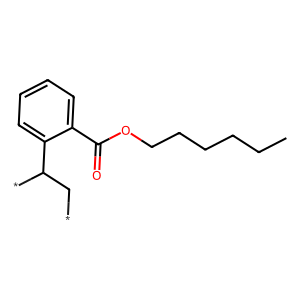

In [106]:
mol = Molecule(subset_df['SMILES'][0], input_type='smiles')
mol.visualize()

In [107]:
df = pd.read_csv(subset_path)
print(f"Loaded {len(df)} molecules.")

Loaded 7973 molecules.


In [108]:
df.head(5)

,SMILES,Tg,FFV,Tc,Density,Rg
0,*C=Cc1ccc2c3ccc(*)cc3n(-c3ccc(OCCCCCCCCCC)c(OC...,NaN,0.386695,NaN,NaN,NaN
1,*CC(=O)NCCCCCCNC(=O)Cc1ccc(O*)cc1,NaN,0.335504,NaN,NaN,NaN
2,*CC(*)c1ccccc1C(=O)NC,NaN,0.355580,0.183667,NaN,NaN
3,*c1ccc2c(c1)C(=O)N(c1ccc(Oc3ccc(N4C(=O)c5ccc(-...,NaN,0.401573,NaN,NaN,NaN
4,*CC(*)OC(=O)c1ccc(-c2ccccc2)cc1,NaN,0.353609,NaN,NaN,NaN


In [109]:
missing_values = df.isnull().sum()
total_rows = len(df)
percent_missing = (missing_values / total_rows) * 100

missing_df = pd.DataFrame({
    'Total Missing': missing_values,
    'Percent Missing': percent_missing
})

print("Missing Values by Column:")
print(missing_df)
print("\nFeature Statistics (Min, Max, Mean, etc.):")
print(df[['Tg', 'FFV', 'Tc', 'Density', 'Rg']].describe())

Missing Values by Column:
         Total Missing  Percent Missing
SMILES               0         0.000000
Tg                7462        93.590869
FFV                943        11.827418
Tc                7236        90.756303
Density           7360        92.311551
Rg                7359        92.299009

Feature Statistics (Min, Max, Mean, etc.):
               Tg          FFV          Tc     Density          Rg
count  511.000000  7030.000000  737.000000  613.000000  614.000000
mean    96.452314     0.367212    0.256334    0.985484   16.419787
std    111.228279     0.029609    0.089538    0.146189    4.608640
min   -148.029738     0.226992    0.046500    0.748691    9.728355
25%     13.674509     0.349549    0.186000    0.890243   12.540328
50%     74.040183     0.364264    0.236000    0.948193   15.052194
75%    161.147595     0.380790    0.330500    1.062096   20.411067
max    472.250000     0.777097    0.524000    1.840999   34.672906


The only property that appears will succeed with a simple imputation strategy is FFV. All other properties contain very high percent missing. Therefore, I will impute median for FFV, train a model for FFV, and train separate models for other properties. I will attempt to filter out missing values for each property. If this yields uncessful, I may explore sampling techniques or use the trained model to impute values to train a secondaery model. |

# Rg Model

In [110]:
# 1. Create a new DataFrame with only the SMILES and Rg columns
df_Rg = df[['SMILES', 'Rg']].copy()

print("Initial Rg DataFrame shape:", df_Rg.shape)
print("Initial Rg Missing Values:")
print(df_Rg.isnull().sum())

# 2. Drop all rows where the 'Rg' value is missing
df_Rg.dropna(subset=['Rg'], inplace=True)

print("\nCleaned Rg DataFrame shape:", df_Rg.shape)
print("Cleaned Rg Missing Values:")
print(df_Rg.isnull().sum())

Initial Rg DataFrame shape: (7973, 2)
Initial Rg Missing Values:
SMILES       0
Rg        7359
dtype: int64

Cleaned Rg DataFrame shape: (614, 2)
Cleaned Rg Missing Values:
SMILES    0
Rg        0
dtype: int64


In [111]:
from rdkit.Chem import AllChem, Descriptors, HybridizationType, SanitizeFlags
def rdkit_ogb_agree(smi: str) -> bool:
    m = Chem.MolFromSmiles(smi)
    if m is None:
        return False
    return m.GetNumAtoms() == smiles2graph(smi)["num_nodes"]

def canonicalize_polymer_smiles(smiles: str, cap_atomic_num: int = 6) -> str:
    """
    Turn every '*' (dummy atom) into a real atom (default C) in the RDKit graph,
    preserving existing bond orders/stereo; sanitize, remove explicit Hs, and
    return canonical isomeric SMILES.
    """
    mol = Chem.MolFromSmiles(smiles, sanitize=False)
    if mol is None:
        raise ValueError(f"RDKit could not parse SMILES: {smiles}")

    rw = Chem.RWMol(mol)
    for a in rw.GetAtoms():
        if a.GetAtomicNum() == 0:   # '*'
            a.SetAtomicNum(cap_atomic_num)  # 6 = carbon
            a.SetFormalCharge(0)
            a.SetIsAromatic(False)
            a.SetNoImplicit(False)
            a.SetNumExplicitHs(0)

    mol2 = rw.GetMol()
    try:
        Chem.SanitizeMol(mol2)
    except Exception:
        Chem.SanitizeMol(mol2, sanitizeOps=SanitizeFlags.SANITIZE_ALL ^ SanitizeFlags.SANITIZE_KEKULIZE)
        Chem.Kekulize(mol2, clearAromaticFlags=True)

    mol2 = Chem.RemoveHs(mol2)
    return Chem.MolToSmiles(mol2, isomericSmiles=True, canonical=True)

In [112]:
# Build the molecule list
valid_mol_objs = []
valid_targets = []  # Now stores an array with one value per molecule

for i, row in df_Rg.iterrows():
    smi = row['SMILES']
    
    # 2.a Clean the SMILES first
    cleaned_smiles = canonicalize_polymer_smiles(smi)

    try:
        # 2.b Create your custom Molecule from the cleaned string
        mol = Molecule(cleaned_smiles, input_type='smiles')
        mol.hydrogens('add')
        mol.to_xyz(optimizer='MMFF', maxIters=200)

        # 2.c Only keep molecules that got a 3-D geometry
        if mol.xyz is not None:
            valid_mol_objs.append(mol)
            
            # Keep only the 'Tc' target column as a NumPy array
            valid_targets.append(
                row[['Rg']].values
            )
        else:
            print(f"Skipped bc missing xyz: {smi}")

    except Exception as e:
        print(f"Failed on {smi} | Reason: {e}")

print(f"Kept {len(valid_mol_objs)} molecules after filtering.")

df_clean = pd.DataFrame({
    'SMILES': [m.smiles for m in valid_mol_objs],
    'Rg': [t[0] for t in valid_targets],
})
print(f"Kept {len(df_clean)} molecules after filtering.")
df_clean.to_csv('cleaned_Rg_dataset.csv', index=False)
print("Saved cleaned Rg dataset to 'cleaned_Rg_dataset.csv'.")

y = np.array([t[0] for t in valid_targets])
print("Target shape:", y.shape)

# Your feature computation will now work correctly
fp_featurizer = RDKitFingerprint(
    fingerprint_type='morgan', vector='bit', n_bits=1024, radius=3
)
X_fp = fp_featurizer.represent(valid_mol_objs)

print("RDKit FP shape:", X_fp.shape)

Failed on *c1ccc(-c2cc(-c3ccc(OCCCCCC)cc3)cc(-c3ccc(-c4ccc5c(c4)C(CCCCCC)(CCCCCC)c4cc(*)ccc4-5)cc3)c2-c2ccc(OCCCCCC)cc2)cc1 | Reason: Bad Conformer Id
Kept 613 molecules after filtering.
Kept 613 molecules after filtering.
Saved cleaned Rg dataset to 'cleaned_Rg_dataset.csv'.
Target shape: (613,)
RDKit FP shape: (613, 1024)


In [113]:
# # 1. make separate train/test splits for both scaled and unscaled targets
# # scaled targets (MLP, KRR, GNN)
# X_train_fp_scaled, X_test_fp_scaled, y_train_scaled, y_test_scaled = train_test_split(
#     X_fp, y, test_size=0.2, random_state=42
# )
# # X_train_cm_scaled, X_test_cm_scaled, _, _ = train_test_split(
# #     X_cm, y, test_size=0.2, random_state=42
# # )

# xscaler_fp = StandardScaler()
# # xscaler_cm = StandardScaler()
# yscaler = StandardScaler()

# X_train_fp_scaled = xscaler_fp.fit_transform(X_train_fp_scaled)
# X_test_fp_scaled  = xscaler_fp.transform(X_test_fp_scaled)

# # X_train_cm_scaled = xscaler_cm.fit_transform(X_train_cm_scaled)
# # X_test_cm_scaled  = xscaler_cm.transform(X_test_cm_scaled)

# y_train_scaled = yscaler.fit_transform(y_train_scaled)
# y_test_scaled  = yscaler.transform(y_test_scaled)

# # b) unscaled targets (Random Forest)
# y_unscaled = y              
# X_train_fp_unscaled, X_test_fp_unscaled, y_train_unscaled, y_test_unscaled = train_test_split(
#     X_fp, y_unscaled, test_size=0.2, random_state=42
# )

# # 2. show shapes
# tools.display_dataframe_to_user(
#     name="Cleaned Feature Splits",
#     dataframe=pd.DataFrame({
#         "Split": [
#             "X_train_fp_scaled", "X_test_fp_scaled",
#             # "X_train_cm_scaled", "X_test_cm_scaled",
#             "y_train_scaled",   "y_test_scaled",
#             "X_train_fp_unscaled", "X_test_fp_unscaled",
#             "y_train_unscaled",   "y_test_unscaled"
#         ],
#         "Shape": [
#             X_train_fp_scaled.shape, X_test_fp_scaled.shape,
#             # X_train_cm_scaled.shape, X_test_cm_scaled.shape,
#             y_train_scaled.shape,   y_test_scaled.shape,
#             X_train_fp_unscaled.shape, X_test_fp_unscaled.shape,
#             y_train_unscaled.shape,   y_test_unscaled.shape
#         ]
#     })
# )

# 1. make separate train/test splits for both scaled and unscaled targets
# a) Scaled targets (for KRR)
# Your y is now a 1D array of FFV values.
X_train_fp, X_test_fp, y_train, y_test = train_test_split(
    X_fp, y, test_size=0.2, random_state=42
)

xscaler_fp = StandardScaler()
yscaler = StandardScaler()

X_train_fp_scaled = xscaler_fp.fit_transform(X_train_fp)
X_test_fp_scaled = xscaler_fp.transform(X_test_fp)

# Reshape y arrays for the StandardScaler
y_train_scaled = yscaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = yscaler.transform(y_test.reshape(-1, 1))

# b) Unscaled targets (for models that don't need scaling, like Random Forest)
# These are the original, unscaled splits. You can use the variables you already created.
X_train_fp_unscaled = X_train_fp
X_test_fp_unscaled = X_test_fp
y_train_unscaled = y_train
y_test_unscaled = y_test

# 2. show shapes
# The shape display now reflects the single target variable
tools.display_dataframe_to_user(
    name="Cleaned Feature Splits",
    dataframe=pd.DataFrame({
        "Split": [
            "X_train_fp_scaled", "X_test_fp_scaled",
            "y_train_scaled", "y_test_scaled",
            "X_train_fp_unscaled", "X_test_fp_unscaled",
            "y_train_unscaled", "y_test_unscaled"
        ],
        "Shape": [
            X_train_fp_scaled.shape, X_test_fp_scaled.shape,
            y_train_scaled.shape, y_test_scaled.shape,
            X_train_fp_unscaled.shape, X_test_fp_unscaled.shape,
            y_train_unscaled.shape, y_test_unscaled.shape
        ]
    })
)

Cleaned Feature Splits


## Kernel Ridge Regression baseline first

In [114]:
# Kernel Ridge on RDKit fingerprints
krr = KernelRidge(kernel='rbf', alpha=1.0)
krr.fit(X_train_fp_scaled, y_train_scaled)

# predict on scaled test set
y_pred_krr_scaled = krr.predict(X_test_fp_scaled)

# Inverse transform predictions and test targets to compare with unscaled values
# You must reshape y_pred_krr_scaled and y_test_scaled to 2D before inverse transforming
y_pred_krr = yscaler.inverse_transform(y_pred_krr_scaled.reshape(-1, 1)).flatten()
y_test_krr = yscaler.inverse_transform(y_test_scaled).flatten()

# Eval against true unscaled test target
print("Kernel Ridge (RDKit FP)")
metrics_krr = regression_metrics(y_test_krr, y_pred_krr)
print(metrics_krr[['MAE', 'RMSE', 'r_squared']])

Kernel Ridge (RDKit FP)
        MAE      RMSE  r_squared
0  2.556085  3.273124   0.476583


## Random Forest Regression baseline 

In [115]:
# Random Forest (RDKit FP) 
rfr = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=42)
rfr.fit(X_train_fp_unscaled, y_train_unscaled)
# predict
y_pred_rfr = rfr.predict(X_test_fp_unscaled)
# eval
print("Random Forest (RDKit FP)")
metrics_rfr = regression_metrics(y_test_unscaled, y_pred_rfr)
print(metrics_rfr[['MAE', 'RMSE', 'r_squared']])

Random Forest (RDKit FP)
        MAE      RMSE  r_squared
0  1.787365  2.473684   0.701041


## Multi-Layer Perceptron with Morgan Fingerprints baseline 

In [116]:
# MLP (Fingerprint)
mlp_fp = MLP(
    engine='tensorflow',
    nfeatures=X_train_fp_scaled.shape[1],
    nneurons=[64, 128], # These are the hidden layers
    activations=['ReLU', 'ReLU'],
    learning_rate=0.01,
    alpha=0.001,
    nepochs=200,
    batch_size=64,
    loss='mean_squared_error',
    is_regression=True
)

mlp_fp.fit(X=X_train_fp_scaled, y=y_train_scaled.ravel()) # Use .ravel() to convert to 1D
y_pred_fp_scaled = mlp_fp.predict(X_test_fp_scaled)
# Reshape the output from predict() to 2D before inverse transforming
y_pred_fp = yscaler.inverse_transform(y_pred_fp_scaled.reshape(-1, 1)).flatten()
y_test_fp = yscaler.inverse_transform(y_test_scaled).flatten()

# Eval against true unscaled test target
print("MLP (RDKit FP)")
metrics_mlp = regression_metrics(y_test, y_pred_fp)
print(metrics_mlp[['MAE', 'RMSE', 'r_squared']])

Epoch 1/200
8/8 [==============================] - 0s 3ms/step - loss: 1.3798
Epoch 2/200
8/8 [==============================] - 0s 5ms/step - loss: 0.6049
Epoch 3/200
8/8 [==============================] - 0s 4ms/step - loss: 0.4321
Epoch 4/200
8/8 [==============================] - 0s 3ms/step - loss: 0.3493
Epoch 5/200
8/8 [==============================] - 0s 3ms/step - loss: 0.3129
Epoch 6/200
8/8 [==============================] - 0s 3ms/step - loss: 0.2840
Epoch 7/200
8/8 [==============================] - 0s 3ms/step - loss: 0.2677
Epoch 8/200
8/8 [==============================] - 0s 2ms/step - loss: 0.2515
Epoch 9/200
8/8 [==============================] - 0s 3ms/step - loss: 0.2406
Epoch 10/200
8/8 [==============================] - 0s 2ms/step - loss: 0.2335
Epoch 11/200
8/8 [==============================] - 0s 3ms/step - loss: 0.2321
Epoch 12/200
8/8 [==============================] - 0s 4ms/step - loss: 0.2324
Epoch 13/200
8/8 [==============================] - 0s 3ms/st

## Multi-Layer Perceptron with Coulomb Matrix representation baseline 

In [117]:
# # MLP (Coulomb matrix)
# mlp_cm = MLP(
#     engine='tensorflow', 
#     nfeatures=X_train_cm_scaled.shape[1], 
#     nneurons=[64, 128], 
#     activations=['ReLU', 'ReLU'],
#     learning_rate=0.0001, 
#     alpha=0.001, 
#     nepochs=100, 
#     batch_size=64, 
#     loss='mean_squared_error', 
#     is_regression=True
#     )

# mlp_cm.fit(X=X_train_cm_scaled, y=y_train_scaled)
# y_pred_cm_scaled = mlp_cm.predict(X_test_cm_scaled)
# y_pred_cm = yscaler.inverse_transform(y_pred_cm_scaled)
# y_test_cm = yscaler.inverse_transform(y_test_scaled)

In [118]:
# eval
results = {"Kernel Ridge (RDKit FP)": regression_metrics(y_test_krr, y_pred_krr),
           "Random Forest (RDKit FP)": regression_metrics(y_test_unscaled, y_pred_rfr),
           "MLP (RDKit FP)": regression_metrics(y_test_fp, y_pred_fp),
        #    "MLP (Coulomb Matrix)": regression_metrics(y_test_cm, y_pred_cm)
        }

# display
print("Final Model Comparison")
for name, metrics_df in results.items():
    print(f"\n{name}")
    print(metrics_df[['MAE', 'RMSE', 'r_squared']])

Final Model Comparison

Kernel Ridge (RDKit FP)
        MAE      RMSE  r_squared
0  2.556085  3.273124   0.476583

Random Forest (RDKit FP)
        MAE      RMSE  r_squared
0  1.787365  2.473684   0.701041

MLP (RDKit FP)
        MAE      RMSE  r_squared
0  2.079622  2.805338   0.615503


## Parity Plots and Residuals Histograms

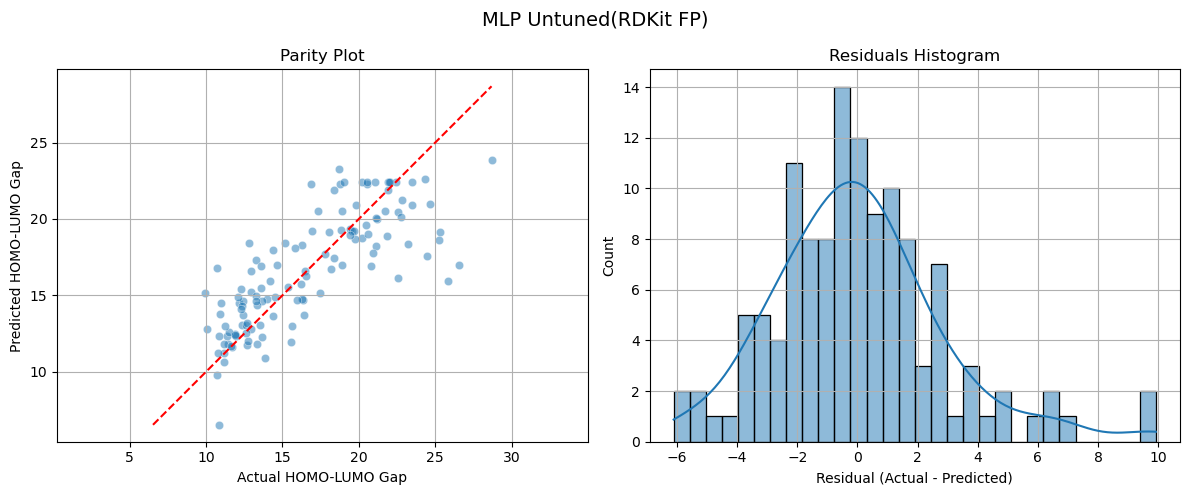

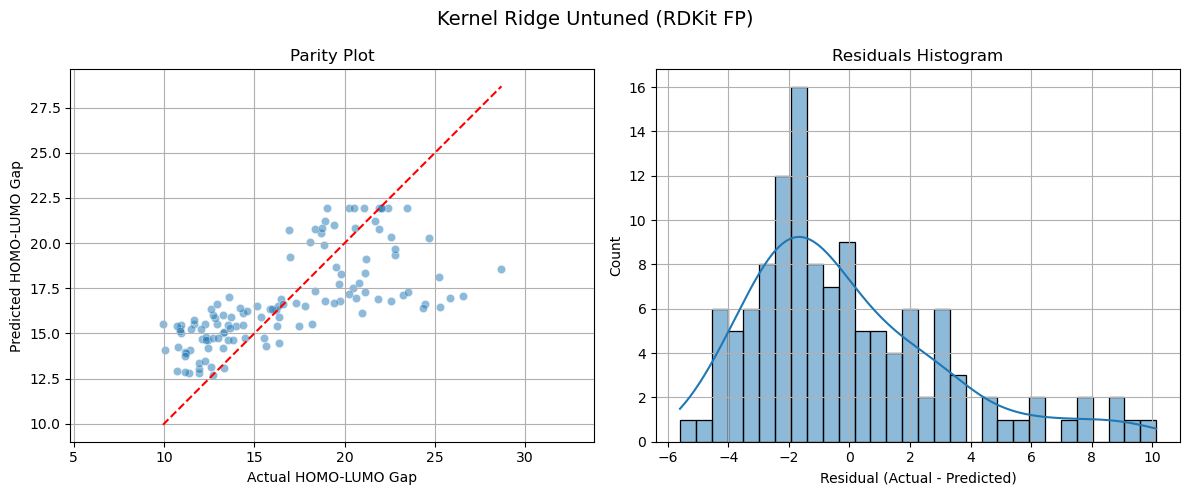

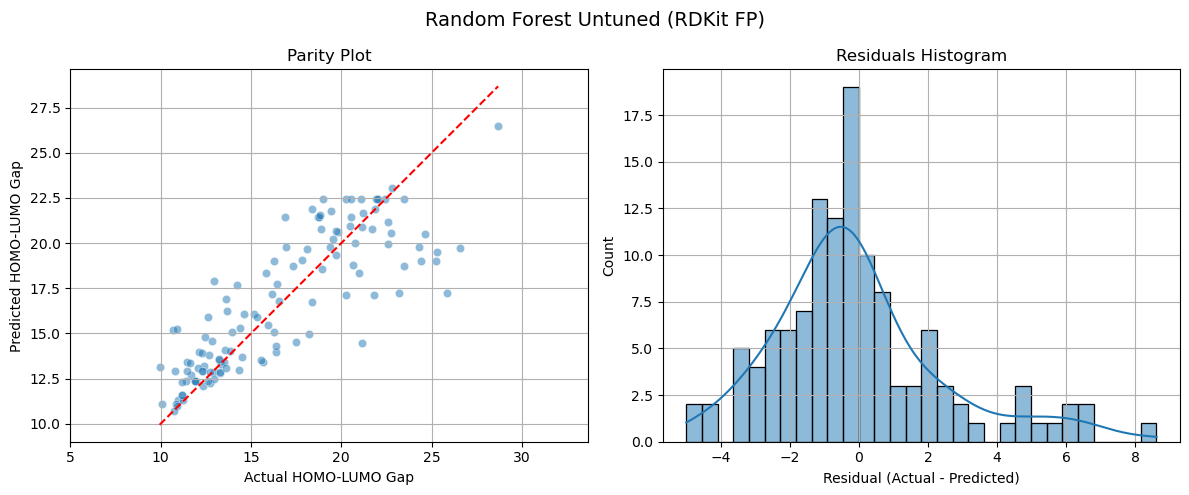

In [119]:
def plot_regression_results(y_true, y_pred, title="Model Evaluation", save_dir="plots"):
    residuals = y_true.flatten() - y_pred.flatten()
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # parity plot
    sns.scatterplot(ax=axes[0], x=y_true.flatten(), y=y_pred.flatten(), alpha=0.5)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], '--r')
    axes[0].set_xlabel("Actual HOMO-LUMO Gap")
    axes[0].set_ylabel("Predicted HOMO-LUMO Gap")
    axes[0].set_title("Parity Plot")
    axes[0].grid(True)
    axes[0].axis('equal')

    # residuals histogram
    sns.histplot(ax=axes[1], data=residuals, bins=30, kde=True)
    axes[1].set_title("Residuals Histogram")
    axes[1].set_xlabel("Residual (Actual - Predicted)")
    axes[1].grid(True)

    # overall title
    fig.suptitle(title, fontsize=14)

    # save fig as pdf for best overleaf upload format 
    os.makedirs(save_dir, exist_ok=True)
    filename = os.path.join(save_dir, f"{title.lower().replace(' ', '_')}_plots.pdf")
    fig.savefig(filename, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

plot_regression_results(y_test_fp, y_pred_fp, title="MLP Untuned(RDKit FP)")
# plot_regression_results(y_test_cm, y_pred_cm, title="MLP Untuned (Coulomb Matrix)")
plot_regression_results(y_test_krr, y_pred_krr, title="Kernel Ridge Untuned (RDKit FP)")
plot_regression_results(y_test_unscaled, y_pred_rfr, title="Random Forest Untuned (RDKit FP)")

## Tune hyperparameters for baseline models with Optuna 

In [120]:
def objective_krr(trial):
    alpha = trial.suggest_float('alpha', 0.01, 1.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly'])
    gamma = trial.suggest_float('gamma', 1e-5, 1.0, log=True) if kernel == 'rbf' else None
    model = KernelRidge(alpha=alpha, kernel=kernel, gamma=gamma) if gamma else KernelRidge(alpha=alpha, kernel=kernel)
    model.fit(X_train_fp_scaled, y_train_scaled)
    preds_scaled = model.predict(X_test_fp_scaled).reshape(-1, 1)
    preds = yscaler.inverse_transform(preds_scaled)
    y_test_inv = yscaler.inverse_transform(y_test_scaled)
    metrics = regression_metrics(y_test_inv, preds)
    return metrics['MAE'][0]

study_krr = optuna.create_study(direction='minimize')
study_krr.optimize(objective_krr, n_trials=1000)

[I 2025-09-04 21:02:10,039] A new study created in memory with name: no-name-524eaa50-61df-44ab-a1be-08c1f3f70993
[I 2025-09-04 21:02:10,058] Trial 0 finished with value: 1.9302987284656619 and parameters: {'alpha': 0.14513458760480907, 'kernel': 'poly'}. Best is trial 0 with value: 1.9302987284656619.
[I 2025-09-04 21:02:10,071] Trial 1 finished with value: 2.840112245906479 and parameters: {'alpha': 0.08146890746382296, 'kernel': 'linear'}. Best is trial 0 with value: 1.9302987284656619.
[I 2025-09-04 21:02:10,088] Trial 2 finished with value: 2.8676532758232227 and parameters: {'alpha': 0.04779091471260243, 'kernel': 'linear'}. Best is trial 0 with value: 1.9302987284656619.
[I 2025-09-04 21:02:10,112] Trial 3 finished with value: 3.3494238061946806 and parameters: {'alpha': 0.18780668448559307, 'kernel': 'rbf', 'gamma': 0.025122889316061988}. Best is trial 0 with value: 1.9302987284656619.
[I 2025-09-04 21:02:10,155] Trial 4 finished with value: 3.3815444602396028 and parameters: {

In [121]:
def objective_rfr(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300, step=50)
    max_depth = trial.suggest_int("max_depth", 10, 100, step=10)
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)
    model.fit(X_train_fp_unscaled, y_train_unscaled)
    preds = model.predict(X_test_fp_unscaled)
    metrics = regression_metrics(y_test_unscaled, preds)
    return metrics['MAE'][0]

study_rfr = optuna.create_study(direction='minimize')
study_rfr.optimize(objective_rfr, n_trials=100)

[I 2025-09-04 21:02:34,119] A new study created in memory with name: no-name-55547504-e701-445c-911b-e99188802bbb
[I 2025-09-04 21:02:34,414] Trial 0 finished with value: 1.796754007845293 and parameters: {'n_estimators': 100, 'max_depth': 90}. Best is trial 0 with value: 1.796754007845293.
[I 2025-09-04 21:02:34,615] Trial 1 finished with value: 1.792214427147921 and parameters: {'n_estimators': 50, 'max_depth': 70}. Best is trial 1 with value: 1.792214427147921.
[I 2025-09-04 21:02:35,253] Trial 2 finished with value: 1.746548499580389 and parameters: {'n_estimators': 250, 'max_depth': 100}. Best is trial 2 with value: 1.746548499580389.
[I 2025-09-04 21:02:35,933] Trial 3 finished with value: 1.7438558801344457 and parameters: {'n_estimators': 300, 'max_depth': 20}. Best is trial 3 with value: 1.7438558801344457.
[I 2025-09-04 21:02:36,116] Trial 4 finished with value: 1.7889717633362614 and parameters: {'n_estimators': 50, 'max_depth': 30}. Best is trial 3 with value: 1.74385588013

In [122]:
def objective_mlp_fp(trial):
    lr = trial.suggest_float('lr', 1e-4, 2e-2, log=True)
    alpha = trial.suggest_float('alpha', 1e-4, 5e-2, log=True)
    act = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid', 'gelu'])
    n1 = trial.suggest_int('n1', 128, 384, step=64)
    n2 = trial.suggest_int('n2', 128, 384, step=64)

    model = MLP(
        engine='tensorflow',
        nfeatures=X_train_fp_scaled.shape[1], 
        nneurons=[n1, n2],
        activations=[act, act], 
        learning_rate=lr, 
        alpha=alpha,
        nepochs=100, 
        batch_size=64, 
        loss='mean_squared_error', 
        is_regression=True
        )
    
    model.fit(X_train_fp_scaled, y_train_scaled)
    preds_scaled = model.predict(X_test_fp_scaled).reshape(-1, 1)
    preds = yscaler.inverse_transform(preds_scaled)
    y_test_inv = yscaler.inverse_transform(y_test_scaled)
    metrics = regression_metrics(y_test_inv, preds)
    return metrics['MAE'][0]

study_mlp_fp = optuna.create_study(direction='minimize')
study_mlp_fp.optimize(objective_mlp_fp, n_trials=100)

[I 2025-09-04 21:04:29,626] A new study created in memory with name: no-name-cd6b28a5-d1de-4ee0-aa4f-f53d3170a226


Epoch 1/100
8/8 [==============================] - 0s 3ms/step - loss: 22.5776
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 20.8674
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 18.8113
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 16.7403
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 14.8612
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 13.1484
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 11.6355
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 10.2910
Epoch 9/100
8/8 [==============================] - 0s 5ms/step - loss: 9.1004
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: 8.0492
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 7.1188
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 6.2976
Epoch 13/100
8/8 [==============================] - 0

[I 2025-09-04 21:04:32,585] Trial 0 finished with value: 1.9455822398152114 and parameters: {'lr': 0.012506948929669975, 'alpha': 0.02867458166589874, 'activation': 'relu', 'n1': 384, 'n2': 128}. Best is trial 0 with value: 1.9455822398152114.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 19.4041
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 18.5621
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 18.0882
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 17.8265
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 17.5905
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 17.3807
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 17.1880
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 16.9998
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 16.8203
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 16.6429
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 16.4699
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 16.2991
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 21:04:34,568] Trial 1 finished with value: 2.198563752587031 and parameters: {'lr': 0.0013221575642792637, 'alpha': 0.024001613905772243, 'activation': 'tanh', 'n1': 384, 'n2': 128}. Best is trial 0 with value: 1.9455822398152114.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 2.5536
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 2.1015
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6295
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4481
Epoch 5/100
8/8 [==============================] - 0s 1ms/step - loss: 1.4168
Epoch 6/100
8/8 [==============================] - 0s 1ms/step - loss: 1.3555
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 1.2739
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 1.2333
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 1.1944
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 1.1457
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 1.1318
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 1.1347
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:04:36,575] Trial 2 finished with value: 2.2463471004773186 and parameters: {'lr': 0.017974971095635398, 'alpha': 0.0014731462697211782, 'activation': 'sigmoid', 'n1': 320, 'n2': 256}. Best is trial 0 with value: 1.9455822398152114.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 1.2236
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 1.0330
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 0.8468
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5677
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6216
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.4674
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3784
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3314
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3452
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3421
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3043
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2936
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:04:38,605] Trial 3 finished with value: 2.1951429042858828 and parameters: {'lr': 0.013536128399178482, 'alpha': 0.00021892196515532164, 'activation': 'sigmoid', 'n1': 384, 'n2': 256}. Best is trial 0 with value: 1.9455822398152114.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 1.5388
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 0.9978
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6560
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5344
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.4626
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.4113
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3773
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 0.3578
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3411
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3309
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3218
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3142
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:04:40,835] Trial 4 finished with value: 2.7010818153872056 and parameters: {'lr': 0.0010552589581914332, 'alpha': 0.0003529229942610836, 'activation': 'gelu', 'n1': 256, 'n2': 320}. Best is trial 0 with value: 1.9455822398152114.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 2.4418
Epoch 2/100
8/8 [==============================] - 0s 1ms/step - loss: 2.2581
Epoch 3/100
8/8 [==============================] - 0s 1ms/step - loss: 2.2261
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2278
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2123
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2050
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2031
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 2.1963
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 2.1923
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 2.1887
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 2.1848
Epoch 12/100
8/8 [==============================] - 0s 1ms/step - loss: 2.1803
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:04:42,771] Trial 5 finished with value: 2.9604539094678772 and parameters: {'lr': 0.0002293737813871796, 'alpha': 0.0034657558847675223, 'activation': 'sigmoid', 'n1': 128, 'n2': 128}. Best is trial 0 with value: 1.9455822398152114.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 1.1009
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6750
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 0.4697
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3379
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 0.2698
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 0.2289
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2025
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1827
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1670
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1556
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1470
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1393
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:04:44,931] Trial 6 finished with value: 2.2940382800404358 and parameters: {'lr': 0.0011918327556436098, 'alpha': 0.00014123006160084872, 'activation': 'tanh', 'n1': 192, 'n2': 384}. Best is trial 0 with value: 1.9455822398152114.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 1.9196
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 1.7210
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 1.5608
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4029
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 1.2679
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 1.1704
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 1.0897
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 1.0259
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 0.9715
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 0.9272
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 0.8893
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 0.8570
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:04:46,907] Trial 7 finished with value: 2.8339399743944855 and parameters: {'lr': 0.00016468246480052408, 'alpha': 0.0013031901456353012, 'activation': 'relu', 'n1': 128, 'n2': 128}. Best is trial 0 with value: 1.9455822398152114.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 1.8415
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 1.2076
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 0.9754
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 0.8579
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.7846
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.7405
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.7144
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6936
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6765
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6658
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6567
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6485
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:04:49,084] Trial 8 finished with value: 2.5802767851253594 and parameters: {'lr': 0.0009249797276505639, 'alpha': 0.0008902416378976463, 'activation': 'tanh', 'n1': 256, 'n2': 256}. Best is trial 0 with value: 1.9455822398152114.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 16.6501
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 16.5099
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 16.3401
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 16.1717
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 16.0230
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 15.8973
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 15.7854
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 15.6901
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 15.6032
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 15.5254
Epoch 11/100
8/8 [==============================] - 0s 4ms/step - loss: 15.4518
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 15.3868
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 21:04:52,977] Trial 9 finished with value: 2.339623548854667 and parameters: {'lr': 0.0001830846545746065, 'alpha': 0.037185633721884666, 'activation': 'gelu', 'n1': 128, 'n2': 320}. Best is trial 0 with value: 1.9455822398152114.


Epoch 1/100
8/8 [==============================] - 0s 4ms/step - loss: 7.3672
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 6.6576
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 6.3803
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 6.2473
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 6.0640
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 5.9418
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 5.8473
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 5.7605
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 5.6772
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: 5.5981
Epoch 11/100
8/8 [==============================] - 0s 4ms/step - loss: 5.5216
Epoch 12/100
8/8 [==============================] - 0s 4ms/step - loss: 5.4471
Epoch 13/100
8/8 [==============================] - 0s 4ms/st

[I 2025-09-04 21:04:57,115] Trial 10 finished with value: 2.0526118415424173 and parameters: {'lr': 0.004841760492185288, 'alpha': 0.00855843041528723, 'activation': 'relu', 'n1': 320, 'n2': 192}. Best is trial 0 with value: 1.9455822398152114.


Epoch 1/100
8/8 [==============================] - 0s 3ms/step - loss: 9.5857
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 8.8154
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 8.5289
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 8.3161
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 8.1204
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 7.9073
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 7.7356
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 7.5654
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 7.4046
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 7.2548
Epoch 11/100
8/8 [==============================] - 0s 7ms/step - loss: 7.1094
Epoch 12/100
8/8 [==============================] - 0s 4ms/step - loss: 6.9643
Epoch 13/100
8/8 [==============================] - 0s 3ms/st

[I 2025-09-04 21:05:01,068] Trial 11 finished with value: 1.918677925474689 and parameters: {'lr': 0.005299012937491008, 'alpha': 0.011755305480802326, 'activation': 'relu', 'n1': 320, 'n2': 192}. Best is trial 11 with value: 1.918677925474689.


Epoch 1/100
8/8 [==============================] - 0s 3ms/step - loss: 7.8797
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 7.1112
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 6.7215
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 6.4895
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 6.3280
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 6.1925
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 6.0781
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 5.9753
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 5.8669
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: 5.7664
Epoch 11/100
8/8 [==============================] - 0s 4ms/step - loss: 5.6690
Epoch 12/100
8/8 [==============================] - 0s 4ms/step - loss: 5.5729
Epoch 13/100
8/8 [==============================] - 0s 9ms/st

[I 2025-09-04 21:05:05,048] Trial 12 finished with value: 2.1352081259572335 and parameters: {'lr': 0.005748525141893343, 'alpha': 0.009033914667184286, 'activation': 'relu', 'n1': 320, 'n2': 192}. Best is trial 11 with value: 1.918677925474689.


Epoch 1/100
8/8 [==============================] - 0s 3ms/step - loss: 12.5804
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 11.7190
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 11.3311
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 11.0550
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 10.7742
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 10.5182
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 10.2967
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 10.0794
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 9.8631
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 9.6564
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 9.4552
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 9.2579
Epoch 13/100
8/8 [==============================] - 0

[I 2025-09-04 21:05:09,281] Trial 13 finished with value: 1.989560627521282 and parameters: {'lr': 0.004597473076722533, 'alpha': 0.014064972226338323, 'activation': 'relu', 'n1': 384, 'n2': 192}. Best is trial 11 with value: 1.918677925474689.


Epoch 1/100
8/8 [==============================] - 0s 3ms/step - loss: 4.1509
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 3.6141
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 3.4154
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 3.0699
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 2.9219
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 2.8560
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 2.8032
Epoch 8/100
8/8 [==============================] - 0s 8ms/step - loss: 2.7665
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 2.7147
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 2.6763
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 2.6423
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 2.6071
Epoch 13/100
8/8 [==============================] - 0s 3ms/st

[I 2025-09-04 21:05:13,333] Trial 14 finished with value: 2.0866594743011864 and parameters: {'lr': 0.009187223885627122, 'alpha': 0.003998701290540148, 'activation': 'relu', 'n1': 320, 'n2': 192}. Best is trial 11 with value: 1.918677925474689.


Epoch 1/100
8/8 [==============================] - 0s 4ms/step - loss: 37.0252
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 35.7697
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 34.4798
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 33.2597
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 32.0805
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 30.9274
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 29.8184
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 28.7514
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 27.7216
Epoch 10/100
8/8 [==============================] - 0s 8ms/step - loss: 26.7316
Epoch 11/100
8/8 [==============================] - 0s 5ms/step - loss: 25.7755
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 24.8546
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 21:05:17,332] Trial 15 finished with value: 1.9224143100049267 and parameters: {'lr': 0.002316520943814998, 'alpha': 0.04811100867603011, 'activation': 'relu', 'n1': 384, 'n2': 128}. Best is trial 11 with value: 1.918677925474689.


Epoch 1/100
8/8 [==============================] - 0s 4ms/step - loss: 37.2453
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 35.6044
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 34.2684
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 32.8554
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 31.4308
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 30.0730
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 28.7578
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 27.5071
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 26.3153
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: 25.1775
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 24.0898
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 23.0496
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 21:05:21,295] Trial 16 finished with value: 1.8627321129015857 and parameters: {'lr': 0.0027144823731241317, 'alpha': 0.049599748539040193, 'activation': 'relu', 'n1': 320, 'n2': 192}. Best is trial 16 with value: 1.8627321129015857.


Epoch 1/100
8/8 [==============================] - 0s 3ms/step - loss: 10.2543
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 9.5423
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 9.2902
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 9.1061
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 8.9614
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 8.8350
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 8.7191
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 8.6081
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 8.4970
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: 8.3946
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 8.2915
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 8.1898
Epoch 13/100
8/8 [==============================] - 0s 4ms/s

[I 2025-09-04 21:05:25,414] Trial 17 finished with value: 2.2502517772452246 and parameters: {'lr': 0.0025465225202623626, 'alpha': 0.014686366604809714, 'activation': 'relu', 'n1': 256, 'n2': 192}. Best is trial 16 with value: 1.8627321129015857.


Epoch 1/100
8/8 [==============================] - 0s 4ms/step - loss: 4.4754
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 4.0971
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 3.7844
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 3.6271
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 3.5473
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 3.4903
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 3.4488
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 3.4167
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 3.3912
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 3.3707
Epoch 11/100
8/8 [==============================] - 0s 4ms/step - loss: 3.3538
Epoch 12/100
8/8 [==============================] - 0s 4ms/step - loss: 3.3390
Epoch 13/100
8/8 [==============================] - 0s 8ms/st

[I 2025-09-04 21:05:29,753] Trial 18 finished with value: 2.8827969981649897 and parameters: {'lr': 0.000673619916423313, 'alpha': 0.004692912785713113, 'activation': 'gelu', 'n1': 256, 'n2': 320}. Best is trial 16 with value: 1.8627321129015857.


Epoch 1/100
8/8 [==============================] - 0s 3ms/step - loss: 10.2056
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 9.7802
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 9.2760
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 9.0584
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 8.8383
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 8.7270
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 8.6575
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 8.5928
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 8.5420
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: 8.4982
Epoch 11/100
8/8 [==============================] - 0s 4ms/step - loss: 8.4601
Epoch 12/100
8/8 [==============================] - 0s 4ms/step - loss: 8.4249
Epoch 13/100
8/8 [==============================] - 0s 3ms/s

[I 2025-09-04 21:05:33,597] Trial 19 finished with value: 2.710048937628059 and parameters: {'lr': 0.00039823898482520574, 'alpha': 0.015528436977033454, 'activation': 'relu', 'n1': 192, 'n2': 256}. Best is trial 16 with value: 1.8627321129015857.


Epoch 1/100
8/8 [==============================] - 0s 3ms/step - loss: 6.3193
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 5.4124
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 5.1628
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 5.0228
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 4.9386
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 4.8787
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 4.8351
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 4.8041
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 4.7748
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 4.7497
Epoch 11/100
8/8 [==============================] - 0s 4ms/step - loss: 4.7234
Epoch 12/100
8/8 [==============================] - 0s 4ms/step - loss: 4.6983
Epoch 13/100
8/8 [==============================] - 0s 4ms/st

[I 2025-09-04 21:05:37,793] Trial 20 finished with value: 2.257748169793616 and parameters: {'lr': 0.0022482717862801474, 'alpha': 0.0067614661226536804, 'activation': 'relu', 'n1': 320, 'n2': 192}. Best is trial 16 with value: 1.8627321129015857.


Epoch 1/100
8/8 [==============================] - 0s 4ms/step - loss: 32.3282
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 30.9233
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 30.0674
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 29.1956
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 28.3509
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 27.5252
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 26.7309
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 25.9675
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 25.2242
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 24.5063
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 23.8076
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 23.1301
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 21:05:41,793] Trial 21 finished with value: 1.9101167062632631 and parameters: {'lr': 0.0021461638629805806, 'alpha': 0.041384766960634464, 'activation': 'relu', 'n1': 384, 'n2': 128}. Best is trial 16 with value: 1.8627321129015857.


Epoch 1/100
8/8 [==============================] - 0s 3ms/step - loss: 18.9469
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 17.0959
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 16.3184
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 15.6733
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 15.1839
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 14.7465
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 14.3472
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 13.9881
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 13.6349
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 13.2993
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 12.9739
Epoch 12/100
8/8 [==============================] - 0s 4ms/step - loss: 12.6578
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 21:05:45,794] Trial 22 finished with value: 1.9888310108366127 and parameters: {'lr': 0.003109196855683419, 'alpha': 0.02406387305333381, 'activation': 'relu', 'n1': 320, 'n2': 128}. Best is trial 16 with value: 1.8627321129015857.


Epoch 1/100
8/8 [==============================] - 0s 3ms/step - loss: 34.2057
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 32.0072
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 29.5774
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 27.1476
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 24.7676
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 22.5556
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 20.5354
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 18.6883
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 17.0036
Epoch 10/100
8/8 [==============================] - 0s 5ms/step - loss: 15.4716
Epoch 11/100
8/8 [==============================] - 0s 4ms/step - loss: 14.0776
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 12.8096
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 21:05:49,415] Trial 23 finished with value: 1.8665964125741594 and parameters: {'lr': 0.0060865350597227525, 'alpha': 0.04603699215086594, 'activation': 'relu', 'n1': 320, 'n2': 192}. Best is trial 16 with value: 1.8627321129015857.


Epoch 1/100
8/8 [==============================] - 0s 3ms/step - loss: 37.4933
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 35.9430
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 34.9708
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 34.0367
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 33.1300
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 32.2652
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 31.4299
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 30.6152
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 29.8232
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: 29.0558
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 28.3068
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 27.5788
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 21:05:52,337] Trial 24 finished with value: 2.0340077800955365 and parameters: {'lr': 0.0018164168325739444, 'alpha': 0.04418223295918186, 'activation': 'relu', 'n1': 384, 'n2': 192}. Best is trial 16 with value: 1.8627321129015857.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 15.0370
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 14.1355
Epoch 3/100
8/8 [==============================] - 0s 1ms/step - loss: 13.3041
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 12.4284
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 11.6388
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 10.9100
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 10.2321
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 9.6088
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 9.0211
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 8.4750
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 7.9591
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 7.4777
Epoch 13/100
8/8 [==============================] - 0s

[I 2025-09-04 21:05:54,325] Trial 25 finished with value: 1.8452508383976476 and parameters: {'lr': 0.009005105419531683, 'alpha': 0.020943708147144375, 'activation': 'relu', 'n1': 320, 'n2': 128}. Best is trial 25 with value: 1.8452508383976476.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 12.4489
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 12.1810
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 11.4065
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 10.7025
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 10.0995
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 9.3670
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 8.7737
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 8.2535
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 7.7526
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 7.2903
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 6.8701
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 6.4645
Epoch 13/100
8/8 [==============================] - 0s 2

[I 2025-09-04 21:05:56,457] Trial 26 finished with value: 2.117426683369244 and parameters: {'lr': 0.008134072448071333, 'alpha': 0.02230193200003664, 'activation': 'sigmoid', 'n1': 192, 'n2': 192}. Best is trial 25 with value: 1.8452508383976476.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 34.6661
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 32.9760
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 31.0776
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 29.4206
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 27.7215
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 26.1190
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 24.6186
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 23.2035
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 21.8714
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 20.6200
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 19.4384
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 18.3254
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 21:05:58,813] Trial 27 finished with value: 2.0381709359913938 and parameters: {'lr': 0.0035792148136236236, 'alpha': 0.049991761656705984, 'activation': 'gelu', 'n1': 320, 'n2': 128}. Best is trial 25 with value: 1.8452508383976476.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 13.6354
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 12.6545
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 12.0803
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 11.4852
Epoch 5/100
8/8 [==============================] - 0s 1ms/step - loss: 10.9327
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 10.4026
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 9.9029
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 9.4321
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 8.9785
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 8.5508
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 8.1435
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 7.7566
Epoch 13/100
8/8 [==============================] - 0s 

[I 2025-09-04 21:06:00,883] Trial 28 finished with value: 2.302189637119125 and parameters: {'lr': 0.007785081051888344, 'alpha': 0.019071865273859012, 'activation': 'tanh', 'n1': 256, 'n2': 256}. Best is trial 25 with value: 1.8452508383976476.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 22.6707
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 19.0928
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 16.7719
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 14.2862
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 11.8915
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 9.7958
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 7.9730
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 6.4729
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 5.2491
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 4.2588
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 3.4572
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 2.8030
Epoch 13/100
8/8 [==============================] - 0s 2

[I 2025-09-04 21:06:02,984] Trial 29 finished with value: 1.9000355510184874 and parameters: {'lr': 0.019687161944383347, 'alpha': 0.029758153966546585, 'activation': 'relu', 'n1': 320, 'n2': 128}. Best is trial 25 with value: 1.8452508383976476.


Epoch 1/100
8/8 [==============================] - 0s 1ms/step - loss: 19.7568
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 19.6494
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 19.5142
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 19.3766
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 19.2545
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 19.1474
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 19.0509
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 18.9690
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 18.8959
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 18.8304
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 18.7701
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 18.7167
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 21:06:05,027] Trial 30 finished with value: 2.4817498118084216 and parameters: {'lr': 0.00010194512966059571, 'alpha': 0.029453763367055772, 'activation': 'relu', 'n1': 256, 'n2': 192}. Best is trial 25 with value: 1.8452508383976476.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 23.9625
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 21.6977
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 19.1220
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 16.5789
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 14.2947
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 12.2759
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 10.5192
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 8.9954
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 7.6940
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 6.5795
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 5.6287
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 4.8160
Epoch 13/100
8/8 [==============================] - 0s

[I 2025-09-04 21:06:07,144] Trial 31 finished with value: 2.0188758540431517 and parameters: {'lr': 0.013142291333341773, 'alpha': 0.03405253292242659, 'activation': 'relu', 'n1': 320, 'n2': 128}. Best is trial 25 with value: 1.8452508383976476.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 18.7216
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 16.7894
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 14.6089
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 12.3833
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 10.5028
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 8.8288
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 7.3922
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 6.1782
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 5.1614
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 4.3111
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 3.6028
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 3.0124
Epoch 13/100
8/8 [==============================] - 0s 2

[I 2025-09-04 21:06:09,143] Trial 32 finished with value: 1.9603446837411516 and parameters: {'lr': 0.019501981529700906, 'alpha': 0.026157085594100515, 'activation': 'relu', 'n1': 320, 'n2': 128}. Best is trial 25 with value: 1.8452508383976476.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 15.8250
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 14.6848
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 13.7187
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 12.7518
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 11.8400
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 11.0057
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 10.2334
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 9.5108
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 8.8452
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 8.2249
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 7.6482
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 7.1127
Epoch 13/100
8/8 [==============================] - 0s

[I 2025-09-04 21:06:11,633] Trial 33 finished with value: 1.8490723870770651 and parameters: {'lr': 0.01108595934156824, 'alpha': 0.019678405030832277, 'activation': 'relu', 'n1': 384, 'n2': 128}. Best is trial 25 with value: 1.8452508383976476.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 11.0350
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 8.9494
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 8.3943
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 7.9968
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 7.6466
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 7.3107
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 7.0187
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 6.7306
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 6.4632
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 6.2125
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 5.9751
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 5.7461
Epoch 13/100
8/8 [==============================] - 0s 2ms/s

[I 2025-09-04 21:06:13,767] Trial 34 finished with value: 1.8761042610590979 and parameters: {'lr': 0.010618809820398449, 'alpha': 0.010984051629475652, 'activation': 'relu', 'n1': 384, 'n2': 128}. Best is trial 25 with value: 1.8452508383976476.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 6.5942
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6246
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 6.4026
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 6.1363
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 6.1010
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 5.7647
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 5.5776
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 5.4779
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 5.3405
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 5.2448
Epoch 11/100
8/8 [==============================] - 0s 1ms/step - loss: 5.1502
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 5.0742
Epoch 13/100
8/8 [==============================] - 0s 1ms/st

[I 2025-09-04 21:06:15,804] Trial 35 finished with value: 2.219940951018825 and parameters: {'lr': 0.006672762328383692, 'alpha': 0.006420245029894681, 'activation': 'sigmoid', 'n1': 384, 'n2': 256}. Best is trial 25 with value: 1.8452508383976476.


Epoch 1/100
8/8 [==============================] - 0s 1ms/step - loss: 15.1013
Epoch 2/100
8/8 [==============================] - 0s 1ms/step - loss: 14.0531
Epoch 3/100
8/8 [==============================] - 0s 1ms/step - loss: 12.9600
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 11.8574
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 10.8886
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 9.9885
Epoch 7/100
8/8 [==============================] - 0s 1ms/step - loss: 9.1647
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 8.4114
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 7.7087
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 7.0711
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 6.4859
Epoch 12/100
8/8 [==============================] - 0s 1ms/step - loss: 5.9507
Epoch 13/100
8/8 [==============================] - 0s 2

[I 2025-09-04 21:06:17,770] Trial 36 finished with value: 2.2788241191573615 and parameters: {'lr': 0.013664727209120167, 'alpha': 0.018818320228411834, 'activation': 'tanh', 'n1': 384, 'n2': 128}. Best is trial 25 with value: 1.8452508383976476.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6145
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 1.2758
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 0.9180
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 0.7026
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5848
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.4891
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.4533
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.4368
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.4269
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 0.4230
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 0.4162
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 0.4141
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:06:19,852] Trial 37 finished with value: 2.1287499298293637 and parameters: {'lr': 0.010595177029982746, 'alpha': 0.00048811613960717806, 'activation': 'relu', 'n1': 384, 'n2': 192}. Best is trial 25 with value: 1.8452508383976476.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 3.3761
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 3.4061
Epoch 3/100
8/8 [==============================] - 0s 1ms/step - loss: 3.2898
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 3.4079
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2024
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 3.0570
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 2.8883
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 2.8342
Epoch 9/100
8/8 [==============================] - 0s 1ms/step - loss: 2.7746
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 2.7285
Epoch 11/100
8/8 [==============================] - 0s 1ms/step - loss: 2.6544
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 2.6000
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:06:21,948] Trial 38 finished with value: 2.214644053001177 and parameters: {'lr': 0.0037965090801510702, 'alpha': 0.0030774583737178405, 'activation': 'sigmoid', 'n1': 320, 'n2': 256}. Best is trial 25 with value: 1.8452508383976476.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 12.7192
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 11.9864
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 11.3026
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 10.7211
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 10.2215
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 9.7512
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 9.3191
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 8.9142
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 8.5261
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 8.1580
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 7.8052
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 7.4688
Epoch 13/100
8/8 [==============================] - 0s 2

[I 2025-09-04 21:06:24,211] Trial 39 finished with value: 2.059073029515335 and parameters: {'lr': 0.00669972469960471, 'alpha': 0.020103098491958203, 'activation': 'gelu', 'n1': 256, 'n2': 128}. Best is trial 25 with value: 1.8452508383976476.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 3.1003
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 2.4045
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 2.1811
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 2.0647
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 2.0270
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 1.9942
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 1.9778
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 1.9667
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 1.9584
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 1.9523
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 1.9472
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 1.9421
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:06:26,229] Trial 40 finished with value: 2.479198291780881 and parameters: {'lr': 0.0016599010932206123, 'alpha': 0.002054639334747989, 'activation': 'tanh', 'n1': 384, 'n2': 384}. Best is trial 25 with value: 1.8452508383976476.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 9.4094
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 8.6364
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 8.0375
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 7.5010
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 7.1719
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 6.8570
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 6.5760
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 6.3135
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 6.0671
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 5.8329
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 5.6109
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 5.3961
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:06:28,339] Trial 41 finished with value: 1.9156895303341988 and parameters: {'lr': 0.011273187682443358, 'alpha': 0.010483746382504357, 'activation': 'relu', 'n1': 384, 'n2': 128}. Best is trial 25 with value: 1.8452508383976476.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 22.5276
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 20.3388
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 17.9885
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 15.7590
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 13.6703
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 11.8026
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 10.1716
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 8.7652
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 7.5353
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 6.4870
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 5.5826
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 4.8056
Epoch 13/100
8/8 [==============================] - 0s

[I 2025-09-04 21:06:30,372] Trial 42 finished with value: 1.9369948342577172 and parameters: {'lr': 0.015094297513332171, 'alpha': 0.02859800948838268, 'activation': 'relu', 'n1': 384, 'n2': 128}. Best is trial 25 with value: 1.8452508383976476.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 28.8372
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 27.1305
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 24.4456
Epoch 4/100
8/8 [==============================] - 0s 1ms/step - loss: 21.6350
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 19.2070
Epoch 6/100
8/8 [==============================] - 0s 1ms/step - loss: 17.0055
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 15.0296
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 13.2919
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 11.7529
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 10.3967
Epoch 11/100
8/8 [==============================] - 0s 1ms/step - loss: 9.1973
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 8.1374
Epoch 13/100
8/8 [==============================] -

[I 2025-09-04 21:06:32,385] Trial 43 finished with value: 1.8793986194551933 and parameters: {'lr': 0.009580100417231561, 'alpha': 0.03737141376728426, 'activation': 'relu', 'n1': 384, 'n2': 128}. Best is trial 25 with value: 1.8452508383976476.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 9.4534
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 8.6864
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 8.2854
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 7.9514
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 7.6747
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 7.4321
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 7.2328
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 7.0409
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 6.8580
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6833
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 6.5124
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 6.3475
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:06:34,458] Trial 44 finished with value: 1.9156715762632037 and parameters: {'lr': 0.006434377056684691, 'alpha': 0.012226612152438683, 'activation': 'relu', 'n1': 320, 'n2': 128}. Best is trial 25 with value: 1.8452508383976476.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 5.6702
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 4.8847
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 4.7174
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 4.6166
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 4.5158
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 4.4475
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 4.3991
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 4.3565
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 4.3098
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 4.2708
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 4.2336
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 4.1945
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:06:36,531] Trial 45 finished with value: 2.23226945728389 and parameters: {'lr': 0.004277889600864285, 'alpha': 0.006246750356023465, 'activation': 'relu', 'n1': 320, 'n2': 192}. Best is trial 25 with value: 1.8452508383976476.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 1.3016
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5062
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2982
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2371
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1827
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1472
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1361
Epoch 8/100
8/8 [==============================] - 0s 1ms/step - loss: 0.1283
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1184
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 0.1157
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1133
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1108
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:06:38,575] Trial 46 finished with value: 2.1849734864777495 and parameters: {'lr': 0.0029598653502571695, 'alpha': 0.00010876847115786186, 'activation': 'relu', 'n1': 384, 'n2': 192}. Best is trial 25 with value: 1.8452508383976476.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 11.6855
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 10.0885
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 9.1885
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 8.4609
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 7.7587
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 7.1062
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 6.5083
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 5.9645
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 5.4568
Epoch 10/100
8/8 [==============================] - 0s 1ms/step - loss: 5.0102
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 4.5864
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 4.2065
Epoch 13/100
8/8 [==============================] - 0s 2ms/

[I 2025-09-04 21:06:40,524] Trial 47 finished with value: 1.843448312569594 and parameters: {'lr': 0.015501594115799253, 'alpha': 0.016663207576012973, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 47 with value: 1.843448312569594.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 11.5176
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 10.7538
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 9.8610
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 9.0026
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 8.4073
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 7.5291
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 6.8247
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 6.2114
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 5.7056
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 5.2228
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 4.7798
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 4.3714
Epoch 13/100
8/8 [==============================] - 0s 2ms/

[I 2025-09-04 21:06:42,708] Trial 48 finished with value: 2.3452508460224375 and parameters: {'lr': 0.01595515231870465, 'alpha': 0.016655010630108328, 'activation': 'sigmoid', 'n1': 256, 'n2': 192}. Best is trial 47 with value: 1.843448312569594.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 17.5862
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 16.1950
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 14.9225
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 13.7014
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 12.4318
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 11.3506
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 10.3530
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 9.4507
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 8.6224
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 7.8717
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 7.1852
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 6.5598
Epoch 13/100
8/8 [==============================] - 0s

[I 2025-09-04 21:06:44,800] Trial 49 finished with value: 1.8254005014245944 and parameters: {'lr': 0.007863133981898437, 'alpha': 0.03459059408253292, 'activation': 'relu', 'n1': 192, 'n2': 128}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 17.9738
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 16.1320
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 14.7893
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 13.3705
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 12.0963
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 10.9345
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 9.9032
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 8.9606
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 8.1101
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 7.3422
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6489
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 6.0222
Epoch 13/100
8/8 [==============================] - 0s 

[I 2025-09-04 21:06:47,161] Trial 50 finished with value: 2.038447106822703 and parameters: {'lr': 0.008549584996613681, 'alpha': 0.03459312328903979, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 14.4046
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 13.1958
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 12.5922
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 12.1470
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 11.5910
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 11.1253
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 10.6938
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 10.2781
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 9.8784
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 9.4997
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 9.1378
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 8.7889
Epoch 13/100
8/8 [==============================] - 0

[I 2025-09-04 21:06:49,301] Trial 51 finished with value: 1.8992012660345252 and parameters: {'lr': 0.005135353848419676, 'alpha': 0.02311597145945337, 'activation': 'relu', 'n1': 192, 'n2': 320}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 14.2132
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 12.6120
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 11.0613
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 9.5516
Epoch 5/100
8/8 [==============================] - 0s 1ms/step - loss: 8.1961
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 6.9878
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 5.9535
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 5.0664
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 4.3106
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 3.6705
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 3.1268
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 2.6654
Epoch 13/100
8/8 [==============================] - 0s 2ms

[I 2025-09-04 21:06:51,367] Trial 52 finished with value: 1.8744747828031354 and parameters: {'lr': 0.012295315810679736, 'alpha': 0.03775346553345508, 'activation': 'relu', 'n1': 128, 'n2': 128}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 23.8999
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 20.5267
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 16.5698
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 12.7576
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 9.5975
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 7.1576
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 5.3040
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 3.9179
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 2.8941
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 2.1408
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 1.5856
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 1.1856
Epoch 13/100
8/8 [==============================] - 0s 2m

[I 2025-09-04 21:06:53,502] Trial 53 finished with value: 1.8798354399120738 and parameters: {'lr': 0.016321334479236005, 'alpha': 0.04936021858860191, 'activation': 'relu', 'n1': 192, 'n2': 128}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 1.7708
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 1.1798
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 0.8170
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6936
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6361
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6006
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5865
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5786
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5723
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 0.5698
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5667
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5635
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:06:55,627] Trial 54 finished with value: 2.1470805369649195 and parameters: {'lr': 0.007486539100886744, 'alpha': 0.0009571614030680792, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 6.4657
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 5.6586
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 5.1982
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 5.0404
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 4.8972
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 4.7832
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 4.6977
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 4.6228
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 4.5492
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 4.4824
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 4.4139
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 4.3487
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:06:57,778] Trial 55 finished with value: 2.1174724363580015 and parameters: {'lr': 0.005558925370928615, 'alpha': 0.00798059282945104, 'activation': 'relu', 'n1': 256, 'n2': 192}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 8.3660
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 7.6320
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 7.1645
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 6.9975
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 6.8769
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 6.7990
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 6.7438
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6926
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6491
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6095
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 6.5733
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 6.5380
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:06:59,884] Trial 56 finished with value: 2.7024646578789078 and parameters: {'lr': 0.0010897042904421453, 'alpha': 0.013169681148261513, 'activation': 'relu', 'n1': 192, 'n2': 192}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 17.9251
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 16.4001
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 15.2276
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 13.9246
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 12.7456
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 11.6317
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 10.6157
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 9.6814
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 8.8304
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 8.0542
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 7.3477
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 6.7032
Epoch 13/100
8/8 [==============================] - 0s

[I 2025-09-04 21:07:02,018] Trial 57 finished with value: 2.2720629195896094 and parameters: {'lr': 0.009347710790043571, 'alpha': 0.029236351119286384, 'activation': 'tanh', 'n1': 256, 'n2': 128}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 7.6591
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 6.8699
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 6.5952
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 6.4020
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 6.2233
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 6.0708
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 5.9300
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 5.7889
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 5.6547
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 5.5273
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 5.4055
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 5.2834
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:07:04,147] Trial 58 finished with value: 1.868977357253303 and parameters: {'lr': 0.004161099139392123, 'alpha': 0.01664290204956268, 'activation': 'relu', 'n1': 128, 'n2': 256}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 17.3167
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 16.1677
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 15.6798
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 15.2628
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 14.8575
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 14.4753
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 14.1113
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 13.7580
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 13.4133
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 13.0812
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 12.7566
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 12.4404
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 21:07:06,288] Trial 59 finished with value: 1.9848127944914173 and parameters: {'lr': 0.0032247342236219373, 'alpha': 0.023949823242467923, 'activation': 'relu', 'n1': 320, 'n2': 128}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 29.6096
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 26.8062
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 23.5405
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 20.3060
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 17.4186
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 14.8854
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 12.7025
Epoch 8/100
8/8 [==============================] - 0s 1ms/step - loss: 10.8228
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 9.2221
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 7.8558
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6934
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 5.7046
Epoch 13/100
8/8 [==============================] - 0

[I 2025-09-04 21:07:08,316] Trial 60 finished with value: 1.9970807862139188 and parameters: {'lr': 0.011705896575735364, 'alpha': 0.03913218859464359, 'activation': 'relu', 'n1': 320, 'n2': 192}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 7.5310
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 6.7714
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 6.4746
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 6.2824
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 6.0776
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 5.9083
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 5.7600
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 5.6159
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 5.4705
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 5.3358
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 5.2048
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 5.0788
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:07:10,369] Trial 61 finished with value: 2.0197571716309826 and parameters: {'lr': 0.0047548429995717244, 'alpha': 0.015781810836925685, 'activation': 'relu', 'n1': 128, 'n2': 320}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 8.1557
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 7.4559
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 7.1562
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 6.9141
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 6.7072
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 6.5241
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 6.3576
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 6.1982
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 6.0379
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 5.8871
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 5.7403
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 5.5982
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:07:12,547] Trial 62 finished with value: 2.026063135010921 and parameters: {'lr': 0.004260569805780942, 'alpha': 0.01797332408852466, 'activation': 'relu', 'n1': 128, 'n2': 256}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 4.9357
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 4.0619
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8516
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 3.7255
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 3.6055
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 3.5198
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 3.4401
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 3.3744
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 3.3125
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2534
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 3.1986
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 3.1416
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:07:14,753] Trial 63 finished with value: 2.1172867821992747 and parameters: {'lr': 0.005726060167662867, 'alpha': 0.009347709881279778, 'activation': 'relu', 'n1': 128, 'n2': 256}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 18.4790
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 17.5162
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 16.9679
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 16.4480
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 15.9878
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 15.5413
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 15.1092
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 14.6991
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 14.2961
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 13.9084
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 13.5310
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 13.1641
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 21:07:16,913] Trial 64 finished with value: 2.014901874196543 and parameters: {'lr': 0.002626713517356385, 'alpha': 0.0321633221224034, 'activation': 'relu', 'n1': 192, 'n2': 256}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 25.3123
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 24.6219
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 23.9683
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 23.4439
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 22.9696
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 22.5169
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 22.0837
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 21.6641
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 21.2537
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 20.8556
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 20.4643
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 20.0812
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 21:07:19,083] Trial 65 finished with value: 2.019633121081428 and parameters: {'lr': 0.0013474490510396763, 'alpha': 0.042990415043100874, 'activation': 'relu', 'n1': 192, 'n2': 320}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 17.7747
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 16.2977
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 15.3436
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 14.4001
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 13.5948
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 12.8413
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 12.1460
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 11.4898
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 10.8670
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 10.2810
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 9.7278
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 9.2050
Epoch 13/100
8/8 [==============================] -

[I 2025-09-04 21:07:21,394] Trial 66 finished with value: 2.084658020003696 and parameters: {'lr': 0.007558600437393456, 'alpha': 0.022186816279345836, 'activation': 'gelu', 'n1': 320, 'n2': 192}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 8.7926
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 8.0282
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 7.6070
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 7.4262
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 7.1560
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 6.9170
Epoch 7/100
8/8 [==============================] - 0s 1ms/step - loss: 6.7109
Epoch 8/100
8/8 [==============================] - 0s 1ms/step - loss: 6.5189
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 6.3365
Epoch 10/100
8/8 [==============================] - 0s 1ms/step - loss: 6.1634
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 5.9957
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 5.8337
Epoch 13/100
8/8 [==============================] - 0s 1ms/st

[I 2025-09-04 21:07:23,503] Trial 67 finished with value: 2.0234412123780925 and parameters: {'lr': 0.006342421409116605, 'alpha': 0.013214797378485044, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 3.4472
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 2.9039
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 2.5657
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 2.3926
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2827
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2136
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 2.1613
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 2.1239
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 2.0937
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 2.0696
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 2.0495
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 2.0332
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:07:25,605] Trial 68 finished with value: 2.543905464343335 and parameters: {'lr': 0.0006361056607724142, 'alpha': 0.005024704983179999, 'activation': 'relu', 'n1': 128, 'n2': 192}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 2.0661
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 1.2880
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 0.8917
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 0.8167
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.7057
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5687
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.4932
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.4165
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3580
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3288
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3096
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2897
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:07:27,786] Trial 69 finished with value: 2.1803837198680687 and parameters: {'lr': 0.013667562039020172, 'alpha': 0.0002687389452813897, 'activation': 'sigmoid', 'n1': 320, 'n2': 128}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 20.1528
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 18.8512
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 18.3459
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 17.9395
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 17.5963
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 17.2661
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 16.9523
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 16.6574
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 16.3658
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 16.0844
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 15.8075
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 15.5366
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 21:07:29,774] Trial 70 finished with value: 2.0877816255482284 and parameters: {'lr': 0.0019235455143018164, 'alpha': 0.027652264186557158, 'activation': 'relu', 'n1': 320, 'n2': 128}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 13.6157
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 12.3775
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 11.1054
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 9.9425
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 8.8531
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 7.8717
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 6.9914
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 6.2154
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 5.5223
Epoch 10/100
8/8 [==============================] - 0s 1ms/step - loss: 4.9098
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 4.3651
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8820
Epoch 13/100
8/8 [==============================] - 0s 2ms

[I 2025-09-04 21:07:31,801] Trial 71 finished with value: 1.9047996773489146 and parameters: {'lr': 0.009656622085842623, 'alpha': 0.03595322974104714, 'activation': 'relu', 'n1': 128, 'n2': 128}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 15.4968
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 13.6451
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 11.8115
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 9.8338
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 8.1797
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 6.7599
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 5.5663
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 4.5766
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 3.7621
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 3.0970
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 2.5509
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 2.1048
Epoch 13/100
8/8 [==============================] - 0s 2ms

[I 2025-09-04 21:07:33,952] Trial 72 finished with value: 1.9598290401553409 and parameters: {'lr': 0.013195626316638525, 'alpha': 0.041891843054138, 'activation': 'relu', 'n1': 128, 'n2': 128}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 8.9653
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 7.9549
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 7.5732
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 7.2920
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 7.0415
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 6.8240
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6261
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 6.4434
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 6.2646
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 6.0957
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 5.9296
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 5.7697
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:07:36,064] Trial 73 finished with value: 1.9126222071405021 and parameters: {'lr': 0.0039035202315495948, 'alpha': 0.021421885681414142, 'activation': 'relu', 'n1': 128, 'n2': 128}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 17.6645
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 15.4246
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 13.1991
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 11.0263
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 9.0979
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 7.4666
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 6.1057
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 4.9865
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 4.0718
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 3.3271
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 2.7193
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2277
Epoch 13/100
8/8 [==============================] - 0s 2m

[I 2025-09-04 21:07:38,165] Trial 74 finished with value: 1.8864464481296288 and parameters: {'lr': 0.011953629483621999, 'alpha': 0.04777473854010333, 'activation': 'relu', 'n1': 128, 'n2': 128}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 19.1521
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 16.9064
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 14.4564
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 12.0795
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 9.8940
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 8.0776
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 6.5656
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 5.3292
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 4.3222
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 3.5083
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 2.8495
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 2.3188
Epoch 13/100
8/8 [==============================] - 0s 2m

[I 2025-09-04 21:07:40,286] Trial 75 finished with value: 2.3144573906515125 and parameters: {'lr': 0.01693798725339765, 'alpha': 0.034286218291026016, 'activation': 'tanh', 'n1': 192, 'n2': 256}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 10.3684
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 9.4304
Epoch 3/100
8/8 [==============================] - 0s 1ms/step - loss: 8.6642
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 7.8932
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 7.2157
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 6.5908
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 6.0365
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 5.5176
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 5.0481
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 4.6266
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 4.2355
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8818
Epoch 13/100
8/8 [==============================] - 0s 2ms/s

[I 2025-09-04 21:07:42,345] Trial 76 finished with value: 1.8795279246001695 and parameters: {'lr': 0.009919108772772222, 'alpha': 0.02636876347315577, 'activation': 'relu', 'n1': 128, 'n2': 128}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 11.6916
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 10.7608
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 10.2334
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 9.6356
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 9.1953
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 8.7673
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 8.3715
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 7.9970
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 7.6403
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 7.3062
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 6.9841
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6776
Epoch 13/100
8/8 [==============================] - 0s 2ms

[I 2025-09-04 21:07:44,844] Trial 77 finished with value: 1.865445691160843 and parameters: {'lr': 0.007585298936430933, 'alpha': 0.018006697289553956, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 11.7107
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 10.8817
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 10.5706
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 10.3349
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 10.1132
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 9.9148
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 9.7273
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 9.5475
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 9.3640
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 9.1928
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 9.0234
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 8.8588
Epoch 13/100
8/8 [==============================] - 0s 2

[I 2025-09-04 21:07:46,975] Trial 78 finished with value: 2.0119786943924316 and parameters: {'lr': 0.0033352711714537877, 'alpha': 0.01697122770642895, 'activation': 'relu', 'n1': 256, 'n2': 192}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 11.6214
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 10.9064
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 10.3575
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 9.7907
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 9.3832
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 9.0362
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 8.7155
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 8.4119
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 8.1225
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 7.8465
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 7.5811
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 7.3249
Epoch 13/100
8/8 [==============================] - 0s 2ms

[I 2025-09-04 21:07:49,236] Trial 79 finished with value: 2.0677590813033175 and parameters: {'lr': 0.007272412628731773, 'alpha': 0.014453085449172988, 'activation': 'gelu', 'n1': 256, 'n2': 384}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 11.3996
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 10.6037
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 10.0696
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 9.5704
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 9.0693
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 8.6156
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 8.1999
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 7.7997
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 7.4204
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 7.0656
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 6.7279
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 6.4057
Epoch 13/100
8/8 [==============================] - 0s 2ms

[I 2025-09-04 21:07:51,324] Trial 80 finished with value: 1.849000878596612 and parameters: {'lr': 0.00824439682800439, 'alpha': 0.018072686105061794, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 11.6838
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 10.7290
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 10.2770
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 9.6411
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 9.1455
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 8.6924
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 8.2635
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 7.8683
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 7.4939
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 7.1410
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 6.8060
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 6.4862
Epoch 13/100
8/8 [==============================] - 0s 2ms

[I 2025-09-04 21:07:53,435] Trial 81 finished with value: 1.8475760349320616 and parameters: {'lr': 0.00805965131096429, 'alpha': 0.018123716625583222, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 7.5355
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 6.9720
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 6.5305
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 6.0483
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 5.7030
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 5.3672
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 5.0707
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 4.7991
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 4.5272
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 4.2834
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 4.0542
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8364
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:07:55,540] Trial 82 finished with value: 1.8693278647217035 and parameters: {'lr': 0.014616056614375324, 'alpha': 0.011346503271688136, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 12.9021
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 11.9728
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 11.2555
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 10.5494
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 9.8942
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 9.2989
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 8.7444
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 8.2241
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 7.7369
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 7.2832
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 6.8545
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 6.4520
Epoch 13/100
8/8 [==============================] - 0s 2m

[I 2025-09-04 21:07:57,688] Trial 83 finished with value: 1.8589799259864115 and parameters: {'lr': 0.00889965946619541, 'alpha': 0.020595121085819294, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 49 with value: 1.8254005014245944.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 14.2468
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 12.3673
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 11.6666
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 10.8493
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 10.1824
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 9.5647
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 9.0018
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 8.4721
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 7.9725
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 7.5070
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 7.0694
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6584
Epoch 13/100
8/8 [==============================] - 0s 2

[I 2025-09-04 21:07:59,808] Trial 84 finished with value: 1.8050954250882123 and parameters: {'lr': 0.008707837531230094, 'alpha': 0.020786563242333297, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 84 with value: 1.8050954250882123.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 13.0661
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 11.9655
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 11.2610
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 10.5618
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 9.9089
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 9.3312
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 8.8011
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 8.2956
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 7.8273
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 7.3900
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 6.9788
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 6.5902
Epoch 13/100
8/8 [==============================] - 0s 2m

[I 2025-09-04 21:08:01,927] Trial 85 finished with value: 1.9088530605681968 and parameters: {'lr': 0.008581755849567359, 'alpha': 0.02017474108281178, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 84 with value: 1.8050954250882123.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 15.3510
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 14.2067
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 12.8319
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 11.7220
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 10.7147
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 9.7814
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 8.9296
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 8.1577
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 7.4493
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 6.8048
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 6.2136
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 5.6767
Epoch 13/100
8/8 [==============================] - 0s 2

[I 2025-09-04 21:08:04,096] Trial 86 finished with value: 1.876296759397036 and parameters: {'lr': 0.011110277986149534, 'alpha': 0.024261406496676973, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 84 with value: 1.8050954250882123.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 7.0441
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6491
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 6.3106
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 5.7283
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 5.2479
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 4.8216
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 4.4863
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 4.2108
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 3.9390
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 3.6924
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 3.4689
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2610
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:08:06,197] Trial 87 finished with value: 2.3522943618652983 and parameters: {'lr': 0.018416449156888764, 'alpha': 0.010115273494956436, 'activation': 'sigmoid', 'n1': 256, 'n2': 128}. Best is trial 84 with value: 1.8050954250882123.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 9.6224
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 8.5724
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 8.0780
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 7.5959
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 7.2577
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 6.9579
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6781
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 6.4093
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 6.1577
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 5.9202
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 5.6926
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 5.4739
Epoch 13/100
8/8 [==============================] - 0s 3ms/st

[I 2025-09-04 21:08:08,319] Trial 88 finished with value: 1.815602878789126 and parameters: {'lr': 0.008539531313631443, 'alpha': 0.013961220404542339, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 84 with value: 1.8050954250882123.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 6.1278
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 5.5523
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 5.2175
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 4.9239
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 4.7727
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 4.6769
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 4.6086
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 4.5635
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 4.5265
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 4.4952
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 4.4704
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 4.4498
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:08:10,436] Trial 89 finished with value: 3.1430040321695363 and parameters: {'lr': 0.000285295565368326, 'alpha': 0.007414871033854456, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 84 with value: 1.8050954250882123.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 9.2743
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 8.3898
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 8.0637
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 7.6412
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 7.3021
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 7.0089
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 6.7233
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 6.4649
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 6.2184
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 5.9845
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 5.7597
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 5.5449
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:08:12,585] Trial 90 finished with value: 1.895565274762255 and parameters: {'lr': 0.008340467653707682, 'alpha': 0.013937444611989128, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 84 with value: 1.8050954250882123.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 13.0237
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 12.1986
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 11.5385
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 10.9639
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 10.3993
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 9.8894
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 9.4347
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 9.0076
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 8.5962
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 8.2098
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 7.8392
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 7.4858
Epoch 13/100
8/8 [==============================] - 0s 2

[I 2025-09-04 21:08:14,715] Trial 91 finished with value: 1.880960266684912 and parameters: {'lr': 0.006828466933177667, 'alpha': 0.020557573287446843, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 84 with value: 1.8050954250882123.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 19.0477
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 17.4035
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 15.7752
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 14.1639
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 12.6768
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 11.3397
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 10.1398
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 9.0564
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 8.0927
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 7.2338
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 6.4662
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 5.7807
Epoch 13/100
8/8 [==============================] - 0s

[I 2025-09-04 21:08:16,906] Trial 92 finished with value: 1.905345241997888 and parameters: {'lr': 0.010669462110863857, 'alpha': 0.03093744498459813, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 84 with value: 1.8050954250882123.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 16.0960
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 14.8533
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 13.8785
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 12.8763
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 11.9243
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 11.0699
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 10.2688
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 9.5340
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 8.8514
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 8.2205
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 7.6345
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 7.0908
Epoch 13/100
8/8 [==============================] - 0s

[I 2025-09-04 21:08:19,094] Trial 93 finished with value: 1.846589944786391 and parameters: {'lr': 0.008603311929851948, 'alpha': 0.025809729357058647, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 84 with value: 1.8050954250882123.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 16.7830
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 14.8942
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 13.8565
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 12.7940
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 11.8361
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 10.9465
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 10.1302
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 9.3741
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 8.6770
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 8.0358
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 7.4424
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 6.8944
Epoch 13/100
8/8 [==============================] - 0s

[I 2025-09-04 21:08:21,202] Trial 94 finished with value: 1.826500537834437 and parameters: {'lr': 0.008958388502742425, 'alpha': 0.025655139884194735, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 84 with value: 1.8050954250882123.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 8.1727
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 7.3481
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 7.0128
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6672
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 6.3933
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 6.1278
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 5.8870
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 5.6525
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 5.4309
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 5.2204
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 5.0184
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 4.8256
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:08:23,313] Trial 95 finished with value: 2.2191851535248786 and parameters: {'lr': 0.009806420690363532, 'alpha': 0.012295703691669067, 'activation': 'tanh', 'n1': 256, 'n2': 128}. Best is trial 84 with value: 1.8050954250882123.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 15.9775
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 14.8279
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 14.1102
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 13.4428
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 12.8485
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 12.2565
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 11.7271
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 11.2157
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 10.7350
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 10.2762
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 9.8396
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 9.4219
Epoch 13/100
8/8 [==============================] -

[I 2025-09-04 21:08:25,433] Trial 96 finished with value: 1.917697895304525 and parameters: {'lr': 0.005257397860900887, 'alpha': 0.02511773505779283, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 84 with value: 1.8050954250882123.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 10.8576
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 9.3367
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 8.8634
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 8.5131
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 8.1976
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 7.9275
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 7.6803
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 7.4533
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 7.2351
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 7.0270
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 6.8238
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6282
Epoch 13/100
8/8 [==============================] - 0s 2ms/s

[I 2025-09-04 21:08:27,590] Trial 97 finished with value: 1.9698508721034247 and parameters: {'lr': 0.005808939063589194, 'alpha': 0.015219313775476187, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 84 with value: 1.8050954250882123.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 2.6481
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 2.3431
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 1.9743
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 1.7219
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6094
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 1.5532
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 1.5052
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4600
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4367
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4185
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4007
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 1.3841
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:08:29,702] Trial 98 finished with value: 2.109682740285708 and parameters: {'lr': 0.012197085565606811, 'alpha': 0.002569986158176706, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 84 with value: 1.8050954250882123.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 1.3835
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 1.1251
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 0.8678
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5790
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.4836
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.4325
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 0.4062
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3810
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3690
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3619
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3548
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3525
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 21:08:31,808] Trial 99 finished with value: 2.1499222717567448 and parameters: {'lr': 0.014747864311141374, 'alpha': 0.0005741013677108224, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 84 with value: 1.8050954250882123.


In [123]:
# def objective_mlp_cm(trial):
#     lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
#     alpha = trial.suggest_float('alpha', 1e-6, 1e-1, log=True)
#     act = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid', 'gelu'])
#     n1 = trial.suggest_int('n1', 64, 256, step=64)
#     n2 = trial.suggest_int('n2', 64, 256, step=64)

#     model = MLP(engine='tensorflow', nfeatures=X_train_cm_scaled.shape[1], nneurons=[n1, n2],
#                 activations=[act, act], learning_rate=lr, alpha=alpha,
#                 nepochs=100, batch_size=64, loss='mean_squared_error', is_regression=True)

#     model.fit(X_train_cm_scaled, y_train_scaled)
#     preds_scaled = model.predict(X_test_cm_scaled).reshape(-1, 1)
#     preds = yscaler.inverse_transform(preds_scaled)
#     y_test_inv = yscaler.inverse_transform(y_test_scaled)
#     metrics = regression_metrics(y_test_inv, preds)
#     return metrics['MAE'][0]

# study_mlp_cm = optuna.create_study(direction='minimize')
# study_mlp_cm.optimize(objective_mlp_cm, n_trials=100)

## Retrain Models with Best Parameters Found in Respective Optuna Studies

In [124]:
best_krr = study_krr.best_params

# build final model using best params
if best_krr['kernel'] == 'rbf':
    final_krr = KernelRidge(alpha=best_krr['alpha'], kernel='rbf', gamma=best_krr['gamma'])
else:
    final_krr = KernelRidge(alpha=best_krr['alpha'], kernel=best_krr['kernel'])

# train on scaled data
final_krr.fit(X_train_fp_scaled, y_train_scaled)
# predict on test set (scaled)
final_preds_krr_scaled = final_krr.predict(X_test_fp_scaled).reshape(-1, 1)
# inverse transform both predictions and gt
final_preds_krr = yscaler.inverse_transform(final_preds_krr_scaled)
y_test_krr = yscaler.inverse_transform(y_test_scaled)
# eval
final_metrics_krr = regression_metrics(y_test_krr, final_preds_krr)
print("Final Tuned Kernel Ridge (RDKit FP):")
print(final_metrics_krr[['MAE', 'RMSE', 'r_squared']])

Final Tuned Kernel Ridge (RDKit FP):
        MAE      RMSE  r_squared
0  1.906799  2.569051   0.677546


In [125]:
# rebuild and retrain the RFR model
best_rfr = study_rfr.best_params
final_rfr = RandomForestRegressor(n_estimators=best_rfr['n_estimators'], max_depth=best_rfr['max_depth'], random_state=42)
final_rfr.fit(X_train_fp_unscaled, y_train_unscaled)

# predict on test set
final_preds_rfr = final_rfr.predict(X_test_fp_unscaled)

# eval using unscaled targets
final_metrics_rfr = regression_metrics(y_test_unscaled, final_preds_rfr)
print("Final Tuned Random Forest (RDKit FP):")
print(final_metrics_rfr[['MAE', 'RMSE', 'r_squared']])

Final Tuned Random Forest (RDKit FP):
        MAE      RMSE  r_squared
0  1.739076  2.422393    0.71331


In [126]:
best_fp = study_mlp_fp.best_params
final_mlp_fp = MLP(
    engine='tensorflow', 
    nfeatures=X_train_fp_scaled.shape[1], 
    nneurons=[best_fp['n1'], best_fp['n2']], 
    activations=[best_fp['activation'], best_fp['activation']], 
    learning_rate=best_fp['lr'], 
    alpha=best_fp['alpha'], 
    nepochs=100, 
    batch_size=64, 
    loss='mean_squared_error', 
    is_regression=True
    )

# train on scaled data
final_mlp_fp.fit(X_train_fp_scaled, y_train_scaled)

# predict and inverse transform
final_preds_fp_scaled = final_mlp_fp.predict(X_test_fp_scaled).reshape(-1, 1)
final_preds_inv_fp = yscaler.inverse_transform(final_preds_fp_scaled)
y_test_inv_fp = yscaler.inverse_transform(y_test_scaled)

# eval in eV
final_metrics_fp = regression_metrics(y_test_inv_fp, final_preds_inv_fp)
print("Final Tuned MLP (RDKit FP):")
print(final_metrics_fp[['MAE', 'RMSE', 'r_squared']])

Epoch 1/100
8/8 [==============================] - 0s 4ms/step - loss: 13.4007
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 12.9067
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 11.7918
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 10.9003
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 10.1801
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 9.5536
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 8.9716
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 8.4465
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 7.9442
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: 7.4781
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 7.0414
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6303
Epoch 13/100
8/8 [==============================] - 0s 2

In [127]:
# best_cm = study_mlp_cm.best_params
# final_mlp_cm = MLP(engine='tensorflow', nfeatures=X_train_cm_scaled.shape[1], nneurons=[best_cm['n1'], best_cm['n2']], activations=[best_cm['activation'], best_cm['activation']], learning_rate=best_cm['lr'], alpha=best_cm['alpha'], nepochs=100, batch_size=64, loss='mean_squared_error', is_regression=True)

# # train on scaled data
# final_mlp_cm.fit(X_train_cm_scaled, y_train_scaled)

# # predict and inverse transform
# final_preds_cm_scaled = final_mlp_cm.predict(X_test_cm_scaled).reshape(-1, 1)
# final_preds_inv_cm = yscaler.inverse_transform(final_preds_cm_scaled)
# y_test_inv_cm = yscaler.inverse_transform(y_test_scaled)

# # eval in eV
# final_metrics_cm = regression_metrics(y_test_inv_cm, final_preds_inv_cm)
# print("Final Tuned MLP (Coulomb Matrix):")
# print(final_metrics_cm[['MAE', 'RMSE', 'r_squared']])

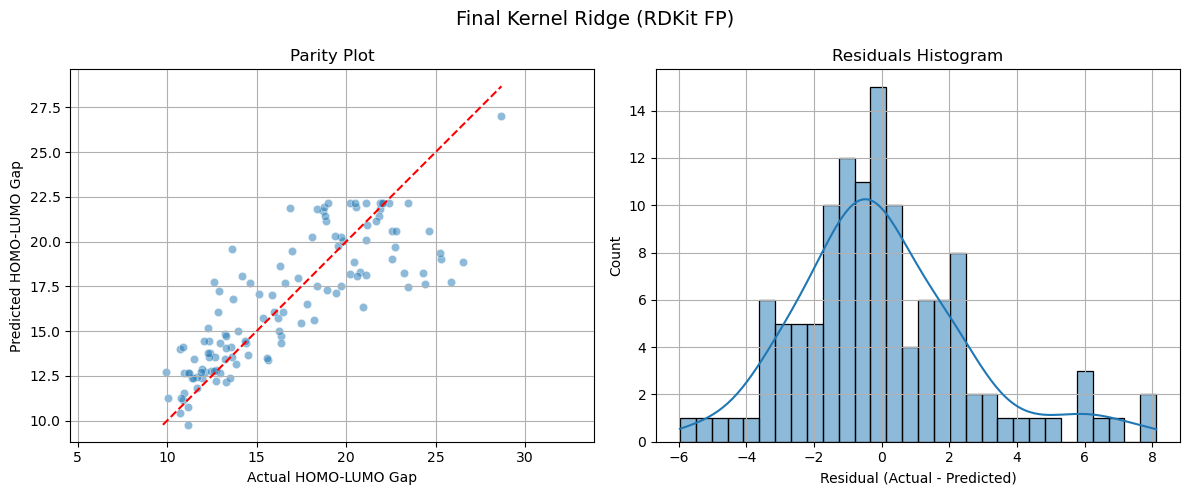

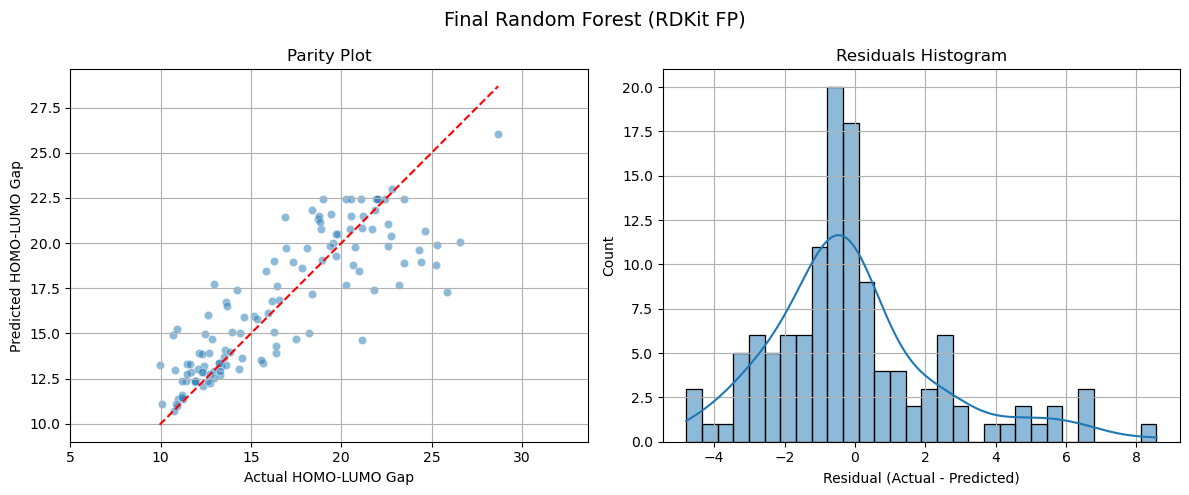

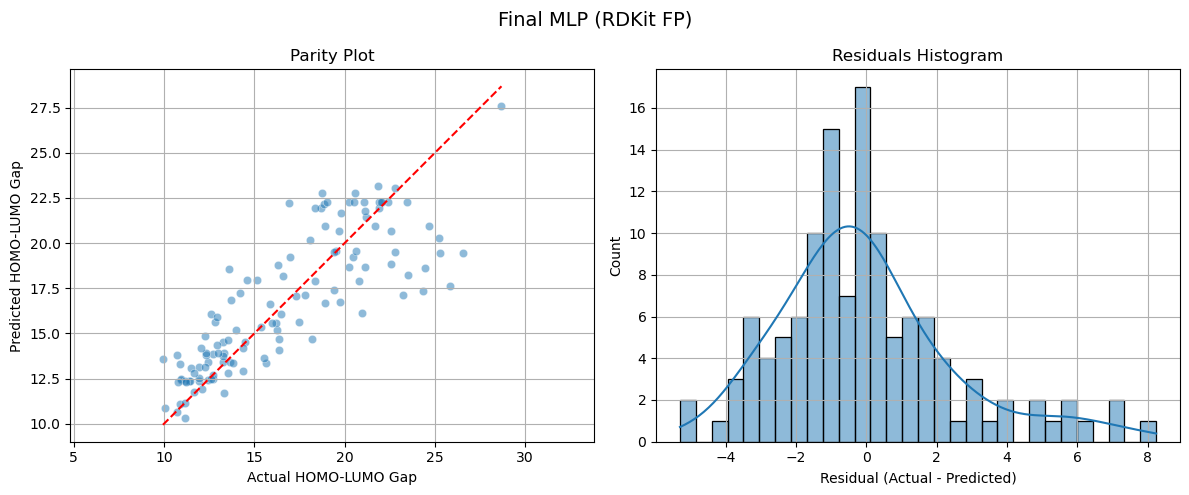

In [128]:
plot_regression_results(y_test_krr, final_preds_krr, title="Final Kernel Ridge (RDKit FP)", save_dir="plots")
plot_regression_results(y_test_unscaled, final_preds_rfr, title="Final Random Forest (RDKit FP)", save_dir="plots")
plot_regression_results(y_test_inv_fp, final_preds_inv_fp, title="Final MLP (RDKit FP)", save_dir="plots")
# plot_regression_results(y_test_inv_cm, final_preds_inv_cm, title="Final MLP (Coulomb Matrix)", save_dir="plots")


| Model Type             | Featurization        |   MAE |  RMSE |   R² | Notes             |
|------------------------|----------------------|-------|-------|------|-------------------|
| MLP (Tuned)          | RDKit Fingerprints   | 0.426 | 0.574 | 0.798 | Strong performance across all metrics   |
| KRR (Tuned)          | RDKit Fingerprints   | 0.454 | 0.593 | 0.784 | Good overall, slightly lower R² than MLP|
| RF (Tuned)           | RDKit Fingerprints   | 0.423| 0.583 | 0.791  | Top MAE, but slightly higher R²/RMSE    |
| MLP (Tuned)          | Coulomb Matrix       | 0.636 | 0.819 | 0.588 | Significantly worse than FP models      |
| MLP (Untuned Baseline) | RDKit Fingerprints | 0.467 | 0.609 | 0.772 | Reasonable baseline performance         |
| KRR (Untuned Baseline) | RDKit Fingerprints | 0.519 | 0.668 | 0.726 | Noticeable drop from tuned KRR          |
| RF (Untuned Baseline) | RDKit Fingerprints  | 0.426| 0.587 | 0.788  | Surprisingly strong untuned performance |
| MLP (Untuned Baseline) | Coulomb Matrix     | 0.663 | 0.847 | 0.559 | Confirms Coulomb Matrix as weak         |

Save best model and metrics

In [129]:
# create a save directory
os.makedirs("saved_models_Rg", exist_ok=True)

# save the final trained MLP model (Keras backend)
final_mlp_fp.model.save("saved_models_Rg/best_mlp_fp_model_keras")

# save the X and Y scalers
joblib.dump(xscaler_fp, "saved_models_Rg/xscaler_fp.pkl")
joblib.dump(yscaler, "saved_models_Rg/yscaler.pkl")

# save evaluation metrics
final_metrics_fp.to_csv("saved_models_Rg/best_mlp_fp_metrics.csv", index=False)

INFO:tensorflow:Assets written to: saved_models_Rg/best_mlp_fp_model_keras\assets


If you wanted to reload these later...

In [130]:
# from tensorflow.keras.models import load_model

# # load model and scalersand metrics
# mlp_model = load_model("saved_models/best_mlp_fp_model_keras")
# xscaler_fp = joblib.load("saved_models/xscaler_fp.pkl")
# yscaler = joblib.load("saved_models/yscaler.pkl")
# metrics_df = pd.read_csv("saved_models/best_mlp_fp_metrics.csv")

# Training a Baseline GNN with ChemML
ChemML's `tensorise_molecules` generates its own graph. Its important to note this graph is not the official graph from PCQM4Mv2. It may miss out on features OGB uses like formal charge, aromatacity flags, atomic chirality, and explicit hydrogens. However, tensorise_molecules is a good choice for quick prototyping and it handles graph generation and tensor formatting in a numpy-friendly way which was easier for me to understand. Final training will use smiles2graph for compatability with OGB splits and better feature representation. 

In [131]:
# tensorize molecules
X_atoms, X_bonds, X_edges = tensorise_molecules(valid_mol_objs)
y = df_clean['Rg'].values.reshape(-1, 1)

# train test split (80/20)
split = int(0.8 * len(y))
X_atoms_train, X_atoms_test = X_atoms[:split], X_atoms[split:]
X_bonds_train, X_bonds_test = X_bonds[:split], X_bonds[split:]
X_edges_train, X_edges_test = X_edges[:split], X_edges[split:]
y_train, y_test = y[:split], y[split:]

# scale target
yscaler = StandardScaler()
y_train_scaled = yscaler.fit_transform(y_train)

# model input shapes
max_atoms = X_atoms.shape[1]
max_degree = X_bonds.shape[2]
num_atom_features = X_atoms.shape[-1]
num_bond_features = X_bonds.shape[-1]

# input layers
atoms_input = Input(shape=(max_atoms, num_atom_features), name="atom_inputs")
bonds_input = Input(shape=(max_atoms, max_degree, num_bond_features), name="bond_inputs")
edges_input = Input(shape=(max_atoms, max_degree), name="edge_inputs", dtype="int32")

# GNN layers
conv1 = NeuralGraphHidden(8, activation='relu')([atoms_input, bonds_input, edges_input])
conv2 = NeuralGraphHidden(8, activation='relu')([conv1, bonds_input, edges_input])

fp1 = NeuralGraphOutput(128, activation='relu')([atoms_input, bonds_input, edges_input])
fp2 = NeuralGraphOutput(128, activation='relu')([conv1, bonds_input, edges_input])
fp3 = NeuralGraphOutput(128, activation='relu')([conv2, bonds_input, edges_input])

# fingerprint aggregation
fingerprint = Add()([fp1, fp2, fp3])

# dense layers
dense1 = Dense(128, activation='relu')(fingerprint)
dense2 = Dense(64, activation='relu')(dense1)
output = Dense(1, activation='linear')(dense2)

# model compilation
model = Model(inputs=[atoms_input, bonds_input, edges_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# model training
model.fit([X_atoms_train, X_bonds_train, X_edges_train], y_train_scaled, epochs=100, batch_size=64, verbose=1, validation_split=0.1)

# preds and eval
y_pred = model.predict([X_atoms_test, X_bonds_test, X_edges_test])
y_pred = yscaler.inverse_transform(y_pred)
metrics = regression_metrics(y_test, y_pred)
print("\nGNN Model Results:")
print(metrics[['MAE', 'RMSE', 'r_squared']])

Tensorising molecules in batches of 3000 ...
613/613 [==================================================] - 3s 6ms/step
Merging batch tensors ...    [DONE]
Epoch 1/100
7/7 [==============================] - 1s 79ms/step - loss: 1212.5925 - val_loss: 718.6636
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 166.0625 - val_loss: 171.6432
Epoch 3/100
7/7 [==============================] - 0s 9ms/step - loss: 106.5689 - val_loss: 7.2758
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 23.5615 - val_loss: 44.3803
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 12.9392 - val_loss: 11.7245
Epoch 6/100
7/7 [==============================] - 0s 10ms/step - loss: 8.5996 - val_loss: 1.5196
Epoch 7/100
7/7 [==============================] - 0s 9ms/step - loss: 3.2210 - val_loss: 4.3959
Epoch 8/100
7/7 [==============================] - 0s 8ms/step - loss: 1.8914 - val_loss: 2.7033
Epoch 9/100
7/7 [==============================] - 

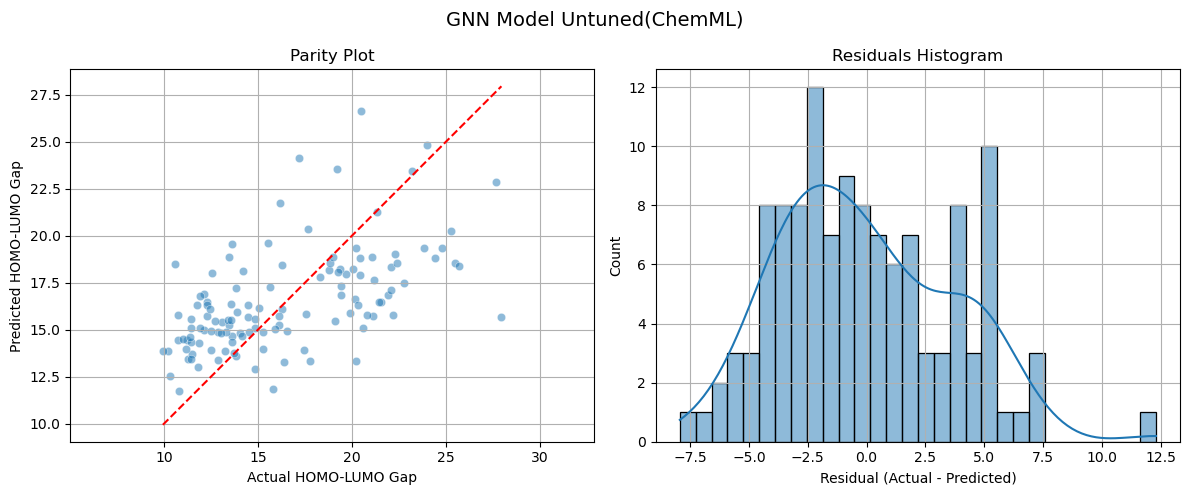

In [132]:
# plot results
plot_regression_results(y_test, y_pred, title="GNN Model Untuned(ChemML)", save_dir="plots")

In [133]:
from tensorflow.keras.metrics import MeanAbsoluteError

def objective_gnn(trial):
    conv_width = trial.suggest_categorical('conv_width', [8, 16, 32])
    fp_length = trial.suggest_categorical('fp_length', [96, 128, 160])
    n1 = trial.suggest_int('n1', 128, 192, step=32)
    n2 = trial.suggest_int('n2', 64, 96, step=32)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    alpha = trial.suggest_float('alpha', 1e-8, 1e-4, log=True)
    activation = 'relu'

    # model definition
    atoms_input = Input(shape=(max_atoms, num_atom_features), name="atom_inputs")
    bonds_input = Input(shape=(max_atoms, max_degree, num_bond_features), name="bond_inputs")
    edges_input = Input(shape=(max_atoms, max_degree), name="edge_inputs", dtype="int32")

    conv1 = NeuralGraphHidden(conv_width, activation=activation)([atoms_input, bonds_input, edges_input])
    conv2 = NeuralGraphHidden(conv_width, activation=activation)([conv1, bonds_input, edges_input])

    fp1 = NeuralGraphOutput(fp_length, activation=activation)([atoms_input, bonds_input, edges_input])
    fp2 = NeuralGraphOutput(fp_length, activation=activation)([conv1, bonds_input, edges_input])
    fp3 = NeuralGraphOutput(fp_length, activation=activation)([conv2, bonds_input, edges_input])
    fingerprint = Add()([fp1, fp2, fp3])

    dense1 = Dense(n1, activation=activation, kernel_regularizer=regularizers.l2(alpha))(fingerprint)
    dense2 = Dense(n2, activation=activation, kernel_regularizer=regularizers.l2(alpha))(dense1)
    output = Dense(1, activation='linear')(dense2)

    model = Model(inputs=[atoms_input, bonds_input, edges_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mean_squared_error', metrics=[MeanAbsoluteError()])

    history = model.fit([X_atoms_train, X_bonds_train, X_edges_train], y_train_scaled, epochs=100, batch_size=64, verbose=0, validation_split=0.2)

    # return best validation MAE
    val_mae = min(history.history["val_mean_absolute_error"])  
    return val_mae

study_gnn = optuna.create_study(direction='minimize')  
study_gnn.optimize(objective_gnn, n_trials=50)

[I 2025-09-04 21:09:27,411] A new study created in memory with name: no-name-d11d1ef8-cd4a-4151-a199-48bb3059a524
[I 2025-09-04 21:09:35,034] Trial 0 finished with value: 0.6815736889839172 and parameters: {'conv_width': 16, 'fp_length': 160, 'n1': 192, 'n2': 64, 'lr': 0.00443736565770757, 'alpha': 5.617342228935627e-07}. Best is trial 0 with value: 0.6815736889839172.
[I 2025-09-04 21:09:41,949] Trial 1 finished with value: 0.7887053489685059 and parameters: {'conv_width': 32, 'fp_length': 96, 'n1': 128, 'n2': 96, 'lr': 2.1221192660420185e-05, 'alpha': 2.6652848376141498e-06}. Best is trial 0 with value: 0.6815736889839172.
[I 2025-09-04 21:09:48,755] Trial 2 finished with value: 0.6089875102043152 and parameters: {'conv_width': 16, 'fp_length': 128, 'n1': 128, 'n2': 64, 'lr': 0.0009744279410292105, 'alpha': 2.6646951824271946e-05}. Best is trial 2 with value: 0.6089875102043152.
[I 2025-09-04 21:09:55,956] Trial 3 finished with value: 1.0359008312225342 and parameters: {'conv_width':

## Retraining ChemML GNN with Best Parameter Found in Optuna Search

In [134]:
params = study_gnn.best_params

# redefine and compile using best params
atoms_input = Input(shape=(max_atoms, num_atom_features), name="atom_inputs")
bonds_input = Input(shape=(max_atoms, max_degree, num_bond_features), name="bond_inputs")
edges_input = Input(shape=(max_atoms, max_degree), name="edge_inputs", dtype="int32")

conv1 = NeuralGraphHidden(params['conv_width'], activation='relu')([atoms_input, bonds_input, edges_input])
conv2 = NeuralGraphHidden(params['conv_width'], activation='relu')([conv1, bonds_input, edges_input])

fp1 = NeuralGraphOutput(params['fp_length'], activation='relu')([atoms_input, bonds_input, edges_input])
fp2 = NeuralGraphOutput(params['fp_length'],activation='relu')([conv1, bonds_input, edges_input])
fp3 = NeuralGraphOutput(params['fp_length'], activation='relu')([conv2, bonds_input, edges_input])
fingerprint = Add()([fp1, fp2, fp3])

dense1 = Dense(params['n1'], activation='relu', kernel_regularizer=regularizers.l2(params['alpha']))(fingerprint)
dense2 = Dense(params['n2'], activation='relu', kernel_regularizer=regularizers.l2(params['alpha']))(dense1)
output = Dense(1, activation='linear')(dense2)

final_gnn = Model(inputs=[atoms_input, bonds_input, edges_input], outputs=output)
final_gnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['lr']), loss='mean_squared_error')

final_gnn.fit([X_atoms_train, X_bonds_train, X_edges_train], y_train_scaled, epochs=200, batch_size=64, verbose=1)

# final eval
y_pred_final = final_gnn.predict([X_atoms_test, X_bonds_test, X_edges_test])
y_pred_final = yscaler.inverse_transform(y_pred_final)
final_metrics = regression_metrics(y_test, y_pred_final)
print("\nFinal Tuned GNN Results:")
print(final_metrics[['MAE', 'RMSE', 'r_squared']])

Epoch 1/200
8/8 [==============================] - 1s 24ms/step - loss: 230.2461
Epoch 2/200
8/8 [==============================] - 0s 5ms/step - loss: 48.4497
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 18.8996
Epoch 4/200
8/8 [==============================] - 0s 5ms/step - loss: 10.3738
Epoch 5/200
8/8 [==============================] - 0s 5ms/step - loss: 3.2484
Epoch 6/200
8/8 [==============================] - 0s 5ms/step - loss: 1.8585
Epoch 7/200
8/8 [==============================] - 0s 5ms/step - loss: 1.6595
Epoch 8/200
8/8 [==============================] - 0s 5ms/step - loss: 1.2595
Epoch 9/200
8/8 [==============================] - 0s 5ms/step - loss: 1.1501
Epoch 10/200
8/8 [==============================] - 0s 5ms/step - loss: 0.9684
Epoch 11/200
8/8 [==============================] - 0s 5ms/step - loss: 0.9382
Epoch 12/200
8/8 [==============================] - 0s 7ms/step - loss: 0.9229
Epoch 13/200
8/8 [==============================] - 0s 

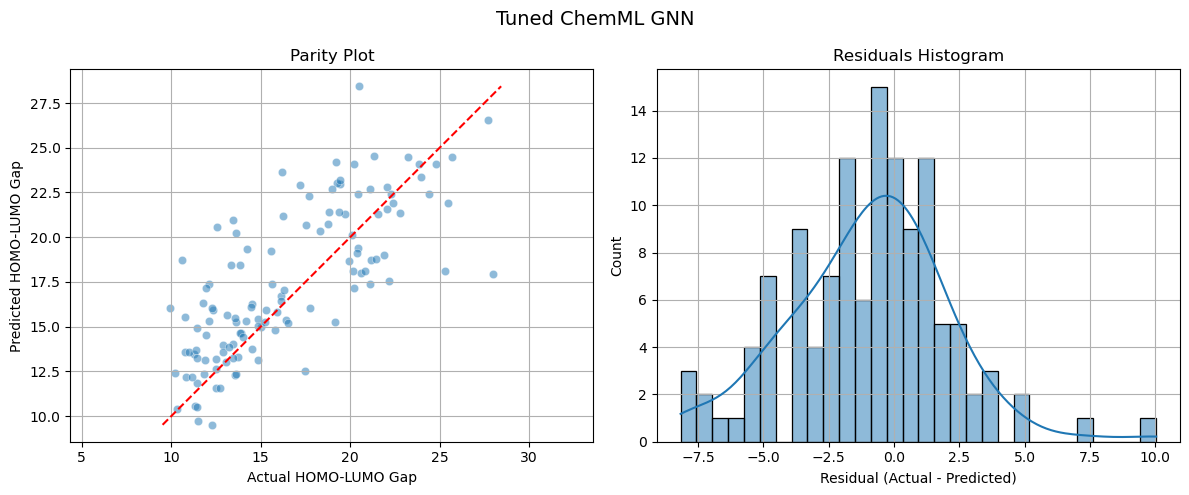

In [135]:
plot_regression_results(y_test, y_pred_final, title="Tuned ChemML GNN", save_dir="plots")

In [136]:
import json

# make a directory for this specific model
save_dir = "saved_models_Rg/gnn_tensorise_molecules_model"
os.makedirs(save_dir, exist_ok=True)

# 1. save the trained GNN model
final_gnn.save(os.path.join(save_dir, "gnn_tensorise_molecules_model_tf"), save_format="tf")

# 2. save the y target scaler
with open(os.path.join(save_dir, "gnn_tensorise_molecules_target_scaler.pkl"), "wb") as f:
    pickle.dump(yscaler, f)

# 3. save the final metrics
final_metrics.to_csv(os.path.join(save_dir, "gnn_tensorise_molecules_metrics.csv"), index=False)

# 4. save predictions
pred_df = pd.DataFrame({"true_gap": y_test.flatten(), "predicted_gap": y_pred_final.flatten()})
pred_df.to_csv(os.path.join(save_dir, "gnn_tensorise_molecules_predictions.csv"), index=False)

# 5. save the best hyperparameters
with open(os.path.join(save_dir, "gnn_tensorise_molecules_best_params.json"), "w") as f:
    json.dump(params, f, indent=4)

INFO:tensorflow:Assets written to: saved_models_Rg/gnn_tensorise_molecules_model\gnn_tensorise_molecules_model_tf\assets


## ChemML GNN Model Results
| Model Type             | Featurization        |   MAE |  RMSE |   R² | Notes             |
|------------------------|----------------------|-------|-------|------|-------------------|
| GNN (Tuned)            | tensorise_molecules Graph   | 0.302 | 0.411 | 0.900 | Best performance across all metrics   |
| GNN (Untuned)          | tensorise_molecules Graph   | 0.400 | 0.519 | 0.841 | Good overall|


---
# Final Model Training

Having explored different molecular graph representations and model architectures, I am now moving to training what is expected to be the best-performing model using the full dataset. The earlier GNN model was based on `tensorise_molecules` (ChemML) graphs and had strong performance with a **mean absolute error (MAE) around 0.30**. These graphs are based on RDKit's internal descriptors and do not reflect the original PCQM4Mv2 graph structure used in the Open Graph Benchmark (OGB). Therefore, I will shift focus to the `smiles2graph` representation provided by OGB, which aligns more directly with the benchmark's evaluation setup and top-performing models on the leaderboard.


| Source                         | Atom/Bond Features                                                 | Format                                          | Customizable?     | Alignment with PCQM4Mv2?  |
| ------------------------------ | ------------------------------------------------------------------ | ----------------------------------------------- | ----------------- | ---------------------- |
| `tensorise_molecules` (ChemML) | RDKit-based descriptors (ex: atom number, degree, hybridization) | NumPy tensors (`X_atoms`, `X_bonds`, `X_edges`) | Limited           |  Not aligned          |
| `smiles2graph` (OGB / PyG)     | Predefined categorical features from PCQM4Mv2                      | PyTorch Geometric `Data` objects                |  Highly flexible |  Matches OGB standard |

By using `smiles2graph`, we:

* Use OGB-standard graph construction and feature encoding for fair comparisons with leaderboard models
* Include learnable AtomEncoder and BondEncoder embeddings from `ogb.graphproppred.mol_encoder`, which improve model expressiveness
* Maintain compatibility with PyTorch Geometric, DGL, and OGB tools

I will also concatenate GNN-derived embeddings with SMILES-based RDKit descriptors, feeding this hybrid representation into MLP head. This allows you to combine structural and cheminformatics perspectives for improved prediction accuracy. With this setup, I aim to improve upon the MAE of \~0.30 achieved earlier and push closer toward state-of-the-art performance.


## Step 1: Load PyG-Compatible Dataset



In [137]:
def check_cuda():
    print("PyTorch version:", torch.__version__)
    print("CUDA available? ", torch.cuda.is_available())
    
    if torch.cuda.is_available():
        print("Device count:", torch.cuda.device_count())
        print("GPU Name:", torch.cuda.get_device_name(0))
        print("Current device:", torch.cuda.current_device())
    else:
        print("Running on CPU")

check_cuda()

PyTorch version: 2.4.1+cu118
CUDA available?  True
Device count: 1
GPU Name: NVIDIA GeForce RTX 3070 Ti
Current device: 0


In [138]:
# 1. load OGB dataset 
df_Rg = pd.read_csv('cleaned_Rg_dataset.csv')


#  Step 2: Extract SMILES from Original Dataset

In [139]:
# 2. Extract SMILES and FFV targets
# Your `df_ffv` already contains the SMILES and FFV columns.
smiles_list = df_Rg['SMILES'].tolist()
ffv_list = df_Rg['Rg'].tolist()

num_mols = len(smiles_list)
print(f"Loaded {num_mols} molecules.")

Loaded 613 molecules.


In [140]:
def compute_rdkit_features(smiles):
    cleaned_smiles = canonicalize_polymer_smiles(smiles)
    mol = Chem.MolFromSmiles(cleaned_smiles)
    if mol is None:
        return [np.nan] * 9  # Update the number of NaNs to match new features

    # Check for empty molecule
    if mol.GetNumAtoms() == 0:
        return [np.nan] * 9

    # Add features that capture size, shape, and interactions
    return [
        Descriptors.MolWt(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.RingCount(mol),
        Descriptors.FractionCSP3(mol),  # New: Fraction of sp3 hybridized carbons
        Descriptors.MolLogP(mol),      # New: Octanol-water partition coefficient
        Descriptors.NumSaturatedRings(mol) # New: Number of saturated rings
    ]

rdkit_features = np.array([compute_rdkit_features(smi) for smi in smiles_list])
print(f"Shape of RDKit features: {rdkit_features.shape}") # Should be (N, 9)

Shape of RDKit features: (613, 9)


In [141]:
# Remove rows with NaN values (failed RDKit featurization)
valid_indices = ~np.isnan(rdkit_features).any(axis=1)
rdkit_features = rdkit_features[valid_indices]
smiles_list = np.array(smiles_list)[valid_indices].tolist()
ffv_list = np.array(ffv_list)[valid_indices].tolist()

print(f"Kept {len(smiles_list)} molecules with valid RDKit features.")

Kept 613 molecules with valid RDKit features.


# Step 4: attach RDKit features to PyG data objects

In [142]:
import torch
from torch_geometric.data import Data, DataLoader

# Assuming your previous cells have loaded and processed the data into these lists:
# smiles_list: list of SMILES strings
# rdkit_features: numpy array of RDKit features (N, 6)
# ffv_list: list of FFV values (N,)

# 1. Create a list of PyG Data objects
rdkit_features_tensor = torch.tensor(rdkit_features, dtype=torch.float32)
ffv_targets_tensor = torch.tensor(ffv_list, dtype=torch.float32).view(-1, 1)

data_list = []
for i in range(len(smiles_list)):
    # smiles2graph returns a dictionary
    graph_dict = smiles2graph(smiles_list[i])
    
    # Create the Data object from the dictionary keys, converting to tensors
    # Convert node and edge features to LongTensor 
    data = Data(
        x=torch.tensor(graph_dict['node_feat'], dtype=torch.long),
        edge_index=torch.tensor(graph_dict['edge_index'], dtype=torch.long),
        edge_attr=torch.tensor(graph_dict['edge_feat'], dtype=torch.long),
        rdkit_feats=rdkit_features_tensor[i],
        y=ffv_targets_tensor[i]
    )
    data_list.append(data)

# 2. Split the dataset
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, random_state=42)

# 3. Create PyG DataLoaders
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

# 4. Verification
for batch in train_loader:
    print(batch)
    print("Batch's node features shape:", batch.x.shape)
    print("Batch's RDKit features shape:", batch.rdkit_feats.shape)
    print("Batch's targets shape:", batch.y.shape)
    print("Batch's 'batch' attribute shape:", batch.batch.shape)
    break

DataBatch(x=[644, 9], edge_index=[2, 1296], edge_attr=[1296, 3], y=[32], rdkit_feats=[288], batch=[644], ptr=[33])
Batch's node features shape: torch.Size([644, 9])
Batch's RDKit features shape: torch.Size([288])
Batch's targets shape: torch.Size([32])
Batch's 'batch' attribute shape: torch.Size([644])


c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead



## Step 5: Define the Hybrid GNN Model

The final architecture uses both structural and cheminformatics data by combining GNN-learned graph embeddings with SMILES-derived RDKit descriptors. This Hybrid GNN model uses `smiles2graph` for graph construction and augments it with RDKit-based molecular features for improved prediction accuracy.

### Model Components:

* **AtomEncoder / BondEncoder**
  Transforms categorical atom and bond features (provided by OGB) into learnable embeddings using the encoders from `ogb.graphproppred.mol_encoder`. These provide a strong foundation for expressive graph learning.

* **GINEConv Layers (x2)**
  I use two stacked GINEConv layers (Graph Isomorphism Network with Edge features). These layers perform neighborhood aggregation based on edge attributes, allowing the model to capture localized chemical environments.

* **Global Mean Pooling**
  After message passing, node level embeddings are aggregated into a fixed size graph level representation using `global_mean_pool`.

* **Concatenation with RDKit Descriptors**
  The pooled GNN embedding is concatenated with external RDKit descriptors, which capture global molecular properties not easily inferred from graph data alone.

* **MLP Prediction Head**
  A multilayer perceptron processes the combined feature vector with ReLU activations, dropout regularization, and linear layers to predict the HOMO–LUMO gap.

In [143]:
class HybridGNN(Module):
    def __init__(self, gnn_dim, rdkit_dim, hidden_dim, dropout_rate=0.2):
        super().__init__()
        self.gnn_dim = gnn_dim
        self.rdkit_dim = rdkit_dim

        self.atom_encoder = AtomEncoder(emb_dim=gnn_dim)
        self.bond_encoder = BondEncoder(emb_dim=gnn_dim)

        self.conv1 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), ReLU(), Linear(gnn_dim, gnn_dim)))
        self.conv2 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), ReLU(), Linear(gnn_dim, gnn_dim)))
        self.pool = global_mean_pool

        self.mlp = Sequential(Linear(gnn_dim + rdkit_dim, hidden_dim), ReLU(), 
                              Dropout(dropout_rate),
                              Linear(hidden_dim, hidden_dim // 2), ReLU(), 
                              Dropout(dropout_rate),
                              Linear(hidden_dim // 2, 1))

    def forward(self, data):
        # encode atoms and bonds
        x = self.atom_encoder(data.x)
        edge_attr = self.bond_encoder(data.edge_attr)

        # GNN convolutions
        x = self.conv1(x, data.edge_index, edge_attr)
        x = self.conv2(x, data.edge_index, edge_attr)
        x = self.pool(x, data.batch)

        # handle RDKit features
        rdkit_feats = getattr(data, 'rdkit_feats', None)
        if rdkit_feats is not None:
            # Reshape the RDKit features tensor to be (batch_size, rdkit_dim)
            # The number of samples in the batch is given by x.shape[0] after pooling
            reshaped_rdkit_feats = rdkit_feats.view(x.shape[0], self.rdkit_dim)
            
            # The check for shape mismatch is now more accurate
            if x.shape[0] != reshaped_rdkit_feats.shape[0]:
                raise ValueError(f"Shape mismatch: GNN output ({x.shape[0]}) vs rdkit_feats ({reshaped_rdkit_feats.shape[0]})")
            
            x = torch.cat([x, reshaped_rdkit_feats], dim=1)
        else:
            raise ValueError("RDKit features not found in the data object")

        return self.mlp(x)

# Step 7: training loop 

In [144]:
# initialize model
model = HybridGNN(gnn_dim=128, rdkit_dim=rdkit_features.shape[1], hidden_dim=256)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
best_val_loss = float('inf')
patience = 10
patience_counter = 0

def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            preds.append(pred.cpu())
            targets.append(batch.y.view(-1, 1).cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    loss = F.mse_loss(preds, targets)
    return loss.item(), preds, targets

# training loop
for epoch in range(1, 101): # long since early stopping
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch:02d}"):
        batch = batch.to(device)
        pred = model(batch)
        loss = F.mse_loss(pred, batch.y.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs

    train_loss = total_loss / len(train_loader.dataset)
    val_loss, val_preds, val_targets = evaluate(model, valid_loader)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        save_dir = "saved_models/gnn_smiles2graph_model"
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(save_dir, "hybridgnn_untuned.pt"))
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

# final eval on val set
model.load_state_dict(torch.load(os.path.join(save_dir, "hybridgnn_untuned.pt")))
model.eval()
_, final_preds, final_targets = evaluate(model, valid_loader)
metrics = regression_metrics(final_targets.numpy(), final_preds.numpy())
print("\nGNN Evaluation:")
print(metrics[['MAE', 'RMSE', 'r_squared']])

Epoch 01: 100%|██████████| 16/16 [00:00<00:00, 67.82it/s]


Epoch 01 | Train Loss: 101.0811 | Val Loss: 66.2718


Epoch 02: 100%|██████████| 16/16 [00:00<00:00, 139.64it/s]


Epoch 02 | Train Loss: 68.3164 | Val Loss: 40.7643


Epoch 03: 100%|██████████| 16/16 [00:00<00:00, 218.64it/s]


Epoch 03 | Train Loss: 42.5605 | Val Loss: 22.8594


Epoch 04: 100%|██████████| 16/16 [00:00<00:00, 170.51it/s]


Epoch 04 | Train Loss: 30.2962 | Val Loss: 20.8899


Epoch 05: 100%|██████████| 16/16 [00:00<00:00, 226.39it/s]


Epoch 05 | Train Loss: 24.8070 | Val Loss: 20.9678


Epoch 06: 100%|██████████| 16/16 [00:00<00:00, 232.92it/s]


Epoch 06 | Train Loss: 30.0150 | Val Loss: 22.0801


Epoch 07: 100%|██████████| 16/16 [00:00<00:00, 208.57it/s]


Epoch 07 | Train Loss: 27.5740 | Val Loss: 21.2447


Epoch 08: 100%|██████████| 16/16 [00:00<00:00, 210.36it/s]


Epoch 08 | Train Loss: 25.1097 | Val Loss: 21.9212


Epoch 09: 100%|██████████| 16/16 [00:00<00:00, 182.28it/s]


Epoch 09 | Train Loss: 25.4864 | Val Loss: 20.1976


Epoch 10: 100%|██████████| 16/16 [00:00<00:00, 225.93it/s]


Epoch 10 | Train Loss: 27.6539 | Val Loss: 18.9335


Epoch 11: 100%|██████████| 16/16 [00:00<00:00, 224.62it/s]


Epoch 11 | Train Loss: 22.5605 | Val Loss: 17.6137


Epoch 12: 100%|██████████| 16/16 [00:00<00:00, 204.31it/s]


Epoch 12 | Train Loss: 21.3973 | Val Loss: 16.3129


Epoch 13: 100%|██████████| 16/16 [00:00<00:00, 227.13it/s]

Epoch 13 | Train Loss: 21.6120 | Val Loss: 18.3926

Epoch 14: 100%|██████████| 16/16 [00:00<00:00, 180.59it/s]


Epoch 14 | Train Loss: 20.3974 | Val Loss: 15.1971


Epoch 15: 100%|██████████| 16/16 [00:00<00:00, 226.54it/s]


Epoch 15 | Train Loss: 20.3565 | Val Loss: 15.1256


Epoch 16: 100%|██████████| 16/16 [00:00<00:00, 222.43it/s]


Epoch 16 | Train Loss: 19.6178 | Val Loss: 17.8259


Epoch 17: 100%|██████████| 16/16 [00:00<00:00, 218.60it/s]


Epoch 17 | Train Loss: 18.9069 | Val Loss: 14.7946


Epoch 18: 100%|██████████| 16/16 [00:00<00:00, 222.58it/s]

Epoch 18 | Train Loss: 19.2337 | Val Loss: 14.6481

Epoch 19: 100%|██████████| 16/16 [00:00<00:00, 171.21it/s]


Epoch 19 | Train Loss: 19.9497 | Val Loss: 13.8760


Epoch 20: 100%|██████████| 16/16 [00:00<00:00, 217.15it/s]


Epoch 20 | Train Loss: 17.9302 | Val Loss: 14.0850


Epoch 21: 100%|██████████| 16/16 [00:00<00:00, 201.19it/s]


Epoch 21 | Train Loss: 18.0963 | Val Loss: 13.2694


Epoch 22: 100%|██████████| 16/16 [00:00<00:00, 210.70it/s]


Epoch 22 | Train Loss: 17.4319 | Val Loss: 12.9366


Epoch 23: 100%|██████████| 16/16 [00:00<00:00, 216.35it/s]


Epoch 23 | Train Loss: 18.2476 | Val Loss: 13.3825


Epoch 24: 100%|██████████| 16/16 [00:00<00:00, 173.41it/s]


Epoch 24 | Train Loss: 18.4804 | Val Loss: 14.5292


Epoch 25: 100%|██████████| 16/16 [00:00<00:00, 207.64it/s]


Epoch 25 | Train Loss: 15.6979 | Val Loss: 17.2945


Epoch 26: 100%|██████████| 16/16 [00:00<00:00, 204.82it/s]


Epoch 26 | Train Loss: 20.6087 | Val Loss: 13.2415


Epoch 27: 100%|██████████| 16/16 [00:00<00:00, 203.98it/s]


Epoch 27 | Train Loss: 18.5020 | Val Loss: 12.9054


Epoch 28: 100%|██████████| 16/16 [00:00<00:00, 212.92it/s]


Epoch 28 | Train Loss: 17.3079 | Val Loss: 14.4876


Epoch 29: 100%|██████████| 16/16 [00:00<00:00, 177.76it/s]


Epoch 29 | Train Loss: 21.5480 | Val Loss: 18.0015


Epoch 30: 100%|██████████| 16/16 [00:00<00:00, 205.30it/s]


Epoch 30 | Train Loss: 20.2565 | Val Loss: 13.0310


Epoch 31: 100%|██████████| 16/16 [00:00<00:00, 201.81it/s]


Epoch 31 | Train Loss: 18.6552 | Val Loss: 22.4951


Epoch 32: 100%|██████████| 16/16 [00:00<00:00, 209.13it/s]


Epoch 32 | Train Loss: 19.6733 | Val Loss: 18.5225


Epoch 33: 100%|██████████| 16/16 [00:00<00:00, 206.14it/s]


Epoch 33 | Train Loss: 18.0136 | Val Loss: 12.9991


Epoch 34: 100%|██████████| 16/16 [00:00<00:00, 173.60it/s]


Epoch 34 | Train Loss: 18.7336 | Val Loss: 15.5598


Epoch 35: 100%|██████████| 16/16 [00:00<00:00, 196.63it/s]


Epoch 35 | Train Loss: 17.4747 | Val Loss: 16.2807


Epoch 36: 100%|██████████| 16/16 [00:00<00:00, 202.09it/s]


Epoch 36 | Train Loss: 17.9633 | Val Loss: 14.0451


Epoch 37: 100%|██████████| 16/16 [00:00<00:00, 201.12it/s]


Epoch 37 | Train Loss: 16.6454 | Val Loss: 14.9464
Early stopping triggered at epoch 37

GNN Evaluation:
        MAE      RMSE  r_squared
0  2.868629  3.592413   0.369485


C:\Users\mattg\AppData\Local\Temp\ipykernel_16204\2343932047.py:57: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



# Step 8: Optuna tuning of Hybrid GNN

In [145]:
class HybridGNN(Module):
    def __init__(self, gnn_dim, rdkit_dim, hidden_dim, dropout_rate=0.2, activation='ReLU'):
        super().__init__()
        act_map = {'ReLU': torch.nn.ReLU(), 'ELU': torch.nn.ELU(), 'GELU': torch.nn.GELU(), 'LeakyReLU': torch.nn.LeakyReLU(), 'PReLU': torch.nn.PReLU(), 'Swish': torch.nn.SiLU()}
        act_fn = act_map[activation]
        self.gnn_dim = gnn_dim
        self.rdkit_dim = rdkit_dim

        self.atom_encoder = AtomEncoder(emb_dim=gnn_dim)
        self.bond_encoder = BondEncoder(emb_dim=gnn_dim)

        self.conv1 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), act_fn, Linear(gnn_dim, gnn_dim)))
        self.conv2 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), act_fn, Linear(gnn_dim, gnn_dim)))
        self.pool = global_mean_pool

        self.mlp = Sequential(Linear(gnn_dim + rdkit_dim, hidden_dim), act_fn, 
                              Dropout(dropout_rate), 
                              Linear(hidden_dim, hidden_dim // 2), act_fn, 
                              Dropout(dropout_rate), 
                              Linear(hidden_dim // 2, 1))

    def forward(self, data):
        # encode atoms and bonds
        x = self.atom_encoder(data.x)
        edge_attr = self.bond_encoder(data.edge_attr)

        # GNN convolutions
        x = self.conv1(x, data.edge_index, edge_attr)
        x = self.conv2(x, data.edge_index, edge_attr)
        x = self.pool(x, data.batch)

        # handle RDKit features
        rdkit_feats = getattr(data, 'rdkit_feats', None)
        if rdkit_feats is not None:
            # Reshape the RDKit features tensor to be (batch_size, rdkit_dim)
            # The number of samples in the batch is given by x.shape[0] after pooling
            reshaped_rdkit_feats = rdkit_feats.view(x.shape[0], self.rdkit_dim)
            
            # The check for shape mismatch is now more accurate
            if x.shape[0] != reshaped_rdkit_feats.shape[0]:
                raise ValueError(f"Shape mismatch: GNN output ({x.shape[0]}) vs rdkit_feats ({reshaped_rdkit_feats.shape[0]})")
            
            x = torch.cat([x, reshaped_rdkit_feats], dim=1)
        else:
            raise ValueError("RDKit features not found in the data object")

        return self.mlp(x)

Multiple rounds of tuning have suggested to refine my search space to ReLU, GELU, and Swish activation functions and Adam and AdamW optimizers. Therefore, I have commented out unused parameters like momentum for SGD and the unused optimizers. 

In [151]:
def objective(trial):
    # hyperparameter search space
    gnn_dim = trial.suggest_categorical("gnn_dim", [384, 512, 1024])
    hidden_dim = trial.suggest_categorical("hidden_dim", [256, 384, 512])
    dropout_rate = trial.suggest_float("dropout_rate", 0.25, 0.4)
    lr = trial.suggest_float("lr", 8e-6, 1e-3, log=True)
    activation = trial.suggest_categorical("activation", ['ReLU', 'GELU', 'Swish'])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD", "RMSprop"])
    momentum = trial.suggest_float("momentum", 0.8, 0.99, log=True) if optimizer_name == "SGD" else None
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    # Corrected Data Splitting for Polymer Data 
    # Split the full data_list into train, validation, and test sets.
    # Note: `data_list` should be created in a previous cell.
    train_val_set, test_set = train_test_split(data_list, test_size=0.2, random_state=42)
    train_set, val_set = train_test_split(train_val_set, test_size=0.25, random_state=42)
    
    train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
    valid_loader = DataLoader(val_set, batch_size=64)
    
    # model instantiation
    # The rdkit_dim is dynamically taken from the pre-processed features.
    model = HybridGNN(
        gnn_dim=gnn_dim,
        rdkit_dim=rdkit_features.shape[1],
        hidden_dim=hidden_dim,
        dropout_rate=dropout_rate,
        activation=activation
    )
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # optimizer instantiation
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Optimizer '{optimizer_name}' not supported")

    # training loop with NaN check and early stopping
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(1, 100):
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss = F.mse_loss(pred, batch.y.view(-1, 1))

            if torch.isnan(loss).any():
                print(f"Trial {trial.number} | Epoch {epoch:02d} | NaN loss detected so pruning trial")
                trial.report(float('inf'), epoch)
                raise optuna.TrialPruned()

            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch.num_graphs
        train_loss /= len(train_loader.dataset)

        # validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in valid_loader:
                batch = batch.to(device)
                pred = model(batch)
                val_loss += F.mse_loss(pred, batch.y.view(-1, 1)).item() * batch.num_graphs
        val_loss /= len(valid_loader.dataset)

        # logging, reporting, pruning, early stopping
        print(f"Trial {trial.number} | Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Optimizer: {optimizer_name}")
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Trial {trial.number} - Early stopping triggered at epoch {epoch}")
                break

    return best_val_loss

if __name__ == '__main__':
    study_name = "final_2d_gnn_study_Rg_2"
    storage_name = f"sqlite:///{study_name}.db"
    study = optuna.create_study(study_name=study_name, storage=storage_name, direction="minimize", pruner=optuna.pruners.MedianPruner())

    def save_study_callback(study, trial):
        pass

    study.optimize(objective, n_trials=500, callbacks=[save_study_callback])
    print(study.best_params)
    joblib.dump(study, f"{study_name}_final.pkl")
    
    # final plots
    vis = optuna.visualization
    fig = vis.plot_optimization_history(study)
    fig.show()
    fig_params = vis.plot_param_importances(study)
    fig_params.show()
    fig_intermediate = vis.plot_intermediate_values(study)
    fig_intermediate.show()
    fig_parallel_coordinate = vis.plot_parallel_coordinate(study)
    fig_parallel_coordinate.show()
    fig_slice = vis.plot_slice(study)
    fig_slice.show()

[I 2025-09-04 21:19:18,760] A new study created in RDB with name: final_2d_gnn_study_Rg_2
c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead

[I 2025-09-04 21:19:19,097] Trial 0 pruned. 


Trial 0 | Epoch 01 | NaN loss detected so pruning trial
Trial 1 | Epoch 01 | Train Loss: 228.6592 | Val Loss: 196.4705 | Optimizer: Adam
Trial 1 | Epoch 02 | Train Loss: 141.6233 | Val Loss: 110.6457 | Optimizer: Adam
Trial 1 | Epoch 03 | Train Loss: 75.5416 | Val Loss: 49.1656 | Optimizer: Adam
Trial 1 | Epoch 04 | Train Loss: 49.4620 | Val Loss: 46.6548 | Optimizer: Adam
Trial 1 | Epoch 05 | Train Loss: 62.5982 | Val Loss: 43.6512 | Optimizer: Adam
Trial 1 | Epoch 06 | Train Loss: 50.4084 | Val Loss: 50.7238 | Optimizer: Adam
Trial 1 | Epoch 07 | Train Loss: 51.5748 | Val Loss: 45.5888 | Optimizer: Adam
Trial 1 | Epoch 08 | Train Loss: 44.9642 | Val Loss: 35.3212 | Optimizer: Adam
Trial 1 | Epoch 09 | Train Loss: 40.4832 | Val Loss: 32.4114 | Optimizer: Adam
Trial 1 | Epoch 10 | Train Loss: 41.0902 | Val Loss: 34.0826 | Optimizer: Adam
Trial 1 | Epoch 11 | Train Loss: 37.9806 | Val Loss: 31.1625 | Optimizer: Adam
Trial 1 | Epoch 12 | Train Loss: 32.0278 | Val Loss: 27.5335 | Optimize

[I 2025-09-04 21:19:22,425] Trial 1 finished with value: 19.12524386925426 and parameters: {'gnn_dim': 384, 'hidden_dim': 256, 'dropout_rate': 0.32279148171296423, 'lr': 0.00016821076514418284, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 5.684834094844966e-06}. Best is trial 1 with value: 19.12524386925426.


Trial 1 | Epoch 62 | Train Loss: 19.7043 | Val Loss: 20.7203 | Optimizer: Adam
Trial 1 | Epoch 63 | Train Loss: 18.2053 | Val Loss: 20.7683 | Optimizer: Adam
Trial 1 | Epoch 64 | Train Loss: 20.1813 | Val Loss: 22.6451 | Optimizer: Adam
Trial 1 - Early stopping triggered at epoch 64
Trial 2 | Epoch 01 | Train Loss: 149.1598 | Val Loss: 80.8559 | Optimizer: SGD
Trial 2 | Epoch 02 | Train Loss: 79.6877 | Val Loss: 84.1163 | Optimizer: SGD
Trial 2 | Epoch 03 | Train Loss: 78.5675 | Val Loss: 70.5913 | Optimizer: SGD
Trial 2 | Epoch 04 | Train Loss: 71.6935 | Val Loss: 63.0041 | Optimizer: SGD
Trial 2 | Epoch 05 | Train Loss: 67.4446 | Val Loss: 69.2160 | Optimizer: SGD
Trial 2 | Epoch 06 | Train Loss: 67.5689 | Val Loss: 62.5684 | Optimizer: SGD
Trial 2 | Epoch 07 | Train Loss: 62.5012 | Val Loss: 65.3156 | Optimizer: SGD
Trial 2 | Epoch 08 | Train Loss: 59.0695 | Val Loss: 59.8691 | Optimizer: SGD
Trial 2 | Epoch 09 | Train Loss: 59.8590 | Val Loss: 65.4415 | Optimizer: SGD
Trial 2 | Epo

[I 2025-09-04 21:19:29,912] Trial 2 finished with value: 34.07929231287018 and parameters: {'gnn_dim': 1024, 'hidden_dim': 384, 'dropout_rate': 0.3452449144029921, 'lr': 2.483462588772003e-05, 'activation': 'Swish', 'optimizer': 'SGD', 'momentum': 0.8694991766438684, 'weight_decay': 1.3332403849718848e-05}. Best is trial 1 with value: 19.12524386925426.


Trial 2 | Epoch 97 | Train Loss: 36.2148 | Val Loss: 37.2463 | Optimizer: SGD
Trial 2 | Epoch 98 | Train Loss: 34.3155 | Val Loss: 34.0793 | Optimizer: SGD
Trial 2 | Epoch 99 | Train Loss: 35.2012 | Val Loss: 35.9620 | Optimizer: SGD
Trial 3 | Epoch 01 | Train Loss: 184.4119 | Val Loss: 63.2193 | Optimizer: SGD
Trial 3 | Epoch 02 | Train Loss: 79.9247 | Val Loss: 61.8296 | Optimizer: SGD
Trial 3 | Epoch 03 | Train Loss: 67.6615 | Val Loss: 71.5300 | Optimizer: SGD
Trial 3 | Epoch 04 | Train Loss: 67.9162 | Val Loss: 61.8442 | Optimizer: SGD
Trial 3 | Epoch 05 | Train Loss: 66.0469 | Val Loss: 64.2398 | Optimizer: SGD
Trial 3 | Epoch 06 | Train Loss: 65.9890 | Val Loss: 62.0930 | Optimizer: SGD
Trial 3 | Epoch 07 | Train Loss: 63.4742 | Val Loss: 60.7473 | Optimizer: SGD
Trial 3 | Epoch 08 | Train Loss: 63.7212 | Val Loss: 61.7962 | Optimizer: SGD
Trial 3 | Epoch 09 | Train Loss: 61.4864 | Val Loss: 60.7988 | Optimizer: SGD
Trial 3 | Epoch 10 | Train Loss: 66.9091 | Val Loss: 61.3965 | 

[I 2025-09-04 21:19:35,285] Trial 3 finished with value: 49.5200790777439 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.3138445295264759, 'lr': 9.416965155849704e-06, 'activation': 'Swish', 'optimizer': 'SGD', 'momentum': 0.8488845013853628, 'weight_decay': 4.787105377488972e-05}. Best is trial 1 with value: 19.12524386925426.


Trial 3 | Epoch 97 | Train Loss: 49.7374 | Val Loss: 49.5201 | Optimizer: SGD
Trial 3 | Epoch 98 | Train Loss: 53.0369 | Val Loss: 50.0268 | Optimizer: SGD
Trial 3 | Epoch 99 | Train Loss: 48.5025 | Val Loss: 49.5308 | Optimizer: SGD
Trial 4 | Epoch 01 | Train Loss: 274.8849 | Val Loss: 250.6067 | Optimizer: AdamW
Trial 4 | Epoch 02 | Train Loss: 203.9048 | Val Loss: 187.0994 | Optimizer: AdamW
Trial 4 | Epoch 03 | Train Loss: 155.2983 | Val Loss: 137.3567 | Optimizer: AdamW
Trial 4 | Epoch 04 | Train Loss: 113.0121 | Val Loss: 101.2755 | Optimizer: AdamW
Trial 4 | Epoch 05 | Train Loss: 86.2718 | Val Loss: 77.1391 | Optimizer: AdamW
Trial 4 | Epoch 06 | Train Loss: 70.0123 | Val Loss: 62.3693 | Optimizer: AdamW
Trial 4 | Epoch 07 | Train Loss: 59.9127 | Val Loss: 55.0801 | Optimizer: AdamW
Trial 4 | Epoch 08 | Train Loss: 60.0359 | Val Loss: 52.3142 | Optimizer: AdamW
Trial 4 | Epoch 09 | Train Loss: 60.3515 | Val Loss: 50.6155 | Optimizer: AdamW
Trial 4 | Epoch 10 | Train Loss: 59.82

[I 2025-09-04 21:19:39,364] Trial 4 finished with value: 21.228072864253345 and parameters: {'gnn_dim': 384, 'hidden_dim': 512, 'dropout_rate': 0.3576019968562552, 'lr': 4.529522026341851e-05, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 4.047981477928513e-06}. Best is trial 1 with value: 19.12524386925426.


Trial 4 | Epoch 78 | Train Loss: 21.8249 | Val Loss: 21.4467 | Optimizer: AdamW
Trial 4 | Epoch 79 | Train Loss: 23.0991 | Val Loss: 22.1380 | Optimizer: AdamW
Trial 4 - Early stopping triggered at epoch 79
Trial 5 | Epoch 01 | Train Loss: 274.1851 | Val Loss: 286.3472 | Optimizer: AdamW
Trial 5 | Epoch 02 | Train Loss: 262.1599 | Val Loss: 268.4985 | Optimizer: AdamW
Trial 5 | Epoch 03 | Train Loss: 242.7676 | Val Loss: 251.4922 | Optimizer: AdamW
Trial 5 | Epoch 04 | Train Loss: 229.7648 | Val Loss: 235.2606 | Optimizer: AdamW
Trial 5 | Epoch 05 | Train Loss: 213.3568 | Val Loss: 219.8172 | Optimizer: AdamW
Trial 5 | Epoch 06 | Train Loss: 205.8055 | Val Loss: 205.0578 | Optimizer: AdamW
Trial 5 | Epoch 07 | Train Loss: 179.5683 | Val Loss: 191.1358 | Optimizer: AdamW
Trial 5 | Epoch 08 | Train Loss: 171.5837 | Val Loss: 178.0267 | Optimizer: AdamW
Trial 5 | Epoch 09 | Train Loss: 162.2439 | Val Loss: 165.6020 | Optimizer: AdamW
Trial 5 | Epoch 10 | Train Loss: 153.4418 | Val Loss: 1

[I 2025-09-04 21:19:44,499] Trial 5 finished with value: 23.573560389076793 and parameters: {'gnn_dim': 384, 'hidden_dim': 384, 'dropout_rate': 0.32672051933279234, 'lr': 1.5108839485547171e-05, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 1.3791000051589796e-06}. Best is trial 1 with value: 19.12524386925426.


Trial 5 | Epoch 97 | Train Loss: 27.4146 | Val Loss: 23.8159 | Optimizer: AdamW
Trial 5 | Epoch 98 | Train Loss: 27.2269 | Val Loss: 23.6783 | Optimizer: AdamW
Trial 5 | Epoch 99 | Train Loss: 27.9951 | Val Loss: 23.5736 | Optimizer: AdamW


[I 2025-09-04 21:19:44,659] Trial 6 pruned. 


Trial 6 | Epoch 01 | Train Loss: 218.9954 | Val Loss: 195.2109 | Optimizer: RMSprop
Trial 6 | Epoch 02 | Train Loss: 159.5498 | Val Loss: 145.2901 | Optimizer: RMSprop
Trial 7 | Epoch 01 | Train Loss: 169597.3636 | Val Loss: 38450.7725 | Optimizer: RMSprop


[I 2025-09-04 21:19:44,806] Trial 7 pruned. 


Trial 8 | Epoch 01 | Train Loss: 146.1666 | Val Loss: 70.8574 | Optimizer: SGD
Trial 8 | Epoch 02 | Train Loss: 91.9746 | Val Loss: 63.2584 | Optimizer: SGD
Trial 8 | Epoch 03 | Train Loss: 78.7989 | Val Loss: 87.3274 | Optimizer: SGD
Trial 8 | Epoch 04 | Train Loss: 72.6391 | Val Loss: 62.0426 | Optimizer: SGD


[I 2025-09-04 21:19:45,261] Trial 8 pruned. 


Trial 8 | Epoch 05 | Train Loss: 65.3659 | Val Loss: 71.0057 | Optimizer: SGD
Trial 8 | Epoch 06 | Train Loss: 65.6558 | Val Loss: 61.8529 | Optimizer: SGD
Trial 8 | Epoch 07 | Train Loss: 61.0258 | Val Loss: 66.8584 | Optimizer: SGD
Trial 9 | Epoch 01 | Train Loss: 286.0283 | Val Loss: 312.5605 | Optimizer: Adam


[I 2025-09-04 21:19:45,363] Trial 9 pruned. 


Trial 10 | Epoch 01 | Train Loss: 247.0558 | Val Loss: 183.3896 | Optimizer: Adam
Trial 10 | Epoch 02 | Train Loss: 137.0077 | Val Loss: 91.8933 | Optimizer: Adam
Trial 10 | Epoch 03 | Train Loss: 65.4880 | Val Loss: 41.6377 | Optimizer: Adam
Trial 10 | Epoch 04 | Train Loss: 48.9357 | Val Loss: 45.9949 | Optimizer: Adam
Trial 10 | Epoch 05 | Train Loss: 50.7239 | Val Loss: 43.0677 | Optimizer: Adam
Trial 10 | Epoch 06 | Train Loss: 45.1726 | Val Loss: 43.3766 | Optimizer: Adam
Trial 10 | Epoch 07 | Train Loss: 42.3201 | Val Loss: 37.9757 | Optimizer: Adam
Trial 10 | Epoch 08 | Train Loss: 43.2476 | Val Loss: 33.6710 | Optimizer: Adam
Trial 10 | Epoch 09 | Train Loss: 36.8748 | Val Loss: 32.9591 | Optimizer: Adam
Trial 10 | Epoch 10 | Train Loss: 33.4974 | Val Loss: 29.8157 | Optimizer: Adam
Trial 10 | Epoch 11 | Train Loss: 33.3939 | Val Loss: 28.1789 | Optimizer: Adam
Trial 10 | Epoch 12 | Train Loss: 29.6911 | Val Loss: 28.5306 | Optimizer: Adam
Trial 10 | Epoch 13 | Train Loss: 28.

[I 2025-09-04 21:19:50,461] Trial 10 finished with value: 15.720193653571897 and parameters: {'gnn_dim': 384, 'hidden_dim': 256, 'dropout_rate': 0.2514117597604075, 'lr': 0.00019778176533884577, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 1.698272497464436e-06}. Best is trial 10 with value: 15.720193653571897.


Trial 10 | Epoch 96 | Train Loss: 14.7269 | Val Loss: 19.2345 | Optimizer: Adam
Trial 10 | Epoch 97 | Train Loss: 16.3123 | Val Loss: 15.7202 | Optimizer: Adam
Trial 10 | Epoch 98 | Train Loss: 15.9641 | Val Loss: 16.6215 | Optimizer: Adam
Trial 10 | Epoch 99 | Train Loss: 15.0904 | Val Loss: 19.3349 | Optimizer: Adam


[I 2025-09-04 21:19:50,574] Trial 11 pruned. 


Trial 11 | Epoch 01 | Train Loss: 273.4700 | Val Loss: 227.2870 | Optimizer: Adam
Trial 12 | Epoch 01 | Train Loss: 207.0187 | Val Loss: 157.1885 | Optimizer: Adam
Trial 12 | Epoch 02 | Train Loss: 118.3893 | Val Loss: 86.2426 | Optimizer: Adam
Trial 12 | Epoch 03 | Train Loss: 63.9547 | Val Loss: 43.2925 | Optimizer: Adam
Trial 12 | Epoch 04 | Train Loss: 48.6820 | Val Loss: 47.7400 | Optimizer: Adam
Trial 12 | Epoch 05 | Train Loss: 53.1459 | Val Loss: 43.1932 | Optimizer: Adam
Trial 12 | Epoch 06 | Train Loss: 46.1559 | Val Loss: 44.3746 | Optimizer: Adam
Trial 12 | Epoch 07 | Train Loss: 46.2907 | Val Loss: 39.5078 | Optimizer: Adam
Trial 12 | Epoch 08 | Train Loss: 40.3251 | Val Loss: 34.1796 | Optimizer: Adam
Trial 12 | Epoch 09 | Train Loss: 36.1865 | Val Loss: 32.2539 | Optimizer: Adam
Trial 12 | Epoch 10 | Train Loss: 32.8348 | Val Loss: 30.1334 | Optimizer: Adam
Trial 12 | Epoch 11 | Train Loss: 31.2848 | Val Loss: 28.0420 | Optimizer: Adam
Trial 12 | Epoch 12 | Train Loss: 3

[I 2025-09-04 21:19:55,200] Trial 12 finished with value: 16.18551901685513 and parameters: {'gnn_dim': 384, 'hidden_dim': 256, 'dropout_rate': 0.2513605709326827, 'lr': 0.0001794071563571159, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 2.494254836160617e-06}. Best is trial 10 with value: 15.720193653571897.


Trial 12 | Epoch 90 | Train Loss: 18.9459 | Val Loss: 16.9695 | Optimizer: Adam
Trial 12 - Early stopping triggered at epoch 90
Trial 13 | Epoch 01 | Train Loss: 184.8815 | Val Loss: 117.4734 | Optimizer: Adam
Trial 13 | Epoch 02 | Train Loss: 75.4655 | Val Loss: 45.8400 | Optimizer: Adam
Trial 13 | Epoch 03 | Train Loss: 55.6180 | Val Loss: 50.8444 | Optimizer: Adam
Trial 13 | Epoch 04 | Train Loss: 53.4380 | Val Loss: 49.5472 | Optimizer: Adam
Trial 13 | Epoch 05 | Train Loss: 52.4251 | Val Loss: 48.6252 | Optimizer: Adam
Trial 13 | Epoch 06 | Train Loss: 46.5366 | Val Loss: 37.0161 | Optimizer: Adam
Trial 13 | Epoch 07 | Train Loss: 38.1683 | Val Loss: 31.8221 | Optimizer: Adam
Trial 13 | Epoch 08 | Train Loss: 34.2547 | Val Loss: 32.7620 | Optimizer: Adam
Trial 13 | Epoch 09 | Train Loss: 28.7709 | Val Loss: 27.6866 | Optimizer: Adam
Trial 13 | Epoch 10 | Train Loss: 30.5502 | Val Loss: 32.3006 | Optimizer: Adam
Trial 13 | Epoch 11 | Train Loss: 27.3761 | Val Loss: 25.0522 | Optimi

[I 2025-09-04 21:19:58,121] Trial 13 finished with value: 16.268691442846283 and parameters: {'gnn_dim': 384, 'hidden_dim': 256, 'dropout_rate': 0.2539114663014676, 'lr': 0.00029119051158418147, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 2.3133401851093756e-06}. Best is trial 10 with value: 15.720193653571897.
[I 2025-09-04 21:19:58,233] Trial 14 pruned. 


Trial 13 - Early stopping triggered at epoch 57
Trial 14 | Epoch 01 | Train Loss: 245.0472 | Val Loss: 249.3150 | Optimizer: Adam
Trial 15 | Epoch 01 | Train Loss: 215.5168 | Val Loss: 108.8808 | Optimizer: Adam
Trial 15 | Epoch 02 | Train Loss: 67.2764 | Val Loss: 28.1131 | Optimizer: Adam
Trial 15 | Epoch 03 | Train Loss: 42.0054 | Val Loss: 57.2744 | Optimizer: Adam
Trial 15 | Epoch 04 | Train Loss: 43.8464 | Val Loss: 30.6711 | Optimizer: Adam
Trial 15 | Epoch 05 | Train Loss: 40.7647 | Val Loss: 30.4531 | Optimizer: Adam
Trial 15 | Epoch 06 | Train Loss: 36.3582 | Val Loss: 38.3880 | Optimizer: Adam
Trial 15 | Epoch 07 | Train Loss: 36.6181 | Val Loss: 27.9633 | Optimizer: Adam
Trial 15 | Epoch 08 | Train Loss: 29.4481 | Val Loss: 27.6787 | Optimizer: Adam
Trial 15 | Epoch 09 | Train Loss: 30.3460 | Val Loss: 27.4274 | Optimizer: Adam
Trial 15 | Epoch 10 | Train Loss: 27.6890 | Val Loss: 27.2128 | Optimizer: Adam
Trial 15 | Epoch 11 | Train Loss: 28.0304 | Val Loss: 24.8672 | Opti

[I 2025-09-04 21:20:03,548] Trial 15 finished with value: 16.11321484945654 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.27724349003807336, 'lr': 0.0002580131746406671, 'activation': 'ReLU', 'optimizer': 'Adam', 'weight_decay': 2.615960502236875e-06}. Best is trial 10 with value: 15.720193653571897.


Trial 15 | Epoch 64 | Train Loss: 17.5063 | Val Loss: 18.7457 | Optimizer: Adam
Trial 15 | Epoch 65 | Train Loss: 15.6140 | Val Loss: 16.5408 | Optimizer: Adam
Trial 15 - Early stopping triggered at epoch 65
Trial 16 | Epoch 01 | Train Loss: 150.9295 | Val Loss: 48.3758 | Optimizer: Adam
Trial 16 | Epoch 02 | Train Loss: 53.0746 | Val Loss: 52.2422 | Optimizer: Adam
Trial 16 | Epoch 03 | Train Loss: 42.8017 | Val Loss: 34.4713 | Optimizer: Adam
Trial 16 | Epoch 04 | Train Loss: 39.9177 | Val Loss: 36.1164 | Optimizer: Adam
Trial 16 | Epoch 05 | Train Loss: 36.6691 | Val Loss: 28.8663 | Optimizer: Adam
Trial 16 | Epoch 06 | Train Loss: 31.9182 | Val Loss: 30.3957 | Optimizer: Adam
Trial 16 | Epoch 07 | Train Loss: 31.1314 | Val Loss: 29.7971 | Optimizer: Adam
Trial 16 | Epoch 08 | Train Loss: 28.2577 | Val Loss: 25.6993 | Optimizer: Adam
Trial 16 | Epoch 09 | Train Loss: 28.1363 | Val Loss: 25.1343 | Optimizer: Adam
Trial 16 | Epoch 10 | Train Loss: 25.5245 | Val Loss: 31.8462 | Optimiz

[I 2025-09-04 21:20:06,382] Trial 16 finished with value: 17.036176603984057 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.2750336719354182, 'lr': 0.00038829019374009174, 'activation': 'ReLU', 'optimizer': 'Adam', 'weight_decay': 1.0260527049464841e-06}. Best is trial 10 with value: 15.720193653571897.


Trial 16 | Epoch 34 | Train Loss: 21.0741 | Val Loss: 24.9628 | Optimizer: Adam
Trial 16 | Epoch 35 | Train Loss: 20.5053 | Val Loss: 20.8151 | Optimizer: Adam
Trial 16 | Epoch 36 | Train Loss: 18.3694 | Val Loss: 17.7535 | Optimizer: Adam
Trial 16 - Early stopping triggered at epoch 36
Trial 17 | Epoch 01 | Train Loss: 210.9694 | Val Loss: 93.0766 | Optimizer: Adam
Trial 17 | Epoch 02 | Train Loss: 59.7888 | Val Loss: 30.9824 | Optimizer: Adam
Trial 17 | Epoch 03 | Train Loss: 41.1916 | Val Loss: 48.5540 | Optimizer: Adam
Trial 17 | Epoch 04 | Train Loss: 37.3296 | Val Loss: 29.7875 | Optimizer: Adam
Trial 17 | Epoch 05 | Train Loss: 34.8008 | Val Loss: 40.3234 | Optimizer: Adam
Trial 17 | Epoch 06 | Train Loss: 35.7716 | Val Loss: 26.7342 | Optimizer: Adam
Trial 17 | Epoch 07 | Train Loss: 29.8446 | Val Loss: 30.5115 | Optimizer: Adam
Trial 17 | Epoch 08 | Train Loss: 31.4780 | Val Loss: 25.2862 | Optimizer: Adam
Trial 17 | Epoch 09 | Train Loss: 29.0616 | Val Loss: 30.6298 | Optimiz

[I 2025-09-04 21:20:10,889] Trial 17 finished with value: 16.528479723426386 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.298421958322783, 'lr': 0.00028655500652053083, 'activation': 'ReLU', 'optimizer': 'Adam', 'weight_decay': 3.515884716355651e-06}. Best is trial 10 with value: 15.720193653571897.
[I 2025-09-04 21:20:11,046] Trial 18 pruned. 


Trial 17 | Epoch 58 | Train Loss: 16.8265 | Val Loss: 16.5670 | Optimizer: Adam
Trial 17 - Early stopping triggered at epoch 58
Trial 18 | Epoch 01 | Train Loss: 141771.2496 | Val Loss: 288.7286 | Optimizer: RMSprop


[I 2025-09-04 21:20:11,208] Trial 19 pruned. 


Trial 19 | Epoch 01 | Train Loss: 250.2019 | Val Loss: 209.1544 | Optimizer: AdamW
Trial 20 | Epoch 01 | Train Loss: 156.5231 | Val Loss: 107.9966 | Optimizer: Adam
Trial 20 | Epoch 02 | Train Loss: 86.0294 | Val Loss: 63.7121 | Optimizer: Adam
Trial 20 | Epoch 03 | Train Loss: 60.9684 | Val Loss: 45.3946 | Optimizer: Adam
Trial 20 | Epoch 04 | Train Loss: 63.0370 | Val Loss: 67.2261 | Optimizer: Adam
Trial 20 | Epoch 05 | Train Loss: 52.1695 | Val Loss: 39.8054 | Optimizer: Adam
Trial 20 | Epoch 06 | Train Loss: 44.0596 | Val Loss: 45.1396 | Optimizer: Adam
Trial 20 | Epoch 07 | Train Loss: 35.8604 | Val Loss: 29.4192 | Optimizer: Adam
Trial 20 | Epoch 08 | Train Loss: 35.1341 | Val Loss: 25.6319 | Optimizer: Adam
Trial 20 | Epoch 09 | Train Loss: 28.3035 | Val Loss: 26.4781 | Optimizer: Adam
Trial 20 | Epoch 10 | Train Loss: 28.7056 | Val Loss: 24.6301 | Optimizer: Adam
Trial 20 | Epoch 11 | Train Loss: 32.1531 | Val Loss: 51.3093 | Optimizer: Adam
Trial 20 | Epoch 12 | Train Loss: 3

[I 2025-09-04 21:20:14,206] Trial 20 finished with value: 15.11039302794914 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3966604263049831, 'lr': 0.0009734992713466208, 'activation': 'ReLU', 'optimizer': 'Adam', 'weight_decay': 8.868914988497863e-05}. Best is trial 20 with value: 15.11039302794914.


Trial 20 | Epoch 38 | Train Loss: 21.0437 | Val Loss: 16.7235 | Optimizer: Adam
Trial 20 - Early stopping triggered at epoch 38
Trial 21 | Epoch 01 | Train Loss: 151.8766 | Val Loss: 55.2069 | Optimizer: Adam


[I 2025-09-04 21:20:14,514] Trial 21 pruned. 


Trial 21 | Epoch 02 | Train Loss: 79.6528 | Val Loss: 87.0752 | Optimizer: Adam
Trial 21 | Epoch 03 | Train Loss: 67.8496 | Val Loss: 50.7941 | Optimizer: Adam


[I 2025-09-04 21:20:14,676] Trial 22 pruned. 


Trial 22 | Epoch 01 | Train Loss: 232.0043 | Val Loss: 145.0951 | Optimizer: Adam
Trial 23 | Epoch 01 | Train Loss: 170.7448 | Val Loss: 43.5436 | Optimizer: Adam
Trial 23 | Epoch 02 | Train Loss: 47.4616 | Val Loss: 37.1718 | Optimizer: Adam
Trial 23 | Epoch 03 | Train Loss: 40.7803 | Val Loss: 31.4256 | Optimizer: Adam
Trial 23 | Epoch 04 | Train Loss: 33.0563 | Val Loss: 27.4942 | Optimizer: Adam
Trial 23 | Epoch 05 | Train Loss: 35.1646 | Val Loss: 29.9875 | Optimizer: Adam
Trial 23 | Epoch 06 | Train Loss: 27.7564 | Val Loss: 24.4620 | Optimizer: Adam
Trial 23 | Epoch 07 | Train Loss: 31.8599 | Val Loss: 28.9126 | Optimizer: Adam
Trial 23 | Epoch 08 | Train Loss: 29.3441 | Val Loss: 29.6526 | Optimizer: Adam
Trial 23 | Epoch 09 | Train Loss: 29.3545 | Val Loss: 24.7704 | Optimizer: Adam
Trial 23 | Epoch 10 | Train Loss: 28.9124 | Val Loss: 26.8792 | Optimizer: Adam
Trial 23 | Epoch 11 | Train Loss: 29.2756 | Val Loss: 20.8372 | Optimizer: Adam
Trial 23 | Epoch 12 | Train Loss: 26.

[I 2025-09-04 21:20:19,881] Trial 23 finished with value: 15.67170184220725 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3996290969690424, 'lr': 0.00046646849425856896, 'activation': 'ReLU', 'optimizer': 'Adam', 'weight_decay': 6.989393781240468e-05}. Best is trial 20 with value: 15.11039302794914.


Trial 23 | Epoch 65 | Train Loss: 18.3151 | Val Loss: 22.8781 | Optimizer: Adam
Trial 23 | Epoch 66 | Train Loss: 20.3416 | Val Loss: 21.9417 | Optimizer: Adam
Trial 23 | Epoch 67 | Train Loss: 17.5090 | Val Loss: 18.4471 | Optimizer: Adam
Trial 23 - Early stopping triggered at epoch 67
Trial 24 | Epoch 01 | Train Loss: 187.7568 | Val Loss: 58.5602 | Optimizer: Adam
Trial 24 | Epoch 02 | Train Loss: 58.3102 | Val Loss: 71.3605 | Optimizer: Adam
Trial 24 | Epoch 03 | Train Loss: 52.4087 | Val Loss: 31.1949 | Optimizer: Adam
Trial 24 | Epoch 04 | Train Loss: 41.2979 | Val Loss: 40.9306 | Optimizer: Adam
Trial 24 | Epoch 05 | Train Loss: 40.6396 | Val Loss: 28.3293 | Optimizer: Adam
Trial 24 | Epoch 06 | Train Loss: 34.7973 | Val Loss: 37.7174 | Optimizer: Adam
Trial 24 | Epoch 07 | Train Loss: 32.4422 | Val Loss: 25.8110 | Optimizer: Adam
Trial 24 | Epoch 08 | Train Loss: 33.0730 | Val Loss: 38.9830 | Optimizer: Adam
Trial 24 | Epoch 09 | Train Loss: 37.6529 | Val Loss: 27.3764 | Optimiz

[I 2025-09-04 21:20:22,993] Trial 24 finished with value: 17.375625951503352 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3986804230594082, 'lr': 0.0004559478574456893, 'activation': 'ReLU', 'optimizer': 'Adam', 'weight_decay': 9.896011996506398e-05}. Best is trial 20 with value: 15.11039302794914.


Trial 24 | Epoch 37 | Train Loss: 21.7457 | Val Loss: 31.8053 | Optimizer: Adam
Trial 24 | Epoch 38 | Train Loss: 22.0312 | Val Loss: 22.3701 | Optimizer: Adam
Trial 24 | Epoch 39 | Train Loss: 21.0725 | Val Loss: 21.8283 | Optimizer: Adam
Trial 24 - Early stopping triggered at epoch 39


[I 2025-09-04 21:20:23,227] Trial 25 pruned. 


Trial 25 | Epoch 01 | Train Loss: 110.0236 | Val Loss: 59.3931 | Optimizer: Adam
Trial 25 | Epoch 02 | Train Loss: 66.7510 | Val Loss: 65.9796 | Optimizer: Adam
Trial 25 | Epoch 03 | Train Loss: 66.8485 | Val Loss: 63.1976 | Optimizer: Adam
Trial 26 | Epoch 01 | Train Loss: 179.8738 | Val Loss: 28.5037 | Optimizer: Adam
Trial 26 | Epoch 02 | Train Loss: 63.7639 | Val Loss: 77.2739 | Optimizer: Adam
Trial 26 | Epoch 03 | Train Loss: 56.8349 | Val Loss: 34.2865 | Optimizer: Adam
Trial 26 | Epoch 04 | Train Loss: 42.8062 | Val Loss: 48.3217 | Optimizer: Adam
Trial 26 | Epoch 05 | Train Loss: 42.5959 | Val Loss: 30.7419 | Optimizer: Adam
Trial 26 | Epoch 06 | Train Loss: 36.6251 | Val Loss: 31.0038 | Optimizer: Adam
Trial 26 | Epoch 07 | Train Loss: 33.7304 | Val Loss: 28.9952 | Optimizer: Adam
Trial 26 | Epoch 08 | Train Loss: 31.4536 | Val Loss: 29.2991 | Optimizer: Adam
Trial 26 | Epoch 09 | Train Loss: 31.1537 | Val Loss: 32.9029 | Optimizer: Adam
Trial 26 | Epoch 10 | Train Loss: 24.9

[I 2025-09-04 21:20:26,188] Trial 26 finished with value: 16.52663712385224 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.38380299543850616, 'lr': 0.0006533321327397485, 'activation': 'ReLU', 'optimizer': 'Adam', 'weight_decay': 3.196270937358899e-05}. Best is trial 20 with value: 15.11039302794914.


Trial 26 | Epoch 37 | Train Loss: 21.7466 | Val Loss: 17.9246 | Optimizer: Adam
Trial 26 - Early stopping triggered at epoch 37
Trial 27 | Epoch 01 | Train Loss: 162.6034 | Val Loss: 102.4386 | Optimizer: RMSprop


[I 2025-09-04 21:20:26,418] Trial 27 pruned. 
[I 2025-09-04 21:20:26,545] Trial 28 pruned. 


Trial 27 | Epoch 02 | Train Loss: 74.7008 | Val Loss: 71.9983 | Optimizer: RMSprop
Trial 28 | Epoch 01 | Train Loss: 225.6836 | Val Loss: 186.2428 | Optimizer: AdamW


[I 2025-09-04 21:20:26,687] Trial 29 pruned. 


Trial 29 | Epoch 01 | NaN loss detected so pruning trial
Trial 30 | Epoch 01 | Train Loss: 129.1090 | Val Loss: 65.2265 | Optimizer: Adam
Trial 30 | Epoch 02 | Train Loss: 73.0940 | Val Loss: 59.8544 | Optimizer: Adam


[I 2025-09-04 21:20:26,920] Trial 30 pruned. 


Trial 30 | Epoch 03 | Train Loss: 61.5751 | Val Loss: 60.5188 | Optimizer: Adam
Trial 31 | Epoch 01 | Train Loss: 196.6209 | Val Loss: 94.0556 | Optimizer: Adam
Trial 31 | Epoch 02 | Train Loss: 58.1615 | Val Loss: 29.3706 | Optimizer: Adam
Trial 31 | Epoch 03 | Train Loss: 43.5486 | Val Loss: 55.0450 | Optimizer: Adam
Trial 31 | Epoch 04 | Train Loss: 40.6175 | Val Loss: 30.8064 | Optimizer: Adam
Trial 31 | Epoch 05 | Train Loss: 41.9724 | Val Loss: 32.2782 | Optimizer: Adam
Trial 31 | Epoch 06 | Train Loss: 32.1232 | Val Loss: 30.9399 | Optimizer: Adam
Trial 31 | Epoch 07 | Train Loss: 32.3953 | Val Loss: 27.2317 | Optimizer: Adam
Trial 31 | Epoch 08 | Train Loss: 28.7937 | Val Loss: 28.8404 | Optimizer: Adam
Trial 31 | Epoch 09 | Train Loss: 28.2042 | Val Loss: 25.7299 | Optimizer: Adam
Trial 31 | Epoch 10 | Train Loss: 26.7179 | Val Loss: 26.3586 | Optimizer: Adam
Trial 31 | Epoch 11 | Train Loss: 25.5881 | Val Loss: 23.4915 | Optimizer: Adam
Trial 31 | Epoch 12 | Train Loss: 25.07

[I 2025-09-04 21:20:32,520] Trial 31 finished with value: 15.900944097255303 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.2620629079167512, 'lr': 0.0002736701533782797, 'activation': 'ReLU', 'optimizer': 'Adam', 'weight_decay': 2.9607970760683065e-06}. Best is trial 20 with value: 15.11039302794914.


Trial 31 | Epoch 71 | Train Loss: 16.0953 | Val Loss: 18.6126 | Optimizer: Adam
Trial 31 - Early stopping triggered at epoch 71
Trial 32 | Epoch 01 | Train Loss: 239.0486 | Val Loss: 189.8429 | Optimizer: Adam


[I 2025-09-04 21:20:32,680] Trial 32 pruned. 


Trial 33 | Epoch 01 | Train Loss: 157.1275 | Val Loss: 39.9228 | Optimizer: Adam
Trial 33 | Epoch 02 | Train Loss: 52.0598 | Val Loss: 58.9854 | Optimizer: Adam
Trial 33 | Epoch 03 | Train Loss: 46.5712 | Val Loss: 37.0002 | Optimizer: Adam
Trial 33 | Epoch 04 | Train Loss: 45.8569 | Val Loss: 47.8933 | Optimizer: Adam
Trial 33 | Epoch 05 | Train Loss: 41.8808 | Val Loss: 32.1600 | Optimizer: Adam
Trial 33 | Epoch 06 | Train Loss: 38.5223 | Val Loss: 42.7244 | Optimizer: Adam
Trial 33 | Epoch 07 | Train Loss: 38.1934 | Val Loss: 27.0490 | Optimizer: Adam
Trial 33 | Epoch 08 | Train Loss: 31.1919 | Val Loss: 25.8548 | Optimizer: Adam
Trial 33 | Epoch 09 | Train Loss: 30.6754 | Val Loss: 33.9047 | Optimizer: Adam
Trial 33 | Epoch 10 | Train Loss: 30.9533 | Val Loss: 27.4536 | Optimizer: Adam
Trial 33 | Epoch 11 | Train Loss: 30.1527 | Val Loss: 22.8286 | Optimizer: Adam
Trial 33 | Epoch 12 | Train Loss: 27.6951 | Val Loss: 23.5579 | Optimizer: Adam
Trial 33 | Epoch 13 | Train Loss: 32.73

[I 2025-09-04 21:20:36,579] Trial 33 finished with value: 16.987479923217276 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.39068129452156414, 'lr': 0.0005077854774388577, 'activation': 'ReLU', 'optimizer': 'Adam', 'weight_decay': 3.921292704647082e-06}. Best is trial 20 with value: 15.11039302794914.


Trial 33 | Epoch 49 | Train Loss: 20.5491 | Val Loss: 23.1204 | Optimizer: Adam
Trial 33 - Early stopping triggered at epoch 49
Trial 34 | Epoch 01 | Train Loss: 206.1800 | Val Loss: 135.8283 | Optimizer: Adam


[I 2025-09-04 21:20:36,738] Trial 34 pruned. 
[I 2025-09-04 21:20:36,907] Trial 35 pruned. 
[I 2025-09-04 21:20:37,022] Trial 36 pruned. 


Trial 35 | Epoch 01 | Train Loss: 573.4631 | Val Loss: 579.9077 | Optimizer: SGD
Trial 36 | Epoch 01 | Train Loss: 263.7311 | Val Loss: 195.5784 | Optimizer: Adam
Trial 37 | Epoch 01 | Train Loss: 186.5043 | Val Loss: 28.0680 | Optimizer: AdamW
Trial 37 | Epoch 02 | Train Loss: 71.9118 | Val Loss: 97.5959 | Optimizer: AdamW
Trial 37 | Epoch 03 | Train Loss: 72.8571 | Val Loss: 51.3706 | Optimizer: AdamW
Trial 37 | Epoch 04 | Train Loss: 57.5185 | Val Loss: 45.0795 | Optimizer: AdamW
Trial 37 | Epoch 05 | Train Loss: 47.3603 | Val Loss: 44.2947 | Optimizer: AdamW
Trial 37 | Epoch 06 | Train Loss: 40.5010 | Val Loss: 33.4287 | Optimizer: AdamW
Trial 37 | Epoch 07 | Train Loss: 37.4962 | Val Loss: 31.4688 | Optimizer: AdamW
Trial 37 | Epoch 08 | Train Loss: 31.8010 | Val Loss: 26.4916 | Optimizer: AdamW
Trial 37 | Epoch 09 | Train Loss: 28.3590 | Val Loss: 25.9172 | Optimizer: AdamW
Trial 37 | Epoch 10 | Train Loss: 27.4699 | Val Loss: 25.1531 | Optimizer: AdamW
Trial 37 | Epoch 11 | Trai

[I 2025-09-04 21:20:39,917] Trial 37 finished with value: 17.419660025495823 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3238815843153331, 'lr': 0.0006981973202746956, 'activation': 'ReLU', 'optimizer': 'AdamW', 'weight_decay': 1.2257465278792643e-05}. Best is trial 20 with value: 15.11039302794914.


Trial 37 | Epoch 34 | Train Loss: 18.7593 | Val Loss: 21.0187 | Optimizer: AdamW
Trial 37 | Epoch 35 | Train Loss: 21.9245 | Val Loss: 22.3650 | Optimizer: AdamW
Trial 37 | Epoch 36 | Train Loss: 21.8787 | Val Loss: 21.8996 | Optimizer: AdamW
Trial 37 - Early stopping triggered at epoch 36


[I 2025-09-04 21:20:40,033] Trial 38 pruned. 
[I 2025-09-04 21:20:40,152] Trial 39 pruned. 


Trial 38 | Epoch 01 | Train Loss: 222.3536 | Val Loss: 239.5982 | Optimizer: Adam
Trial 39 | Epoch 01 | Train Loss: 1000.9984 | Val Loss: 211.1967 | Optimizer: RMSprop


[I 2025-09-04 21:20:40,317] Trial 40 pruned. 


Trial 40 | Epoch 01 | Train Loss: 646.3350 | Val Loss: 311.7246 | Optimizer: SGD
Trial 41 | Epoch 01 | Train Loss: 257.3700 | Val Loss: 164.3759 | Optimizer: Adam


[I 2025-09-04 21:20:40,491] Trial 41 pruned. 
[I 2025-09-04 21:20:40,647] Trial 42 pruned. 
[I 2025-09-04 21:20:40,807] Trial 43 pruned. 


Trial 42 | Epoch 01 | Train Loss: 234.8081 | Val Loss: 159.1279 | Optimizer: Adam
Trial 43 | Epoch 01 | Train Loss: 227.3021 | Val Loss: 190.7773 | Optimizer: Adam


[I 2025-09-04 21:20:40,922] Trial 44 pruned. 
[I 2025-09-04 21:20:41,081] Trial 45 pruned. 


Trial 44 | Epoch 01 | Train Loss: 212.6539 | Val Loss: 211.2085 | Optimizer: Adam
Trial 45 | Epoch 01 | Train Loss: 227.3223 | Val Loss: 104.0438 | Optimizer: Adam


[I 2025-09-04 21:20:41,305] Trial 46 pruned. 


Trial 46 | Epoch 01 | Train Loss: 167.3507 | Val Loss: 64.4288 | Optimizer: Adam
Trial 46 | Epoch 02 | Train Loss: 61.7368 | Val Loss: 56.4745 | Optimizer: Adam
Trial 46 | Epoch 03 | Train Loss: 66.2571 | Val Loss: 58.7906 | Optimizer: Adam


[I 2025-09-04 21:20:41,465] Trial 47 pruned. 


Trial 47 | Epoch 01 | Train Loss: 261.6548 | Val Loss: 169.4645 | Optimizer: AdamW
Trial 48 | Epoch 01 | Train Loss: 153.6046 | Val Loss: 70.2958 | Optimizer: Adam
Trial 48 | Epoch 02 | Train Loss: 70.9349 | Val Loss: 59.8614 | Optimizer: Adam


[I 2025-09-04 21:20:41,686] Trial 48 pruned. 


Trial 48 | Epoch 03 | Train Loss: 62.2872 | Val Loss: 64.4376 | Optimizer: Adam
Trial 49 | Epoch 01 | Train Loss: 210.0227 | Val Loss: 62.6203 | Optimizer: RMSprop
Trial 49 | Epoch 02 | Train Loss: 37.0658 | Val Loss: 27.1638 | Optimizer: RMSprop
Trial 49 | Epoch 03 | Train Loss: 29.2888 | Val Loss: 26.1066 | Optimizer: RMSprop
Trial 49 | Epoch 04 | Train Loss: 36.8031 | Val Loss: 29.8190 | Optimizer: RMSprop
Trial 49 | Epoch 05 | Train Loss: 28.5236 | Val Loss: 23.9329 | Optimizer: RMSprop
Trial 49 | Epoch 06 | Train Loss: 30.5199 | Val Loss: 23.8062 | Optimizer: RMSprop
Trial 49 | Epoch 07 | Train Loss: 31.5308 | Val Loss: 24.1533 | Optimizer: RMSprop
Trial 49 | Epoch 08 | Train Loss: 30.1750 | Val Loss: 25.6002 | Optimizer: RMSprop
Trial 49 | Epoch 09 | Train Loss: 27.8116 | Val Loss: 23.6483 | Optimizer: RMSprop
Trial 49 | Epoch 10 | Train Loss: 28.7207 | Val Loss: 24.3877 | Optimizer: RMSprop
Trial 49 | Epoch 11 | Train Loss: 28.7909 | Val Loss: 23.2163 | Optimizer: RMSprop
Trial 

[I 2025-09-04 21:20:43,454] Trial 49 pruned. 


Trial 49 | Epoch 20 | Train Loss: 28.1441 | Val Loss: 23.8073 | Optimizer: RMSprop
Trial 49 | Epoch 21 | Train Loss: 28.0444 | Val Loss: 23.9061 | Optimizer: RMSprop
Trial 49 | Epoch 22 | Train Loss: 26.2504 | Val Loss: 23.9629 | Optimizer: RMSprop


[I 2025-09-04 21:20:43,682] Trial 50 pruned. 


Trial 50 | Epoch 01 | Train Loss: 119.5365 | Val Loss: 74.3058 | Optimizer: Adam
Trial 50 | Epoch 02 | Train Loss: 72.5576 | Val Loss: 60.7633 | Optimizer: Adam
Trial 50 | Epoch 03 | Train Loss: 60.6594 | Val Loss: 62.3225 | Optimizer: Adam
Trial 51 | Epoch 01 | Train Loss: 273.2917 | Val Loss: 229.1137 | Optimizer: Adam


[I 2025-09-04 21:20:43,798] Trial 51 pruned. 
[I 2025-09-04 21:20:43,918] Trial 52 pruned. 
[I 2025-09-04 21:20:44,032] Trial 53 pruned. 


Trial 52 | Epoch 01 | Train Loss: 297.1594 | Val Loss: 265.6977 | Optimizer: Adam
Trial 53 | Epoch 01 | Train Loss: 266.4954 | Val Loss: 253.8340 | Optimizer: Adam


[I 2025-09-04 21:20:44,147] Trial 54 pruned. 
[I 2025-09-04 21:20:44,305] Trial 55 pruned. 


Trial 54 | Epoch 01 | Train Loss: 268.1742 | Val Loss: 245.1352 | Optimizer: Adam
Trial 55 | Epoch 01 | Train Loss: 226.9038 | Val Loss: 168.1751 | Optimizer: Adam


c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\optuna\pruners\_percentile.py:21: RuntimeWarning:

All-NaN slice encountered

[I 2025-09-04 21:20:44,432] Trial 56 pruned. 
[I 2025-09-04 21:20:44,542] Trial 57 pruned. 


Trial 56 | Epoch 01 | Train Loss: inf | Val Loss: nan | Optimizer: SGD
Trial 57 | Epoch 01 | Train Loss: 254.1601 | Val Loss: 179.9642 | Optimizer: Adam
Trial 58 | Epoch 01 | Train Loss: 145.7810 | Val Loss: 52.0838 | Optimizer: Adam
Trial 58 | Epoch 02 | Train Loss: 56.4512 | Val Loss: 40.0670 | Optimizer: Adam
Trial 58 | Epoch 03 | Train Loss: 47.2528 | Val Loss: 49.0476 | Optimizer: Adam
Trial 58 | Epoch 04 | Train Loss: 44.4701 | Val Loss: 32.1448 | Optimizer: Adam
Trial 58 | Epoch 05 | Train Loss: 40.3243 | Val Loss: 29.6494 | Optimizer: Adam
Trial 58 | Epoch 06 | Train Loss: 30.6567 | Val Loss: 24.1510 | Optimizer: Adam
Trial 58 | Epoch 07 | Train Loss: 34.5664 | Val Loss: 22.4477 | Optimizer: Adam
Trial 58 | Epoch 08 | Train Loss: 31.0370 | Val Loss: 26.5104 | Optimizer: Adam
Trial 58 | Epoch 09 | Train Loss: 28.5141 | Val Loss: 20.9619 | Optimizer: Adam
Trial 58 | Epoch 10 | Train Loss: 26.4954 | Val Loss: 21.5620 | Optimizer: Adam
Trial 58 | Epoch 11 | Train Loss: 24.3994 | Va

[I 2025-09-04 21:20:46,578] Trial 58 finished with value: 18.378675825227567 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.37470298453969536, 'lr': 0.0007871754763646908, 'activation': 'GELU', 'optimizer': 'Adam', 'weight_decay': 1.8084526585737036e-06}. Best is trial 20 with value: 15.11039302794914.


Trial 58 | Epoch 25 | Train Loss: 22.2458 | Val Loss: 23.8179 | Optimizer: Adam
Trial 58 - Early stopping triggered at epoch 25
Trial 59 | Epoch 01 | Train Loss: 184.2040 | Val Loss: 51.5042 | Optimizer: Adam
Trial 59 | Epoch 02 | Train Loss: 48.8038 | Val Loss: 39.5984 | Optimizer: Adam
Trial 59 | Epoch 03 | Train Loss: 42.7482 | Val Loss: 37.5012 | Optimizer: Adam
Trial 59 | Epoch 04 | Train Loss: 35.8229 | Val Loss: 30.4593 | Optimizer: Adam
Trial 59 | Epoch 05 | Train Loss: 33.7292 | Val Loss: 35.5486 | Optimizer: Adam
Trial 59 | Epoch 06 | Train Loss: 32.1253 | Val Loss: 27.3873 | Optimizer: Adam
Trial 59 | Epoch 07 | Train Loss: 30.4307 | Val Loss: 29.6833 | Optimizer: Adam
Trial 59 | Epoch 08 | Train Loss: 28.9538 | Val Loss: 26.0670 | Optimizer: Adam
Trial 59 | Epoch 09 | Train Loss: 27.2371 | Val Loss: 24.0288 | Optimizer: Adam
Trial 59 | Epoch 10 | Train Loss: 26.6786 | Val Loss: 28.9673 | Optimizer: Adam
Trial 59 | Epoch 11 | Train Loss: 26.5368 | Val Loss: 25.0489 | Optimiz

[I 2025-09-04 21:20:50,859] Trial 59 finished with value: 15.858131369924157 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.2636706864969312, 'lr': 0.00029811082792742207, 'activation': 'ReLU', 'optimizer': 'Adam', 'weight_decay': 6.1920954181468565e-06}. Best is trial 20 with value: 15.11039302794914.


Trial 59 | Epoch 53 | Train Loss: 18.8586 | Val Loss: 19.3154 | Optimizer: Adam
Trial 59 | Epoch 54 | Train Loss: 17.2573 | Val Loss: 22.9176 | Optimizer: Adam
Trial 59 - Early stopping triggered at epoch 54
Trial 60 | Epoch 01 | Train Loss: 156.8249 | Val Loss: 36.6321 | Optimizer: AdamW
Trial 60 | Epoch 02 | Train Loss: 50.1597 | Val Loss: 69.0367 | Optimizer: AdamW
Trial 60 | Epoch 03 | Train Loss: 50.6689 | Val Loss: 33.2000 | Optimizer: AdamW
Trial 60 | Epoch 04 | Train Loss: 41.2126 | Val Loss: 38.7631 | Optimizer: AdamW
Trial 60 | Epoch 05 | Train Loss: 40.5594 | Val Loss: 32.7528 | Optimizer: AdamW
Trial 60 | Epoch 06 | Train Loss: 33.8385 | Val Loss: 28.7595 | Optimizer: AdamW
Trial 60 | Epoch 07 | Train Loss: 30.7852 | Val Loss: 29.2918 | Optimizer: AdamW
Trial 60 | Epoch 08 | Train Loss: 30.1680 | Val Loss: 24.8968 | Optimizer: AdamW
Trial 60 | Epoch 09 | Train Loss: 27.7019 | Val Loss: 32.0249 | Optimizer: AdamW
Trial 60 | Epoch 10 | Train Loss: 28.8552 | Val Loss: 26.6732 

[I 2025-09-04 21:20:57,273] Trial 60 finished with value: 15.320490627754026 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.275506892609232, 'lr': 0.0005061254008883885, 'activation': 'ReLU', 'optimizer': 'AdamW', 'weight_decay': 6.7314672712150585e-06}. Best is trial 20 with value: 15.11039302794914.


Trial 60 | Epoch 79 | Train Loss: 14.3495 | Val Loss: 16.3345 | Optimizer: AdamW
Trial 60 | Epoch 80 | Train Loss: 13.7951 | Val Loss: 16.5988 | Optimizer: AdamW
Trial 60 | Epoch 81 | Train Loss: 14.7564 | Val Loss: 19.3325 | Optimizer: AdamW
Trial 60 - Early stopping triggered at epoch 81
Trial 61 | Epoch 01 | Train Loss: 131.8097 | Val Loss: 36.0186 | Optimizer: AdamW
Trial 61 | Epoch 02 | Train Loss: 42.0684 | Val Loss: 42.3106 | Optimizer: AdamW
Trial 61 | Epoch 03 | Train Loss: 39.0496 | Val Loss: 32.3943 | Optimizer: AdamW
Trial 61 | Epoch 04 | Train Loss: 34.6284 | Val Loss: 32.4819 | Optimizer: AdamW
Trial 61 | Epoch 05 | Train Loss: 29.8951 | Val Loss: 29.0514 | Optimizer: AdamW
Trial 61 | Epoch 06 | Train Loss: 28.9215 | Val Loss: 24.8745 | Optimizer: AdamW
Trial 61 | Epoch 07 | Train Loss: 25.5082 | Val Loss: 25.6738 | Optimizer: AdamW
Trial 61 | Epoch 08 | Train Loss: 28.4450 | Val Loss: 28.5995 | Optimizer: AdamW
Trial 61 | Epoch 09 | Train Loss: 24.5440 | Val Loss: 27.208

[I 2025-09-04 21:21:01,091] Trial 61 finished with value: 16.054533741338467 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.2731898641278501, 'lr': 0.0004420920209902722, 'activation': 'ReLU', 'optimizer': 'AdamW', 'weight_decay': 6.455272411962794e-06}. Best is trial 20 with value: 15.11039302794914.


Trial 61 | Epoch 46 | Train Loss: 16.3559 | Val Loss: 16.1199 | Optimizer: AdamW
Trial 61 | Epoch 47 | Train Loss: 15.0684 | Val Loss: 17.1530 | Optimizer: AdamW
Trial 61 | Epoch 48 | Train Loss: 15.5725 | Val Loss: 17.1063 | Optimizer: AdamW
Trial 61 - Early stopping triggered at epoch 48


[I 2025-09-04 21:21:01,254] Trial 62 pruned. 


Trial 62 | Epoch 01 | Train Loss: 170.9785 | Val Loss: 97.1498 | Optimizer: AdamW
Trial 63 | Epoch 01 | Train Loss: 201.1270 | Val Loss: 40.5877 | Optimizer: AdamW
Trial 63 | Epoch 02 | Train Loss: 43.4794 | Val Loss: 44.6797 | Optimizer: AdamW
Trial 63 | Epoch 03 | Train Loss: 44.8997 | Val Loss: 35.8685 | Optimizer: AdamW
Trial 63 | Epoch 04 | Train Loss: 38.1210 | Val Loss: 31.0800 | Optimizer: AdamW
Trial 63 | Epoch 05 | Train Loss: 35.7543 | Val Loss: 33.4099 | Optimizer: AdamW
Trial 63 | Epoch 06 | Train Loss: 34.3574 | Val Loss: 28.0363 | Optimizer: AdamW
Trial 63 | Epoch 07 | Train Loss: 29.4065 | Val Loss: 28.1929 | Optimizer: AdamW
Trial 63 | Epoch 08 | Train Loss: 29.6467 | Val Loss: 25.4981 | Optimizer: AdamW
Trial 63 | Epoch 09 | Train Loss: 28.8449 | Val Loss: 29.1458 | Optimizer: AdamW
Trial 63 | Epoch 10 | Train Loss: 25.5184 | Val Loss: 26.7319 | Optimizer: AdamW
Trial 63 | Epoch 11 | Train Loss: 26.3061 | Val Loss: 23.0530 | Optimizer: AdamW
Trial 63 | Epoch 12 | Trai

[I 2025-09-04 21:21:06,564] Trial 63 finished with value: 15.147421030494256 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.27332450928665775, 'lr': 0.0003303636905644971, 'activation': 'ReLU', 'optimizer': 'AdamW', 'weight_decay': 6.332752365633072e-06}. Best is trial 20 with value: 15.11039302794914.
[I 2025-09-04 21:21:06,722] Trial 64 pruned. 
[I 2025-09-04 21:21:06,879] Trial 65 pruned. 


Trial 64 | Epoch 01 | Train Loss: 248.2933 | Val Loss: 118.0272 | Optimizer: AdamW
Trial 65 | Epoch 01 | Train Loss: 178.1236 | Val Loss: 105.8335 | Optimizer: AdamW
Trial 66 | Epoch 01 | Train Loss: 168.4305 | Val Loss: 35.0269 | Optimizer: AdamW
Trial 66 | Epoch 02 | Train Loss: 54.7502 | Val Loss: 80.5260 | Optimizer: AdamW
Trial 66 | Epoch 03 | Train Loss: 57.4351 | Val Loss: 36.5254 | Optimizer: AdamW
Trial 66 | Epoch 04 | Train Loss: 46.1229 | Val Loss: 36.0199 | Optimizer: AdamW
Trial 66 | Epoch 05 | Train Loss: 37.6554 | Val Loss: 36.5312 | Optimizer: AdamW
Trial 66 | Epoch 06 | Train Loss: 35.9207 | Val Loss: 29.8123 | Optimizer: AdamW
Trial 66 | Epoch 07 | Train Loss: 33.0258 | Val Loss: 26.7608 | Optimizer: AdamW
Trial 66 | Epoch 08 | Train Loss: 29.2045 | Val Loss: 31.2004 | Optimizer: AdamW
Trial 66 | Epoch 09 | Train Loss: 29.0482 | Val Loss: 27.3606 | Optimizer: AdamW


[I 2025-09-04 21:21:07,808] Trial 66 pruned. 


Trial 66 | Epoch 10 | Train Loss: 27.7467 | Val Loss: 26.1015 | Optimizer: AdamW
Trial 66 | Epoch 11 | Train Loss: 28.3099 | Val Loss: 31.3853 | Optimizer: AdamW
Trial 67 | Epoch 01 | Train Loss: 185.0785 | Val Loss: 41.0928 | Optimizer: AdamW
Trial 67 | Epoch 02 | Train Loss: 52.9312 | Val Loss: 49.4882 | Optimizer: AdamW
Trial 67 | Epoch 03 | Train Loss: 51.3445 | Val Loss: 55.6538 | Optimizer: AdamW


[I 2025-09-04 21:21:08,283] Trial 67 pruned. 


Trial 67 | Epoch 04 | Train Loss: 48.6332 | Val Loss: 38.1788 | Optimizer: AdamW
Trial 67 | Epoch 05 | Train Loss: 41.5884 | Val Loss: 36.9881 | Optimizer: AdamW
Trial 68 | Epoch 01 | Train Loss: 161.3407 | Val Loss: 37.4035 | Optimizer: AdamW
Trial 68 | Epoch 02 | Train Loss: 48.0859 | Val Loss: 45.4754 | Optimizer: AdamW
Trial 68 | Epoch 03 | Train Loss: 43.0292 | Val Loss: 45.4923 | Optimizer: AdamW
Trial 68 | Epoch 04 | Train Loss: 39.4671 | Val Loss: 31.0474 | Optimizer: AdamW
Trial 68 | Epoch 05 | Train Loss: 39.3100 | Val Loss: 30.9637 | Optimizer: AdamW
Trial 68 | Epoch 06 | Train Loss: 29.7381 | Val Loss: 32.3565 | Optimizer: AdamW


[I 2025-09-04 21:21:08,927] Trial 68 pruned. 
[I 2025-09-04 21:21:09,085] Trial 69 pruned. 


Trial 68 | Epoch 07 | Train Loss: 29.9879 | Val Loss: 35.7100 | Optimizer: AdamW
Trial 69 | Epoch 01 | Train Loss: 252.8328 | Val Loss: 272.7005 | Optimizer: AdamW


[I 2025-09-04 21:21:09,246] Trial 70 pruned. 


Trial 70 | Epoch 01 | Train Loss: 9425.3722 | Val Loss: 237.9570 | Optimizer: RMSprop
Trial 71 | Epoch 01 | Train Loss: 160.8722 | Val Loss: 104.1962 | Optimizer: AdamW


[I 2025-09-04 21:21:09,407] Trial 71 pruned. 
[I 2025-09-04 21:21:09,565] Trial 72 pruned. 
[I 2025-09-04 21:21:09,726] Trial 73 pruned. 


Trial 72 | Epoch 01 | Train Loss: 154.7349 | Val Loss: 69.4398 | Optimizer: AdamW
Trial 73 | Epoch 01 | Train Loss: 192.9506 | Val Loss: 72.5910 | Optimizer: AdamW


[I 2025-09-04 21:21:09,885] Trial 74 pruned. 


Trial 74 | Epoch 01 | Train Loss: 178.3029 | Val Loss: 123.8578 | Optimizer: AdamW
Trial 75 | Epoch 01 | Train Loss: 213.4518 | Val Loss: 47.8743 | Optimizer: AdamW


[I 2025-09-04 21:21:10,197] Trial 75 pruned. 


Trial 75 | Epoch 02 | Train Loss: 58.3538 | Val Loss: 55.2120 | Optimizer: AdamW
Trial 75 | Epoch 03 | Train Loss: 64.1059 | Val Loss: 61.5999 | Optimizer: AdamW
Trial 76 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-04 21:21:10,310] Trial 76 pruned. 
[I 2025-09-04 21:21:10,473] Trial 77 pruned. 
[I 2025-09-04 21:21:10,637] Trial 78 pruned. 


Trial 77 | Epoch 01 | Train Loss: 255.6563 | Val Loss: 201.8780 | Optimizer: AdamW
Trial 78 | Epoch 01 | Train Loss: 133.3046 | Val Loss: 65.4352 | Optimizer: Adam
Trial 79 | Epoch 01 | Train Loss: 180.3015 | Val Loss: 30.2208 | Optimizer: AdamW
Trial 79 | Epoch 02 | Train Loss: 55.3104 | Val Loss: 56.4470 | Optimizer: AdamW
Trial 79 | Epoch 03 | Train Loss: 51.9653 | Val Loss: 44.2759 | Optimizer: AdamW
Trial 79 | Epoch 04 | Train Loss: 40.5164 | Val Loss: 34.5981 | Optimizer: AdamW
Trial 79 | Epoch 05 | Train Loss: 37.5088 | Val Loss: 32.1304 | Optimizer: AdamW
Trial 79 | Epoch 06 | Train Loss: 32.4577 | Val Loss: 30.4563 | Optimizer: AdamW
Trial 79 | Epoch 07 | Train Loss: 31.0455 | Val Loss: 26.3948 | Optimizer: AdamW
Trial 79 | Epoch 08 | Train Loss: 28.9018 | Val Loss: 27.1890 | Optimizer: AdamW
Trial 79 | Epoch 09 | Train Loss: 26.2943 | Val Loss: 23.5005 | Optimizer: AdamW
Trial 79 | Epoch 10 | Train Loss: 24.4385 | Val Loss: 25.1471 | Optimizer: AdamW
Trial 79 | Epoch 11 | Tra

[I 2025-09-04 21:21:13,664] Trial 79 finished with value: 15.908379360912292 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.2615298760987676, 'lr': 0.00038716004266474186, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 4.141982647370079e-06}. Best is trial 20 with value: 15.11039302794914.


Trial 79 | Epoch 37 | Train Loss: 18.6119 | Val Loss: 16.8627 | Optimizer: AdamW
Trial 79 | Epoch 38 | Train Loss: 19.0228 | Val Loss: 16.1468 | Optimizer: AdamW
Trial 79 - Early stopping triggered at epoch 38


[I 2025-09-04 21:21:13,825] Trial 80 pruned. 


Trial 80 | Epoch 01 | Train Loss: 3509.7725 | Val Loss: 1816.3967 | Optimizer: RMSprop
Trial 81 | Epoch 01 | Train Loss: 227.6599 | Val Loss: 101.0581 | Optimizer: AdamW


[I 2025-09-04 21:21:13,983] Trial 81 pruned. 


Trial 82 | Epoch 01 | Train Loss: 148.2908 | Val Loss: 39.2145 | Optimizer: AdamW
Trial 82 | Epoch 02 | Train Loss: 44.5019 | Val Loss: 41.9379 | Optimizer: AdamW
Trial 82 | Epoch 03 | Train Loss: 39.6152 | Val Loss: 33.1098 | Optimizer: AdamW
Trial 82 | Epoch 04 | Train Loss: 36.2762 | Val Loss: 29.9684 | Optimizer: AdamW
Trial 82 | Epoch 05 | Train Loss: 34.5668 | Val Loss: 33.9590 | Optimizer: AdamW
Trial 82 | Epoch 06 | Train Loss: 29.8486 | Val Loss: 25.1143 | Optimizer: AdamW
Trial 82 | Epoch 07 | Train Loss: 28.5930 | Val Loss: 23.2319 | Optimizer: AdamW
Trial 82 | Epoch 08 | Train Loss: 26.6697 | Val Loss: 25.1886 | Optimizer: AdamW
Trial 82 | Epoch 09 | Train Loss: 24.6144 | Val Loss: 22.4929 | Optimizer: AdamW
Trial 82 | Epoch 10 | Train Loss: 24.1700 | Val Loss: 23.5216 | Optimizer: AdamW
Trial 82 | Epoch 11 | Train Loss: 25.8028 | Val Loss: 21.8905 | Optimizer: AdamW
Trial 82 | Epoch 12 | Train Loss: 22.7022 | Val Loss: 20.6286 | Optimizer: AdamW
Trial 82 | Epoch 13 | Train

[I 2025-09-04 21:21:21,818] Trial 82 finished with value: 9.134948959195517 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.26234125716523543, 'lr': 0.0005228448618646409, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 6.454206158060796e-06}. Best is trial 82 with value: 9.134948959195517.


Trial 83 | Epoch 01 | Train Loss: 169.3696 | Val Loss: 50.3736 | Optimizer: AdamW
Trial 83 | Epoch 02 | Train Loss: 45.2865 | Val Loss: 48.9522 | Optimizer: AdamW
Trial 83 | Epoch 03 | Train Loss: 40.9628 | Val Loss: 32.4917 | Optimizer: AdamW
Trial 83 | Epoch 04 | Train Loss: 36.6290 | Val Loss: 30.0906 | Optimizer: AdamW
Trial 83 | Epoch 05 | Train Loss: 32.7051 | Val Loss: 26.0420 | Optimizer: AdamW
Trial 83 | Epoch 06 | Train Loss: 28.7895 | Val Loss: 26.3123 | Optimizer: AdamW
Trial 83 | Epoch 07 | Train Loss: 26.9474 | Val Loss: 30.4404 | Optimizer: AdamW
Trial 83 | Epoch 08 | Train Loss: 23.1353 | Val Loss: 22.1437 | Optimizer: AdamW
Trial 83 | Epoch 09 | Train Loss: 26.3729 | Val Loss: 22.0646 | Optimizer: AdamW
Trial 83 | Epoch 10 | Train Loss: 26.2548 | Val Loss: 20.7778 | Optimizer: AdamW
Trial 83 | Epoch 11 | Train Loss: 27.9229 | Val Loss: 28.7953 | Optimizer: AdamW
Trial 83 | Epoch 12 | Train Loss: 24.9805 | Val Loss: 26.2400 | Optimizer: AdamW
Trial 83 | Epoch 13 | Train

[I 2025-09-04 21:21:28,611] Trial 83 finished with value: 11.503930750901137 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.26100251167272137, 'lr': 0.0005478646358976391, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 3.7468630112209242e-06}. Best is trial 82 with value: 9.134948959195517.


Trial 83 | Epoch 85 | Train Loss: 11.8612 | Val Loss: 14.0305 | Optimizer: AdamW
Trial 83 | Epoch 86 | Train Loss: 12.6439 | Val Loss: 16.7909 | Optimizer: AdamW
Trial 83 - Early stopping triggered at epoch 86
Trial 84 | Epoch 01 | Train Loss: 163.7402 | Val Loss: 31.4548 | Optimizer: AdamW
Trial 84 | Epoch 02 | Train Loss: 64.6759 | Val Loss: 80.6481 | Optimizer: AdamW
Trial 84 | Epoch 03 | Train Loss: 55.2822 | Val Loss: 36.0360 | Optimizer: AdamW
Trial 84 | Epoch 04 | Train Loss: 47.6673 | Val Loss: 42.7625 | Optimizer: AdamW
Trial 84 | Epoch 05 | Train Loss: 39.2079 | Val Loss: 31.0269 | Optimizer: AdamW
Trial 84 | Epoch 06 | Train Loss: 32.7077 | Val Loss: 30.2751 | Optimizer: AdamW
Trial 84 | Epoch 07 | Train Loss: 33.4928 | Val Loss: 25.8989 | Optimizer: AdamW
Trial 84 | Epoch 08 | Train Loss: 31.0209 | Val Loss: 24.2152 | Optimizer: AdamW
Trial 84 | Epoch 09 | Train Loss: 25.6006 | Val Loss: 22.1170 | Optimizer: AdamW
Trial 84 | Epoch 10 | Train Loss: 24.5478 | Val Loss: 25.905

[I 2025-09-04 21:21:34,341] Trial 84 finished with value: 10.371832537457225 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.2531696766329015, 'lr': 0.0006970885506031969, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 7.97796721138696e-06}. Best is trial 82 with value: 9.134948959195517.


Trial 84 | Epoch 73 | Train Loss: 11.6230 | Val Loss: 10.9385 | Optimizer: AdamW
Trial 84 - Early stopping triggered at epoch 73
Trial 85 | Epoch 01 | Train Loss: 129.6419 | Val Loss: 43.2600 | Optimizer: AdamW
Trial 85 | Epoch 02 | Train Loss: 54.7844 | Val Loss: 33.6137 | Optimizer: AdamW
Trial 85 | Epoch 03 | Train Loss: 40.9418 | Val Loss: 31.0005 | Optimizer: AdamW
Trial 85 | Epoch 04 | Train Loss: 39.1032 | Val Loss: 30.1974 | Optimizer: AdamW
Trial 85 | Epoch 05 | Train Loss: 34.9579 | Val Loss: 32.1652 | Optimizer: AdamW
Trial 85 | Epoch 06 | Train Loss: 29.4316 | Val Loss: 28.8439 | Optimizer: AdamW
Trial 85 | Epoch 07 | Train Loss: 31.8953 | Val Loss: 26.7901 | Optimizer: AdamW
Trial 85 | Epoch 08 | Train Loss: 32.0733 | Val Loss: 30.2535 | Optimizer: AdamW
Trial 85 | Epoch 09 | Train Loss: 27.1582 | Val Loss: 21.4511 | Optimizer: AdamW
Trial 85 | Epoch 10 | Train Loss: 26.3856 | Val Loss: 24.0496 | Optimizer: AdamW
Trial 85 | Epoch 11 | Train Loss: 24.6869 | Val Loss: 22.088

[I 2025-09-04 21:21:42,101] Trial 85 finished with value: 9.798203173691665 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3562465266073639, 'lr': 0.0007307017675073904, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 1.1164779854151833e-05}. Best is trial 82 with value: 9.134948959195517.


Trial 85 | Epoch 98 | Train Loss: 11.7633 | Val Loss: 12.7352 | Optimizer: AdamW
Trial 85 | Epoch 99 | Train Loss: 10.5598 | Val Loss: 12.6093 | Optimizer: AdamW
Trial 86 | Epoch 01 | Train Loss: 157.1962 | Val Loss: 47.0438 | Optimizer: AdamW
Trial 86 | Epoch 02 | Train Loss: 58.9489 | Val Loss: 64.9660 | Optimizer: AdamW
Trial 86 | Epoch 03 | Train Loss: 56.4697 | Val Loss: 50.6067 | Optimizer: AdamW


[I 2025-09-04 21:21:42,423] Trial 86 pruned. 
[I 2025-09-04 21:21:42,584] Trial 87 pruned. 


Trial 87 | Epoch 01 | Train Loss: 119.3954 | Val Loss: 61.0581 | Optimizer: AdamW
Trial 88 | Epoch 01 | Train Loss: 178.6160 | Val Loss: 43.6824 | Optimizer: AdamW
Trial 88 | Epoch 02 | Train Loss: 56.5591 | Val Loss: 48.1315 | Optimizer: AdamW


[I 2025-09-04 21:21:42,818] Trial 88 pruned. 


Trial 88 | Epoch 03 | Train Loss: 53.0638 | Val Loss: 57.5709 | Optimizer: AdamW
Trial 89 | Epoch 01 | Train Loss: 180.9608 | Val Loss: 34.5887 | Optimizer: AdamW
Trial 89 | Epoch 02 | Train Loss: 74.9696 | Val Loss: 96.6578 | Optimizer: AdamW
Trial 89 | Epoch 03 | Train Loss: 68.3565 | Val Loss: 44.0226 | Optimizer: AdamW
Trial 89 | Epoch 04 | Train Loss: 51.0021 | Val Loss: 39.7113 | Optimizer: AdamW


[I 2025-09-04 21:21:43,284] Trial 89 pruned. 


Trial 89 | Epoch 05 | Train Loss: 42.2570 | Val Loss: 35.6632 | Optimizer: AdamW
Trial 90 | Epoch 01 | Train Loss: 140.1836 | Val Loss: 46.6012 | Optimizer: AdamW


[I 2025-09-04 21:21:43,673] Trial 90 pruned. 


Trial 90 | Epoch 02 | Train Loss: 57.6166 | Val Loss: 55.2055 | Optimizer: AdamW
Trial 90 | Epoch 03 | Train Loss: 51.2644 | Val Loss: 42.4638 | Optimizer: AdamW
Trial 90 | Epoch 04 | Train Loss: 47.4102 | Val Loss: 40.5931 | Optimizer: AdamW


[I 2025-09-04 21:21:43,837] Trial 91 pruned. 
[I 2025-09-04 21:21:43,999] Trial 92 pruned. 


Trial 91 | Epoch 01 | Train Loss: 177.6171 | Val Loss: 132.4667 | Optimizer: AdamW
Trial 92 | Epoch 01 | Train Loss: 163.5586 | Val Loss: 108.9519 | Optimizer: AdamW
Trial 93 | Epoch 01 | Train Loss: 98.0070 | Val Loss: 49.2421 | Optimizer: AdamW
Trial 93 | Epoch 02 | Train Loss: 51.9288 | Val Loss: 41.0156 | Optimizer: AdamW
Trial 93 | Epoch 03 | Train Loss: 42.5453 | Val Loss: 35.4199 | Optimizer: AdamW
Trial 93 | Epoch 04 | Train Loss: 34.5022 | Val Loss: 31.9699 | Optimizer: AdamW
Trial 93 | Epoch 05 | Train Loss: 33.3279 | Val Loss: 24.4658 | Optimizer: AdamW
Trial 93 | Epoch 06 | Train Loss: 29.4703 | Val Loss: 23.3460 | Optimizer: AdamW
Trial 93 | Epoch 07 | Train Loss: 27.9113 | Val Loss: 31.9366 | Optimizer: AdamW
Trial 93 | Epoch 08 | Train Loss: 25.5762 | Val Loss: 26.8704 | Optimizer: AdamW
Trial 93 | Epoch 09 | Train Loss: 27.1130 | Val Loss: 20.6157 | Optimizer: AdamW
Trial 93 | Epoch 10 | Train Loss: 26.9425 | Val Loss: 20.7437 | Optimizer: AdamW
Trial 93 | Epoch 11 | Tr

[I 2025-09-04 21:21:46,940] Trial 93 finished with value: 15.266971277996776 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3934287640738944, 'lr': 0.0008572762567986945, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 5.892695867520759e-06}. Best is trial 82 with value: 9.134948959195517.


Trial 93 | Epoch 37 | Train Loss: 19.6433 | Val Loss: 20.7486 | Optimizer: AdamW
Trial 93 - Early stopping triggered at epoch 37
Trial 94 | Epoch 01 | Train Loss: 183.6409 | Val Loss: 50.1178 | Optimizer: AdamW
Trial 94 | Epoch 02 | Train Loss: 57.6372 | Val Loss: 36.2465 | Optimizer: AdamW
Trial 94 | Epoch 03 | Train Loss: 48.1787 | Val Loss: 40.5001 | Optimizer: AdamW
Trial 94 | Epoch 04 | Train Loss: 43.4662 | Val Loss: 35.8961 | Optimizer: AdamW
Trial 94 | Epoch 05 | Train Loss: 39.2320 | Val Loss: 26.5465 | Optimizer: AdamW
Trial 94 | Epoch 06 | Train Loss: 33.7017 | Val Loss: 30.2749 | Optimizer: AdamW
Trial 94 | Epoch 07 | Train Loss: 28.6428 | Val Loss: 31.8598 | Optimizer: AdamW
Trial 94 | Epoch 08 | Train Loss: 27.5094 | Val Loss: 21.2923 | Optimizer: AdamW
Trial 94 | Epoch 09 | Train Loss: 32.1972 | Val Loss: 22.1916 | Optimizer: AdamW
Trial 94 | Epoch 10 | Train Loss: 32.0723 | Val Loss: 31.4093 | Optimizer: AdamW
Trial 94 | Epoch 11 | Train Loss: 27.8789 | Val Loss: 35.099

[I 2025-09-04 21:21:49,403] Trial 94 finished with value: 16.736201464645262 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.39322284558999004, 'lr': 0.0008371586120191461, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 7.141185921307453e-06}. Best is trial 82 with value: 9.134948959195517.


Trial 94 | Epoch 29 | Train Loss: 29.6413 | Val Loss: 19.3201 | Optimizer: AdamW
Trial 94 | Epoch 30 | Train Loss: 26.7493 | Val Loss: 19.8417 | Optimizer: AdamW
Trial 94 | Epoch 31 | Train Loss: 22.9847 | Val Loss: 24.4475 | Optimizer: AdamW
Trial 94 - Early stopping triggered at epoch 31
Trial 95 | Epoch 01 | Train Loss: 142.1150 | Val Loss: 45.1308 | Optimizer: AdamW
Trial 95 | Epoch 02 | Train Loss: 49.3792 | Val Loss: 37.9205 | Optimizer: AdamW
Trial 95 | Epoch 03 | Train Loss: 49.2660 | Val Loss: 37.9552 | Optimizer: AdamW


[I 2025-09-04 21:21:49,880] Trial 95 pruned. 


Trial 95 | Epoch 04 | Train Loss: 42.6454 | Val Loss: 33.9786 | Optimizer: AdamW
Trial 95 | Epoch 05 | Train Loss: 34.0710 | Val Loss: 32.7431 | Optimizer: AdamW


[I 2025-09-04 21:21:50,042] Trial 96 pruned. 


Trial 96 | Epoch 01 | Train Loss: 135.4066 | Val Loss: 65.1487 | Optimizer: AdamW
Trial 97 | Epoch 01 | Train Loss: 169.8715 | Val Loss: 39.6440 | Optimizer: AdamW


[I 2025-09-04 21:21:50,433] Trial 97 pruned. 


Trial 97 | Epoch 02 | Train Loss: 60.9307 | Val Loss: 75.5482 | Optimizer: AdamW
Trial 97 | Epoch 03 | Train Loss: 61.9044 | Val Loss: 44.7905 | Optimizer: AdamW
Trial 97 | Epoch 04 | Train Loss: 55.2048 | Val Loss: 42.5676 | Optimizer: AdamW
Trial 98 | Epoch 01 | Train Loss: 149.4807 | Val Loss: 34.2524 | Optimizer: AdamW
Trial 98 | Epoch 02 | Train Loss: 61.0937 | Val Loss: 56.0364 | Optimizer: AdamW
Trial 98 | Epoch 03 | Train Loss: 54.2686 | Val Loss: 40.3878 | Optimizer: AdamW
Trial 98 | Epoch 04 | Train Loss: 46.1252 | Val Loss: 39.7049 | Optimizer: AdamW
Trial 98 | Epoch 05 | Train Loss: 37.9062 | Val Loss: 31.8806 | Optimizer: AdamW
Trial 98 | Epoch 06 | Train Loss: 36.0963 | Val Loss: 26.4676 | Optimizer: AdamW
Trial 98 | Epoch 07 | Train Loss: 30.3622 | Val Loss: 23.2762 | Optimizer: AdamW
Trial 98 | Epoch 08 | Train Loss: 32.9243 | Val Loss: 21.8674 | Optimizer: AdamW
Trial 98 | Epoch 09 | Train Loss: 32.0619 | Val Loss: 21.0767 | Optimizer: AdamW
Trial 98 | Epoch 10 | Train

[I 2025-09-04 21:21:54,486] Trial 98 finished with value: 12.814706848888862 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.38645954341635763, 'lr': 0.0006836145941956344, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 8.910044784234928e-05}. Best is trial 82 with value: 9.134948959195517.


Trial 98 | Epoch 52 | Train Loss: 17.9022 | Val Loss: 25.3849 | Optimizer: AdamW
Trial 98 - Early stopping triggered at epoch 52
Trial 99 | Epoch 01 | Train Loss: 115.8220 | Val Loss: 39.0184 | Optimizer: AdamW
Trial 99 | Epoch 02 | Train Loss: 44.6269 | Val Loss: 38.9975 | Optimizer: AdamW
Trial 99 | Epoch 03 | Train Loss: 40.4118 | Val Loss: 30.0289 | Optimizer: AdamW
Trial 99 | Epoch 04 | Train Loss: 36.6889 | Val Loss: 33.0315 | Optimizer: AdamW
Trial 99 | Epoch 05 | Train Loss: 34.0677 | Val Loss: 25.0535 | Optimizer: AdamW
Trial 99 | Epoch 06 | Train Loss: 31.2336 | Val Loss: 22.7645 | Optimizer: AdamW
Trial 99 | Epoch 07 | Train Loss: 31.0256 | Val Loss: 25.1620 | Optimizer: AdamW
Trial 99 | Epoch 08 | Train Loss: 32.7595 | Val Loss: 31.5075 | Optimizer: AdamW
Trial 99 | Epoch 09 | Train Loss: 29.5738 | Val Loss: 29.3829 | Optimizer: AdamW
Trial 99 | Epoch 10 | Train Loss: 26.6906 | Val Loss: 26.5542 | Optimizer: AdamW
Trial 99 | Epoch 11 | Train Loss: 26.3129 | Val Loss: 21.844

[I 2025-09-04 21:21:56,934] Trial 99 finished with value: 15.095547412469134 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3868917770803063, 'lr': 0.0009842844443434418, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 7.426758100569708e-05}. Best is trial 82 with value: 9.134948959195517.


Trial 99 | Epoch 29 | Train Loss: 21.4763 | Val Loss: 17.0949 | Optimizer: AdamW
Trial 99 | Epoch 30 | Train Loss: 22.4568 | Val Loss: 17.6422 | Optimizer: AdamW
Trial 99 | Epoch 31 | Train Loss: 23.3180 | Val Loss: 21.3688 | Optimizer: AdamW
Trial 99 - Early stopping triggered at epoch 31


[I 2025-09-04 21:21:57,090] Trial 100 pruned. 


Trial 100 | Epoch 01 | Train Loss: 180.3370 | Val Loss: 55.9579 | Optimizer: AdamW
Trial 101 | Epoch 01 | Train Loss: 198.8690 | Val Loss: 30.4688 | Optimizer: AdamW
Trial 101 | Epoch 02 | Train Loss: 57.1926 | Val Loss: 48.3953 | Optimizer: AdamW
Trial 101 | Epoch 03 | Train Loss: 40.5072 | Val Loss: 46.0790 | Optimizer: AdamW
Trial 101 | Epoch 04 | Train Loss: 45.6126 | Val Loss: 41.9727 | Optimizer: AdamW
Trial 101 | Epoch 05 | Train Loss: 35.7401 | Val Loss: 25.9797 | Optimizer: AdamW
Trial 101 | Epoch 06 | Train Loss: 34.1675 | Val Loss: 34.6878 | Optimizer: AdamW
Trial 101 | Epoch 07 | Train Loss: 35.1234 | Val Loss: 30.1160 | Optimizer: AdamW
Trial 101 | Epoch 08 | Train Loss: 33.9194 | Val Loss: 23.2422 | Optimizer: AdamW
Trial 101 | Epoch 09 | Train Loss: 31.5900 | Val Loss: 30.0194 | Optimizer: AdamW
Trial 101 | Epoch 10 | Train Loss: 27.0796 | Val Loss: 28.2202 | Optimizer: AdamW
Trial 101 | Epoch 11 | Train Loss: 32.7000 | Val Loss: 23.5542 | Optimizer: AdamW
Trial 101 | Ep

[I 2025-09-04 21:22:00,753] Trial 101 finished with value: 14.861772777588387 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.38493067355770816, 'lr': 0.0006715705678767695, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 7.731096998695225e-05}. Best is trial 82 with value: 9.134948959195517.


Trial 101 | Epoch 47 | Train Loss: 17.6288 | Val Loss: 19.8630 | Optimizer: AdamW
Trial 101 - Early stopping triggered at epoch 47
Trial 102 | Epoch 01 | Train Loss: 137.5554 | Val Loss: 38.7275 | Optimizer: AdamW
Trial 102 | Epoch 02 | Train Loss: 45.6631 | Val Loss: 36.8179 | Optimizer: AdamW
Trial 102 | Epoch 03 | Train Loss: 47.4178 | Val Loss: 37.0659 | Optimizer: AdamW
Trial 102 | Epoch 04 | Train Loss: 37.1132 | Val Loss: 37.0494 | Optimizer: AdamW
Trial 102 | Epoch 05 | Train Loss: 35.9153 | Val Loss: 25.9743 | Optimizer: AdamW
Trial 102 | Epoch 06 | Train Loss: 29.9621 | Val Loss: 23.5040 | Optimizer: AdamW
Trial 102 | Epoch 07 | Train Loss: 28.3440 | Val Loss: 29.4247 | Optimizer: AdamW
Trial 102 | Epoch 08 | Train Loss: 24.3649 | Val Loss: 23.0897 | Optimizer: AdamW
Trial 102 | Epoch 09 | Train Loss: 30.4625 | Val Loss: 21.3942 | Optimizer: AdamW
Trial 102 | Epoch 10 | Train Loss: 25.8297 | Val Loss: 27.7834 | Optimizer: AdamW
Trial 102 | Epoch 11 | Train Loss: 27.3806 | Val

[I 2025-09-04 21:22:05,361] Trial 102 finished with value: 13.01377438335884 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.37747008134327, 'lr': 0.0006815932289247624, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 8.028786810548833e-05}. Best is trial 82 with value: 9.134948959195517.


Trial 102 | Epoch 59 | Train Loss: 16.8953 | Val Loss: 16.7721 | Optimizer: AdamW
Trial 102 - Early stopping triggered at epoch 59
Trial 103 | Epoch 01 | Train Loss: 117.6584 | Val Loss: 60.9265 | Optimizer: AdamW


[I 2025-09-04 21:22:05,520] Trial 103 pruned. 
[I 2025-09-04 21:22:05,678] Trial 104 pruned. 


Trial 104 | Epoch 01 | Train Loss: 159.2478 | Val Loss: 51.4149 | Optimizer: AdamW
Trial 105 | Epoch 01 | Train Loss: 146.5925 | Val Loss: 31.1003 | Optimizer: AdamW
Trial 105 | Epoch 02 | Train Loss: 50.9435 | Val Loss: 48.2821 | Optimizer: AdamW
Trial 105 | Epoch 03 | Train Loss: 50.4290 | Val Loss: 44.0514 | Optimizer: AdamW
Trial 105 | Epoch 04 | Train Loss: 41.9756 | Val Loss: 32.3137 | Optimizer: AdamW
Trial 105 | Epoch 05 | Train Loss: 37.1507 | Val Loss: 26.6303 | Optimizer: AdamW
Trial 105 | Epoch 06 | Train Loss: 33.1510 | Val Loss: 32.0457 | Optimizer: AdamW
Trial 105 | Epoch 07 | Train Loss: 31.5087 | Val Loss: 35.9916 | Optimizer: AdamW
Trial 105 | Epoch 08 | Train Loss: 28.6375 | Val Loss: 21.8391 | Optimizer: AdamW
Trial 105 | Epoch 09 | Train Loss: 27.4640 | Val Loss: 21.7387 | Optimizer: AdamW
Trial 105 | Epoch 10 | Train Loss: 32.0137 | Val Loss: 35.4576 | Optimizer: AdamW
Trial 105 | Epoch 11 | Train Loss: 28.7622 | Val Loss: 25.4296 | Optimizer: AdamW
Trial 105 | Ep

[I 2025-09-04 21:22:12,470] Trial 105 finished with value: 10.456899410340844 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.38400594715175823, 'lr': 0.0006942532388223274, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 7.746962586906582e-05}. Best is trial 82 with value: 9.134948959195517.


Trial 106 | Epoch 01 | Train Loss: 141.6016 | Val Loss: 43.4449 | Optimizer: AdamW
Trial 106 | Epoch 02 | Train Loss: 50.5416 | Val Loss: 53.9036 | Optimizer: AdamW
Trial 106 | Epoch 03 | Train Loss: 51.2343 | Val Loss: 39.6859 | Optimizer: AdamW
Trial 106 | Epoch 04 | Train Loss: 44.8838 | Val Loss: 29.3395 | Optimizer: AdamW
Trial 106 | Epoch 05 | Train Loss: 35.6374 | Val Loss: 26.7132 | Optimizer: AdamW
Trial 106 | Epoch 06 | Train Loss: 30.5417 | Val Loss: 25.0260 | Optimizer: AdamW
Trial 106 | Epoch 07 | Train Loss: 29.2589 | Val Loss: 28.7618 | Optimizer: AdamW
Trial 106 | Epoch 08 | Train Loss: 26.3988 | Val Loss: 28.3870 | Optimizer: AdamW
Trial 106 | Epoch 09 | Train Loss: 27.1232 | Val Loss: 24.5513 | Optimizer: AdamW
Trial 106 | Epoch 10 | Train Loss: 28.3613 | Val Loss: 32.5901 | Optimizer: AdamW
Trial 106 | Epoch 11 | Train Loss: 25.9164 | Val Loss: 26.1036 | Optimizer: AdamW
Trial 106 | Epoch 12 | Train Loss: 24.7114 | Val Loss: 23.0478 | Optimizer: AdamW
Trial 106 | Epo

[I 2025-09-04 21:22:15,145] Trial 106 finished with value: 15.308860716780996 and parameters: {'gnn_dim': 1024, 'hidden_dim': 384, 'dropout_rate': 0.38523942467790323, 'lr': 0.0006846229917331851, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 7.367672970630745e-05}. Best is trial 82 with value: 9.134948959195517.


Trial 106 | Epoch 34 | Train Loss: 17.0096 | Val Loss: 19.5949 | Optimizer: AdamW
Trial 106 - Early stopping triggered at epoch 34
Trial 107 | Epoch 01 | Train Loss: 129.3749 | Val Loss: 46.1266 | Optimizer: AdamW


[I 2025-09-04 21:22:15,461] Trial 107 pruned. 


Trial 107 | Epoch 02 | Train Loss: 56.1983 | Val Loss: 58.3165 | Optimizer: AdamW
Trial 107 | Epoch 03 | Train Loss: 57.2151 | Val Loss: 46.5201 | Optimizer: AdamW
Trial 108 | Epoch 01 | Train Loss: 145.4729 | Val Loss: 36.6413 | Optimizer: AdamW
Trial 108 | Epoch 02 | Train Loss: 48.0120 | Val Loss: 37.0686 | Optimizer: AdamW
Trial 108 | Epoch 03 | Train Loss: 41.8151 | Val Loss: 33.8109 | Optimizer: AdamW


[I 2025-09-04 21:22:15,937] Trial 108 pruned. 


Trial 108 | Epoch 04 | Train Loss: 38.9992 | Val Loss: 33.8435 | Optimizer: AdamW
Trial 108 | Epoch 05 | Train Loss: 33.7501 | Val Loss: 32.5058 | Optimizer: AdamW
Trial 109 | Epoch 01 | Train Loss: 161.8341 | Val Loss: 32.8450 | Optimizer: AdamW
Trial 109 | Epoch 02 | Train Loss: 54.1206 | Val Loss: 70.4955 | Optimizer: AdamW
Trial 109 | Epoch 03 | Train Loss: 57.4353 | Val Loss: 38.3456 | Optimizer: AdamW


[I 2025-09-04 21:22:16,399] Trial 109 pruned. 


Trial 109 | Epoch 04 | Train Loss: 51.3312 | Val Loss: 43.4699 | Optimizer: AdamW
Trial 109 | Epoch 05 | Train Loss: 44.7459 | Val Loss: 34.7252 | Optimizer: AdamW


[I 2025-09-04 21:22:16,560] Trial 110 pruned. 


Trial 110 | Epoch 01 | Train Loss: 211.5550 | Val Loss: 72.4731 | Optimizer: AdamW
Trial 111 | Epoch 01 | Train Loss: 157.5876 | Val Loss: 50.7772 | Optimizer: AdamW


[I 2025-09-04 21:22:16,720] Trial 111 pruned. 
[I 2025-09-04 21:22:16,885] Trial 112 pruned. 


Trial 112 | Epoch 01 | Train Loss: 128.9045 | Val Loss: 67.5492 | Optimizer: AdamW
Trial 113 | Epoch 01 | Train Loss: 149.0167 | Val Loss: 38.5317 | Optimizer: AdamW
Trial 113 | Epoch 02 | Train Loss: 45.9942 | Val Loss: 35.9444 | Optimizer: AdamW
Trial 113 | Epoch 03 | Train Loss: 47.8858 | Val Loss: 43.5136 | Optimizer: AdamW
Trial 113 | Epoch 04 | Train Loss: 39.3717 | Val Loss: 30.6204 | Optimizer: AdamW
Trial 113 | Epoch 05 | Train Loss: 36.1253 | Val Loss: 25.8914 | Optimizer: AdamW
Trial 113 | Epoch 06 | Train Loss: 29.9573 | Val Loss: 26.6715 | Optimizer: AdamW
Trial 113 | Epoch 07 | Train Loss: 27.2552 | Val Loss: 23.8706 | Optimizer: AdamW
Trial 113 | Epoch 08 | Train Loss: 27.1222 | Val Loss: 32.7810 | Optimizer: AdamW
Trial 113 | Epoch 09 | Train Loss: 27.4956 | Val Loss: 28.0357 | Optimizer: AdamW
Trial 113 | Epoch 10 | Train Loss: 29.5891 | Val Loss: 27.9451 | Optimizer: AdamW
Trial 113 | Epoch 11 | Train Loss: 25.6540 | Val Loss: 20.4078 | Optimizer: AdamW
Trial 113 | Ep

[I 2025-09-04 21:22:19,948] Trial 113 finished with value: 13.73273016766804 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3768374139214, 'lr': 0.0006639319983501419, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 4.7829257875961916e-05}. Best is trial 82 with value: 9.134948959195517.


Trial 113 | Epoch 38 | Train Loss: 19.4448 | Val Loss: 30.7622 | Optimizer: AdamW
Trial 113 | Epoch 39 | Train Loss: 20.3147 | Val Loss: 20.5591 | Optimizer: AdamW
Trial 113 - Early stopping triggered at epoch 39
Trial 114 | Epoch 01 | Train Loss: 192.5222 | Val Loss: 30.0417 | Optimizer: AdamW
Trial 114 | Epoch 02 | Train Loss: 59.1618 | Val Loss: 74.6858 | Optimizer: AdamW
Trial 114 | Epoch 03 | Train Loss: 50.5621 | Val Loss: 34.9191 | Optimizer: AdamW
Trial 114 | Epoch 04 | Train Loss: 44.3085 | Val Loss: 47.3238 | Optimizer: AdamW
Trial 114 | Epoch 05 | Train Loss: 43.0449 | Val Loss: 31.7389 | Optimizer: AdamW
Trial 114 | Epoch 06 | Train Loss: 32.4655 | Val Loss: 27.5610 | Optimizer: AdamW
Trial 114 | Epoch 07 | Train Loss: 30.7839 | Val Loss: 25.5439 | Optimizer: AdamW
Trial 114 | Epoch 08 | Train Loss: 32.3090 | Val Loss: 22.9594 | Optimizer: AdamW
Trial 114 | Epoch 09 | Train Loss: 29.1826 | Val Loss: 26.7366 | Optimizer: AdamW
Trial 114 | Epoch 10 | Train Loss: 27.9302 | Val

[I 2025-09-04 21:22:26,102] Trial 114 finished with value: 11.597237742044092 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.37807162727718013, 'lr': 0.0006501435270073714, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 3.101483668701196e-05}. Best is trial 82 with value: 9.134948959195517.
[I 2025-09-04 21:22:26,263] Trial 115 pruned. 


Trial 114 | Epoch 79 | Train Loss: 14.5725 | Val Loss: 11.7151 | Optimizer: AdamW
Trial 114 - Early stopping triggered at epoch 79
Trial 115 | Epoch 01 | Train Loss: inf | Val Loss: nan | Optimizer: SGD


[I 2025-09-04 21:22:26,386] Trial 116 pruned. 


Trial 116 | Epoch 01 | Train Loss: 139.6295 | Val Loss: 60.0520 | Optimizer: AdamW
Trial 117 | Epoch 01 | Train Loss: 150.1937 | Val Loss: 45.3108 | Optimizer: AdamW


[I 2025-09-04 21:22:26,770] Trial 117 pruned. 


Trial 117 | Epoch 02 | Train Loss: 54.0629 | Val Loss: 57.2350 | Optimizer: AdamW
Trial 117 | Epoch 03 | Train Loss: 48.0124 | Val Loss: 37.8633 | Optimizer: AdamW
Trial 117 | Epoch 04 | Train Loss: 50.4901 | Val Loss: 37.6863 | Optimizer: AdamW
Trial 118 | Epoch 01 | Train Loss: 129.9728 | Val Loss: 39.9823 | Optimizer: AdamW
Trial 118 | Epoch 02 | Train Loss: 53.0528 | Val Loss: 47.9915 | Optimizer: AdamW
Trial 118 | Epoch 03 | Train Loss: 49.8695 | Val Loss: 36.7873 | Optimizer: AdamW


[I 2025-09-04 21:22:27,153] Trial 118 pruned. 


Trial 118 | Epoch 04 | Train Loss: 40.2340 | Val Loss: 36.6009 | Optimizer: AdamW
Trial 119 | Epoch 01 | Train Loss: 150.2064 | Val Loss: 43.5826 | Optimizer: AdamW


[I 2025-09-04 21:22:27,467] Trial 119 pruned. 


Trial 119 | Epoch 02 | Train Loss: 59.4971 | Val Loss: 71.5950 | Optimizer: AdamW
Trial 119 | Epoch 03 | Train Loss: 58.6374 | Val Loss: 41.5109 | Optimizer: AdamW


[I 2025-09-04 21:22:27,628] Trial 120 pruned. 


Trial 120 | Epoch 01 | Train Loss: 170.3212 | Val Loss: 46.3568 | Optimizer: AdamW
Trial 121 | Epoch 01 | Train Loss: 157.6398 | Val Loss: 44.6185 | Optimizer: AdamW
Trial 121 | Epoch 02 | Train Loss: 44.2821 | Val Loss: 31.3753 | Optimizer: AdamW
Trial 121 | Epoch 03 | Train Loss: 41.4440 | Val Loss: 37.2708 | Optimizer: AdamW
Trial 121 | Epoch 04 | Train Loss: 32.0755 | Val Loss: 29.0061 | Optimizer: AdamW
Trial 121 | Epoch 05 | Train Loss: 30.0523 | Val Loss: 28.3540 | Optimizer: AdamW
Trial 121 | Epoch 06 | Train Loss: 30.0231 | Val Loss: 22.8912 | Optimizer: AdamW
Trial 121 | Epoch 07 | Train Loss: 29.4803 | Val Loss: 24.9357 | Optimizer: AdamW
Trial 121 | Epoch 08 | Train Loss: 27.0790 | Val Loss: 21.7930 | Optimizer: AdamW
Trial 121 | Epoch 09 | Train Loss: 26.3979 | Val Loss: 25.7439 | Optimizer: AdamW
Trial 121 | Epoch 10 | Train Loss: 28.6300 | Val Loss: 35.1080 | Optimizer: AdamW
Trial 121 | Epoch 11 | Train Loss: 29.1915 | Val Loss: 36.3085 | Optimizer: AdamW
Trial 121 | Ep

[I 2025-09-04 21:22:31,982] Trial 121 finished with value: 11.842361892141946 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.37704609872846584, 'lr': 0.0007638339834854481, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 8.927379680514828e-05}. Best is trial 82 with value: 9.134948959195517.
[I 2025-09-04 21:22:32,138] Trial 122 pruned. 


Trial 121 | Epoch 56 | Train Loss: 17.3902 | Val Loss: 14.0269 | Optimizer: AdamW
Trial 121 - Early stopping triggered at epoch 56
Trial 122 | Epoch 01 | Train Loss: 143.1349 | Val Loss: 44.8344 | Optimizer: AdamW


[I 2025-09-04 21:22:32,303] Trial 123 pruned. 


Trial 123 | Epoch 01 | Train Loss: 155.2000 | Val Loss: 73.3710 | Optimizer: AdamW
Trial 124 | Epoch 01 | Train Loss: 141.4532 | Val Loss: 38.9118 | Optimizer: AdamW
Trial 124 | Epoch 02 | Train Loss: 47.8527 | Val Loss: 42.0947 | Optimizer: AdamW
Trial 124 | Epoch 03 | Train Loss: 46.0121 | Val Loss: 35.8198 | Optimizer: AdamW
Trial 124 | Epoch 04 | Train Loss: 39.3607 | Val Loss: 30.0795 | Optimizer: AdamW
Trial 124 | Epoch 05 | Train Loss: 36.5122 | Val Loss: 37.5309 | Optimizer: AdamW
Trial 124 | Epoch 06 | Train Loss: 32.3183 | Val Loss: 26.8705 | Optimizer: AdamW
Trial 124 | Epoch 07 | Train Loss: 31.4333 | Val Loss: 22.9999 | Optimizer: AdamW
Trial 124 | Epoch 08 | Train Loss: 29.8979 | Val Loss: 22.1079 | Optimizer: AdamW
Trial 124 | Epoch 09 | Train Loss: 26.6823 | Val Loss: 25.0136 | Optimizer: AdamW
Trial 124 | Epoch 10 | Train Loss: 26.9792 | Val Loss: 20.8943 | Optimizer: AdamW
Trial 124 | Epoch 11 | Train Loss: 25.1812 | Val Loss: 23.3019 | Optimizer: AdamW
Trial 124 | Ep

[I 2025-09-04 21:22:37,234] Trial 124 finished with value: 11.728818932199866 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3773631447522626, 'lr': 0.0006777804388163587, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 8.577853595890161e-05}. Best is trial 82 with value: 9.134948959195517.


Trial 124 | Epoch 62 | Train Loss: 15.7442 | Val Loss: 12.0492 | Optimizer: AdamW
Trial 124 | Epoch 63 | Train Loss: 14.2274 | Val Loss: 15.1739 | Optimizer: AdamW
Trial 124 - Early stopping triggered at epoch 63
Trial 125 | Epoch 01 | Train Loss: 186.3899 | Val Loss: 31.4244 | Optimizer: AdamW
Trial 125 | Epoch 02 | Train Loss: 63.6229 | Val Loss: 76.0544 | Optimizer: AdamW
Trial 125 | Epoch 03 | Train Loss: 56.1261 | Val Loss: 37.5776 | Optimizer: AdamW
Trial 125 | Epoch 04 | Train Loss: 52.9357 | Val Loss: 41.5842 | Optimizer: AdamW
Trial 125 | Epoch 05 | Train Loss: 42.2871 | Val Loss: 33.0119 | Optimizer: AdamW
Trial 125 | Epoch 06 | Train Loss: 34.2106 | Val Loss: 29.2112 | Optimizer: AdamW


[I 2025-09-04 21:22:37,855] Trial 125 pruned. 


Trial 125 | Epoch 07 | Train Loss: 33.9823 | Val Loss: 31.2332 | Optimizer: AdamW
Trial 126 | Epoch 01 | Train Loss: 164.9244 | Val Loss: 33.5932 | Optimizer: AdamW
Trial 126 | Epoch 02 | Train Loss: 57.4600 | Val Loss: 67.3459 | Optimizer: AdamW
Trial 126 | Epoch 03 | Train Loss: 54.0009 | Val Loss: 37.2592 | Optimizer: AdamW
Trial 126 | Epoch 04 | Train Loss: 53.4245 | Val Loss: 55.1687 | Optimizer: AdamW


[I 2025-09-04 21:22:38,315] Trial 126 pruned. 
[I 2025-09-04 21:22:38,477] Trial 127 pruned. 


Trial 126 | Epoch 05 | Train Loss: 48.2232 | Val Loss: 32.4225 | Optimizer: AdamW
Trial 127 | Epoch 01 | Train Loss: 190.8712 | Val Loss: 91.0519 | Optimizer: AdamW


[I 2025-09-04 21:22:38,637] Trial 128 pruned. 
[I 2025-09-04 21:22:38,795] Trial 129 pruned. 


Trial 128 | Epoch 01 | Train Loss: 146.1190 | Val Loss: 113.3967 | Optimizer: AdamW
Trial 129 | Epoch 01 | Train Loss: 362256.0587 | Val Loss: 347.5827 | Optimizer: RMSprop


[I 2025-09-04 21:22:38,968] Trial 130 pruned. 


Trial 130 | Epoch 01 | Train Loss: 114.1920 | Val Loss: 58.6937 | Optimizer: AdamW
Trial 131 | Epoch 01 | Train Loss: 190.4296 | Val Loss: 60.3320 | Optimizer: AdamW


[I 2025-09-04 21:22:39,126] Trial 131 pruned. 


Trial 132 | Epoch 01 | Train Loss: 132.8602 | Val Loss: 38.6221 | Optimizer: AdamW
Trial 132 | Epoch 02 | Train Loss: 48.4941 | Val Loss: 42.1089 | Optimizer: AdamW
Trial 132 | Epoch 03 | Train Loss: 46.1505 | Val Loss: 36.8070 | Optimizer: AdamW
Trial 132 | Epoch 04 | Train Loss: 41.8050 | Val Loss: 34.8552 | Optimizer: AdamW
Trial 132 | Epoch 05 | Train Loss: 39.0650 | Val Loss: 27.5358 | Optimizer: AdamW
Trial 132 | Epoch 06 | Train Loss: 28.7957 | Val Loss: 25.7221 | Optimizer: AdamW
Trial 132 | Epoch 07 | Train Loss: 29.5825 | Val Loss: 25.0888 | Optimizer: AdamW
Trial 132 | Epoch 08 | Train Loss: 27.7031 | Val Loss: 21.6778 | Optimizer: AdamW
Trial 132 | Epoch 09 | Train Loss: 26.0998 | Val Loss: 24.5127 | Optimizer: AdamW
Trial 132 | Epoch 10 | Train Loss: 24.3394 | Val Loss: 31.6597 | Optimizer: AdamW
Trial 132 | Epoch 11 | Train Loss: 27.0792 | Val Loss: 20.1518 | Optimizer: AdamW
Trial 132 | Epoch 12 | Train Loss: 25.8837 | Val Loss: 19.3975 | Optimizer: AdamW
Trial 132 | Epo

[I 2025-09-04 21:22:44,492] Trial 132 finished with value: 11.516944877500457 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.37190771369349446, 'lr': 0.0006672913433432091, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 7.56833045550914e-05}. Best is trial 82 with value: 9.134948959195517.


Trial 132 | Epoch 67 | Train Loss: 15.4813 | Val Loss: 12.2549 | Optimizer: AdamW
Trial 132 | Epoch 68 | Train Loss: 14.2870 | Val Loss: 14.3861 | Optimizer: AdamW
Trial 132 | Epoch 69 | Train Loss: 14.9852 | Val Loss: 14.7989 | Optimizer: AdamW
Trial 132 - Early stopping triggered at epoch 69
Trial 133 | Epoch 01 | Train Loss: 163.0050 | Val Loss: 34.4088 | Optimizer: AdamW
Trial 133 | Epoch 02 | Train Loss: 61.6628 | Val Loss: 85.4033 | Optimizer: AdamW
Trial 133 | Epoch 03 | Train Loss: 62.4046 | Val Loss: 41.6603 | Optimizer: AdamW


[I 2025-09-04 21:22:44,954] Trial 133 pruned. 


Trial 133 | Epoch 04 | Train Loss: 46.1337 | Val Loss: 36.1192 | Optimizer: AdamW
Trial 133 | Epoch 05 | Train Loss: 44.3465 | Val Loss: 37.0566 | Optimizer: AdamW


[I 2025-09-04 21:22:45,118] Trial 134 pruned. 
[I 2025-09-04 21:22:45,277] Trial 135 pruned. 


Trial 134 | Epoch 01 | Train Loss: 183.6066 | Val Loss: 65.1227 | Optimizer: AdamW
Trial 135 | Epoch 01 | Train Loss: 148.9403 | Val Loss: 47.3409 | Optimizer: AdamW


[I 2025-09-04 21:22:45,438] Trial 136 pruned. 


Trial 136 | Epoch 01 | Train Loss: 265.5020 | Val Loss: 280.1006 | Optimizer: AdamW
Trial 137 | Epoch 01 | Train Loss: 243.4577 | Val Loss: 275.0498 | Optimizer: AdamW


[I 2025-09-04 21:22:45,596] Trial 137 pruned. 
[I 2025-09-04 21:22:45,719] Trial 138 pruned. 


Trial 138 | Epoch 01 | Train Loss: 193.7676 | Val Loss: 64.9136 | Optimizer: AdamW
Trial 139 | Epoch 01 | Train Loss: 185.2691 | Val Loss: 34.7899 | Optimizer: AdamW
Trial 139 | Epoch 02 | Train Loss: 59.2482 | Val Loss: 87.7535 | Optimizer: AdamW
Trial 139 | Epoch 03 | Train Loss: 65.1403 | Val Loss: 48.6510 | Optimizer: AdamW
Trial 139 | Epoch 04 | Train Loss: 49.2849 | Val Loss: 39.9912 | Optimizer: AdamW


[I 2025-09-04 21:22:46,185] Trial 139 pruned. 
[I 2025-09-04 21:22:46,328] Trial 140 pruned. 


Trial 139 | Epoch 05 | Train Loss: 49.1465 | Val Loss: 40.9636 | Optimizer: AdamW
Trial 140 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-04 21:22:46,487] Trial 141 pruned. 
[I 2025-09-04 21:22:46,646] Trial 142 pruned. 


Trial 141 | Epoch 01 | Train Loss: 163.4611 | Val Loss: 49.8631 | Optimizer: AdamW
Trial 142 | Epoch 01 | Train Loss: 172.0230 | Val Loss: 62.4316 | Optimizer: AdamW
Trial 143 | Epoch 01 | Train Loss: 129.9113 | Val Loss: 38.9829 | Optimizer: AdamW
Trial 143 | Epoch 02 | Train Loss: 51.1961 | Val Loss: 37.3627 | Optimizer: AdamW
Trial 143 | Epoch 03 | Train Loss: 52.7623 | Val Loss: 41.4116 | Optimizer: AdamW
Trial 143 | Epoch 04 | Train Loss: 46.9358 | Val Loss: 32.5886 | Optimizer: AdamW
Trial 143 | Epoch 05 | Train Loss: 38.7395 | Val Loss: 29.7816 | Optimizer: AdamW
Trial 143 | Epoch 06 | Train Loss: 31.3532 | Val Loss: 25.0847 | Optimizer: AdamW
Trial 143 | Epoch 07 | Train Loss: 31.6994 | Val Loss: 22.2246 | Optimizer: AdamW
Trial 143 | Epoch 08 | Train Loss: 29.5430 | Val Loss: 22.1634 | Optimizer: AdamW
Trial 143 | Epoch 09 | Train Loss: 29.5527 | Val Loss: 21.1753 | Optimizer: AdamW
Trial 143 | Epoch 10 | Train Loss: 29.3342 | Val Loss: 27.2147 | Optimizer: AdamW
Trial 143 | E

[I 2025-09-04 21:22:51,100] Trial 143 finished with value: 13.458390577052667 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3868556342903326, 'lr': 0.0007072870720599108, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 6.320898803235578e-05}. Best is trial 82 with value: 9.134948959195517.


Trial 143 | Epoch 55 | Train Loss: 17.7871 | Val Loss: 20.6494 | Optimizer: AdamW
Trial 143 | Epoch 56 | Train Loss: 18.1747 | Val Loss: 18.9870 | Optimizer: AdamW
Trial 143 | Epoch 57 | Train Loss: 19.0509 | Val Loss: 23.1839 | Optimizer: AdamW
Trial 143 - Early stopping triggered at epoch 57
Trial 144 | Epoch 01 | Train Loss: 167.6479 | Val Loss: 34.0893 | Optimizer: AdamW
Trial 144 | Epoch 02 | Train Loss: 58.2026 | Val Loss: 65.0495 | Optimizer: AdamW
Trial 144 | Epoch 03 | Train Loss: 52.9802 | Val Loss: 39.1362 | Optimizer: AdamW


[I 2025-09-04 21:22:51,576] Trial 144 pruned. 


Trial 144 | Epoch 04 | Train Loss: 47.0180 | Val Loss: 44.6887 | Optimizer: AdamW
Trial 144 | Epoch 05 | Train Loss: 42.4185 | Val Loss: 31.9355 | Optimizer: AdamW


[I 2025-09-04 21:22:51,742] Trial 145 pruned. 


Trial 145 | Epoch 01 | Train Loss: 182.4981 | Val Loss: 204.0006 | Optimizer: AdamW
Trial 146 | Epoch 01 | Train Loss: 139.2698 | Val Loss: 32.3561 | Optimizer: AdamW
Trial 146 | Epoch 02 | Train Loss: 59.9098 | Val Loss: 70.4877 | Optimizer: AdamW
Trial 146 | Epoch 03 | Train Loss: 53.8228 | Val Loss: 41.7257 | Optimizer: AdamW
Trial 146 | Epoch 04 | Train Loss: 51.1488 | Val Loss: 43.6706 | Optimizer: AdamW


[I 2025-09-04 21:22:52,215] Trial 146 pruned. 


Trial 146 | Epoch 05 | Train Loss: 43.0529 | Val Loss: 34.3800 | Optimizer: AdamW
Trial 147 | Epoch 01 | Train Loss: 148.7066 | Val Loss: 41.6960 | Optimizer: AdamW
Trial 147 | Epoch 02 | Train Loss: 43.1124 | Val Loss: 33.3422 | Optimizer: AdamW
Trial 147 | Epoch 03 | Train Loss: 45.8410 | Val Loss: 34.5258 | Optimizer: AdamW
Trial 147 | Epoch 04 | Train Loss: 40.3732 | Val Loss: 27.5023 | Optimizer: AdamW
Trial 147 | Epoch 05 | Train Loss: 33.1528 | Val Loss: 28.1440 | Optimizer: AdamW
Trial 147 | Epoch 06 | Train Loss: 32.2353 | Val Loss: 27.7461 | Optimizer: AdamW
Trial 147 | Epoch 07 | Train Loss: 28.9029 | Val Loss: 26.6897 | Optimizer: AdamW
Trial 147 | Epoch 08 | Train Loss: 28.0022 | Val Loss: 23.0170 | Optimizer: AdamW
Trial 147 | Epoch 09 | Train Loss: 29.6544 | Val Loss: 23.3699 | Optimizer: AdamW
Trial 147 | Epoch 10 | Train Loss: 28.0107 | Val Loss: 20.8443 | Optimizer: AdamW
Trial 147 | Epoch 11 | Train Loss: 31.2688 | Val Loss: 20.3357 | Optimizer: AdamW
Trial 147 | Epo

[I 2025-09-04 21:22:55,651] Trial 147 finished with value: 14.368151478651093 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3825658562457436, 'lr': 0.0007242441800119607, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 9.933016191772933e-05}. Best is trial 82 with value: 9.134948959195517.


Trial 147 | Epoch 44 | Train Loss: 17.9122 | Val Loss: 19.9230 | Optimizer: AdamW
Trial 147 - Early stopping triggered at epoch 44
Trial 148 | Epoch 01 | Train Loss: 213.8198 | Val Loss: 36.0794 | Optimizer: AdamW


[I 2025-09-04 21:22:56,037] Trial 148 pruned. 


Trial 148 | Epoch 02 | Train Loss: 83.4309 | Val Loss: 108.8058 | Optimizer: AdamW
Trial 148 | Epoch 03 | Train Loss: 80.7192 | Val Loss: 50.3703 | Optimizer: AdamW
Trial 148 | Epoch 04 | Train Loss: 53.6771 | Val Loss: 37.4159 | Optimizer: AdamW
Trial 149 | Epoch 01 | Train Loss: 147.8975 | Val Loss: 34.0088 | Optimizer: AdamW
Trial 149 | Epoch 02 | Train Loss: 45.6863 | Val Loss: 35.8574 | Optimizer: AdamW
Trial 149 | Epoch 03 | Train Loss: 39.7799 | Val Loss: 33.7506 | Optimizer: AdamW
Trial 149 | Epoch 04 | Train Loss: 39.6583 | Val Loss: 28.3660 | Optimizer: AdamW
Trial 149 | Epoch 05 | Train Loss: 36.8578 | Val Loss: 33.2674 | Optimizer: AdamW
Trial 149 | Epoch 06 | Train Loss: 32.6866 | Val Loss: 25.5935 | Optimizer: AdamW
Trial 149 | Epoch 07 | Train Loss: 28.3491 | Val Loss: 27.7618 | Optimizer: AdamW
Trial 149 | Epoch 08 | Train Loss: 35.8631 | Val Loss: 25.1620 | Optimizer: AdamW
Trial 149 | Epoch 09 | Train Loss: 28.0647 | Val Loss: 30.9450 | Optimizer: AdamW
Trial 149 | Ep

[I 2025-09-04 21:22:59,171] Trial 149 finished with value: 14.77558566302788 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.37098292733399957, 'lr': 0.0005267826646317277, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 1.6894197144251622e-05}. Best is trial 82 with value: 9.134948959195517.


Trial 149 | Epoch 40 | Train Loss: 18.3154 | Val Loss: 22.1286 | Optimizer: AdamW
Trial 149 - Early stopping triggered at epoch 40
Trial 150 | Epoch 01 | Train Loss: 19383.4598 | Val Loss: 3654.4555 | Optimizer: RMSprop


[I 2025-09-04 21:22:59,332] Trial 150 pruned. 


Trial 151 | Epoch 01 | Train Loss: 177.3579 | Val Loss: 41.6148 | Optimizer: AdamW
Trial 151 | Epoch 02 | Train Loss: 47.8845 | Val Loss: 42.6199 | Optimizer: AdamW
Trial 151 | Epoch 03 | Train Loss: 38.3445 | Val Loss: 30.5023 | Optimizer: AdamW
Trial 151 | Epoch 04 | Train Loss: 41.6407 | Val Loss: 30.1894 | Optimizer: AdamW
Trial 151 | Epoch 05 | Train Loss: 35.4872 | Val Loss: 28.7069 | Optimizer: AdamW
Trial 151 | Epoch 06 | Train Loss: 34.1330 | Val Loss: 27.3211 | Optimizer: AdamW
Trial 151 | Epoch 07 | Train Loss: 31.4365 | Val Loss: 23.5607 | Optimizer: AdamW
Trial 151 | Epoch 08 | Train Loss: 32.2345 | Val Loss: 28.0913 | Optimizer: AdamW
Trial 151 | Epoch 09 | Train Loss: 31.9217 | Val Loss: 29.3847 | Optimizer: AdamW
Trial 151 | Epoch 10 | Train Loss: 30.2842 | Val Loss: 21.8256 | Optimizer: AdamW
Trial 151 | Epoch 11 | Train Loss: 24.7341 | Val Loss: 20.8978 | Optimizer: AdamW
Trial 151 | Epoch 12 | Train Loss: 26.0340 | Val Loss: 21.7146 | Optimizer: AdamW
Trial 151 | Epo

[I 2025-09-04 21:23:00,860] Trial 151 pruned. 


Trial 151 | Epoch 19 | Train Loss: 24.2552 | Val Loss: 20.7383 | Optimizer: AdamW
Trial 152 | Epoch 01 | Train Loss: 175.5634 | Val Loss: 34.7629 | Optimizer: AdamW
Trial 152 | Epoch 02 | Train Loss: 56.3612 | Val Loss: 68.6914 | Optimizer: AdamW
Trial 152 | Epoch 03 | Train Loss: 52.5293 | Val Loss: 34.5400 | Optimizer: AdamW
Trial 152 | Epoch 04 | Train Loss: 51.8457 | Val Loss: 34.5757 | Optimizer: AdamW


[I 2025-09-04 21:23:01,403] Trial 152 pruned. 


Trial 152 | Epoch 05 | Train Loss: 38.8921 | Val Loss: 31.3065 | Optimizer: AdamW
Trial 152 | Epoch 06 | Train Loss: 39.8507 | Val Loss: 31.1751 | Optimizer: AdamW
Trial 153 | Epoch 01 | Train Loss: 165.7253 | Val Loss: 38.5453 | Optimizer: AdamW
Trial 153 | Epoch 02 | Train Loss: 59.5984 | Val Loss: 72.9847 | Optimizer: AdamW
Trial 153 | Epoch 03 | Train Loss: 57.9996 | Val Loss: 42.8914 | Optimizer: AdamW


[I 2025-09-04 21:23:01,798] Trial 153 pruned. 


Trial 153 | Epoch 04 | Train Loss: 50.8449 | Val Loss: 38.1562 | Optimizer: AdamW
Trial 154 | Epoch 01 | Train Loss: 170.0115 | Val Loss: 28.3626 | Optimizer: AdamW
Trial 154 | Epoch 02 | Train Loss: 55.9012 | Val Loss: 47.8959 | Optimizer: AdamW
Trial 154 | Epoch 03 | Train Loss: 46.1743 | Val Loss: 41.1033 | Optimizer: AdamW
Trial 154 | Epoch 04 | Train Loss: 46.2387 | Val Loss: 50.0076 | Optimizer: AdamW
Trial 154 | Epoch 05 | Train Loss: 43.3629 | Val Loss: 28.6475 | Optimizer: AdamW
Trial 154 | Epoch 06 | Train Loss: 34.7082 | Val Loss: 28.2988 | Optimizer: AdamW
Trial 154 | Epoch 07 | Train Loss: 33.1770 | Val Loss: 26.5375 | Optimizer: AdamW
Trial 154 | Epoch 08 | Train Loss: 31.2565 | Val Loss: 23.9155 | Optimizer: AdamW
Trial 154 | Epoch 09 | Train Loss: 29.7689 | Val Loss: 33.6273 | Optimizer: AdamW
Trial 154 | Epoch 10 | Train Loss: 33.1355 | Val Loss: 43.6996 | Optimizer: AdamW
Trial 154 | Epoch 11 | Train Loss: 32.4062 | Val Loss: 25.9387 | Optimizer: AdamW
Trial 154 | Epo

[I 2025-09-04 21:23:09,456] Trial 154 finished with value: 9.124408535841035 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3807823079171701, 'lr': 0.0007112525279861455, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 2.164797185648682e-05}. Best is trial 154 with value: 9.124408535841035.


Trial 154 | Epoch 98 | Train Loss: 13.2710 | Val Loss: 9.5980 | Optimizer: AdamW
Trial 154 | Epoch 99 | Train Loss: 11.2926 | Val Loss: 9.2183 | Optimizer: AdamW


[I 2025-09-04 21:23:09,615] Trial 155 pruned. 


Trial 155 | Epoch 01 | Train Loss: 158.3158 | Val Loss: 47.1390 | Optimizer: AdamW
Trial 156 | Epoch 01 | Train Loss: 162.4973 | Val Loss: 34.3509 | Optimizer: AdamW
Trial 156 | Epoch 02 | Train Loss: 51.2012 | Val Loss: 64.5845 | Optimizer: AdamW
Trial 156 | Epoch 03 | Train Loss: 48.8169 | Val Loss: 32.3009 | Optimizer: AdamW
Trial 156 | Epoch 04 | Train Loss: 38.3259 | Val Loss: 32.8286 | Optimizer: AdamW


[I 2025-09-04 21:23:10,075] Trial 156 pruned. 


Trial 156 | Epoch 05 | Train Loss: 44.5117 | Val Loss: 36.7280 | Optimizer: AdamW
Trial 157 | Epoch 01 | Train Loss: 162.5621 | Val Loss: 46.2501 | Optimizer: AdamW


[I 2025-09-04 21:23:10,239] Trial 157 pruned. 
[I 2025-09-04 21:23:10,412] Trial 158 pruned. 
[I 2025-09-04 21:23:10,574] Trial 159 pruned. 


Trial 158 | Epoch 01 | Train Loss: 122.1156 | Val Loss: 54.4112 | Optimizer: AdamW
Trial 159 | Epoch 01 | Train Loss: 288.4535 | Val Loss: 298.0681 | Optimizer: AdamW
Trial 160 | Epoch 01 | Train Loss: 208.2653 | Val Loss: 29.2159 | Optimizer: AdamW
Trial 160 | Epoch 02 | Train Loss: 55.6182 | Val Loss: 48.9857 | Optimizer: AdamW
Trial 160 | Epoch 03 | Train Loss: 43.2670 | Val Loss: 29.8196 | Optimizer: AdamW
Trial 160 | Epoch 04 | Train Loss: 35.1852 | Val Loss: 30.0708 | Optimizer: AdamW
Trial 160 | Epoch 05 | Train Loss: 36.4748 | Val Loss: 28.0452 | Optimizer: AdamW
Trial 160 | Epoch 06 | Train Loss: 31.8883 | Val Loss: 25.2992 | Optimizer: AdamW
Trial 160 | Epoch 07 | Train Loss: 28.7676 | Val Loss: 32.2726 | Optimizer: AdamW
Trial 160 | Epoch 08 | Train Loss: 32.0930 | Val Loss: 26.2771 | Optimizer: AdamW
Trial 160 | Epoch 09 | Train Loss: 31.2141 | Val Loss: 22.3929 | Optimizer: AdamW
Trial 160 | Epoch 10 | Train Loss: 26.4294 | Val Loss: 25.5034 | Optimizer: AdamW
Trial 160 | 

[I 2025-09-04 21:23:13,549] Trial 160 finished with value: 15.113592093553 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.39119426891928016, 'lr': 0.0004458455035443059, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 1.1140857978727634e-05}. Best is trial 154 with value: 9.124408535841035.


Trial 160 | Epoch 37 | Train Loss: 19.9326 | Val Loss: 16.5970 | Optimizer: AdamW
Trial 160 | Epoch 38 | Train Loss: 17.2573 | Val Loss: 19.2509 | Optimizer: AdamW
Trial 160 - Early stopping triggered at epoch 38
Trial 161 | Epoch 01 | Train Loss: 200.2981 | Val Loss: 35.3079 | Optimizer: AdamW
Trial 161 | Epoch 02 | Train Loss: 74.4427 | Val Loss: 91.9724 | Optimizer: AdamW
Trial 161 | Epoch 03 | Train Loss: 76.3193 | Val Loss: 49.9659 | Optimizer: AdamW


[I 2025-09-04 21:23:13,934] Trial 161 pruned. 


Trial 161 | Epoch 04 | Train Loss: 53.2580 | Val Loss: 40.2670 | Optimizer: AdamW
Trial 162 | Epoch 01 | Train Loss: 188.7724 | Val Loss: 33.5137 | Optimizer: AdamW
Trial 162 | Epoch 02 | Train Loss: 61.2863 | Val Loss: 88.8032 | Optimizer: AdamW
Trial 162 | Epoch 03 | Train Loss: 63.4144 | Val Loss: 34.7818 | Optimizer: AdamW
Trial 162 | Epoch 04 | Train Loss: 49.1287 | Val Loss: 49.6436 | Optimizer: AdamW


[I 2025-09-04 21:23:14,478] Trial 162 pruned. 


Trial 162 | Epoch 05 | Train Loss: 43.5477 | Val Loss: 30.8944 | Optimizer: AdamW
Trial 162 | Epoch 06 | Train Loss: 37.3647 | Val Loss: 31.4584 | Optimizer: AdamW


[I 2025-09-04 21:23:14,642] Trial 163 pruned. 


Trial 163 | Epoch 01 | Train Loss: 197.4305 | Val Loss: 44.8953 | Optimizer: AdamW
Trial 164 | Epoch 01 | Train Loss: 146.6011 | Val Loss: 34.1254 | Optimizer: AdamW
Trial 164 | Epoch 02 | Train Loss: 42.2839 | Val Loss: 33.9830 | Optimizer: AdamW
Trial 164 | Epoch 03 | Train Loss: 44.1614 | Val Loss: 33.1965 | Optimizer: AdamW
Trial 164 | Epoch 04 | Train Loss: 37.5745 | Val Loss: 36.1837 | Optimizer: AdamW
Trial 164 | Epoch 05 | Train Loss: 32.4586 | Val Loss: 25.9951 | Optimizer: AdamW
Trial 164 | Epoch 06 | Train Loss: 28.9053 | Val Loss: 23.1304 | Optimizer: AdamW
Trial 164 | Epoch 07 | Train Loss: 28.2695 | Val Loss: 22.9392 | Optimizer: AdamW
Trial 164 | Epoch 08 | Train Loss: 27.1468 | Val Loss: 21.7443 | Optimizer: AdamW
Trial 164 | Epoch 09 | Train Loss: 28.1758 | Val Loss: 21.3778 | Optimizer: AdamW
Trial 164 | Epoch 10 | Train Loss: 25.1265 | Val Loss: 26.8101 | Optimizer: AdamW
Trial 164 | Epoch 11 | Train Loss: 25.6342 | Val Loss: 24.3850 | Optimizer: AdamW
Trial 164 | Ep

[I 2025-09-04 21:23:18,387] Trial 164 finished with value: 13.922429937657302 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3031341789373579, 'lr': 0.0007123986253912668, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 8.114652457430634e-05}. Best is trial 154 with value: 9.124408535841035.


Trial 164 | Epoch 47 | Train Loss: 19.1754 | Val Loss: 16.6346 | Optimizer: AdamW
Trial 164 | Epoch 48 | Train Loss: 16.1010 | Val Loss: 14.2070 | Optimizer: AdamW
Trial 164 - Early stopping triggered at epoch 48
Trial 165 | Epoch 01 | Train Loss: 131.3912 | Val Loss: 37.1273 | Optimizer: AdamW
Trial 165 | Epoch 02 | Train Loss: 49.3209 | Val Loss: 37.7684 | Optimizer: AdamW
Trial 165 | Epoch 03 | Train Loss: 44.1243 | Val Loss: 34.6816 | Optimizer: AdamW
Trial 165 | Epoch 04 | Train Loss: 32.7277 | Val Loss: 28.3226 | Optimizer: AdamW
Trial 165 | Epoch 05 | Train Loss: 27.9457 | Val Loss: 26.8519 | Optimizer: AdamW
Trial 165 | Epoch 06 | Train Loss: 27.4071 | Val Loss: 37.7202 | Optimizer: AdamW


[I 2025-09-04 21:23:19,080] Trial 165 pruned. 


Trial 165 | Epoch 07 | Train Loss: 29.5778 | Val Loss: 29.1077 | Optimizer: AdamW
Trial 165 | Epoch 08 | Train Loss: 26.7398 | Val Loss: 35.9178 | Optimizer: AdamW
Trial 166 | Epoch 01 | Train Loss: 141.9085 | Val Loss: 56.5760 | Optimizer: AdamW


[I 2025-09-04 21:23:19,202] Trial 166 pruned. 
[I 2025-09-04 21:23:19,368] Trial 167 pruned. 
[I 2025-09-04 21:23:19,503] Trial 168 pruned. 


Trial 167 | Epoch 01 | Train Loss: 174.0129 | Val Loss: 42.3989 | Optimizer: AdamW
Trial 168 | Epoch 01 | NaN loss detected so pruning trial
Trial 169 | Epoch 01 | Train Loss: 149.6089 | Val Loss: 33.1882 | Optimizer: AdamW
Trial 169 | Epoch 02 | Train Loss: 56.3131 | Val Loss: 64.3063 | Optimizer: AdamW
Trial 169 | Epoch 03 | Train Loss: 51.1094 | Val Loss: 42.6490 | Optimizer: AdamW


[I 2025-09-04 21:23:19,970] Trial 169 pruned. 


Trial 169 | Epoch 04 | Train Loss: 48.1031 | Val Loss: 43.5943 | Optimizer: AdamW
Trial 169 | Epoch 05 | Train Loss: 42.7102 | Val Loss: 35.2967 | Optimizer: AdamW


[I 2025-09-04 21:23:20,133] Trial 170 pruned. 


Trial 170 | Epoch 01 | Train Loss: 159.1537 | Val Loss: 52.0446 | Optimizer: AdamW
Trial 171 | Epoch 01 | Train Loss: 164.2964 | Val Loss: 34.7115 | Optimizer: AdamW
Trial 171 | Epoch 02 | Train Loss: 55.6363 | Val Loss: 49.2346 | Optimizer: AdamW
Trial 171 | Epoch 03 | Train Loss: 51.2047 | Val Loss: 42.5487 | Optimizer: AdamW
Trial 171 | Epoch 04 | Train Loss: 45.0148 | Val Loss: 31.8060 | Optimizer: AdamW


[I 2025-09-04 21:23:20,601] Trial 171 pruned. 


Trial 171 | Epoch 05 | Train Loss: 38.9629 | Val Loss: 33.5175 | Optimizer: AdamW
Trial 172 | Epoch 01 | Train Loss: 133.3785 | Val Loss: 34.0958 | Optimizer: AdamW
Trial 172 | Epoch 02 | Train Loss: 47.8053 | Val Loss: 34.3532 | Optimizer: AdamW
Trial 172 | Epoch 03 | Train Loss: 38.4550 | Val Loss: 43.9017 | Optimizer: AdamW
Trial 172 | Epoch 04 | Train Loss: 37.1870 | Val Loss: 29.6622 | Optimizer: AdamW


[I 2025-09-04 21:23:21,156] Trial 172 pruned. 


Trial 172 | Epoch 05 | Train Loss: 33.0186 | Val Loss: 31.8617 | Optimizer: AdamW
Trial 172 | Epoch 06 | Train Loss: 32.9595 | Val Loss: 37.2311 | Optimizer: AdamW


[I 2025-09-04 21:23:21,321] Trial 173 pruned. 
[I 2025-09-04 21:23:21,482] Trial 174 pruned. 


Trial 173 | Epoch 01 | Train Loss: 249.3636 | Val Loss: 270.5058 | Optimizer: AdamW
Trial 174 | Epoch 01 | Train Loss: 173.4389 | Val Loss: 119.3026 | Optimizer: AdamW
Trial 175 | Epoch 01 | Train Loss: 168.8448 | Val Loss: 37.1739 | Optimizer: AdamW
Trial 175 | Epoch 02 | Train Loss: 63.7029 | Val Loss: 87.5138 | Optimizer: AdamW
Trial 175 | Epoch 03 | Train Loss: 69.7007 | Val Loss: 48.2896 | Optimizer: AdamW


[I 2025-09-04 21:23:21,869] Trial 175 pruned. 
[I 2025-09-04 21:23:22,030] Trial 176 pruned. 


Trial 175 | Epoch 04 | Train Loss: 44.2765 | Val Loss: 36.7433 | Optimizer: AdamW
Trial 176 | Epoch 01 | Train Loss: 180.9517 | Val Loss: 63.3965 | Optimizer: AdamW


[I 2025-09-04 21:23:22,148] Trial 177 pruned. 


Trial 177 | Epoch 01 | Train Loss: 131.1174 | Val Loss: 61.4351 | Optimizer: AdamW
Trial 178 | Epoch 01 | Train Loss: 166.5813 | Val Loss: 36.9254 | Optimizer: AdamW


[I 2025-09-04 21:23:22,533] Trial 178 pruned. 


Trial 178 | Epoch 02 | Train Loss: 55.2691 | Val Loss: 64.0184 | Optimizer: AdamW
Trial 178 | Epoch 03 | Train Loss: 50.4126 | Val Loss: 37.9049 | Optimizer: AdamW
Trial 178 | Epoch 04 | Train Loss: 41.8931 | Val Loss: 35.9652 | Optimizer: AdamW


[I 2025-09-04 21:23:22,693] Trial 179 pruned. 
[I 2025-09-04 21:23:22,854] Trial 180 pruned. 


Trial 179 | Epoch 01 | Train Loss: 167.2862 | Val Loss: 66.2001 | Optimizer: AdamW
Trial 180 | Epoch 01 | Train Loss: 679781.9145 | Val Loss: 1651.0379 | Optimizer: RMSprop


[I 2025-09-04 21:23:23,017] Trial 181 pruned. 


Trial 181 | Epoch 01 | Train Loss: 213.2145 | Val Loss: 74.9668 | Optimizer: AdamW
Trial 182 | Epoch 01 | Train Loss: 188.7516 | Val Loss: 56.9964 | Optimizer: AdamW


[I 2025-09-04 21:23:23,176] Trial 182 pruned. 


Trial 183 | Epoch 01 | Train Loss: 169.8465 | Val Loss: 33.1436 | Optimizer: AdamW
Trial 183 | Epoch 02 | Train Loss: 55.8199 | Val Loss: 63.0836 | Optimizer: AdamW
Trial 183 | Epoch 03 | Train Loss: 48.2963 | Val Loss: 40.4409 | Optimizer: AdamW


[I 2025-09-04 21:23:23,649] Trial 183 pruned. 


Trial 183 | Epoch 04 | Train Loss: 51.8069 | Val Loss: 45.4069 | Optimizer: AdamW
Trial 183 | Epoch 05 | Train Loss: 42.4958 | Val Loss: 32.0014 | Optimizer: AdamW
Trial 184 | Epoch 01 | Train Loss: 155.1595 | Val Loss: 31.5323 | Optimizer: AdamW
Trial 184 | Epoch 02 | Train Loss: 57.0771 | Val Loss: 50.5690 | Optimizer: AdamW
Trial 184 | Epoch 03 | Train Loss: 49.4817 | Val Loss: 40.9090 | Optimizer: AdamW
Trial 184 | Epoch 04 | Train Loss: 38.8540 | Val Loss: 32.4203 | Optimizer: AdamW
Trial 184 | Epoch 05 | Train Loss: 36.6694 | Val Loss: 28.8610 | Optimizer: AdamW
Trial 184 | Epoch 06 | Train Loss: 34.4506 | Val Loss: 25.5675 | Optimizer: AdamW
Trial 184 | Epoch 07 | Train Loss: 30.3281 | Val Loss: 22.8638 | Optimizer: AdamW
Trial 184 | Epoch 08 | Train Loss: 30.1590 | Val Loss: 25.5956 | Optimizer: AdamW
Trial 184 | Epoch 09 | Train Loss: 30.4320 | Val Loss: 21.4016 | Optimizer: AdamW
Trial 184 | Epoch 10 | Train Loss: 28.0518 | Val Loss: 20.9498 | Optimizer: AdamW
Trial 184 | Epo

[I 2025-09-04 21:23:28,239] Trial 184 finished with value: 13.38084742693397 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.380250945452507, 'lr': 0.0007535970200714215, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 4.62890573820893e-05}. Best is trial 154 with value: 9.124408535841035.


Trial 184 | Epoch 58 | Train Loss: 19.3413 | Val Loss: 16.8239 | Optimizer: AdamW
Trial 184 | Epoch 59 | Train Loss: 18.4530 | Val Loss: 19.4534 | Optimizer: AdamW
Trial 184 - Early stopping triggered at epoch 59


[I 2025-09-04 21:23:28,402] Trial 185 pruned. 
[I 2025-09-04 21:23:28,563] Trial 186 pruned. 


Trial 185 | Epoch 01 | Train Loss: 217.2842 | Val Loss: 48.6682 | Optimizer: AdamW
Trial 186 | Epoch 01 | Train Loss: 160.4785 | Val Loss: 43.9449 | Optimizer: AdamW
Trial 187 | Epoch 01 | Train Loss: 169.1454 | Val Loss: 32.4312 | Optimizer: AdamW
Trial 187 | Epoch 02 | Train Loss: 59.7992 | Val Loss: 74.2080 | Optimizer: AdamW
Trial 187 | Epoch 03 | Train Loss: 51.7689 | Val Loss: 38.9022 | Optimizer: AdamW


[I 2025-09-04 21:23:29,032] Trial 187 pruned. 


Trial 187 | Epoch 04 | Train Loss: 54.0858 | Val Loss: 53.9019 | Optimizer: AdamW
Trial 187 | Epoch 05 | Train Loss: 45.8616 | Val Loss: 35.6107 | Optimizer: AdamW


[I 2025-09-04 21:23:29,197] Trial 188 pruned. 
[I 2025-09-04 21:23:29,359] Trial 189 pruned. 


Trial 188 | Epoch 01 | Train Loss: 117.3431 | Val Loss: 58.0589 | Optimizer: AdamW
Trial 189 | Epoch 01 | Train Loss: 164.9106 | Val Loss: 46.1206 | Optimizer: AdamW


[I 2025-09-04 21:23:29,523] Trial 190 pruned. 


Trial 190 | Epoch 01 | Train Loss: 183.4093 | Val Loss: 42.8990 | Optimizer: AdamW
Trial 191 | Epoch 01 | Train Loss: 205.7060 | Val Loss: 65.6852 | Optimizer: AdamW


[I 2025-09-04 21:23:29,689] Trial 191 pruned. 
[I 2025-09-04 21:23:29,853] Trial 192 pruned. 
[I 2025-09-04 21:23:30,013] Trial 193 pruned. 


Trial 192 | Epoch 01 | Train Loss: 136.5148 | Val Loss: 47.0181 | Optimizer: AdamW
Trial 193 | Epoch 01 | Train Loss: 197.4408 | Val Loss: 60.9086 | Optimizer: AdamW
Trial 194 | Epoch 01 | Train Loss: 188.5581 | Val Loss: 34.2824 | Optimizer: AdamW
Trial 194 | Epoch 02 | Train Loss: 72.0382 | Val Loss: 96.2712 | Optimizer: AdamW
Trial 194 | Epoch 03 | Train Loss: 76.4798 | Val Loss: 50.5129 | Optimizer: AdamW


[I 2025-09-04 21:23:30,481] Trial 194 pruned. 


Trial 194 | Epoch 04 | Train Loss: 48.9697 | Val Loss: 39.3401 | Optimizer: AdamW
Trial 194 | Epoch 05 | Train Loss: 47.3710 | Val Loss: 43.4206 | Optimizer: AdamW


[I 2025-09-04 21:23:30,666] Trial 195 pruned. 


Trial 195 | Epoch 01 | Train Loss: 176.2592 | Val Loss: 55.4388 | Optimizer: AdamW
Trial 196 | Epoch 01 | Train Loss: 150.1140 | Val Loss: 38.8818 | Optimizer: AdamW


[I 2025-09-04 21:23:30,982] Trial 196 pruned. 


Trial 196 | Epoch 02 | Train Loss: 69.0658 | Val Loss: 85.5967 | Optimizer: AdamW
Trial 196 | Epoch 03 | Train Loss: 65.9763 | Val Loss: 50.7930 | Optimizer: AdamW
Trial 197 | Epoch 01 | Train Loss: 153.0246 | Val Loss: 64.8323 | Optimizer: AdamW


[I 2025-09-04 21:23:31,107] Trial 197 pruned. 
[I 2025-09-04 21:23:31,273] Trial 198 pruned. 
[I 2025-09-04 21:23:31,435] Trial 199 pruned. 


Trial 198 | Epoch 01 | Train Loss: 255.3288 | Val Loss: 65.6071 | Optimizer: AdamW
Trial 199 | Epoch 01 | Train Loss: 171.3155 | Val Loss: 49.7244 | Optimizer: AdamW


[I 2025-09-04 21:23:31,597] Trial 200 pruned. 
[I 2025-09-04 21:23:31,762] Trial 201 pruned. 


Trial 200 | Epoch 01 | Train Loss: 163.1842 | Val Loss: 41.2654 | Optimizer: AdamW
Trial 201 | Epoch 01 | Train Loss: 124.4310 | Val Loss: 54.6378 | Optimizer: AdamW


[I 2025-09-04 21:23:31,911] Trial 202 pruned. 
[I 2025-09-04 21:23:32,075] Trial 203 pruned. 


Trial 202 | Epoch 01 | NaN loss detected so pruning trial
Trial 203 | Epoch 01 | Train Loss: 156.6722 | Val Loss: 43.8810 | Optimizer: AdamW


[I 2025-09-04 21:23:32,239] Trial 204 pruned. 


Trial 204 | Epoch 01 | Train Loss: 180.2661 | Val Loss: 61.7543 | Optimizer: AdamW
Trial 205 | Epoch 01 | Train Loss: 137.3283 | Val Loss: 39.1806 | Optimizer: AdamW


[I 2025-09-04 21:23:32,555] Trial 205 pruned. 


Trial 205 | Epoch 02 | Train Loss: 58.7769 | Val Loss: 69.9825 | Optimizer: AdamW
Trial 205 | Epoch 03 | Train Loss: 58.5162 | Val Loss: 45.6684 | Optimizer: AdamW
Trial 206 | Epoch 01 | Train Loss: 197.2223 | Val Loss: 32.7274 | Optimizer: AdamW
Trial 206 | Epoch 02 | Train Loss: 59.7583 | Val Loss: 83.4140 | Optimizer: AdamW
Trial 206 | Epoch 03 | Train Loss: 58.5381 | Val Loss: 36.8484 | Optimizer: AdamW


[I 2025-09-04 21:23:33,025] Trial 206 pruned. 


Trial 206 | Epoch 04 | Train Loss: 42.5602 | Val Loss: 42.4902 | Optimizer: AdamW
Trial 206 | Epoch 05 | Train Loss: 42.4294 | Val Loss: 33.4864 | Optimizer: AdamW
Trial 207 | Epoch 01 | Train Loss: 8885.2739 | Val Loss: 39.1100 | Optimizer: RMSprop
Trial 207 | Epoch 02 | Train Loss: 82.4942 | Val Loss: 36.9143 | Optimizer: RMSprop
Trial 207 | Epoch 03 | Train Loss: 42.9862 | Val Loss: 26.8612 | Optimizer: RMSprop
Trial 207 | Epoch 04 | Train Loss: 39.2689 | Val Loss: 24.7145 | Optimizer: RMSprop
Trial 207 | Epoch 05 | Train Loss: 37.3940 | Val Loss: 27.4518 | Optimizer: RMSprop
Trial 207 | Epoch 06 | Train Loss: 34.5640 | Val Loss: 28.2331 | Optimizer: RMSprop
Trial 207 | Epoch 07 | Train Loss: 41.1649 | Val Loss: 35.6471 | Optimizer: RMSprop
Trial 207 | Epoch 08 | Train Loss: 32.5666 | Val Loss: 24.9849 | Optimizer: RMSprop
Trial 207 | Epoch 09 | Train Loss: 29.8535 | Val Loss: 26.8068 | Optimizer: RMSprop
Trial 207 | Epoch 10 | Train Loss: 32.4469 | Val Loss: 22.7257 | Optimizer: RM

[I 2025-09-04 21:23:33,953] Trial 207 pruned. 


Trial 207 | Epoch 17 | Train Loss: 34.0040 | Val Loss: 22.0969 | Optimizer: RMSprop
Trial 208 | Epoch 01 | Train Loss: 200.2035 | Val Loss: 73.5068 | Optimizer: Adam


[I 2025-09-04 21:23:34,116] Trial 208 pruned. 
[I 2025-09-04 21:23:34,284] Trial 209 pruned. 
[I 2025-09-04 21:23:34,451] Trial 210 pruned. 


Trial 209 | Epoch 01 | Train Loss: 129.7320 | Val Loss: 52.1010 | Optimizer: AdamW
Trial 210 | Epoch 01 | Train Loss: 177.7072 | Val Loss: 82.7813 | Optimizer: AdamW
Trial 211 | Epoch 01 | Train Loss: 159.7491 | Val Loss: 31.2053 | Optimizer: AdamW
Trial 211 | Epoch 02 | Train Loss: 56.3340 | Val Loss: 49.7051 | Optimizer: AdamW
Trial 211 | Epoch 03 | Train Loss: 45.9895 | Val Loss: 40.1677 | Optimizer: AdamW
Trial 211 | Epoch 04 | Train Loss: 43.0372 | Val Loss: 44.9140 | Optimizer: AdamW
Trial 211 | Epoch 05 | Train Loss: 41.3983 | Val Loss: 27.8511 | Optimizer: AdamW
Trial 211 | Epoch 06 | Train Loss: 39.5613 | Val Loss: 35.9078 | Optimizer: AdamW
Trial 211 | Epoch 07 | Train Loss: 35.2642 | Val Loss: 27.0694 | Optimizer: AdamW
Trial 211 | Epoch 08 | Train Loss: 31.4024 | Val Loss: 24.4381 | Optimizer: AdamW
Trial 211 | Epoch 09 | Train Loss: 29.3709 | Val Loss: 23.9392 | Optimizer: AdamW
Trial 211 | Epoch 10 | Train Loss: 32.3140 | Val Loss: 36.0794 | Optimizer: AdamW
Trial 211 | E

[I 2025-09-04 21:23:37,747] Trial 211 finished with value: 14.338142867979965 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3934249503905161, 'lr': 0.000591119540759259, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 1.1551553281367087e-05}. Best is trial 154 with value: 9.124408535841035.


Trial 211 | Epoch 40 | Train Loss: 20.6001 | Val Loss: 15.7071 | Optimizer: AdamW
Trial 211 | Epoch 41 | Train Loss: 19.6720 | Val Loss: 16.4414 | Optimizer: AdamW
Trial 211 | Epoch 42 | Train Loss: 19.0657 | Val Loss: 32.7463 | Optimizer: AdamW
Trial 211 - Early stopping triggered at epoch 42


[I 2025-09-04 21:23:37,912] Trial 212 pruned. 
[I 2025-09-04 21:23:38,078] Trial 213 pruned. 


Trial 212 | Epoch 01 | Train Loss: 166.3231 | Val Loss: 45.8211 | Optimizer: AdamW
Trial 213 | Epoch 01 | Train Loss: 181.3899 | Val Loss: 40.9482 | Optimizer: AdamW


[I 2025-09-04 21:23:38,245] Trial 214 pruned. 


Trial 214 | Epoch 01 | Train Loss: 183.2679 | Val Loss: 99.2308 | Optimizer: AdamW
Trial 215 | Epoch 01 | Train Loss: 134.8578 | Val Loss: 44.5481 | Optimizer: AdamW


[I 2025-09-04 21:23:38,409] Trial 215 pruned. 
[I 2025-09-04 21:23:38,577] Trial 216 pruned. 


Trial 216 | Epoch 01 | Train Loss: 189.3626 | Val Loss: 56.0456 | Optimizer: AdamW
Trial 217 | Epoch 01 | Train Loss: 177.4319 | Val Loss: 35.4636 | Optimizer: AdamW


[I 2025-09-04 21:23:38,967] Trial 217 pruned. 


Trial 217 | Epoch 02 | Train Loss: 55.1478 | Val Loss: 70.5530 | Optimizer: AdamW
Trial 217 | Epoch 03 | Train Loss: 51.3803 | Val Loss: 38.1750 | Optimizer: AdamW
Trial 217 | Epoch 04 | Train Loss: 46.2656 | Val Loss: 47.8535 | Optimizer: AdamW
Trial 218 | Epoch 01 | Train Loss: 159.0166 | Val Loss: 39.2603 | Optimizer: AdamW
Trial 218 | Epoch 02 | Train Loss: 57.3516 | Val Loss: 76.5812 | Optimizer: AdamW
Trial 218 | Epoch 03 | Train Loss: 58.4557 | Val Loss: 42.2120 | Optimizer: AdamW


[I 2025-09-04 21:23:39,363] Trial 218 pruned. 


Trial 218 | Epoch 04 | Train Loss: 46.1320 | Val Loss: 39.0281 | Optimizer: AdamW
Trial 219 | Epoch 01 | Train Loss: 152.1858 | Val Loss: 40.5839 | Optimizer: AdamW
Trial 219 | Epoch 02 | Train Loss: 44.1396 | Val Loss: 42.9405 | Optimizer: AdamW
Trial 219 | Epoch 03 | Train Loss: 40.0456 | Val Loss: 33.3896 | Optimizer: AdamW
Trial 219 | Epoch 04 | Train Loss: 33.5484 | Val Loss: 29.8323 | Optimizer: AdamW
Trial 219 | Epoch 05 | Train Loss: 31.5052 | Val Loss: 26.3908 | Optimizer: AdamW
Trial 219 | Epoch 06 | Train Loss: 25.4362 | Val Loss: 24.0644 | Optimizer: AdamW
Trial 219 | Epoch 07 | Train Loss: 26.8031 | Val Loss: 23.1021 | Optimizer: AdamW
Trial 219 | Epoch 08 | Train Loss: 26.3271 | Val Loss: 21.7117 | Optimizer: AdamW
Trial 219 | Epoch 09 | Train Loss: 26.5283 | Val Loss: 22.2501 | Optimizer: AdamW
Trial 219 | Epoch 10 | Train Loss: 23.3944 | Val Loss: 25.4494 | Optimizer: AdamW
Trial 219 | Epoch 11 | Train Loss: 23.2828 | Val Loss: 26.5341 | Optimizer: AdamW
Trial 219 | Epo

[I 2025-09-04 21:23:45,802] Trial 219 finished with value: 10.07298573052011 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.30503452797449326, 'lr': 0.0005340323929366291, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 1.1684772228773459e-05}. Best is trial 154 with value: 9.124408535841035.


Trial 219 | Epoch 83 | Train Loss: 14.2605 | Val Loss: 13.4628 | Optimizer: AdamW
Trial 219 - Early stopping triggered at epoch 83
Trial 220 | Epoch 01 | Train Loss: 166.2772 | Val Loss: 44.0999 | Optimizer: AdamW


[I 2025-09-04 21:23:45,968] Trial 220 pruned. 
[I 2025-09-04 21:23:46,133] Trial 221 pruned. 


Trial 221 | Epoch 01 | Train Loss: 158.0256 | Val Loss: 44.6779 | Optimizer: AdamW
Trial 222 | Epoch 01 | Train Loss: 232.4893 | Val Loss: 42.4172 | Optimizer: AdamW


[I 2025-09-04 21:23:46,302] Trial 222 pruned. 


Trial 223 | Epoch 01 | Train Loss: 160.5728 | Val Loss: 32.5861 | Optimizer: AdamW
Trial 223 | Epoch 02 | Train Loss: 49.9258 | Val Loss: 56.9674 | Optimizer: AdamW
Trial 223 | Epoch 03 | Train Loss: 49.4445 | Val Loss: 41.6739 | Optimizer: AdamW


[I 2025-09-04 21:23:46,771] Trial 223 pruned. 


Trial 223 | Epoch 04 | Train Loss: 44.9741 | Val Loss: 39.7461 | Optimizer: AdamW
Trial 223 | Epoch 05 | Train Loss: 37.2397 | Val Loss: 32.3237 | Optimizer: AdamW
Trial 224 | Epoch 01 | Train Loss: 148.8035 | Val Loss: 38.4153 | Optimizer: AdamW
Trial 224 | Epoch 02 | Train Loss: 54.5863 | Val Loss: 47.9359 | Optimizer: AdamW
Trial 224 | Epoch 03 | Train Loss: 40.0687 | Val Loss: 33.0613 | Optimizer: AdamW


[I 2025-09-04 21:23:47,238] Trial 224 pruned. 


Trial 224 | Epoch 04 | Train Loss: 38.1069 | Val Loss: 31.8558 | Optimizer: AdamW
Trial 224 | Epoch 05 | Train Loss: 33.2375 | Val Loss: 33.9036 | Optimizer: AdamW


[I 2025-09-04 21:23:47,403] Trial 225 pruned. 


Trial 225 | Epoch 01 | Train Loss: 187.1793 | Val Loss: 41.8316 | Optimizer: AdamW
Trial 226 | Epoch 01 | Train Loss: 156.7778 | Val Loss: 45.7076 | Optimizer: AdamW


[I 2025-09-04 21:23:47,588] Trial 226 pruned. 


Trial 227 | Epoch 01 | Train Loss: 119.0493 | Val Loss: 37.9072 | Optimizer: AdamW
Trial 227 | Epoch 02 | Train Loss: 51.9538 | Val Loss: 38.7906 | Optimizer: AdamW
Trial 227 | Epoch 03 | Train Loss: 50.1352 | Val Loss: 46.4788 | Optimizer: AdamW
Trial 227 | Epoch 04 | Train Loss: 44.0182 | Val Loss: 27.8021 | Optimizer: AdamW
Trial 227 | Epoch 05 | Train Loss: 31.2207 | Val Loss: 24.4746 | Optimizer: AdamW
Trial 227 | Epoch 06 | Train Loss: 32.3266 | Val Loss: 22.7756 | Optimizer: AdamW
Trial 227 | Epoch 07 | Train Loss: 30.3745 | Val Loss: 25.8250 | Optimizer: AdamW
Trial 227 | Epoch 08 | Train Loss: 30.0249 | Val Loss: 32.7981 | Optimizer: AdamW
Trial 227 | Epoch 09 | Train Loss: 26.7712 | Val Loss: 23.6181 | Optimizer: AdamW
Trial 227 | Epoch 10 | Train Loss: 26.0245 | Val Loss: 20.7887 | Optimizer: AdamW
Trial 227 | Epoch 11 | Train Loss: 26.7643 | Val Loss: 22.4044 | Optimizer: AdamW
Trial 227 | Epoch 12 | Train Loss: 28.3526 | Val Loss: 23.6594 | Optimizer: AdamW
Trial 227 | Epo

[I 2025-09-04 21:23:53,411] Trial 227 finished with value: 9.64368356534136 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.39967898982478123, 'lr': 0.000617809494718854, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 7.738304830222328e-05}. Best is trial 154 with value: 9.124408535841035.


Trial 228 | Epoch 01 | Train Loss: 156.0962 | Val Loss: 38.2640 | Optimizer: AdamW
Trial 228 | Epoch 02 | Train Loss: 59.4239 | Val Loss: 69.4451 | Optimizer: AdamW
Trial 228 | Epoch 03 | Train Loss: 57.4831 | Val Loss: 41.4921 | Optimizer: AdamW


[I 2025-09-04 21:23:53,807] Trial 228 pruned. 


Trial 228 | Epoch 04 | Train Loss: 50.1293 | Val Loss: 39.8601 | Optimizer: AdamW
Trial 229 | Epoch 01 | Train Loss: 174.7957 | Val Loss: 34.3748 | Optimizer: AdamW
Trial 229 | Epoch 02 | Train Loss: 58.4728 | Val Loss: 77.0494 | Optimizer: AdamW
Trial 229 | Epoch 03 | Train Loss: 59.9627 | Val Loss: 43.4351 | Optimizer: AdamW
Trial 229 | Epoch 04 | Train Loss: 45.0578 | Val Loss: 39.5154 | Optimizer: AdamW


[I 2025-09-04 21:23:54,283] Trial 229 pruned. 


Trial 229 | Epoch 05 | Train Loss: 49.0325 | Val Loss: 42.0300 | Optimizer: AdamW
Trial 230 | Epoch 01 | Train Loss: 142.8125 | Val Loss: 33.8249 | Optimizer: AdamW
Trial 230 | Epoch 02 | Train Loss: 48.5356 | Val Loss: 40.5984 | Optimizer: AdamW
Trial 230 | Epoch 03 | Train Loss: 43.2486 | Val Loss: 35.4227 | Optimizer: AdamW
Trial 230 | Epoch 04 | Train Loss: 41.3966 | Val Loss: 31.4818 | Optimizer: AdamW


[I 2025-09-04 21:23:54,844] Trial 230 pruned. 


Trial 230 | Epoch 05 | Train Loss: 34.3244 | Val Loss: 28.4957 | Optimizer: AdamW
Trial 230 | Epoch 06 | Train Loss: 36.6073 | Val Loss: 28.5989 | Optimizer: AdamW
Trial 231 | Epoch 01 | Train Loss: 188.2045 | Val Loss: 31.9420 | Optimizer: AdamW
Trial 231 | Epoch 02 | Train Loss: 72.3845 | Val Loss: 64.9918 | Optimizer: AdamW
Trial 231 | Epoch 03 | Train Loss: 46.9599 | Val Loss: 43.9428 | Optimizer: AdamW


[I 2025-09-04 21:23:55,315] Trial 231 pruned. 


Trial 231 | Epoch 04 | Train Loss: 45.8829 | Val Loss: 33.8336 | Optimizer: AdamW
Trial 231 | Epoch 05 | Train Loss: 38.1537 | Val Loss: 30.8537 | Optimizer: AdamW
Trial 232 | Epoch 01 | Train Loss: 162.7782 | Val Loss: 34.9247 | Optimizer: AdamW
Trial 232 | Epoch 02 | Train Loss: 54.7548 | Val Loss: 35.2343 | Optimizer: AdamW
Trial 232 | Epoch 03 | Train Loss: 52.6767 | Val Loss: 51.8090 | Optimizer: AdamW


[I 2025-09-04 21:23:55,873] Trial 232 pruned. 


Trial 232 | Epoch 04 | Train Loss: 42.4125 | Val Loss: 30.2121 | Optimizer: AdamW
Trial 232 | Epoch 05 | Train Loss: 42.5060 | Val Loss: 28.8039 | Optimizer: AdamW
Trial 232 | Epoch 06 | Train Loss: 32.8555 | Val Loss: 32.1213 | Optimizer: AdamW


[I 2025-09-04 21:23:56,040] Trial 233 pruned. 
[I 2025-09-04 21:23:56,204] Trial 234 pruned. 


Trial 233 | Epoch 01 | Train Loss: 177.3766 | Val Loss: 49.6798 | Optimizer: Adam
Trial 234 | Epoch 01 | Train Loss: 177.2973 | Val Loss: 139.1419 | Optimizer: AdamW


[I 2025-09-04 21:23:56,356] Trial 235 pruned. 
[I 2025-09-04 21:23:56,483] Trial 236 pruned. 


Trial 235 | Epoch 01 | NaN loss detected so pruning trial
Trial 236 | Epoch 01 | Train Loss: 253.0643 | Val Loss: 247.7677 | Optimizer: AdamW


[I 2025-09-04 21:23:56,649] Trial 237 pruned. 


Trial 237 | Epoch 01 | Train Loss: 154.9651 | Val Loss: 45.6290 | Optimizer: AdamW
Trial 238 | Epoch 01 | Train Loss: 155.1369 | Val Loss: 31.2742 | Optimizer: AdamW
Trial 238 | Epoch 02 | Train Loss: 48.5843 | Val Loss: 38.1669 | Optimizer: AdamW
Trial 238 | Epoch 03 | Train Loss: 38.2046 | Val Loss: 34.1685 | Optimizer: AdamW
Trial 238 | Epoch 04 | Train Loss: 40.5501 | Val Loss: 34.0753 | Optimizer: AdamW


[I 2025-09-04 21:23:57,118] Trial 238 pruned. 


Trial 238 | Epoch 05 | Train Loss: 33.0608 | Val Loss: 33.1032 | Optimizer: AdamW
Trial 239 | Epoch 01 | Train Loss: 157.1782 | Val Loss: 41.1686 | Optimizer: AdamW


[I 2025-09-04 21:23:57,283] Trial 239 pruned. 
[I 2025-09-04 21:23:57,451] Trial 240 pruned. 


Trial 240 | Epoch 01 | Train Loss: 311.6356 | Val Loss: 339.9693 | Optimizer: AdamW
Trial 241 | Epoch 01 | Train Loss: 184.2028 | Val Loss: 68.1386 | Optimizer: AdamW


[I 2025-09-04 21:23:57,614] Trial 241 pruned. 
[I 2025-09-04 21:23:57,781] Trial 242 pruned. 


Trial 242 | Epoch 01 | Train Loss: 133.7500 | Val Loss: 43.4092 | Optimizer: AdamW
Trial 243 | Epoch 01 | Train Loss: 177.4432 | Val Loss: 50.3530 | Optimizer: AdamW


[I 2025-09-04 21:23:57,947] Trial 243 pruned. 


Trial 244 | Epoch 01 | Train Loss: 176.4252 | Val Loss: 37.3369 | Optimizer: AdamW
Trial 244 | Epoch 02 | Train Loss: 63.7974 | Val Loss: 74.5563 | Optimizer: AdamW
Trial 244 | Epoch 03 | Train Loss: 57.5201 | Val Loss: 38.8116 | Optimizer: AdamW


[I 2025-09-04 21:23:58,365] Trial 244 pruned. 


Trial 244 | Epoch 04 | Train Loss: 47.5515 | Val Loss: 46.6309 | Optimizer: AdamW
Trial 245 | Epoch 01 | Train Loss: 184.6436 | Val Loss: 37.0706 | Optimizer: AdamW
Trial 245 | Epoch 02 | Train Loss: 54.3623 | Val Loss: 63.6569 | Optimizer: AdamW
Trial 245 | Epoch 03 | Train Loss: 51.2668 | Val Loss: 31.5167 | Optimizer: AdamW
Trial 245 | Epoch 04 | Train Loss: 43.1028 | Val Loss: 32.7884 | Optimizer: AdamW


[I 2025-09-04 21:23:58,833] Trial 245 pruned. 


Trial 245 | Epoch 05 | Train Loss: 39.8085 | Val Loss: 34.2716 | Optimizer: AdamW


[I 2025-09-04 21:23:59,250] Trial 246 pruned. 


Trial 246 | Epoch 01 | Train Loss: 143.7516 | Val Loss: 44.8532 | Optimizer: AdamW
Trial 247 | Epoch 01 | Train Loss: 159.6257 | Val Loss: 31.2068 | Optimizer: AdamW
Trial 247 | Epoch 02 | Train Loss: 52.5850 | Val Loss: 39.9032 | Optimizer: AdamW
Trial 247 | Epoch 03 | Train Loss: 45.6417 | Val Loss: 53.8307 | Optimizer: AdamW
Trial 247 | Epoch 04 | Train Loss: 44.6548 | Val Loss: 33.8733 | Optimizer: AdamW
Trial 247 | Epoch 05 | Train Loss: 39.5527 | Val Loss: 27.6978 | Optimizer: AdamW
Trial 247 | Epoch 06 | Train Loss: 32.5857 | Val Loss: 35.3947 | Optimizer: AdamW
Trial 247 | Epoch 07 | Train Loss: 32.3812 | Val Loss: 25.7815 | Optimizer: AdamW
Trial 247 | Epoch 08 | Train Loss: 30.3940 | Val Loss: 22.3126 | Optimizer: AdamW
Trial 247 | Epoch 09 | Train Loss: 29.0885 | Val Loss: 22.5761 | Optimizer: AdamW
Trial 247 | Epoch 10 | Train Loss: 23.9800 | Val Loss: 24.5489 | Optimizer: AdamW
Trial 247 | Epoch 11 | Train Loss: 26.8266 | Val Loss: 25.6378 | Optimizer: AdamW
Trial 247 | Ep

[I 2025-09-04 21:24:02,315] Trial 247 finished with value: 14.444800361385191 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3873689472754691, 'lr': 0.0006890112003441306, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 1.6256341623589214e-05}. Best is trial 154 with value: 9.124408535841035.


Trial 247 | Epoch 38 | Train Loss: 17.4093 | Val Loss: 17.2467 | Optimizer: AdamW
Trial 247 | Epoch 39 | Train Loss: 19.2861 | Val Loss: 16.1706 | Optimizer: AdamW
Trial 247 - Early stopping triggered at epoch 39


[I 2025-09-04 21:24:02,481] Trial 248 pruned. 
[I 2025-09-04 21:24:02,610] Trial 249 pruned. 


Trial 248 | Epoch 01 | Train Loss: 142.7454 | Val Loss: 48.1855 | Optimizer: AdamW
Trial 249 | Epoch 01 | Train Loss: 172.6467 | Val Loss: 54.1839 | Optimizer: AdamW


[I 2025-09-04 21:24:02,774] Trial 250 pruned. 


Trial 250 | Epoch 01 | Train Loss: 156.1496 | Val Loss: 50.6912 | Optimizer: AdamW
Trial 251 | Epoch 01 | Train Loss: 186.7178 | Val Loss: 32.7395 | Optimizer: Adam
Trial 251 | Epoch 02 | Train Loss: 51.0354 | Val Loss: 32.9721 | Optimizer: Adam
Trial 251 | Epoch 03 | Train Loss: 39.9633 | Val Loss: 35.3405 | Optimizer: Adam
Trial 251 | Epoch 04 | Train Loss: 37.0688 | Val Loss: 35.8292 | Optimizer: Adam
Trial 251 | Epoch 05 | Train Loss: 32.9050 | Val Loss: 27.6056 | Optimizer: Adam
Trial 251 | Epoch 06 | Train Loss: 34.7969 | Val Loss: 35.5097 | Optimizer: Adam
Trial 251 | Epoch 07 | Train Loss: 31.5015 | Val Loss: 25.3839 | Optimizer: Adam
Trial 251 | Epoch 08 | Train Loss: 34.5961 | Val Loss: 22.1128 | Optimizer: Adam
Trial 251 | Epoch 09 | Train Loss: 28.4262 | Val Loss: 28.1877 | Optimizer: Adam
Trial 251 | Epoch 10 | Train Loss: 29.8810 | Val Loss: 23.5870 | Optimizer: Adam
Trial 251 | Epoch 11 | Train Loss: 24.8619 | Val Loss: 27.0886 | Optimizer: Adam
Trial 251 | Epoch 12 | Tr

[I 2025-09-04 21:24:06,083] Trial 251 finished with value: 15.138944393251 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3843876814470079, 'lr': 0.0006175535159740012, 'activation': 'GELU', 'optimizer': 'Adam', 'weight_decay': 3.3512939319704674e-06}. Best is trial 154 with value: 9.124408535841035.


Trial 251 | Epoch 41 | Train Loss: 20.3536 | Val Loss: 17.4091 | Optimizer: Adam
Trial 251 | Epoch 42 | Train Loss: 19.6702 | Val Loss: 18.4770 | Optimizer: Adam
Trial 251 - Early stopping triggered at epoch 42
Trial 252 | Epoch 01 | Train Loss: 175.4161 | Val Loss: 32.7537 | Optimizer: AdamW
Trial 252 | Epoch 02 | Train Loss: 58.4261 | Val Loss: 70.6369 | Optimizer: AdamW
Trial 252 | Epoch 03 | Train Loss: 54.1714 | Val Loss: 41.8351 | Optimizer: AdamW


[I 2025-09-04 21:24:06,555] Trial 252 pruned. 


Trial 252 | Epoch 04 | Train Loss: 53.9338 | Val Loss: 45.1981 | Optimizer: AdamW
Trial 252 | Epoch 05 | Train Loss: 45.7810 | Val Loss: 35.1523 | Optimizer: AdamW


[I 2025-09-04 21:24:06,725] Trial 253 pruned. 


Trial 253 | Epoch 01 | Train Loss: 5943287.0952 | Val Loss: 390.8010 | Optimizer: RMSprop
Trial 254 | Epoch 01 | Train Loss: 139.8045 | Val Loss: 48.4731 | Optimizer: AdamW


[I 2025-09-04 21:24:06,893] Trial 254 pruned. 
[I 2025-09-04 21:24:07,057] Trial 255 pruned. 


Trial 255 | Epoch 01 | Train Loss: 155.6073 | Val Loss: 43.4732 | Optimizer: AdamW
Trial 256 | Epoch 01 | Train Loss: 147.6277 | Val Loss: 49.6464 | Optimizer: AdamW


[I 2025-09-04 21:24:07,225] Trial 256 pruned. 


Trial 257 | Epoch 01 | Train Loss: 121.1052 | Val Loss: 39.0993 | Optimizer: AdamW
Trial 257 | Epoch 02 | Train Loss: 51.6919 | Val Loss: 48.5939 | Optimizer: AdamW
Trial 257 | Epoch 03 | Train Loss: 48.1700 | Val Loss: 36.6657 | Optimizer: AdamW
Trial 257 | Epoch 04 | Train Loss: 41.8537 | Val Loss: 31.8011 | Optimizer: AdamW
Trial 257 | Epoch 05 | Train Loss: 33.0199 | Val Loss: 26.3102 | Optimizer: AdamW
Trial 257 | Epoch 06 | Train Loss: 29.9843 | Val Loss: 24.8790 | Optimizer: AdamW
Trial 257 | Epoch 07 | Train Loss: 29.1275 | Val Loss: 26.2368 | Optimizer: AdamW
Trial 257 | Epoch 08 | Train Loss: 28.1703 | Val Loss: 27.9469 | Optimizer: AdamW
Trial 257 | Epoch 09 | Train Loss: 26.8902 | Val Loss: 27.9630 | Optimizer: AdamW


[I 2025-09-04 21:24:08,143] Trial 257 pruned. 


Trial 257 | Epoch 10 | Train Loss: 26.6936 | Val Loss: 29.1064 | Optimizer: AdamW
Trial 257 | Epoch 11 | Train Loss: 27.5459 | Val Loss: 28.6292 | Optimizer: AdamW


[I 2025-09-04 21:24:08,314] Trial 258 pruned. 


Trial 258 | Epoch 01 | Train Loss: 125.2489 | Val Loss: 59.0588 | Optimizer: AdamW
Trial 259 | Epoch 01 | Train Loss: 162.3029 | Val Loss: 37.5763 | Optimizer: AdamW


[I 2025-09-04 21:24:08,702] Trial 259 pruned. 


Trial 259 | Epoch 02 | Train Loss: 52.6161 | Val Loss: 60.7288 | Optimizer: AdamW
Trial 259 | Epoch 03 | Train Loss: 51.9031 | Val Loss: 36.8417 | Optimizer: AdamW
Trial 259 | Epoch 04 | Train Loss: 49.2485 | Val Loss: 52.1705 | Optimizer: AdamW


[I 2025-09-04 21:24:08,879] Trial 260 pruned. 


Trial 260 | Epoch 01 | Train Loss: 285.9138 | Val Loss: 303.8017 | Optimizer: AdamW
Trial 261 | Epoch 01 | Train Loss: 162.4354 | Val Loss: 38.9007 | Optimizer: AdamW
Trial 261 | Epoch 02 | Train Loss: 46.5587 | Val Loss: 34.2646 | Optimizer: AdamW
Trial 261 | Epoch 03 | Train Loss: 41.6036 | Val Loss: 35.5373 | Optimizer: AdamW
Trial 261 | Epoch 04 | Train Loss: 34.2316 | Val Loss: 31.1616 | Optimizer: AdamW
Trial 261 | Epoch 05 | Train Loss: 32.8143 | Val Loss: 25.7233 | Optimizer: AdamW
Trial 261 | Epoch 06 | Train Loss: 35.7695 | Val Loss: 22.0796 | Optimizer: AdamW
Trial 261 | Epoch 07 | Train Loss: 34.5528 | Val Loss: 36.3697 | Optimizer: AdamW
Trial 261 | Epoch 08 | Train Loss: 28.7469 | Val Loss: 24.7942 | Optimizer: AdamW
Trial 261 | Epoch 09 | Train Loss: 28.4277 | Val Loss: 21.2681 | Optimizer: AdamW
Trial 261 | Epoch 10 | Train Loss: 28.7707 | Val Loss: 22.6778 | Optimizer: AdamW
Trial 261 | Epoch 11 | Train Loss: 26.5198 | Val Loss: 20.6605 | Optimizer: AdamW
Trial 261 | E

[I 2025-09-04 21:24:11,168] Trial 261 finished with value: 15.794723882907775 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3668839580006545, 'lr': 0.0007572733685600326, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 2.941374843469981e-06}. Best is trial 154 with value: 9.124408535841035.


Trial 261 | Epoch 29 | Train Loss: 18.3188 | Val Loss: 17.7590 | Optimizer: AdamW
Trial 261 - Early stopping triggered at epoch 29
Trial 262 | Epoch 01 | Train Loss: 147.5715 | Val Loss: 35.2651 | Optimizer: AdamW
Trial 262 | Epoch 02 | Train Loss: 53.5672 | Val Loss: 43.3757 | Optimizer: AdamW
Trial 262 | Epoch 03 | Train Loss: 48.7310 | Val Loss: 49.0760 | Optimizer: AdamW
Trial 262 | Epoch 04 | Train Loss: 44.7551 | Val Loss: 33.8796 | Optimizer: AdamW


[I 2025-09-04 21:24:11,709] Trial 262 pruned. 


Trial 262 | Epoch 05 | Train Loss: 39.3168 | Val Loss: 28.5219 | Optimizer: AdamW
Trial 262 | Epoch 06 | Train Loss: 33.1546 | Val Loss: 30.2035 | Optimizer: AdamW


[I 2025-09-04 21:24:11,841] Trial 263 pruned. 


Trial 263 | Epoch 01 | Train Loss: 157.6585 | Val Loss: 49.3797 | Optimizer: AdamW
Trial 264 | Epoch 01 | Train Loss: 221.8043 | Val Loss: 78.2229 | Optimizer: AdamW


[I 2025-09-04 21:24:12,007] Trial 264 pruned. 
[I 2025-09-04 21:24:12,180] Trial 265 pruned. 


Trial 265 | Epoch 01 | NaN loss detected so pruning trial
Trial 266 | Epoch 01 | Train Loss: 180.3403 | Val Loss: 30.2523 | Optimizer: Adam
Trial 266 | Epoch 02 | Train Loss: 61.6614 | Val Loss: 64.3645 | Optimizer: Adam
Trial 266 | Epoch 03 | Train Loss: 51.2994 | Val Loss: 39.3753 | Optimizer: Adam
Trial 266 | Epoch 04 | Train Loss: 44.7967 | Val Loss: 36.4995 | Optimizer: Adam
Trial 266 | Epoch 05 | Train Loss: 38.7746 | Val Loss: 29.7581 | Optimizer: Adam
Trial 266 | Epoch 06 | Train Loss: 31.9742 | Val Loss: 26.7079 | Optimizer: Adam
Trial 266 | Epoch 07 | Train Loss: 31.9806 | Val Loss: 24.2701 | Optimizer: Adam
Trial 266 | Epoch 08 | Train Loss: 29.2651 | Val Loss: 22.0930 | Optimizer: Adam
Trial 266 | Epoch 09 | Train Loss: 28.9621 | Val Loss: 25.1070 | Optimizer: Adam
Trial 266 | Epoch 10 | Train Loss: 26.2435 | Val Loss: 30.9012 | Optimizer: Adam
Trial 266 | Epoch 11 | Train Loss: 28.4286 | Val Loss: 23.0618 | Optimizer: Adam
Trial 266 | Epoch 12 | Train Loss: 24.5006 | Val L

[I 2025-09-04 21:24:15,783] Trial 266 finished with value: 15.11982818541488 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3789455284721415, 'lr': 0.000713418694813003, 'activation': 'GELU', 'optimizer': 'Adam', 'weight_decay': 8.871961149756802e-05}. Best is trial 154 with value: 9.124408535841035.


Trial 266 | Epoch 44 | Train Loss: 18.9877 | Val Loss: 19.2901 | Optimizer: Adam
Trial 266 | Epoch 45 | Train Loss: 18.4975 | Val Loss: 17.5458 | Optimizer: Adam
Trial 266 | Epoch 46 | Train Loss: 15.6048 | Val Loss: 20.8365 | Optimizer: Adam
Trial 266 - Early stopping triggered at epoch 46


[I 2025-09-04 21:24:15,953] Trial 267 pruned. 


Trial 267 | Epoch 01 | Train Loss: 174.3552 | Val Loss: 39.6115 | Optimizer: AdamW
Trial 268 | Epoch 01 | Train Loss: 165.4642 | Val Loss: 53.3826 | Optimizer: AdamW


[I 2025-09-04 21:24:16,137] Trial 268 pruned. 


Trial 269 | Epoch 01 | Train Loss: 136.7898 | Val Loss: 37.9497 | Optimizer: AdamW
Trial 269 | Epoch 02 | Train Loss: 41.7756 | Val Loss: 32.0168 | Optimizer: AdamW
Trial 269 | Epoch 03 | Train Loss: 37.1532 | Val Loss: 30.6373 | Optimizer: AdamW
Trial 269 | Epoch 04 | Train Loss: 32.0252 | Val Loss: 27.3247 | Optimizer: AdamW
Trial 269 | Epoch 05 | Train Loss: 26.9050 | Val Loss: 26.1355 | Optimizer: AdamW
Trial 269 | Epoch 06 | Train Loss: 27.1243 | Val Loss: 22.6622 | Optimizer: AdamW
Trial 269 | Epoch 07 | Train Loss: 25.7982 | Val Loss: 21.6889 | Optimizer: AdamW
Trial 269 | Epoch 08 | Train Loss: 26.2738 | Val Loss: 21.8263 | Optimizer: AdamW
Trial 269 | Epoch 09 | Train Loss: 25.3178 | Val Loss: 28.1450 | Optimizer: AdamW
Trial 269 | Epoch 10 | Train Loss: 25.7787 | Val Loss: 20.9886 | Optimizer: AdamW
Trial 269 | Epoch 11 | Train Loss: 23.9006 | Val Loss: 20.8297 | Optimizer: AdamW
Trial 269 | Epoch 12 | Train Loss: 23.0602 | Val Loss: 22.4533 | Optimizer: AdamW
Trial 269 | Epo

[I 2025-09-04 21:24:20,752] Trial 269 finished with value: 12.392426103111205 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.2614910288587241, 'lr': 0.0006687300139298326, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 1.2833561902519631e-05}. Best is trial 154 with value: 9.124408535841035.


Trial 269 | Epoch 58 | Train Loss: 14.7243 | Val Loss: 14.6267 | Optimizer: AdamW
Trial 269 | Epoch 59 | Train Loss: 13.0526 | Val Loss: 13.2763 | Optimizer: AdamW
Trial 269 - Early stopping triggered at epoch 59
Trial 270 | Epoch 01 | Train Loss: 172.8707 | Val Loss: 32.2128 | Optimizer: AdamW
Trial 270 | Epoch 02 | Train Loss: 55.6558 | Val Loss: 56.8988 | Optimizer: AdamW
Trial 270 | Epoch 03 | Train Loss: 40.8408 | Val Loss: 39.0382 | Optimizer: AdamW
Trial 270 | Epoch 04 | Train Loss: 42.4674 | Val Loss: 43.4493 | Optimizer: AdamW
Trial 270 | Epoch 05 | Train Loss: 35.1965 | Val Loss: 29.6124 | Optimizer: AdamW
Trial 270 | Epoch 06 | Train Loss: 32.6180 | Val Loss: 27.6029 | Optimizer: AdamW
Trial 270 | Epoch 07 | Train Loss: 30.0210 | Val Loss: 24.5344 | Optimizer: AdamW
Trial 270 | Epoch 08 | Train Loss: 27.7743 | Val Loss: 24.5670 | Optimizer: AdamW
Trial 270 | Epoch 09 | Train Loss: 27.6406 | Val Loss: 31.5348 | Optimizer: AdamW
Trial 270 | Epoch 10 | Train Loss: 26.6894 | Val

[I 2025-09-04 21:24:25,146] Trial 270 finished with value: 13.564487077356354 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.2629713632294253, 'lr': 0.0006605755371672007, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 1.2363843556305364e-05}. Best is trial 154 with value: 9.124408535841035.


Trial 270 | Epoch 55 | Train Loss: 16.9331 | Val Loss: 14.4943 | Optimizer: AdamW
Trial 270 | Epoch 56 | Train Loss: 15.1153 | Val Loss: 14.0545 | Optimizer: AdamW
Trial 270 - Early stopping triggered at epoch 56


[I 2025-09-04 21:24:25,272] Trial 271 pruned. 


Trial 271 | Epoch 01 | Train Loss: 176.4575 | Val Loss: 48.6754 | Optimizer: AdamW
Trial 272 | Epoch 01 | Train Loss: 136.3734 | Val Loss: 34.5759 | Optimizer: AdamW
Trial 272 | Epoch 02 | Train Loss: 45.8803 | Val Loss: 33.9564 | Optimizer: AdamW
Trial 272 | Epoch 03 | Train Loss: 38.6024 | Val Loss: 36.5050 | Optimizer: AdamW
Trial 272 | Epoch 04 | Train Loss: 36.4364 | Val Loss: 27.4566 | Optimizer: AdamW
Trial 272 | Epoch 05 | Train Loss: 32.1211 | Val Loss: 31.8630 | Optimizer: AdamW
Trial 272 | Epoch 06 | Train Loss: 26.3174 | Val Loss: 22.6376 | Optimizer: AdamW
Trial 272 | Epoch 07 | Train Loss: 27.0984 | Val Loss: 21.9073 | Optimizer: AdamW
Trial 272 | Epoch 08 | Train Loss: 23.8654 | Val Loss: 25.0463 | Optimizer: AdamW
Trial 272 | Epoch 09 | Train Loss: 23.9426 | Val Loss: 21.8686 | Optimizer: AdamW
Trial 272 | Epoch 10 | Train Loss: 23.5450 | Val Loss: 21.3458 | Optimizer: AdamW
Trial 272 | Epoch 11 | Train Loss: 25.0869 | Val Loss: 20.6613 | Optimizer: AdamW
Trial 272 | Ep

[I 2025-09-04 21:24:32,582] Trial 272 finished with value: 8.336457074173097 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.26835948201850623, 'lr': 0.0006858724864946909, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 1.2164081006161759e-05}. Best is trial 272 with value: 8.336457074173097.
[I 2025-09-04 21:24:32,765] Trial 273 pruned. 


Trial 273 | Epoch 01 | Train Loss: 205.0190 | Val Loss: 42.8821 | Optimizer: AdamW
Trial 274 | Epoch 01 | Train Loss: 186.4382 | Val Loss: 162.8726 | Optimizer: AdamW


[I 2025-09-04 21:24:32,931] Trial 274 pruned. 
[I 2025-09-04 21:24:33,099] Trial 275 pruned. 


Trial 275 | Epoch 01 | Train Loss: 168.8925 | Val Loss: 63.9077 | Optimizer: AdamW
Trial 276 | Epoch 01 | Train Loss: 143.1379 | Val Loss: 34.3053 | Optimizer: AdamW
Trial 276 | Epoch 02 | Train Loss: 43.3002 | Val Loss: 35.8730 | Optimizer: AdamW
Trial 276 | Epoch 03 | Train Loss: 42.7771 | Val Loss: 37.6038 | Optimizer: AdamW
Trial 276 | Epoch 04 | Train Loss: 37.9719 | Val Loss: 28.6277 | Optimizer: AdamW
Trial 276 | Epoch 05 | Train Loss: 33.9911 | Val Loss: 27.3140 | Optimizer: AdamW
Trial 276 | Epoch 06 | Train Loss: 29.8284 | Val Loss: 29.3350 | Optimizer: AdamW
Trial 276 | Epoch 07 | Train Loss: 26.9474 | Val Loss: 25.4773 | Optimizer: AdamW
Trial 276 | Epoch 08 | Train Loss: 25.1797 | Val Loss: 21.5830 | Optimizer: AdamW
Trial 276 | Epoch 09 | Train Loss: 27.2145 | Val Loss: 21.3138 | Optimizer: AdamW
Trial 276 | Epoch 10 | Train Loss: 24.7170 | Val Loss: 21.0520 | Optimizer: AdamW
Trial 276 | Epoch 11 | Train Loss: 25.2030 | Val Loss: 23.4136 | Optimizer: AdamW
Trial 276 | Ep

[I 2025-09-04 21:24:36,787] Trial 276 finished with value: 14.019267376845445 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.2590970855716058, 'lr': 0.0007112098494546964, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 1.2722438934304967e-05}. Best is trial 272 with value: 8.336457074173097.


Trial 276 | Epoch 47 | Train Loss: 15.6886 | Val Loss: 14.6365 | Optimizer: AdamW
Trial 276 - Early stopping triggered at epoch 47
Trial 277 | Epoch 01 | Train Loss: 166.7805 | Val Loss: 41.0105 | Optimizer: AdamW


[I 2025-09-04 21:24:36,958] Trial 277 pruned. 


Trial 278 | Epoch 01 | Train Loss: 138.4336 | Val Loss: 31.4055 | Optimizer: AdamW
Trial 278 | Epoch 02 | Train Loss: 50.5188 | Val Loss: 52.4289 | Optimizer: AdamW
Trial 278 | Epoch 03 | Train Loss: 43.6979 | Val Loss: 35.1333 | Optimizer: AdamW
Trial 278 | Epoch 04 | Train Loss: 40.1613 | Val Loss: 36.0746 | Optimizer: AdamW
Trial 278 | Epoch 05 | Train Loss: 34.8406 | Val Loss: 27.4339 | Optimizer: AdamW
Trial 278 | Epoch 06 | Train Loss: 29.4015 | Val Loss: 24.7928 | Optimizer: AdamW
Trial 278 | Epoch 07 | Train Loss: 26.6665 | Val Loss: 24.1510 | Optimizer: AdamW
Trial 278 | Epoch 08 | Train Loss: 25.4771 | Val Loss: 22.8214 | Optimizer: AdamW
Trial 278 | Epoch 09 | Train Loss: 25.7230 | Val Loss: 26.9060 | Optimizer: AdamW
Trial 278 | Epoch 10 | Train Loss: 22.4947 | Val Loss: 23.6890 | Optimizer: AdamW
Trial 278 | Epoch 11 | Train Loss: 24.7647 | Val Loss: 21.4203 | Optimizer: AdamW
Trial 278 | Epoch 12 | Train Loss: 23.2185 | Val Loss: 23.4747 | Optimizer: AdamW
Trial 278 | Epo

[I 2025-09-04 21:24:44,110] Trial 278 finished with value: 10.63941675666871 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.25655551254389586, 'lr': 0.0006682737417009588, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 9.866546858624851e-06}. Best is trial 272 with value: 8.336457074173097.


Trial 278 | Epoch 91 | Train Loss: 11.4713 | Val Loss: 12.9471 | Optimizer: AdamW
Trial 278 | Epoch 92 | Train Loss: 10.0462 | Val Loss: 10.8584 | Optimizer: AdamW
Trial 278 - Early stopping triggered at epoch 92
Trial 279 | Epoch 01 | Train Loss: 183.0325 | Val Loss: 33.2451 | Optimizer: AdamW
Trial 279 | Epoch 02 | Train Loss: 56.3744 | Val Loss: 67.9440 | Optimizer: AdamW
Trial 279 | Epoch 03 | Train Loss: 48.0909 | Val Loss: 32.7941 | Optimizer: AdamW


[I 2025-09-04 21:24:44,577] Trial 279 pruned. 


Trial 279 | Epoch 04 | Train Loss: 41.4067 | Val Loss: 33.1979 | Optimizer: AdamW
Trial 279 | Epoch 05 | Train Loss: 35.3874 | Val Loss: 31.6449 | Optimizer: AdamW


[I 2025-09-04 21:24:44,748] Trial 280 pruned. 


Trial 280 | Epoch 01 | Train Loss: 159.2951 | Val Loss: 47.4913 | Optimizer: AdamW
Trial 281 | Epoch 01 | Train Loss: 87283.5279 | Val Loss: 37.2428 | Optimizer: RMSprop
Trial 281 | Epoch 02 | Train Loss: 79.9824 | Val Loss: 89.2322 | Optimizer: RMSprop
Trial 281 | Epoch 03 | Train Loss: 33.3916 | Val Loss: 49.3505 | Optimizer: RMSprop
Trial 281 | Epoch 04 | Train Loss: 28.1849 | Val Loss: 29.6340 | Optimizer: RMSprop
Trial 281 | Epoch 05 | Train Loss: 32.5551 | Val Loss: 26.8287 | Optimizer: RMSprop
Trial 281 | Epoch 06 | Train Loss: 32.1819 | Val Loss: 25.5329 | Optimizer: RMSprop
Trial 281 | Epoch 07 | Train Loss: 32.4168 | Val Loss: 34.7543 | Optimizer: RMSprop


[I 2025-09-04 21:24:45,460] Trial 281 pruned. 


Trial 281 | Epoch 08 | Train Loss: 25.9685 | Val Loss: 27.5276 | Optimizer: RMSprop
Trial 282 | Epoch 01 | Train Loss: 113.4037 | Val Loss: 61.5942 | Optimizer: AdamW


[I 2025-09-04 21:24:45,630] Trial 282 pruned. 
[I 2025-09-04 21:24:45,801] Trial 283 pruned. 


Trial 283 | Epoch 01 | Train Loss: 128.8907 | Val Loss: 42.9448 | Optimizer: AdamW
Trial 284 | Epoch 01 | Train Loss: 176.3456 | Val Loss: 50.5693 | Optimizer: AdamW


[I 2025-09-04 21:24:45,970] Trial 284 pruned. 
[I 2025-09-04 21:24:46,138] Trial 285 pruned. 


Trial 285 | Epoch 01 | Train Loss: 319.6692 | Val Loss: 281.3475 | Optimizer: AdamW
Trial 286 | Epoch 01 | Train Loss: 177.8010 | Val Loss: 45.7830 | Optimizer: AdamW


[I 2025-09-04 21:24:46,306] Trial 286 pruned. 
[I 2025-09-04 21:24:46,438] Trial 287 pruned. 


Trial 287 | Epoch 01 | Train Loss: 145.7988 | Val Loss: 64.8364 | Optimizer: AdamW
Trial 288 | Epoch 01 | Train Loss: 160.3285 | Val Loss: 40.3077 | Optimizer: AdamW


[I 2025-09-04 21:24:46,605] Trial 288 pruned. 
[I 2025-09-04 21:24:46,778] Trial 289 pruned. 


Trial 289 | Epoch 01 | Train Loss: 150.9630 | Val Loss: 44.2221 | Optimizer: AdamW
Trial 290 | Epoch 01 | Train Loss: 145.1953 | Val Loss: 31.3289 | Optimizer: AdamW
Trial 290 | Epoch 02 | Train Loss: 49.2508 | Val Loss: 55.1562 | Optimizer: AdamW
Trial 290 | Epoch 03 | Train Loss: 44.1479 | Val Loss: 38.2129 | Optimizer: AdamW
Trial 290 | Epoch 04 | Train Loss: 43.3789 | Val Loss: 35.1814 | Optimizer: AdamW


[I 2025-09-04 21:24:47,325] Trial 290 pruned. 


Trial 290 | Epoch 05 | Train Loss: 34.9799 | Val Loss: 28.7086 | Optimizer: AdamW
Trial 290 | Epoch 06 | Train Loss: 30.3715 | Val Loss: 28.9419 | Optimizer: AdamW


[I 2025-09-04 21:24:47,508] Trial 291 pruned. 


Trial 291 | Epoch 01 | Train Loss: 144.4795 | Val Loss: 44.9860 | Optimizer: AdamW
Trial 292 | Epoch 01 | Train Loss: 168.4730 | Val Loss: 34.6802 | Optimizer: AdamW
Trial 292 | Epoch 02 | Train Loss: 44.0492 | Val Loss: 35.3714 | Optimizer: AdamW
Trial 292 | Epoch 03 | Train Loss: 34.5781 | Val Loss: 28.5977 | Optimizer: AdamW
Trial 292 | Epoch 04 | Train Loss: 31.3910 | Val Loss: 27.6873 | Optimizer: AdamW
Trial 292 | Epoch 05 | Train Loss: 27.6882 | Val Loss: 24.5889 | Optimizer: AdamW
Trial 292 | Epoch 06 | Train Loss: 29.1728 | Val Loss: 23.4545 | Optimizer: AdamW
Trial 292 | Epoch 07 | Train Loss: 26.4222 | Val Loss: 28.2685 | Optimizer: AdamW
Trial 292 | Epoch 08 | Train Loss: 24.7602 | Val Loss: 25.4250 | Optimizer: AdamW
Trial 292 | Epoch 09 | Train Loss: 22.9765 | Val Loss: 21.1130 | Optimizer: AdamW
Trial 292 | Epoch 10 | Train Loss: 23.4405 | Val Loss: 22.2890 | Optimizer: AdamW
Trial 292 | Epoch 11 | Train Loss: 24.3909 | Val Loss: 26.6957 | Optimizer: AdamW
Trial 292 | Ep

[I 2025-09-04 21:24:53,890] Trial 292 pruned. 


Trial 292 | Epoch 80 | Train Loss: 12.0632 | Val Loss: 12.1800 | Optimizer: AdamW
Trial 292 | Epoch 81 | Train Loss: 11.0467 | Val Loss: 12.0285 | Optimizer: AdamW
Trial 292 | Epoch 82 | Train Loss: 11.3974 | Val Loss: 12.9570 | Optimizer: AdamW


[I 2025-09-04 21:24:54,058] Trial 293 pruned. 
[I 2025-09-04 21:24:54,185] Trial 294 pruned. 


Trial 293 | Epoch 01 | Train Loss: 149.7829 | Val Loss: 39.0266 | Optimizer: AdamW
Trial 294 | Epoch 01 | Train Loss: 205.9742 | Val Loss: 62.5776 | Optimizer: AdamW
Trial 295 | Epoch 01 | Train Loss: 140.1472 | Val Loss: 32.0943 | Optimizer: AdamW
Trial 295 | Epoch 02 | Train Loss: 45.0707 | Val Loss: 38.5623 | Optimizer: AdamW
Trial 295 | Epoch 03 | Train Loss: 38.6825 | Val Loss: 33.0452 | Optimizer: AdamW
Trial 295 | Epoch 04 | Train Loss: 35.8863 | Val Loss: 27.5299 | Optimizer: AdamW
Trial 295 | Epoch 05 | Train Loss: 31.3658 | Val Loss: 27.8751 | Optimizer: AdamW
Trial 295 | Epoch 06 | Train Loss: 25.5648 | Val Loss: 23.2418 | Optimizer: AdamW
Trial 295 | Epoch 07 | Train Loss: 24.6380 | Val Loss: 21.7865 | Optimizer: AdamW
Trial 295 | Epoch 08 | Train Loss: 23.7057 | Val Loss: 21.7001 | Optimizer: AdamW
Trial 295 | Epoch 09 | Train Loss: 25.6915 | Val Loss: 20.7047 | Optimizer: AdamW
Trial 295 | Epoch 10 | Train Loss: 24.0766 | Val Loss: 25.5622 | Optimizer: AdamW
Trial 295 | E

[I 2025-09-04 21:25:00,853] Trial 295 finished with value: 10.133446631392813 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.26376792880323235, 'lr': 0.000651568224844297, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 1.2896784380230221e-05}. Best is trial 272 with value: 8.336457074173097.
[I 2025-09-04 21:25:01,000] Trial 296 pruned. 


Trial 295 | Epoch 85 | Train Loss: 10.2500 | Val Loss: 12.8204 | Optimizer: AdamW
Trial 295 - Early stopping triggered at epoch 85
Trial 296 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-04 21:25:01,169] Trial 297 pruned. 


Trial 297 | Epoch 01 | Train Loss: 149.1128 | Val Loss: 40.0359 | Optimizer: AdamW
Trial 298 | Epoch 01 | Train Loss: 185.5313 | Val Loss: 33.5315 | Optimizer: AdamW
Trial 298 | Epoch 02 | Train Loss: 37.6169 | Val Loss: 31.3578 | Optimizer: AdamW
Trial 298 | Epoch 03 | Train Loss: 32.4661 | Val Loss: 31.9172 | Optimizer: AdamW
Trial 298 | Epoch 04 | Train Loss: 32.8784 | Val Loss: 26.4357 | Optimizer: AdamW
Trial 298 | Epoch 05 | Train Loss: 28.3186 | Val Loss: 35.2636 | Optimizer: AdamW
Trial 298 | Epoch 06 | Train Loss: 27.9150 | Val Loss: 24.3140 | Optimizer: AdamW
Trial 298 | Epoch 07 | Train Loss: 28.1434 | Val Loss: 23.4144 | Optimizer: AdamW
Trial 298 | Epoch 08 | Train Loss: 27.1272 | Val Loss: 23.7558 | Optimizer: AdamW
Trial 298 | Epoch 09 | Train Loss: 25.0318 | Val Loss: 22.8190 | Optimizer: AdamW
Trial 298 | Epoch 10 | Train Loss: 24.5758 | Val Loss: 27.3558 | Optimizer: AdamW
Trial 298 | Epoch 11 | Train Loss: 26.3839 | Val Loss: 21.3531 | Optimizer: AdamW
Trial 298 | Ep

[I 2025-09-04 21:25:05,146] Trial 298 finished with value: 14.044357284297789 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.26672149928890154, 'lr': 0.0006566251260670098, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 1.2333161038689704e-05}. Best is trial 272 with value: 8.336457074173097.


Trial 298 | Epoch 50 | Train Loss: 16.4402 | Val Loss: 15.1934 | Optimizer: AdamW
Trial 298 | Epoch 51 | Train Loss: 14.8629 | Val Loss: 15.1651 | Optimizer: AdamW
Trial 298 - Early stopping triggered at epoch 51
Trial 299 | Epoch 01 | Train Loss: 146.6136 | Val Loss: 37.6802 | Optimizer: AdamW
Trial 299 | Epoch 02 | Train Loss: 45.1556 | Val Loss: 35.3240 | Optimizer: AdamW
Trial 299 | Epoch 03 | Train Loss: 39.3691 | Val Loss: 35.9729 | Optimizer: AdamW
Trial 299 | Epoch 04 | Train Loss: 36.2986 | Val Loss: 27.6026 | Optimizer: AdamW
Trial 299 | Epoch 05 | Train Loss: 29.5203 | Val Loss: 28.9550 | Optimizer: AdamW
Trial 299 | Epoch 06 | Train Loss: 25.9094 | Val Loss: 24.1076 | Optimizer: AdamW
Trial 299 | Epoch 07 | Train Loss: 25.1097 | Val Loss: 22.4236 | Optimizer: AdamW
Trial 299 | Epoch 08 | Train Loss: 22.5082 | Val Loss: 24.3409 | Optimizer: AdamW
Trial 299 | Epoch 09 | Train Loss: 24.8812 | Val Loss: 21.5508 | Optimizer: AdamW
Trial 299 | Epoch 10 | Train Loss: 23.0976 | Val

[I 2025-09-04 21:25:07,399] Trial 299 finished with value: 15.983942737424277 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.2618979494451215, 'lr': 0.000682469968481782, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 1.322437152747346e-05}. Best is trial 272 with value: 8.336457074173097.


Trial 299 | Epoch 28 | Train Loss: 19.0514 | Val Loss: 22.1404 | Optimizer: AdamW
Trial 299 - Early stopping triggered at epoch 28
Trial 300 | Epoch 01 | Train Loss: 191.7794 | Val Loss: 55.0853 | Optimizer: AdamW


[I 2025-09-04 21:25:07,567] Trial 300 pruned. 
[I 2025-09-04 21:25:07,739] Trial 301 pruned. 


Trial 301 | Epoch 01 | Train Loss: 140.4925 | Val Loss: 40.2773 | Optimizer: AdamW
Trial 302 | Epoch 01 | Train Loss: 180.3061 | Val Loss: 33.1668 | Optimizer: AdamW


[I 2025-09-04 21:25:08,130] Trial 302 pruned. 


Trial 302 | Epoch 02 | Train Loss: 54.9441 | Val Loss: 68.4512 | Optimizer: AdamW
Trial 302 | Epoch 03 | Train Loss: 46.5272 | Val Loss: 34.1978 | Optimizer: AdamW
Trial 302 | Epoch 04 | Train Loss: 42.8590 | Val Loss: 34.1080 | Optimizer: AdamW
Trial 303 | Epoch 01 | Train Loss: 189.2302 | Val Loss: 36.1797 | Optimizer: AdamW
Trial 303 | Epoch 02 | Train Loss: 69.3667 | Val Loss: 91.7429 | Optimizer: AdamW
Trial 303 | Epoch 03 | Train Loss: 64.1621 | Val Loss: 44.4008 | Optimizer: AdamW


[I 2025-09-04 21:25:08,530] Trial 303 pruned. 


Trial 303 | Epoch 04 | Train Loss: 43.5967 | Val Loss: 37.3995 | Optimizer: AdamW
Trial 304 | Epoch 01 | Train Loss: 126.5068 | Val Loss: 58.3934 | Optimizer: AdamW


[I 2025-09-04 21:25:08,696] Trial 304 pruned. 
[I 2025-09-04 21:25:08,889] Trial 305 pruned. 


Trial 305 | Epoch 01 | Train Loss: 139.9899 | Val Loss: 44.6260 | Optimizer: AdamW
Trial 306 | Epoch 01 | Train Loss: 152.6131 | Val Loss: 35.9514 | Optimizer: AdamW


[I 2025-09-04 21:25:09,280] Trial 306 pruned. 


Trial 306 | Epoch 02 | Train Loss: 52.1314 | Val Loss: 65.7783 | Optimizer: AdamW
Trial 306 | Epoch 03 | Train Loss: 50.3088 | Val Loss: 38.5241 | Optimizer: AdamW
Trial 306 | Epoch 04 | Train Loss: 45.9265 | Val Loss: 35.2049 | Optimizer: AdamW


[I 2025-09-04 21:25:09,443] Trial 307 pruned. 


Trial 307 | Epoch 01 | Train Loss: 6707013.3550 | Val Loss: 219658.1280 | Optimizer: RMSprop
Trial 308 | Epoch 01 | Train Loss: 156.8318 | Val Loss: 32.3485 | Optimizer: AdamW
Trial 308 | Epoch 02 | Train Loss: 39.2278 | Val Loss: 32.4038 | Optimizer: AdamW
Trial 308 | Epoch 03 | Train Loss: 37.7383 | Val Loss: 41.4020 | Optimizer: AdamW
Trial 308 | Epoch 04 | Train Loss: 40.1426 | Val Loss: 27.4043 | Optimizer: AdamW
Trial 308 | Epoch 05 | Train Loss: 30.7736 | Val Loss: 30.5064 | Optimizer: AdamW
Trial 308 | Epoch 06 | Train Loss: 29.5971 | Val Loss: 23.5538 | Optimizer: AdamW
Trial 308 | Epoch 07 | Train Loss: 25.5091 | Val Loss: 29.2392 | Optimizer: AdamW
Trial 308 | Epoch 08 | Train Loss: 24.5521 | Val Loss: 21.6902 | Optimizer: AdamW
Trial 308 | Epoch 09 | Train Loss: 22.9823 | Val Loss: 21.8759 | Optimizer: AdamW
Trial 308 | Epoch 10 | Train Loss: 24.0961 | Val Loss: 24.4961 | Optimizer: AdamW
Trial 308 | Epoch 11 | Train Loss: 23.2288 | Val Loss: 23.4899 | Optimizer: AdamW
Tria

[I 2025-09-04 21:25:11,515] Trial 308 finished with value: 19.213915065052063 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.2551677674660391, 'lr': 0.0007116512787633273, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 7.690613374340105e-06}. Best is trial 272 with value: 8.336457074173097.


Trial 308 | Epoch 26 | Train Loss: 20.0306 | Val Loss: 21.6478 | Optimizer: AdamW
Trial 308 - Early stopping triggered at epoch 26
Trial 309 | Epoch 01 | Train Loss: 187.4294 | Val Loss: 31.8234 | Optimizer: AdamW
Trial 309 | Epoch 02 | Train Loss: 56.0749 | Val Loss: 60.9086 | Optimizer: AdamW
Trial 309 | Epoch 03 | Train Loss: 42.6082 | Val Loss: 33.5956 | Optimizer: AdamW
Trial 309 | Epoch 04 | Train Loss: 41.6817 | Val Loss: 35.4931 | Optimizer: AdamW
Trial 309 | Epoch 05 | Train Loss: 34.7889 | Val Loss: 27.2668 | Optimizer: AdamW
Trial 309 | Epoch 06 | Train Loss: 31.6111 | Val Loss: 26.1783 | Optimizer: AdamW
Trial 309 | Epoch 07 | Train Loss: 27.9725 | Val Loss: 23.5452 | Optimizer: AdamW
Trial 309 | Epoch 08 | Train Loss: 26.5930 | Val Loss: 30.2686 | Optimizer: AdamW
Trial 309 | Epoch 09 | Train Loss: 25.7553 | Val Loss: 22.1942 | Optimizer: AdamW
Trial 309 | Epoch 10 | Train Loss: 25.9715 | Val Loss: 26.6058 | Optimizer: AdamW
Trial 309 | Epoch 11 | Train Loss: 25.6545 | Val

[I 2025-09-04 21:25:18,720] Trial 309 finished with value: 10.053647929090795 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.2751109485606933, 'lr': 0.0006221742482883665, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 1.5395768087303467e-05}. Best is trial 272 with value: 8.336457074173097.


Trial 309 | Epoch 92 | Train Loss: 11.5500 | Val Loss: 10.4068 | Optimizer: AdamW
Trial 309 | Epoch 93 | Train Loss: 10.9129 | Val Loss: 10.5870 | Optimizer: AdamW
Trial 309 - Early stopping triggered at epoch 93


[I 2025-09-04 21:25:18,889] Trial 310 pruned. 
[I 2025-09-04 21:25:19,018] Trial 311 pruned. 


Trial 310 | Epoch 01 | Train Loss: 185.6839 | Val Loss: 114.9081 | Optimizer: AdamW
Trial 311 | Epoch 01 | Train Loss: 146.8097 | Val Loss: 40.6895 | Optimizer: AdamW


[I 2025-09-04 21:25:19,186] Trial 312 pruned. 


Trial 312 | Epoch 01 | Train Loss: 175.6736 | Val Loss: 198.1621 | Optimizer: AdamW
Trial 313 | Epoch 01 | Train Loss: 149.4294 | Val Loss: 49.0006 | Optimizer: AdamW


[I 2025-09-04 21:25:19,354] Trial 313 pruned. 


Trial 314 | Epoch 01 | Train Loss: 173.5893 | Val Loss: 36.4650 | Optimizer: AdamW
Trial 314 | Epoch 02 | Train Loss: 51.4517 | Val Loss: 52.1702 | Optimizer: AdamW
Trial 314 | Epoch 03 | Train Loss: 44.3770 | Val Loss: 29.0342 | Optimizer: AdamW
Trial 314 | Epoch 04 | Train Loss: 36.8408 | Val Loss: 34.7631 | Optimizer: AdamW
Trial 314 | Epoch 05 | Train Loss: 32.0504 | Val Loss: 25.7318 | Optimizer: AdamW
Trial 314 | Epoch 06 | Train Loss: 32.0804 | Val Loss: 31.1883 | Optimizer: AdamW
Trial 314 | Epoch 07 | Train Loss: 28.2380 | Val Loss: 23.5616 | Optimizer: AdamW
Trial 314 | Epoch 08 | Train Loss: 27.4445 | Val Loss: 25.0104 | Optimizer: AdamW
Trial 314 | Epoch 09 | Train Loss: 27.6814 | Val Loss: 22.2525 | Optimizer: AdamW
Trial 314 | Epoch 10 | Train Loss: 29.7822 | Val Loss: 22.2316 | Optimizer: AdamW
Trial 314 | Epoch 11 | Train Loss: 26.7558 | Val Loss: 30.5038 | Optimizer: AdamW
Trial 314 | Epoch 12 | Train Loss: 28.8712 | Val Loss: 21.1091 | Optimizer: AdamW
Trial 314 | Epo

[I 2025-09-04 21:25:27,037] Trial 314 finished with value: 8.979677227454458 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3037109072828516, 'lr': 0.0006250957284443225, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 1.3411681277405122e-05}. Best is trial 272 with value: 8.336457074173097.
[I 2025-09-04 21:25:27,211] Trial 315 pruned. 
[I 2025-09-04 21:25:27,377] Trial 316 pruned. 


Trial 315 | Epoch 01 | Train Loss: 270.1016 | Val Loss: 248.9079 | Optimizer: AdamW
Trial 316 | Epoch 01 | Train Loss: 191.7147 | Val Loss: 56.6891 | Optimizer: AdamW


[I 2025-09-04 21:25:27,502] Trial 317 pruned. 
[I 2025-09-04 21:25:27,674] Trial 318 pruned. 


Trial 317 | Epoch 01 | Train Loss: 149.1407 | Val Loss: 52.0247 | Optimizer: AdamW
Trial 318 | Epoch 01 | Train Loss: 186.8084 | Val Loss: 124.0017 | Optimizer: AdamW


[I 2025-09-04 21:25:27,832] Trial 319 pruned. 
[I 2025-09-04 21:25:28,000] Trial 320 pruned. 


Trial 319 | Epoch 01 | NaN loss detected so pruning trial
Trial 320 | Epoch 01 | Train Loss: 188.1151 | Val Loss: 67.1916 | Optimizer: AdamW


[I 2025-09-04 21:25:28,171] Trial 321 pruned. 


Trial 321 | Epoch 01 | Train Loss: 159.5656 | Val Loss: 53.3258 | Optimizer: AdamW
Trial 322 | Epoch 01 | Train Loss: 132.1877 | Val Loss: 34.6388 | Optimizer: AdamW
Trial 322 | Epoch 02 | Train Loss: 42.0804 | Val Loss: 34.5336 | Optimizer: AdamW
Trial 322 | Epoch 03 | Train Loss: 43.3129 | Val Loss: 41.1044 | Optimizer: AdamW
Trial 322 | Epoch 04 | Train Loss: 36.6511 | Val Loss: 27.4503 | Optimizer: AdamW
Trial 322 | Epoch 05 | Train Loss: 34.2837 | Val Loss: 27.3680 | Optimizer: AdamW
Trial 322 | Epoch 06 | Train Loss: 29.3001 | Val Loss: 22.8934 | Optimizer: AdamW
Trial 322 | Epoch 07 | Train Loss: 24.5608 | Val Loss: 27.9449 | Optimizer: AdamW
Trial 322 | Epoch 08 | Train Loss: 25.7168 | Val Loss: 22.9187 | Optimizer: AdamW
Trial 322 | Epoch 09 | Train Loss: 23.0948 | Val Loss: 21.8867 | Optimizer: AdamW
Trial 322 | Epoch 10 | Train Loss: 22.6360 | Val Loss: 25.0770 | Optimizer: AdamW
Trial 322 | Epoch 11 | Train Loss: 26.3560 | Val Loss: 22.5992 | Optimizer: AdamW
Trial 322 | Ep

[I 2025-09-04 21:25:35,216] Trial 322 finished with value: 10.452346972333707 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.31278802667276084, 'lr': 0.0006854282937101316, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 8.347373789789642e-05}. Best is trial 272 with value: 8.336457074173097.


Trial 322 | Epoch 89 | Train Loss: 11.6194 | Val Loss: 11.8738 | Optimizer: AdamW
Trial 322 | Epoch 90 | Train Loss: 9.1658 | Val Loss: 13.2190 | Optimizer: AdamW
Trial 322 | Epoch 91 | Train Loss: 13.5740 | Val Loss: 12.1013 | Optimizer: AdamW
Trial 322 - Early stopping triggered at epoch 91


[I 2025-09-04 21:25:35,393] Trial 323 pruned. 


Trial 323 | Epoch 01 | Train Loss: 157.3863 | Val Loss: 49.3763 | Optimizer: AdamW
Trial 324 | Epoch 01 | Train Loss: 145.4210 | Val Loss: 35.1575 | Optimizer: AdamW


[I 2025-09-04 21:25:35,787] Trial 324 pruned. 


Trial 324 | Epoch 02 | Train Loss: 51.7898 | Val Loss: 54.9243 | Optimizer: AdamW
Trial 324 | Epoch 03 | Train Loss: 44.7707 | Val Loss: 38.5408 | Optimizer: AdamW
Trial 324 | Epoch 04 | Train Loss: 46.4519 | Val Loss: 41.7015 | Optimizer: AdamW
Trial 325 | Epoch 01 | Train Loss: 183.3379 | Val Loss: 35.2509 | Optimizer: AdamW
Trial 325 | Epoch 02 | Train Loss: 58.3087 | Val Loss: 67.3628 | Optimizer: AdamW
Trial 325 | Epoch 03 | Train Loss: 53.5750 | Val Loss: 34.8437 | Optimizer: AdamW


[I 2025-09-04 21:25:36,182] Trial 325 pruned. 


Trial 325 | Epoch 04 | Train Loss: 44.7442 | Val Loss: 39.1608 | Optimizer: AdamW
Trial 326 | Epoch 01 | Train Loss: 205.7001 | Val Loss: 43.0836 | Optimizer: AdamW


[I 2025-09-04 21:25:36,349] Trial 326 pruned. 
[I 2025-09-04 21:25:36,520] Trial 327 pruned. 
[I 2025-09-04 21:25:36,688] Trial 328 pruned. 


Trial 327 | Epoch 01 | Train Loss: 133.9857 | Val Loss: 56.8115 | Optimizer: AdamW
Trial 328 | Epoch 01 | Train Loss: 170.8485 | Val Loss: 46.0470 | Optimizer: AdamW
Trial 329 | Epoch 01 | Train Loss: 203.5428 | Val Loss: 27.6761 | Optimizer: AdamW
Trial 329 | Epoch 02 | Train Loss: 53.1821 | Val Loss: 60.2849 | Optimizer: AdamW
Trial 329 | Epoch 03 | Train Loss: 55.8934 | Val Loss: 42.6745 | Optimizer: AdamW


[I 2025-09-04 21:25:37,235] Trial 329 pruned. 


Trial 329 | Epoch 04 | Train Loss: 37.6311 | Val Loss: 34.5479 | Optimizer: AdamW
Trial 329 | Epoch 05 | Train Loss: 37.7976 | Val Loss: 34.8976 | Optimizer: AdamW
Trial 329 | Epoch 06 | Train Loss: 35.0196 | Val Loss: 28.0947 | Optimizer: AdamW


[I 2025-09-04 21:25:37,410] Trial 330 pruned. 
[I 2025-09-04 21:25:37,576] Trial 331 pruned. 


Trial 330 | Epoch 01 | Train Loss: 180733.2474 | Val Loss: 11487.0538 | Optimizer: RMSprop
Trial 331 | Epoch 01 | Train Loss: 120.0513 | Val Loss: 39.5483 | Optimizer: AdamW


[I 2025-09-04 21:25:37,917] Trial 332 pruned. 


Trial 332 | Epoch 01 | Train Loss: 180.9913 | Val Loss: 38.0892 | Optimizer: AdamW
Trial 332 | Epoch 02 | Train Loss: 63.1705 | Val Loss: 87.8992 | Optimizer: AdamW
Trial 332 | Epoch 03 | Train Loss: 69.6446 | Val Loss: 46.8425 | Optimizer: AdamW


[I 2025-09-04 21:25:38,087] Trial 333 pruned. 


Trial 333 | Epoch 01 | Train Loss: 182.2643 | Val Loss: 124.7342 | Optimizer: AdamW
Trial 334 | Epoch 01 | Train Loss: 157.5190 | Val Loss: 38.6632 | Optimizer: AdamW


[I 2025-09-04 21:25:38,255] Trial 334 pruned. 


Trial 335 | Epoch 01 | Train Loss: 184.3377 | Val Loss: 36.1040 | Optimizer: AdamW
Trial 335 | Epoch 02 | Train Loss: 61.8019 | Val Loss: 50.8590 | Optimizer: AdamW
Trial 335 | Epoch 03 | Train Loss: 67.6562 | Val Loss: 60.6915 | Optimizer: AdamW
Trial 335 | Epoch 04 | Train Loss: 56.5252 | Val Loss: 46.6171 | Optimizer: AdamW


[I 2025-09-04 21:25:38,548] Trial 335 pruned. 
[I 2025-09-04 21:25:38,721] Trial 336 pruned. 
[I 2025-09-04 21:25:38,889] Trial 337 pruned. 


Trial 336 | Epoch 01 | Train Loss: 175.0793 | Val Loss: 46.4112 | Optimizer: AdamW
Trial 337 | Epoch 01 | Train Loss: 154.8635 | Val Loss: 42.3627 | Optimizer: AdamW
Trial 338 | Epoch 01 | Train Loss: 183.1754 | Val Loss: 34.8204 | Optimizer: AdamW
Trial 338 | Epoch 02 | Train Loss: 61.1835 | Val Loss: 72.6463 | Optimizer: AdamW
Trial 338 | Epoch 03 | Train Loss: 49.6269 | Val Loss: 34.6318 | Optimizer: AdamW


[I 2025-09-04 21:25:39,289] Trial 338 pruned. 


Trial 338 | Epoch 04 | Train Loss: 45.3857 | Val Loss: 42.6458 | Optimizer: AdamW
Trial 339 | Epoch 01 | Train Loss: 162.7535 | Val Loss: 38.2830 | Optimizer: AdamW
Trial 339 | Epoch 02 | Train Loss: 50.0916 | Val Loss: 61.4401 | Optimizer: AdamW
Trial 339 | Epoch 03 | Train Loss: 47.1985 | Val Loss: 34.0077 | Optimizer: AdamW
Trial 339 | Epoch 04 | Train Loss: 38.0967 | Val Loss: 32.3772 | Optimizer: AdamW


[I 2025-09-04 21:25:39,766] Trial 339 pruned. 


Trial 339 | Epoch 05 | Train Loss: 36.5057 | Val Loss: 30.1977 | Optimizer: AdamW
Trial 340 | Epoch 01 | Train Loss: 131.8184 | Val Loss: 43.8764 | Optimizer: AdamW


[I 2025-09-04 21:25:39,933] Trial 340 pruned. 
[I 2025-09-04 21:25:40,062] Trial 341 pruned. 


Trial 341 | Epoch 01 | Train Loss: 172.0950 | Val Loss: 66.1036 | Optimizer: AdamW
Trial 342 | Epoch 01 | Train Loss: 124.8090 | Val Loss: 50.9714 | Optimizer: AdamW


[I 2025-09-04 21:25:40,230] Trial 342 pruned. 
[I 2025-09-04 21:25:40,552] Trial 343 pruned. 


Trial 343 | Epoch 01 | Train Loss: 163.2730 | Val Loss: 38.1375 | Optimizer: AdamW
Trial 343 | Epoch 02 | Train Loss: 60.2187 | Val Loss: 78.5830 | Optimizer: AdamW
Trial 343 | Epoch 03 | Train Loss: 58.7834 | Val Loss: 44.3377 | Optimizer: AdamW
Trial 344 | Epoch 01 | Train Loss: 225.2627 | Val Loss: 33.4888 | Optimizer: AdamW
Trial 344 | Epoch 02 | Train Loss: 65.0882 | Val Loss: 77.1475 | Optimizer: AdamW
Trial 344 | Epoch 03 | Train Loss: 54.6067 | Val Loss: 32.9146 | Optimizer: AdamW


[I 2025-09-04 21:25:41,046] Trial 344 pruned. 


Trial 344 | Epoch 04 | Train Loss: 40.6505 | Val Loss: 41.5681 | Optimizer: AdamW
Trial 344 | Epoch 05 | Train Loss: 38.6739 | Val Loss: 30.2565 | Optimizer: AdamW


[I 2025-09-04 21:25:41,196] Trial 345 pruned. 


Trial 345 | Epoch 01 | NaN loss detected so pruning trial
Trial 346 | Epoch 01 | Train Loss: 281.9566 | Val Loss: 118.8550 | Optimizer: AdamW


[I 2025-09-04 21:25:41,363] Trial 346 pruned. 
[I 2025-09-04 21:25:41,536] Trial 347 pruned. 


Trial 347 | Epoch 01 | Train Loss: 176.5688 | Val Loss: 104.8022 | Optimizer: AdamW
Trial 348 | Epoch 01 | Train Loss: 120.8092 | Val Loss: 34.3872 | Optimizer: AdamW
Trial 348 | Epoch 02 | Train Loss: 44.3713 | Val Loss: 36.9263 | Optimizer: AdamW
Trial 348 | Epoch 03 | Train Loss: 39.6845 | Val Loss: 33.6522 | Optimizer: AdamW
Trial 348 | Epoch 04 | Train Loss: 31.9075 | Val Loss: 27.5075 | Optimizer: AdamW
Trial 348 | Epoch 05 | Train Loss: 29.8029 | Val Loss: 25.0548 | Optimizer: AdamW
Trial 348 | Epoch 06 | Train Loss: 26.5360 | Val Loss: 25.7763 | Optimizer: AdamW
Trial 348 | Epoch 07 | Train Loss: 24.2571 | Val Loss: 21.8819 | Optimizer: AdamW
Trial 348 | Epoch 08 | Train Loss: 24.0500 | Val Loss: 29.4171 | Optimizer: AdamW
Trial 348 | Epoch 09 | Train Loss: 25.8550 | Val Loss: 27.8164 | Optimizer: AdamW
Trial 348 | Epoch 10 | Train Loss: 23.9605 | Val Loss: 21.8507 | Optimizer: AdamW
Trial 348 | Epoch 11 | Train Loss: 24.2240 | Val Loss: 22.9281 | Optimizer: AdamW
Trial 348 | E

[I 2025-09-04 21:25:44,936] Trial 348 finished with value: 15.11876135725316 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.261161479720435, 'lr': 0.0006203305576102897, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 6.78308636067942e-05}. Best is trial 272 with value: 8.336457074173097.


Trial 348 | Epoch 41 | Train Loss: 15.3002 | Val Loss: 15.6553 | Optimizer: AdamW
Trial 348 | Epoch 42 | Train Loss: 14.7659 | Val Loss: 15.7744 | Optimizer: AdamW
Trial 348 | Epoch 43 | Train Loss: 19.3364 | Val Loss: 16.9608 | Optimizer: AdamW
Trial 348 - Early stopping triggered at epoch 43


[I 2025-09-04 21:25:45,111] Trial 349 pruned. 


Trial 349 | Epoch 01 | Train Loss: 279.0314 | Val Loss: 283.4968 | Optimizer: AdamW
Trial 350 | Epoch 01 | Train Loss: 99.5834 | Val Loss: 49.2838 | Optimizer: AdamW


[I 2025-09-04 21:25:45,284] Trial 350 pruned. 
[I 2025-09-04 21:25:45,464] Trial 351 pruned. 


Trial 351 | Epoch 01 | Train Loss: 151.6596 | Val Loss: 48.0454 | Optimizer: AdamW
Trial 352 | Epoch 01 | Train Loss: 152.2198 | Val Loss: 50.6790 | Optimizer: AdamW


[I 2025-09-04 21:25:45,644] Trial 352 pruned. 
[I 2025-09-04 21:25:45,815] Trial 353 pruned. 


Trial 353 | Epoch 01 | Train Loss: 260.3186 | Val Loss: 216.3233 | Optimizer: RMSprop
Trial 354 | Epoch 01 | Train Loss: 201.3982 | Val Loss: 33.2434 | Optimizer: AdamW


[I 2025-09-04 21:25:46,216] Trial 354 pruned. 


Trial 354 | Epoch 02 | Train Loss: 50.7879 | Val Loss: 61.2723 | Optimizer: AdamW
Trial 354 | Epoch 03 | Train Loss: 45.1953 | Val Loss: 34.1855 | Optimizer: AdamW
Trial 354 | Epoch 04 | Train Loss: 40.3574 | Val Loss: 36.2604 | Optimizer: AdamW


[I 2025-09-04 21:25:46,454] Trial 355 pruned. 


Trial 355 | Epoch 01 | Train Loss: 181.2199 | Val Loss: 37.3384 | Optimizer: AdamW
Trial 355 | Epoch 02 | Train Loss: 59.9060 | Val Loss: 55.1382 | Optimizer: AdamW
Trial 355 | Epoch 03 | Train Loss: 62.9572 | Val Loss: 66.4212 | Optimizer: AdamW
Trial 356 | Epoch 01 | Train Loss: 214.6133 | Val Loss: 32.9996 | Optimizer: AdamW
Trial 356 | Epoch 02 | Train Loss: 70.1824 | Val Loss: 94.3527 | Optimizer: AdamW
Trial 356 | Epoch 03 | Train Loss: 63.1388 | Val Loss: 33.7268 | Optimizer: AdamW


[I 2025-09-04 21:25:46,853] Trial 356 pruned. 


Trial 356 | Epoch 04 | Train Loss: 44.8421 | Val Loss: 48.1951 | Optimizer: AdamW
Trial 357 | Epoch 01 | Train Loss: 196.1780 | Val Loss: 85.8955 | Optimizer: AdamW


[I 2025-09-04 21:25:47,058] Trial 357 pruned. 
[I 2025-09-04 21:25:47,236] Trial 358 pruned. 


Trial 358 | Epoch 01 | Train Loss: 128.6829 | Val Loss: 62.9787 | Optimizer: AdamW
Trial 359 | Epoch 01 | Train Loss: 157.8682 | Val Loss: 36.4617 | Optimizer: AdamW


[I 2025-09-04 21:25:47,690] Trial 359 pruned. 


Trial 359 | Epoch 02 | Train Loss: 42.0484 | Val Loss: 34.1258 | Optimizer: AdamW
Trial 359 | Epoch 03 | Train Loss: 43.0897 | Val Loss: 39.3504 | Optimizer: AdamW
Trial 359 | Epoch 04 | Train Loss: 37.5660 | Val Loss: 35.5505 | Optimizer: AdamW


[I 2025-09-04 21:25:47,892] Trial 360 pruned. 


Trial 360 | Epoch 01 | Train Loss: 168.4552 | Val Loss: 50.4889 | Optimizer: AdamW


[I 2025-09-04 21:25:48,088] Trial 361 pruned. 


Trial 361 | Epoch 01 | Train Loss: 147.5960 | Val Loss: 41.9262 | Optimizer: AdamW
Trial 362 | Epoch 01 | Train Loss: 190.0663 | Val Loss: 35.0928 | Optimizer: AdamW


[I 2025-09-04 21:25:48,490] Trial 362 pruned. 


Trial 362 | Epoch 02 | Train Loss: 68.5291 | Val Loss: 82.8533 | Optimizer: AdamW
Trial 362 | Epoch 03 | Train Loss: 57.4178 | Val Loss: 36.7380 | Optimizer: AdamW
Trial 362 | Epoch 04 | Train Loss: 44.5582 | Val Loss: 42.3560 | Optimizer: AdamW


[I 2025-09-04 21:25:48,662] Trial 363 pruned. 


Trial 363 | Epoch 01 | Train Loss: 237.6564 | Val Loss: 156.4958 | Optimizer: AdamW
Trial 364 | Epoch 01 | Train Loss: 169.0877 | Val Loss: 59.8372 | Optimizer: AdamW


[I 2025-09-04 21:25:48,836] Trial 364 pruned. 
[I 2025-09-04 21:25:48,961] Trial 365 pruned. 


Trial 365 | Epoch 01 | Train Loss: 169.1289 | Val Loss: 61.0040 | Optimizer: AdamW
Trial 366 | Epoch 01 | Train Loss: 312.7717 | Val Loss: 317.8101 | Optimizer: AdamW


[I 2025-09-04 21:25:49,134] Trial 366 pruned. 
[I 2025-09-04 21:25:49,342] Trial 367 pruned. 
[I 2025-09-04 21:25:49,499] Trial 368 pruned. 


Trial 367 | Epoch 01 | Train Loss: 257.2925 | Val Loss: 246.0163 | Optimizer: AdamW
Trial 368 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-04 21:25:49,671] Trial 369 pruned. 


Trial 369 | Epoch 01 | Train Loss: 210.9423 | Val Loss: 54.7843 | Optimizer: AdamW
Trial 370 | Epoch 01 | Train Loss: 257.6126 | Val Loss: 259.3395 | Optimizer: AdamW


[I 2025-09-04 21:25:49,847] Trial 370 pruned. 
[I 2025-09-04 21:25:50,020] Trial 371 pruned. 


Trial 371 | Epoch 01 | Train Loss: 174.7419 | Val Loss: 67.8402 | Optimizer: AdamW
Trial 372 | Epoch 01 | Train Loss: 136.3920 | Val Loss: 44.4124 | Optimizer: AdamW


[I 2025-09-04 21:25:50,191] Trial 372 pruned. 
[I 2025-09-04 21:25:50,521] Trial 373 pruned. 


Trial 373 | Epoch 01 | Train Loss: 172.0228 | Val Loss: 37.6400 | Optimizer: AdamW
Trial 373 | Epoch 02 | Train Loss: 65.3523 | Val Loss: 80.7714 | Optimizer: AdamW
Trial 373 | Epoch 03 | Train Loss: 61.9174 | Val Loss: 42.7993 | Optimizer: AdamW


[I 2025-09-04 21:25:50,698] Trial 374 pruned. 


Trial 374 | Epoch 01 | Train Loss: 199.3078 | Val Loss: 47.4549 | Optimizer: AdamW
Trial 375 | Epoch 01 | Train Loss: 214.7466 | Val Loss: 63.8006 | Optimizer: AdamW


[I 2025-09-04 21:25:50,876] Trial 375 pruned. 
[I 2025-09-04 21:25:51,045] Trial 376 pruned. 


Trial 376 | Epoch 01 | Train Loss: 6573.1834 | Val Loss: 242.0078 | Optimizer: RMSprop
Trial 377 | Epoch 01 | Train Loss: 179.6772 | Val Loss: 77.5229 | Optimizer: AdamW


[I 2025-09-04 21:25:51,216] Trial 377 pruned. 
[I 2025-09-04 21:25:51,394] Trial 378 pruned. 
[I 2025-09-04 21:25:51,527] Trial 379 pruned. 


Trial 378 | Epoch 01 | Train Loss: 170.0921 | Val Loss: 44.9528 | Optimizer: Adam
Trial 379 | Epoch 01 | Train Loss: 173.6524 | Val Loss: 74.1387 | Optimizer: AdamW


[I 2025-09-04 21:25:51,699] Trial 380 pruned. 


Trial 380 | Epoch 01 | Train Loss: 148.3477 | Val Loss: 41.8370 | Optimizer: AdamW
Trial 381 | Epoch 01 | Train Loss: 203.2382 | Val Loss: 48.6614 | Optimizer: AdamW


[I 2025-09-04 21:25:51,893] Trial 381 pruned. 
[I 2025-09-04 21:25:52,063] Trial 382 pruned. 


Trial 382 | Epoch 01 | Train Loss: 154.0040 | Val Loss: 43.7314 | Optimizer: AdamW
Trial 383 | Epoch 01 | Train Loss: 158.0519 | Val Loss: 41.5723 | Optimizer: AdamW


[I 2025-09-04 21:25:52,239] Trial 383 pruned. 
[I 2025-09-04 21:25:52,426] Trial 384 pruned. 
[I 2025-09-04 21:25:52,579] Trial 385 pruned. 


Trial 384 | Epoch 01 | Train Loss: 200.4851 | Val Loss: 44.9020 | Optimizer: AdamW
Trial 385 | Epoch 01 | Train Loss: 111.0283 | Val Loss: 56.3821 | Optimizer: AdamW


[I 2025-09-04 21:25:52,769] Trial 386 pruned. 


Trial 386 | Epoch 01 | Train Loss: 275.7717 | Val Loss: 212.3257 | Optimizer: AdamW
Trial 387 | Epoch 01 | Train Loss: 177.5245 | Val Loss: 34.4708 | Optimizer: AdamW
Trial 387 | Epoch 02 | Train Loss: 51.8857 | Val Loss: 39.0696 | Optimizer: AdamW
Trial 387 | Epoch 03 | Train Loss: 43.0373 | Val Loss: 35.8016 | Optimizer: AdamW
Trial 387 | Epoch 04 | Train Loss: 37.0679 | Val Loss: 27.8966 | Optimizer: AdamW


[I 2025-09-04 21:25:53,378] Trial 387 pruned. 


Trial 387 | Epoch 05 | Train Loss: 34.6676 | Val Loss: 30.8102 | Optimizer: AdamW
Trial 387 | Epoch 06 | Train Loss: 32.3915 | Val Loss: 37.7058 | Optimizer: AdamW


[I 2025-09-04 21:25:53,549] Trial 388 pruned. 


Trial 388 | Epoch 01 | Train Loss: 179.6217 | Val Loss: 48.3400 | Optimizer: AdamW
Trial 389 | Epoch 01 | Train Loss: 141.4271 | Val Loss: 40.3328 | Optimizer: AdamW


[I 2025-09-04 21:25:53,718] Trial 389 pruned. 


Trial 390 | Epoch 01 | Train Loss: 173.2416 | Val Loss: 30.9103 | Optimizer: AdamW
Trial 390 | Epoch 02 | Train Loss: 59.4277 | Val Loss: 67.9322 | Optimizer: AdamW
Trial 390 | Epoch 03 | Train Loss: 45.9212 | Val Loss: 40.1981 | Optimizer: AdamW


[I 2025-09-04 21:25:54,195] Trial 390 pruned. 


Trial 390 | Epoch 04 | Train Loss: 42.0727 | Val Loss: 36.8014 | Optimizer: AdamW
Trial 390 | Epoch 05 | Train Loss: 36.3024 | Val Loss: 30.4500 | Optimizer: AdamW


[I 2025-09-04 21:25:54,356] Trial 391 pruned. 


Trial 391 | Epoch 01 | NaN loss detected so pruning trial
Trial 392 | Epoch 01 | Train Loss: 185.4015 | Val Loss: 107.2838 | Optimizer: AdamW


[I 2025-09-04 21:25:54,543] Trial 392 pruned. 
[I 2025-09-04 21:25:54,715] Trial 393 pruned. 


Trial 393 | Epoch 01 | Train Loss: 147.1738 | Val Loss: 43.8302 | Optimizer: AdamW
Trial 394 | Epoch 01 | Train Loss: 183.9222 | Val Loss: 122.1236 | Optimizer: AdamW


[I 2025-09-04 21:25:54,885] Trial 394 pruned. 


Trial 395 | Epoch 01 | Train Loss: 145.7946 | Val Loss: 31.6497 | Optimizer: AdamW
Trial 395 | Epoch 02 | Train Loss: 34.1846 | Val Loss: 36.0107 | Optimizer: AdamW
Trial 395 | Epoch 03 | Train Loss: 35.4355 | Val Loss: 30.0268 | Optimizer: AdamW


[I 2025-09-04 21:25:55,360] Trial 395 pruned. 


Trial 395 | Epoch 04 | Train Loss: 30.3192 | Val Loss: 34.2501 | Optimizer: AdamW
Trial 395 | Epoch 05 | Train Loss: 32.2055 | Val Loss: 37.8229 | Optimizer: AdamW


[I 2025-09-04 21:25:55,537] Trial 396 pruned. 


Trial 396 | Epoch 01 | Train Loss: 155.1381 | Val Loss: 51.0431 | Optimizer: AdamW
Trial 397 | Epoch 01 | Train Loss: 139.7080 | Val Loss: 49.5359 | Optimizer: AdamW


[I 2025-09-04 21:25:55,709] Trial 397 pruned. 
[I 2025-09-04 21:25:55,882] Trial 398 pruned. 


Trial 398 | Epoch 01 | Train Loss: 173.6823 | Val Loss: 64.8496 | Optimizer: AdamW
Trial 399 | Epoch 01 | Train Loss: 184.0164 | Val Loss: 59.3541 | Optimizer: AdamW


[I 2025-09-04 21:25:56,056] Trial 399 pruned. 
[I 2025-09-04 21:25:56,190] Trial 400 pruned. 


Trial 400 | Epoch 01 | Train Loss: 145.8689 | Val Loss: 50.0414 | Optimizer: AdamW
Trial 401 | Epoch 01 | Train Loss: 158.1392 | Val Loss: 60.1360 | Optimizer: AdamW


[I 2025-09-04 21:25:56,361] Trial 401 pruned. 
[I 2025-09-04 21:25:56,533] Trial 402 pruned. 


Trial 402 | Epoch 01 | Train Loss: 66248.2340 | Val Loss: 397580.1240 | Optimizer: RMSprop
Trial 403 | Epoch 01 | Train Loss: 196.1616 | Val Loss: 146.3653 | Optimizer: Adam


[I 2025-09-04 21:25:56,705] Trial 403 pruned. 
[I 2025-09-04 21:25:56,878] Trial 404 pruned. 


Trial 404 | Epoch 01 | Train Loss: 156.4241 | Val Loss: 53.7943 | Optimizer: AdamW
Trial 405 | Epoch 01 | Train Loss: 137.4788 | Val Loss: 43.2129 | Optimizer: AdamW


[I 2025-09-04 21:25:57,053] Trial 405 pruned. 


Trial 406 | Epoch 01 | Train Loss: 163.3019 | Val Loss: 31.9713 | Optimizer: AdamW
Trial 406 | Epoch 02 | Train Loss: 56.6239 | Val Loss: 62.8495 | Optimizer: AdamW
Trial 406 | Epoch 03 | Train Loss: 58.5193 | Val Loss: 40.6220 | Optimizer: AdamW


[I 2025-09-04 21:25:57,647] Trial 406 pruned. 


Trial 406 | Epoch 04 | Train Loss: 45.9802 | Val Loss: 35.2356 | Optimizer: AdamW
Trial 406 | Epoch 05 | Train Loss: 43.5864 | Val Loss: 28.9572 | Optimizer: AdamW
Trial 406 | Epoch 06 | Train Loss: 35.8630 | Val Loss: 30.0500 | Optimizer: AdamW


[I 2025-09-04 21:25:57,785] Trial 407 pruned. 


Trial 407 | Epoch 01 | Train Loss: 137.0417 | Val Loss: 54.5304 | Optimizer: AdamW
Trial 408 | Epoch 01 | Train Loss: 167.7493 | Val Loss: 35.3775 | Optimizer: AdamW


[I 2025-09-04 21:25:58,201] Trial 408 pruned. 


Trial 408 | Epoch 02 | Train Loss: 55.5648 | Val Loss: 73.4655 | Optimizer: AdamW
Trial 408 | Epoch 03 | Train Loss: 59.6049 | Val Loss: 41.5565 | Optimizer: AdamW
Trial 408 | Epoch 04 | Train Loss: 44.6149 | Val Loss: 38.4590 | Optimizer: AdamW


[I 2025-09-04 21:25:58,380] Trial 409 pruned. 


Trial 409 | Epoch 01 | Train Loss: 169.1021 | Val Loss: 52.9828 | Optimizer: AdamW
Trial 410 | Epoch 01 | Train Loss: 172.6936 | Val Loss: 40.9443 | Optimizer: AdamW


[I 2025-09-04 21:25:58,561] Trial 410 pruned. 
[I 2025-09-04 21:25:58,737] Trial 411 pruned. 


Trial 411 | Epoch 01 | Train Loss: 154.5117 | Val Loss: 50.1681 | Optimizer: AdamW
Trial 412 | Epoch 01 | Train Loss: 149.2698 | Val Loss: 34.0188 | Optimizer: AdamW


[I 2025-09-04 21:25:59,149] Trial 412 pruned. 


Trial 412 | Epoch 02 | Train Loss: 60.2954 | Val Loss: 70.1807 | Optimizer: AdamW
Trial 412 | Epoch 03 | Train Loss: 55.2715 | Val Loss: 40.6299 | Optimizer: AdamW
Trial 412 | Epoch 04 | Train Loss: 50.7657 | Val Loss: 41.1438 | Optimizer: AdamW


[I 2025-09-04 21:25:59,330] Trial 413 pruned. 


Trial 413 | Epoch 01 | Train Loss: 177.2039 | Val Loss: 185.5234 | Optimizer: AdamW
Trial 414 | Epoch 01 | Train Loss: 213.7674 | Val Loss: 31.9288 | Optimizer: AdamW
Trial 414 | Epoch 02 | Train Loss: 69.9595 | Val Loss: 81.1226 | Optimizer: AdamW
Trial 414 | Epoch 03 | Train Loss: 56.7912 | Val Loss: 35.2891 | Optimizer: AdamW
Trial 414 | Epoch 04 | Train Loss: 46.7595 | Val Loss: 41.9711 | Optimizer: AdamW


[I 2025-09-04 21:25:59,813] Trial 414 pruned. 


Trial 414 | Epoch 05 | Train Loss: 40.1631 | Val Loss: 32.8793 | Optimizer: AdamW
Trial 415 | Epoch 01 | Train Loss: 125.4749 | Val Loss: 61.0561 | Optimizer: AdamW


[I 2025-09-04 21:26:00,007] Trial 415 pruned. 
[I 2025-09-04 21:26:00,188] Trial 416 pruned. 
[I 2025-09-04 21:26:00,340] Trial 417 pruned. 


Trial 416 | Epoch 01 | Train Loss: 164.3524 | Val Loss: 41.8244 | Optimizer: AdamW
Trial 417 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-04 21:26:00,516] Trial 418 pruned. 


Trial 418 | Epoch 01 | Train Loss: 157.8306 | Val Loss: 48.1541 | Optimizer: AdamW
Trial 419 | Epoch 01 | Train Loss: 187.0816 | Val Loss: 54.1676 | Optimizer: AdamW


[I 2025-09-04 21:26:00,690] Trial 419 pruned. 
[I 2025-09-04 21:26:00,868] Trial 420 pruned. 


Trial 420 | Epoch 01 | Train Loss: 133.9367 | Val Loss: 48.9333 | Optimizer: AdamW
Trial 421 | Epoch 01 | Train Loss: 262.2728 | Val Loss: 167.1325 | Optimizer: AdamW


[I 2025-09-04 21:26:01,042] Trial 421 pruned. 
[I 2025-09-04 21:26:01,182] Trial 422 pruned. 


Trial 422 | Epoch 01 | Train Loss: 144.0736 | Val Loss: 66.2292 | Optimizer: AdamW
Trial 423 | Epoch 01 | Train Loss: 149.7577 | Val Loss: 59.6291 | Optimizer: AdamW


[I 2025-09-04 21:26:01,361] Trial 423 pruned. 


Trial 424 | Epoch 01 | Train Loss: 176.9535 | Val Loss: 31.5543 | Optimizer: AdamW
Trial 424 | Epoch 02 | Train Loss: 55.9654 | Val Loss: 72.8965 | Optimizer: AdamW
Trial 424 | Epoch 03 | Train Loss: 49.6481 | Val Loss: 32.0528 | Optimizer: AdamW


[I 2025-09-04 21:26:01,849] Trial 424 pruned. 


Trial 424 | Epoch 04 | Train Loss: 42.2207 | Val Loss: 31.2147 | Optimizer: AdamW
Trial 424 | Epoch 05 | Train Loss: 38.8100 | Val Loss: 34.2182 | Optimizer: AdamW


[I 2025-09-04 21:26:02,023] Trial 425 pruned. 


Trial 425 | Epoch 01 | Train Loss: 138.2782 | Val Loss: 45.0558 | Optimizer: Adam
Trial 426 | Epoch 01 | Train Loss: 229.0966 | Val Loss: 59.3786 | Optimizer: RMSprop


[I 2025-09-04 21:26:02,200] Trial 426 pruned. 
[I 2025-09-04 21:26:02,372] Trial 427 pruned. 


Trial 427 | Epoch 01 | Train Loss: 303.6553 | Val Loss: 312.2870 | Optimizer: AdamW
Trial 428 | Epoch 01 | Train Loss: 141.6305 | Val Loss: 36.0482 | Optimizer: AdamW
Trial 428 | Epoch 02 | Train Loss: 41.6691 | Val Loss: 43.9814 | Optimizer: AdamW
Trial 428 | Epoch 03 | Train Loss: 39.4439 | Val Loss: 30.8551 | Optimizer: AdamW
Trial 428 | Epoch 04 | Train Loss: 35.9525 | Val Loss: 35.1716 | Optimizer: AdamW


[I 2025-09-04 21:26:02,864] Trial 428 pruned. 
[I 2025-09-04 21:26:02,991] Trial 429 pruned. 


Trial 428 | Epoch 05 | Train Loss: 31.7850 | Val Loss: 31.6813 | Optimizer: AdamW
Trial 429 | Epoch 01 | Train Loss: 116.7339 | Val Loss: 61.3855 | Optimizer: AdamW


[I 2025-09-04 21:26:03,167] Trial 430 pruned. 


Trial 430 | Epoch 01 | Train Loss: 156.2038 | Val Loss: 49.7937 | Optimizer: AdamW
Trial 431 | Epoch 01 | Train Loss: 164.7229 | Val Loss: 28.9702 | Optimizer: AdamW
Trial 431 | Epoch 02 | Train Loss: 56.9407 | Val Loss: 65.7119 | Optimizer: AdamW
Trial 431 | Epoch 03 | Train Loss: 49.0979 | Val Loss: 36.8134 | Optimizer: AdamW
Trial 431 | Epoch 04 | Train Loss: 43.2688 | Val Loss: 34.0627 | Optimizer: AdamW


[I 2025-09-04 21:26:03,717] Trial 431 pruned. 


Trial 431 | Epoch 05 | Train Loss: 36.7560 | Val Loss: 39.3552 | Optimizer: AdamW
Trial 431 | Epoch 06 | Train Loss: 38.2759 | Val Loss: 29.0856 | Optimizer: AdamW


[I 2025-09-04 21:26:03,891] Trial 432 pruned. 


Trial 432 | Epoch 01 | Train Loss: 121.6326 | Val Loss: 55.2871 | Optimizer: AdamW
Trial 433 | Epoch 01 | Train Loss: 169.7091 | Val Loss: 34.3780 | Optimizer: AdamW
Trial 433 | Epoch 02 | Train Loss: 44.0077 | Val Loss: 35.8207 | Optimizer: AdamW
Trial 433 | Epoch 03 | Train Loss: 40.3135 | Val Loss: 44.2698 | Optimizer: AdamW
Trial 433 | Epoch 04 | Train Loss: 38.5895 | Val Loss: 28.6933 | Optimizer: AdamW
Trial 433 | Epoch 05 | Train Loss: 34.0920 | Val Loss: 26.2227 | Optimizer: AdamW
Trial 433 | Epoch 06 | Train Loss: 32.7883 | Val Loss: 25.7938 | Optimizer: AdamW
Trial 433 | Epoch 07 | Train Loss: 29.3964 | Val Loss: 27.8303 | Optimizer: AdamW
Trial 433 | Epoch 08 | Train Loss: 28.5192 | Val Loss: 21.8743 | Optimizer: AdamW
Trial 433 | Epoch 09 | Train Loss: 27.6013 | Val Loss: 22.0230 | Optimizer: AdamW
Trial 433 | Epoch 10 | Train Loss: 30.5578 | Val Loss: 20.9613 | Optimizer: AdamW
Trial 433 | Epoch 11 | Train Loss: 31.9032 | Val Loss: 30.3699 | Optimizer: AdamW
Trial 433 | Ep

[I 2025-09-04 21:26:08,944] Trial 433 finished with value: 13.162951577969682 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3774428959934768, 'lr': 0.0005704155988689003, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 4.4917467255026655e-06}. Best is trial 272 with value: 8.336457074173097.


Trial 433 | Epoch 65 | Train Loss: 18.6795 | Val Loss: 20.0676 | Optimizer: AdamW
Trial 433 - Early stopping triggered at epoch 65
Trial 434 | Epoch 01 | Train Loss: 209.1645 | Val Loss: 73.7450 | Optimizer: AdamW


[I 2025-09-04 21:26:09,118] Trial 434 pruned. 
[I 2025-09-04 21:26:09,291] Trial 435 pruned. 


Trial 435 | Epoch 01 | Train Loss: 156.3642 | Val Loss: 111.7631 | Optimizer: AdamW
Trial 436 | Epoch 01 | Train Loss: 162.8530 | Val Loss: 38.7169 | Optimizer: AdamW


[I 2025-09-04 21:26:09,468] Trial 436 pruned. 
[I 2025-09-04 21:26:09,640] Trial 437 pruned. 


Trial 437 | Epoch 01 | Train Loss: 170.8748 | Val Loss: 111.0392 | Optimizer: AdamW
Trial 438 | Epoch 01 | Train Loss: 175.5979 | Val Loss: 51.1082 | Optimizer: AdamW


[I 2025-09-04 21:26:09,813] Trial 438 pruned. 
[I 2025-09-04 21:26:10,007] Trial 439 pruned. 
[I 2025-09-04 21:26:10,167] Trial 440 pruned. 


Trial 439 | Epoch 01 | Train Loss: 239.3487 | Val Loss: 252.5371 | Optimizer: AdamW
Trial 440 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-04 21:26:10,342] Trial 441 pruned. 


Trial 441 | Epoch 01 | Train Loss: 160.9064 | Val Loss: 41.8799 | Optimizer: AdamW
Trial 442 | Epoch 01 | Train Loss: 146.3179 | Val Loss: 37.6406 | Optimizer: AdamW
Trial 442 | Epoch 02 | Train Loss: 49.1355 | Val Loss: 33.9857 | Optimizer: AdamW
Trial 442 | Epoch 03 | Train Loss: 37.9502 | Val Loss: 29.6875 | Optimizer: AdamW
Trial 442 | Epoch 04 | Train Loss: 33.0433 | Val Loss: 30.5909 | Optimizer: AdamW
Trial 442 | Epoch 05 | Train Loss: 32.9313 | Val Loss: 27.0285 | Optimizer: AdamW
Trial 442 | Epoch 06 | Train Loss: 29.3413 | Val Loss: 26.0513 | Optimizer: AdamW
Trial 442 | Epoch 07 | Train Loss: 24.7073 | Val Loss: 21.4736 | Optimizer: AdamW
Trial 442 | Epoch 08 | Train Loss: 28.5478 | Val Loss: 21.1475 | Optimizer: AdamW
Trial 442 | Epoch 09 | Train Loss: 28.7957 | Val Loss: 23.5642 | Optimizer: AdamW
Trial 442 | Epoch 10 | Train Loss: 30.0915 | Val Loss: 31.7326 | Optimizer: AdamW
Trial 442 | Epoch 11 | Train Loss: 28.8602 | Val Loss: 35.6654 | Optimizer: AdamW
Trial 442 | Ep

[I 2025-09-04 21:26:15,101] Trial 442 finished with value: 11.340287317105425 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3536126077063912, 'lr': 0.0006620236950166221, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 5.803814532956909e-06}. Best is trial 272 with value: 8.336457074173097.
[I 2025-09-04 21:26:15,274] Trial 443 pruned. 


Trial 443 | Epoch 01 | Train Loss: 177.9850 | Val Loss: 59.2775 | Optimizer: AdamW
Trial 444 | Epoch 01 | Train Loss: 229.7895 | Val Loss: 204.2193 | Optimizer: AdamW


[I 2025-09-04 21:26:15,447] Trial 444 pruned. 
[I 2025-09-04 21:26:15,588] Trial 445 pruned. 


Trial 445 | Epoch 01 | Train Loss: 214.0908 | Val Loss: 93.4195 | Optimizer: AdamW
Trial 446 | Epoch 01 | Train Loss: 169.7497 | Val Loss: 34.2097 | Optimizer: AdamW
Trial 446 | Epoch 02 | Train Loss: 47.5862 | Val Loss: 31.6905 | Optimizer: AdamW
Trial 446 | Epoch 03 | Train Loss: 40.0715 | Val Loss: 29.5612 | Optimizer: AdamW
Trial 446 | Epoch 04 | Train Loss: 36.6658 | Val Loss: 27.3850 | Optimizer: AdamW


[I 2025-09-04 21:26:16,138] Trial 446 pruned. 


Trial 446 | Epoch 05 | Train Loss: 31.3610 | Val Loss: 35.4398 | Optimizer: AdamW
Trial 446 | Epoch 06 | Train Loss: 35.8973 | Val Loss: 31.9249 | Optimizer: AdamW
Trial 447 | Epoch 01 | Train Loss: 196.1206 | Val Loss: 36.4771 | Optimizer: AdamW
Trial 447 | Epoch 02 | Train Loss: 70.0145 | Val Loss: 93.5754 | Optimizer: AdamW
Trial 447 | Epoch 03 | Train Loss: 69.3719 | Val Loss: 46.9503 | Optimizer: AdamW


[I 2025-09-04 21:26:16,538] Trial 447 pruned. 


Trial 447 | Epoch 04 | Train Loss: 49.1776 | Val Loss: 39.0255 | Optimizer: AdamW
Trial 448 | Epoch 01 | Train Loss: 179.9977 | Val Loss: 40.1140 | Optimizer: AdamW


[I 2025-09-04 21:26:16,711] Trial 448 pruned. 
[I 2025-09-04 21:26:16,884] Trial 449 pruned. 


Trial 449 | Epoch 01 | Train Loss: 145.5850 | Val Loss: 80.5096 | Optimizer: Adam
Trial 450 | Epoch 01 | Train Loss: 122.1273 | Val Loss: 64.1358 | Optimizer: AdamW


[I 2025-09-04 21:26:17,058] Trial 450 pruned. 
[I 2025-09-04 21:26:17,231] Trial 451 pruned. 
[I 2025-09-04 21:26:17,361] Trial 452 pruned. 


Trial 451 | Epoch 01 | Train Loss: 9052719.2295 | Val Loss: 38984.0048 | Optimizer: RMSprop
Trial 452 | Epoch 01 | Train Loss: 148.3228 | Val Loss: 65.4348 | Optimizer: AdamW
Trial 453 | Epoch 01 | Train Loss: 171.1466 | Val Loss: 32.7450 | Optimizer: AdamW
Trial 453 | Epoch 02 | Train Loss: 56.1822 | Val Loss: 55.5774 | Optimizer: AdamW
Trial 453 | Epoch 03 | Train Loss: 50.6332 | Val Loss: 37.7896 | Optimizer: AdamW


[I 2025-09-04 21:26:17,864] Trial 453 pruned. 


Trial 453 | Epoch 04 | Train Loss: 47.3213 | Val Loss: 30.9002 | Optimizer: AdamW
Trial 453 | Epoch 05 | Train Loss: 34.7459 | Val Loss: 33.5028 | Optimizer: AdamW


[I 2025-09-04 21:26:18,042] Trial 454 pruned. 


Trial 454 | Epoch 01 | Train Loss: 128.0673 | Val Loss: 39.7820 | Optimizer: AdamW
Trial 455 | Epoch 01 | Train Loss: 141.7991 | Val Loss: 32.6270 | Optimizer: AdamW
Trial 455 | Epoch 02 | Train Loss: 49.1565 | Val Loss: 44.0070 | Optimizer: AdamW
Trial 455 | Epoch 03 | Train Loss: 40.8816 | Val Loss: 36.9293 | Optimizer: AdamW
Trial 455 | Epoch 04 | Train Loss: 44.5572 | Val Loss: 31.0909 | Optimizer: AdamW


[I 2025-09-04 21:26:18,516] Trial 455 pruned. 


Trial 455 | Epoch 05 | Train Loss: 34.9859 | Val Loss: 29.8972 | Optimizer: AdamW
Trial 456 | Epoch 01 | Train Loss: 197.6056 | Val Loss: 52.3816 | Optimizer: AdamW


[I 2025-09-04 21:26:18,690] Trial 456 pruned. 


Trial 457 | Epoch 01 | Train Loss: 189.2321 | Val Loss: 32.0751 | Optimizer: AdamW
Trial 457 | Epoch 02 | Train Loss: 71.7793 | Val Loss: 76.5072 | Optimizer: AdamW
Trial 457 | Epoch 03 | Train Loss: 51.6015 | Val Loss: 35.0593 | Optimizer: AdamW


[I 2025-09-04 21:26:19,170] Trial 457 pruned. 


Trial 457 | Epoch 04 | Train Loss: 43.5068 | Val Loss: 37.8315 | Optimizer: AdamW
Trial 457 | Epoch 05 | Train Loss: 40.0915 | Val Loss: 33.1243 | Optimizer: AdamW
Trial 458 | Epoch 01 | Train Loss: 225.5076 | Val Loss: 34.9551 | Optimizer: AdamW
Trial 458 | Epoch 02 | Train Loss: 45.8219 | Val Loss: 59.0468 | Optimizer: AdamW
Trial 458 | Epoch 03 | Train Loss: 40.0931 | Val Loss: 34.6731 | Optimizer: AdamW
Trial 458 | Epoch 04 | Train Loss: 43.5215 | Val Loss: 29.9757 | Optimizer: AdamW
Trial 458 | Epoch 05 | Train Loss: 32.9944 | Val Loss: 28.6631 | Optimizer: AdamW
Trial 458 | Epoch 06 | Train Loss: 29.9427 | Val Loss: 25.3459 | Optimizer: AdamW


[I 2025-09-04 21:26:19,879] Trial 458 pruned. 


Trial 458 | Epoch 07 | Train Loss: 27.7642 | Val Loss: 25.1105 | Optimizer: AdamW
Trial 458 | Epoch 08 | Train Loss: 26.2142 | Val Loss: 35.2887 | Optimizer: AdamW


[I 2025-09-04 21:26:20,054] Trial 459 pruned. 


Trial 459 | Epoch 01 | Train Loss: 154.8841 | Val Loss: 56.3880 | Optimizer: AdamW
Trial 460 | Epoch 01 | Train Loss: 210.0288 | Val Loss: 27.2664 | Optimizer: AdamW
Trial 460 | Epoch 02 | Train Loss: 43.4225 | Val Loss: 33.6217 | Optimizer: AdamW
Trial 460 | Epoch 03 | Train Loss: 36.9954 | Val Loss: 32.3129 | Optimizer: AdamW
Trial 460 | Epoch 04 | Train Loss: 38.1988 | Val Loss: 25.7790 | Optimizer: AdamW
Trial 460 | Epoch 05 | Train Loss: 34.4461 | Val Loss: 24.9633 | Optimizer: AdamW
Trial 460 | Epoch 06 | Train Loss: 30.4604 | Val Loss: 23.6366 | Optimizer: AdamW
Trial 460 | Epoch 07 | Train Loss: 27.9070 | Val Loss: 27.5509 | Optimizer: AdamW
Trial 460 | Epoch 08 | Train Loss: 31.8672 | Val Loss: 22.4192 | Optimizer: AdamW
Trial 460 | Epoch 09 | Train Loss: 28.1925 | Val Loss: 21.3789 | Optimizer: AdamW
Trial 460 | Epoch 10 | Train Loss: 30.1732 | Val Loss: 20.6682 | Optimizer: AdamW
Trial 460 | Epoch 11 | Train Loss: 27.7249 | Val Loss: 24.8955 | Optimizer: AdamW
Trial 460 | Ep

[I 2025-09-04 21:26:22,899] Trial 460 finished with value: 16.17349267199757 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.38752265473680564, 'lr': 0.0004657913848936423, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 2.1692543046116824e-05}. Best is trial 272 with value: 8.336457074173097.


Trial 460 | Epoch 35 | Train Loss: 18.4095 | Val Loss: 16.4719 | Optimizer: AdamW
Trial 460 - Early stopping triggered at epoch 35
Trial 461 | Epoch 01 | Train Loss: 136.0007 | Val Loss: 51.4120 | Optimizer: AdamW


[I 2025-09-04 21:26:23,074] Trial 461 pruned. 
[I 2025-09-04 21:26:23,407] Trial 462 pruned. 


Trial 462 | Epoch 01 | Train Loss: 170.0893 | Val Loss: 37.6919 | Optimizer: AdamW
Trial 462 | Epoch 02 | Train Loss: 60.5924 | Val Loss: 65.2118 | Optimizer: AdamW
Trial 462 | Epoch 03 | Train Loss: 52.3683 | Val Loss: 37.8380 | Optimizer: AdamW


[I 2025-09-04 21:26:23,590] Trial 463 pruned. 


Trial 463 | Epoch 01 | Train Loss: 127.7436 | Val Loss: 52.1618 | Optimizer: AdamW
Trial 464 | Epoch 01 | Train Loss: 169.6796 | Val Loss: 33.6213 | Optimizer: AdamW
Trial 464 | Epoch 02 | Train Loss: 50.9499 | Val Loss: 38.1094 | Optimizer: AdamW
Trial 464 | Epoch 03 | Train Loss: 45.7173 | Val Loss: 41.7714 | Optimizer: AdamW
Trial 464 | Epoch 04 | Train Loss: 45.0938 | Val Loss: 29.4502 | Optimizer: AdamW
Trial 464 | Epoch 05 | Train Loss: 32.6734 | Val Loss: 25.2878 | Optimizer: AdamW
Trial 464 | Epoch 06 | Train Loss: 34.0597 | Val Loss: 25.8429 | Optimizer: AdamW
Trial 464 | Epoch 07 | Train Loss: 30.6420 | Val Loss: 31.1104 | Optimizer: AdamW
Trial 464 | Epoch 08 | Train Loss: 25.6087 | Val Loss: 21.5289 | Optimizer: AdamW
Trial 464 | Epoch 09 | Train Loss: 27.5509 | Val Loss: 21.0776 | Optimizer: AdamW
Trial 464 | Epoch 10 | Train Loss: 28.0489 | Val Loss: 21.1624 | Optimizer: AdamW
Trial 464 | Epoch 11 | Train Loss: 27.8073 | Val Loss: 23.0381 | Optimizer: AdamW
Trial 464 | Ep

[I 2025-09-04 21:26:26,758] Trial 464 finished with value: 15.695714229490699 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3847369190905062, 'lr': 0.0006927562043496528, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 9.481155802701844e-05}. Best is trial 272 with value: 8.336457074173097.


Trial 464 | Epoch 38 | Train Loss: 17.8387 | Val Loss: 29.2283 | Optimizer: AdamW
Trial 464 | Epoch 39 | Train Loss: 19.6537 | Val Loss: 21.4622 | Optimizer: AdamW
Trial 464 - Early stopping triggered at epoch 39


[I 2025-09-04 21:26:26,937] Trial 465 pruned. 


Trial 465 | Epoch 01 | Train Loss: 171.3046 | Val Loss: 38.5478 | Optimizer: AdamW
Trial 466 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-04 21:26:27,098] Trial 466 pruned. 


Trial 467 | Epoch 01 | Train Loss: 120.2856 | Val Loss: 36.0390 | Optimizer: AdamW
Trial 467 | Epoch 02 | Train Loss: 45.9539 | Val Loss: 38.8752 | Optimizer: AdamW
Trial 467 | Epoch 03 | Train Loss: 40.9198 | Val Loss: 36.7336 | Optimizer: AdamW
Trial 467 | Epoch 04 | Train Loss: 34.3555 | Val Loss: 28.9292 | Optimizer: AdamW
Trial 467 | Epoch 05 | Train Loss: 28.8771 | Val Loss: 23.7612 | Optimizer: AdamW
Trial 467 | Epoch 06 | Train Loss: 26.9888 | Val Loss: 21.8202 | Optimizer: AdamW
Trial 467 | Epoch 07 | Train Loss: 28.9629 | Val Loss: 21.1545 | Optimizer: AdamW
Trial 467 | Epoch 08 | Train Loss: 24.6230 | Val Loss: 20.9536 | Optimizer: AdamW
Trial 467 | Epoch 09 | Train Loss: 25.0998 | Val Loss: 28.5483 | Optimizer: AdamW
Trial 467 | Epoch 10 | Train Loss: 23.4647 | Val Loss: 23.3664 | Optimizer: AdamW
Trial 467 | Epoch 11 | Train Loss: 25.9982 | Val Loss: 20.2203 | Optimizer: AdamW
Trial 467 | Epoch 12 | Train Loss: 24.3641 | Val Loss: 19.4242 | Optimizer: AdamW
Trial 467 | Epo

[I 2025-09-04 21:26:31,189] Trial 467 finished with value: 13.46592564311454 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.32753050280126955, 'lr': 0.0005965819640688847, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 4.3582446833661025e-06}. Best is trial 272 with value: 8.336457074173097.


Trial 467 | Epoch 49 | Train Loss: 17.1056 | Val Loss: 18.3994 | Optimizer: AdamW
Trial 467 | Epoch 50 | Train Loss: 17.0079 | Val Loss: 25.8722 | Optimizer: AdamW
Trial 467 | Epoch 51 | Train Loss: 17.1140 | Val Loss: 22.0838 | Optimizer: AdamW
Trial 467 - Early stopping triggered at epoch 51


[I 2025-09-04 21:26:31,365] Trial 468 pruned. 
[I 2025-09-04 21:26:31,507] Trial 469 pruned. 


Trial 468 | Epoch 01 | Train Loss: 166.3414 | Val Loss: 62.0779 | Optimizer: AdamW
Trial 469 | Epoch 01 | Train Loss: 153.3804 | Val Loss: 51.2160 | Optimizer: AdamW


[I 2025-09-04 21:26:31,697] Trial 470 pruned. 


Trial 470 | Epoch 01 | Train Loss: 172.7904 | Val Loss: 58.0539 | Optimizer: AdamW
Trial 471 | Epoch 01 | Train Loss: 184.6626 | Val Loss: 109.6046 | Optimizer: AdamW


[I 2025-09-04 21:26:31,875] Trial 471 pruned. 


Trial 472 | Epoch 01 | Train Loss: 138.6121 | Val Loss: 37.0358 | Optimizer: AdamW
Trial 472 | Epoch 02 | Train Loss: 42.3496 | Val Loss: 36.0013 | Optimizer: AdamW
Trial 472 | Epoch 03 | Train Loss: 38.4121 | Val Loss: 32.3733 | Optimizer: AdamW
Trial 472 | Epoch 04 | Train Loss: 36.1486 | Val Loss: 27.3935 | Optimizer: AdamW
Trial 472 | Epoch 05 | Train Loss: 29.2735 | Val Loss: 24.2208 | Optimizer: AdamW
Trial 472 | Epoch 06 | Train Loss: 24.5899 | Val Loss: 22.6114 | Optimizer: AdamW
Trial 472 | Epoch 07 | Train Loss: 22.3412 | Val Loss: 23.1243 | Optimizer: AdamW
Trial 472 | Epoch 08 | Train Loss: 23.8027 | Val Loss: 24.0229 | Optimizer: AdamW
Trial 472 | Epoch 09 | Train Loss: 25.1895 | Val Loss: 21.1914 | Optimizer: AdamW
Trial 472 | Epoch 10 | Train Loss: 25.3200 | Val Loss: 24.0951 | Optimizer: AdamW
Trial 472 | Epoch 11 | Train Loss: 24.8365 | Val Loss: 22.7717 | Optimizer: AdamW
Trial 472 | Epoch 12 | Train Loss: 23.9037 | Val Loss: 21.1638 | Optimizer: AdamW
Trial 472 | Epo

[I 2025-09-04 21:26:35,500] Trial 472 finished with value: 13.429110038571242 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.25593973143533477, 'lr': 0.0006734500184595535, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 6.759399315542203e-05}. Best is trial 272 with value: 8.336457074173097.


Trial 472 | Epoch 43 | Train Loss: 15.9204 | Val Loss: 14.6373 | Optimizer: AdamW
Trial 472 | Epoch 44 | Train Loss: 16.3440 | Val Loss: 17.8557 | Optimizer: AdamW
Trial 472 | Epoch 45 | Train Loss: 17.4337 | Val Loss: 18.6553 | Optimizer: AdamW
Trial 472 - Early stopping triggered at epoch 45


[I 2025-09-04 21:26:35,679] Trial 473 pruned. 


Trial 473 | Epoch 01 | Train Loss: 185.3054 | Val Loss: 56.3358 | Optimizer: AdamW
Trial 474 | Epoch 01 | Train Loss: 159.5832 | Val Loss: 55.3276 | Optimizer: Adam


[I 2025-09-04 21:26:35,881] Trial 474 pruned. 
[I 2025-09-04 21:26:36,017] Trial 475 pruned. 


Trial 475 | Epoch 01 | Train Loss: 102.6893 | Val Loss: 62.3280 | Optimizer: AdamW
Trial 476 | Epoch 01 | Train Loss: 77024.1166 | Val Loss: 300.2364 | Optimizer: RMSprop


[I 2025-09-04 21:26:36,195] Trial 476 pruned. 


Trial 477 | Epoch 01 | Train Loss: 132.0564 | Val Loss: 33.8129 | Optimizer: AdamW
Trial 477 | Epoch 02 | Train Loss: 47.2787 | Val Loss: 40.5465 | Optimizer: AdamW
Trial 477 | Epoch 03 | Train Loss: 43.2997 | Val Loss: 35.1448 | Optimizer: AdamW
Trial 477 | Epoch 04 | Train Loss: 35.0209 | Val Loss: 26.9886 | Optimizer: AdamW
Trial 477 | Epoch 05 | Train Loss: 29.5864 | Val Loss: 25.6009 | Optimizer: AdamW
Trial 477 | Epoch 06 | Train Loss: 25.9883 | Val Loss: 22.9729 | Optimizer: AdamW
Trial 477 | Epoch 07 | Train Loss: 24.5587 | Val Loss: 22.3781 | Optimizer: AdamW
Trial 477 | Epoch 08 | Train Loss: 24.3768 | Val Loss: 28.7956 | Optimizer: AdamW
Trial 477 | Epoch 09 | Train Loss: 24.2824 | Val Loss: 22.8858 | Optimizer: AdamW
Trial 477 | Epoch 10 | Train Loss: 22.3579 | Val Loss: 20.3113 | Optimizer: AdamW
Trial 477 | Epoch 11 | Train Loss: 20.8157 | Val Loss: 23.0202 | Optimizer: AdamW
Trial 477 | Epoch 12 | Train Loss: 20.5034 | Val Loss: 20.1539 | Optimizer: AdamW
Trial 477 | Epo

[I 2025-09-04 21:26:43,042] Trial 477 finished with value: 9.59261414287536 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.25185775731601945, 'lr': 0.0006791275964628498, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 9.431764861233023e-05}. Best is trial 272 with value: 8.336457074173097.


Trial 477 | Epoch 85 | Train Loss: 10.7805 | Val Loss: 12.2065 | Optimizer: AdamW
Trial 477 | Epoch 86 | Train Loss: 9.5861 | Val Loss: 12.0871 | Optimizer: AdamW
Trial 477 - Early stopping triggered at epoch 86


[I 2025-09-04 21:26:43,219] Trial 478 pruned. 


Trial 478 | Epoch 01 | Train Loss: 142.9533 | Val Loss: 43.4185 | Optimizer: AdamW
Trial 479 | Epoch 01 | Train Loss: 144.5563 | Val Loss: 33.7555 | Optimizer: AdamW
Trial 479 | Epoch 02 | Train Loss: 33.5395 | Val Loss: 33.2904 | Optimizer: AdamW
Trial 479 | Epoch 03 | Train Loss: 39.2613 | Val Loss: 36.8898 | Optimizer: AdamW
Trial 479 | Epoch 04 | Train Loss: 36.8836 | Val Loss: 26.9047 | Optimizer: AdamW
Trial 479 | Epoch 05 | Train Loss: 33.4702 | Val Loss: 33.6206 | Optimizer: AdamW
Trial 479 | Epoch 06 | Train Loss: 30.5542 | Val Loss: 23.6394 | Optimizer: AdamW
Trial 479 | Epoch 07 | Train Loss: 28.4224 | Val Loss: 26.1467 | Optimizer: AdamW
Trial 479 | Epoch 08 | Train Loss: 26.7924 | Val Loss: 23.9461 | Optimizer: AdamW
Trial 479 | Epoch 09 | Train Loss: 24.8903 | Val Loss: 21.8621 | Optimizer: AdamW
Trial 479 | Epoch 10 | Train Loss: 24.1264 | Val Loss: 31.9222 | Optimizer: AdamW
Trial 479 | Epoch 11 | Train Loss: 25.9260 | Val Loss: 21.0708 | Optimizer: AdamW
Trial 479 | Ep

[I 2025-09-04 21:26:44,804] Trial 479 pruned. 


Trial 479 | Epoch 17 | Train Loss: 20.2937 | Val Loss: 20.9708 | Optimizer: AdamW
Trial 479 | Epoch 18 | Train Loss: 21.9015 | Val Loss: 21.7238 | Optimizer: AdamW
Trial 479 | Epoch 19 | Train Loss: 21.8857 | Val Loss: 23.7341 | Optimizer: AdamW
Trial 480 | Epoch 01 | Train Loss: 176.3561 | Val Loss: 36.3604 | Optimizer: AdamW
Trial 480 | Epoch 02 | Train Loss: 54.6429 | Val Loss: 70.0748 | Optimizer: AdamW
Trial 480 | Epoch 03 | Train Loss: 52.4979 | Val Loss: 37.9422 | Optimizer: AdamW


[I 2025-09-04 21:26:45,218] Trial 480 pruned. 


Trial 480 | Epoch 04 | Train Loss: 39.7179 | Val Loss: 34.8679 | Optimizer: AdamW
Trial 481 | Epoch 01 | Train Loss: 163.8935 | Val Loss: 38.0842 | Optimizer: AdamW


[I 2025-09-04 21:26:45,392] Trial 481 pruned. 
[I 2025-09-04 21:26:45,572] Trial 482 pruned. 


Trial 482 | Epoch 01 | Train Loss: 156.6357 | Val Loss: 57.1259 | Optimizer: AdamW
Trial 483 | Epoch 01 | Train Loss: 145.4607 | Val Loss: 46.2845 | Optimizer: AdamW


[I 2025-09-04 21:26:45,748] Trial 483 pruned. 
[I 2025-09-04 21:26:45,924] Trial 484 pruned. 


Trial 484 | Epoch 01 | Train Loss: 118.1542 | Val Loss: 59.3058 | Optimizer: AdamW
Trial 485 | Epoch 01 | Train Loss: 139.5189 | Val Loss: 46.7475 | Optimizer: AdamW


[I 2025-09-04 21:26:46,100] Trial 485 pruned. 
[I 2025-09-04 21:26:46,276] Trial 486 pruned. 


Trial 486 | Epoch 01 | Train Loss: 258.4436 | Val Loss: 255.2442 | Optimizer: AdamW
Trial 487 | Epoch 01 | Train Loss: 177.1776 | Val Loss: 75.8540 | Optimizer: AdamW


[I 2025-09-04 21:26:46,450] Trial 487 pruned. 


Trial 488 | Epoch 01 | Train Loss: 174.9770 | Val Loss: 30.5479 | Optimizer: AdamW
Trial 488 | Epoch 02 | Train Loss: 61.9558 | Val Loss: 82.4953 | Optimizer: AdamW
Trial 488 | Epoch 03 | Train Loss: 60.3252 | Val Loss: 39.0677 | Optimizer: AdamW


[I 2025-09-04 21:26:46,939] Trial 488 pruned. 


Trial 488 | Epoch 04 | Train Loss: 47.7641 | Val Loss: 35.5291 | Optimizer: AdamW
Trial 488 | Epoch 05 | Train Loss: 39.0186 | Val Loss: 37.1148 | Optimizer: AdamW


[I 2025-09-04 21:26:47,129] Trial 489 pruned. 
[I 2025-09-04 21:26:47,269] Trial 490 pruned. 


Trial 489 | Epoch 01 | Train Loss: 172.3082 | Val Loss: 51.9683 | Optimizer: AdamW
Trial 490 | Epoch 01 | Train Loss: 113.7817 | Val Loss: 63.4650 | Optimizer: AdamW
Trial 491 | Epoch 01 | Train Loss: 140.9913 | Val Loss: 31.8642 | Optimizer: AdamW
Trial 491 | Epoch 02 | Train Loss: 37.1969 | Val Loss: 33.6874 | Optimizer: AdamW
Trial 491 | Epoch 03 | Train Loss: 40.7591 | Val Loss: 33.9182 | Optimizer: AdamW
Trial 491 | Epoch 04 | Train Loss: 33.6946 | Val Loss: 26.4623 | Optimizer: AdamW
Trial 491 | Epoch 05 | Train Loss: 33.3183 | Val Loss: 24.0936 | Optimizer: AdamW
Trial 491 | Epoch 06 | Train Loss: 28.3431 | Val Loss: 23.1056 | Optimizer: AdamW
Trial 491 | Epoch 07 | Train Loss: 29.6268 | Val Loss: 23.5525 | Optimizer: AdamW
Trial 491 | Epoch 08 | Train Loss: 28.7721 | Val Loss: 22.1594 | Optimizer: AdamW
Trial 491 | Epoch 09 | Train Loss: 24.8906 | Val Loss: 21.7497 | Optimizer: AdamW
Trial 491 | Epoch 10 | Train Loss: 26.0002 | Val Loss: 23.0296 | Optimizer: AdamW
Trial 491 | E

[I 2025-09-04 21:26:50,583] Trial 491 finished with value: 14.640862503672034 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.36865162795464285, 'lr': 0.0006644356119965982, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 1.416624565252356e-05}. Best is trial 272 with value: 8.336457074173097.


Trial 491 | Epoch 40 | Train Loss: 17.7475 | Val Loss: 24.5949 | Optimizer: AdamW
Trial 491 | Epoch 41 | Train Loss: 19.7746 | Val Loss: 17.8961 | Optimizer: AdamW
Trial 491 - Early stopping triggered at epoch 41


[I 2025-09-04 21:26:50,770] Trial 492 pruned. 


Trial 492 | Epoch 01 | NaN loss detected so pruning trial
Trial 493 | Epoch 01 | Train Loss: 138.4306 | Val Loss: 52.9246 | Optimizer: AdamW


[I 2025-09-04 21:26:50,944] Trial 493 pruned. 


Trial 494 | Epoch 01 | Train Loss: 229.5785 | Val Loss: 27.4106 | Optimizer: AdamW
Trial 494 | Epoch 02 | Train Loss: 68.0015 | Val Loss: 80.8519 | Optimizer: AdamW
Trial 494 | Epoch 03 | Train Loss: 72.5176 | Val Loss: 56.8697 | Optimizer: AdamW


[I 2025-09-04 21:26:51,509] Trial 494 pruned. 


Trial 494 | Epoch 04 | Train Loss: 38.6256 | Val Loss: 29.2827 | Optimizer: AdamW
Trial 494 | Epoch 05 | Train Loss: 36.6839 | Val Loss: 32.1156 | Optimizer: AdamW
Trial 494 | Epoch 06 | Train Loss: 31.5892 | Val Loss: 29.3956 | Optimizer: AdamW
Trial 495 | Epoch 01 | Train Loss: 159.5465 | Val Loss: 37.4053 | Optimizer: AdamW
Trial 495 | Epoch 02 | Train Loss: 48.6530 | Val Loss: 53.9292 | Optimizer: AdamW
Trial 495 | Epoch 03 | Train Loss: 42.6744 | Val Loss: 36.3573 | Optimizer: AdamW


[I 2025-09-04 21:26:51,913] Trial 495 pruned. 


Trial 495 | Epoch 04 | Train Loss: 42.3105 | Val Loss: 42.6634 | Optimizer: AdamW
Trial 496 | Epoch 01 | Train Loss: 204.5268 | Val Loss: 47.3641 | Optimizer: AdamW


[I 2025-09-04 21:26:52,090] Trial 496 pruned. 
[I 2025-09-04 21:26:52,232] Trial 497 pruned. 


Trial 497 | Epoch 01 | Train Loss: 181.9246 | Val Loss: 47.7412 | Optimizer: AdamW
Trial 498 | Epoch 01 | Train Loss: 178.0417 | Val Loss: 127.8885 | Optimizer: Adam


[I 2025-09-04 21:26:52,408] Trial 498 pruned. 
[I 2025-09-04 21:26:52,584] Trial 499 pruned. 


Trial 499 | Epoch 01 | Train Loss: 211.1421 | Val Loss: 78.7468 | Optimizer: AdamW
{'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.26835948201850623, 'lr': 0.0006858724864946909, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 1.2164081006161759e-05}


In [152]:
print(study.best_params)

{'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.26835948201850623, 'lr': 0.0006858724864946909, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 1.2164081006161759e-05}


# Step 9: Retrain with best prameters

In [153]:
# The best_params dictionary is available from your Optuna study
best_params = study.best_params

# Use the same train/val/test sets as the Optuna objective function.
# You need to make sure `data_list` is available in this scope.
train_val_set, test_set = train_test_split(data_list, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(train_val_set, test_size=0.25, random_state=42)
 
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

# reinitialize model
model = HybridGNN(
    gnn_dim=best_params['gnn_dim'],
    rdkit_dim=rdkit_features.shape[1],
    hidden_dim=best_params['hidden_dim'],
    dropout_rate=best_params['dropout_rate'],
    activation=best_params['activation']
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# instantiate Optimizer based on Optuna's choice
optimizer_name = best_params['optimizer']
lr = best_params['lr']
weight_decay = best_params['weight_decay']

if optimizer_name == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == "SGD":
    momentum = best_params['momentum']
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
elif optimizer_name == "RMSprop":
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
else:
    raise ValueError(f"Optimizer '{optimizer_name}' not supported.")


num_epochs = 100
total_steps = num_epochs * len(train_loader)
num_warmup_steps = int(0.1 * total_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

# early stopping training loop w loss tracking and plotting
best_val_loss = float('inf')
patience = 10
patience_counter = 0
train_losses = []
val_losses = []

def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            loss = F.mse_loss(pred, batch.y.view(-1, 1))
            total_loss += loss.item() * batch.num_graphs
            preds.append(pred.cpu())
            targets.append(batch.y.view(-1, 1).cpu())
    avg_loss = total_loss / len(loader.dataset)
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    return avg_loss, preds, targets

for epoch in range(1, num_epochs):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        batch = batch.to(device)
        pred = model(batch)
        loss = F.mse_loss(pred, batch.y.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item() * batch.num_graphs

    train_loss = total_loss / len(train_loader.dataset)
    val_loss, val_preds, val_targets = evaluate(model, valid_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_hybridgnn.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

# load best model and final evaluation on the TEST set
model.load_state_dict(torch.load("best_hybridgnn.pt"))
model.eval()
final_test_loss, test_preds, test_targets = evaluate(model, test_loader)
metrics = regression_metrics(test_targets.numpy(), test_preds.numpy())
print("\nFinal Test Set Evaluation:")
print(metrics[['MAE', 'RMSE', 'r_squared']])
print(f"Final Test Loss: {final_test_loss:.4f}")

Epoch 01 | Train Loss: 238.0840 | Val Loss: 254.5446

c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead




Epoch 02 | Train Loss: 216.8862 | Val Loss: 207.5458
Epoch 03 | Train Loss: 144.0035 | Val Loss: 58.6246
Epoch 04 | Train Loss: 83.2378 | Val Loss: 55.3066
Epoch 05 | Train Loss: 42.0978 | Val Loss: 37.3129
Epoch 06 | Train Loss: 40.9842 | Val Loss: 29.5151
Epoch 07 | Train Loss: 30.5856 | Val Loss: 25.0098
Epoch 08 | Train Loss: 29.5081 | Val Loss: 23.7346
Epoch 09 | Train Loss: 29.7961 | Val Loss: 27.3702
Epoch 10 | Train Loss: 26.4361 | Val Loss: 27.2392
Epoch 11 | Train Loss: 23.9520 | Val Loss: 21.6992
Epoch 12 | Train Loss: 21.6257 | Val Loss: 19.7837
Epoch 13 | Train Loss: 23.4030 | Val Loss: 19.7664
Epoch 14 | Train Loss: 24.0455 | Val Loss: 20.2861
Epoch 15 | Train Loss: 20.8455 | Val Loss: 28.1146
Epoch 16 | Train Loss: 23.9554 | Val Loss: 26.1087
Epoch 17 | Train Loss: 24.3614 | Val Loss: 32.1632
Epoch 18 | Train Loss: 22.0810 | Val Loss: 33.6542
Epoch 19 | Train Loss: 21.9528 | Val Loss: 21.7166
Epoch 20 | Train Loss: 19.6516 | Val Loss: 19.5627
Epoch 21 | Train Loss: 19.0

C:\Users\mattg\AppData\Local\Temp\ipykernel_16204\471462254.py:105: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



# Step 10: Evaluate Model Performance

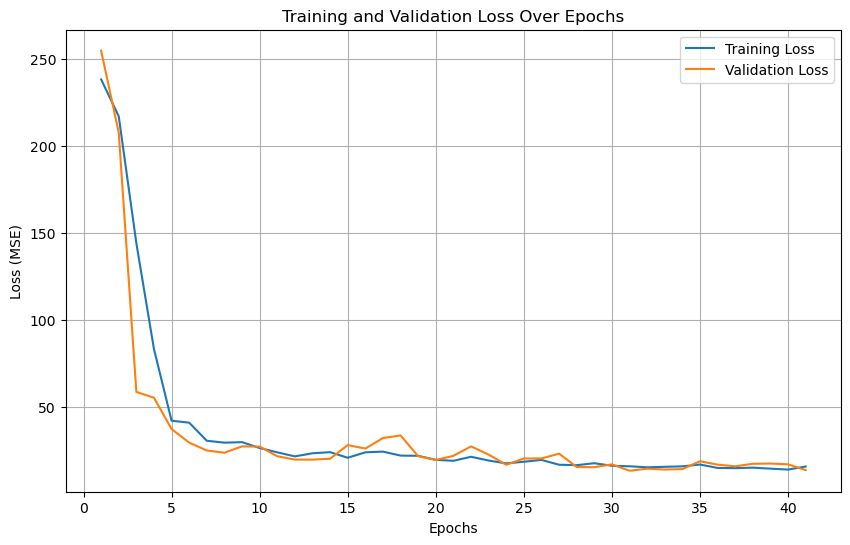

In [154]:
# plotting training and validation loss 
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

| Model Type             | Featurization        |   MAE |  RMSE |   R² | Notes             |
|------------------------|----------------------|-------|-------|------|-------------------|
| Hybrid GNN (Tuned)| OGB smiles2graph + RDKit descriptors | 0.159 | 0.234 | 0.965 | Best   |
| Hybrid GNN (Untuned) | OGB smiles2graph + RDKit descriptors | 0.223 | 0.308 | 0.939 | 2nd best|

# Step 11: Evaluate on test-dev and save the predictions to csv

In [ ]:
# map subset back to original dataset indices
test_indices = split_idx['test-dev']
test_loader = DataLoader(test_dataset, batch_size=64)

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_preds = []
all_ids = [] # store original molecule indices

with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader, desc="Predicting")):
        batch = batch.to(device)
        pred = model(batch)
        all_preds.append(pred.cpu().numpy())

# stack predictions
all_preds = np.vstack(all_preds)

# match predictions to original indices
submission_df = pd.DataFrame({'mol_index': test_indices,  # original indices
                              'prediction': all_preds.flatten()  # flatten to 1D
                              })

# sort by original molecule ID 
submission_df = submission_df.sort_values('mol_index').reset_index(drop=True)

# save to CSV
submission_df.to_csv("hybridgnn_testdev_predictions_with_ids.csv", index=False)
print("Predictions with molecule IDs saved to 'hybridgnn_testdev_predictions_with_ids.csv'")

# Conclusions

## Model Performance Summary

All baseline models were initially trained and evaluated on a 5,000 molecule subset of the full dataset. Below is a comparison of results across different featurization strategies and model types:

### 2D Baseline Models

| Model Type    | Featurization      | MAE   | RMSE  | R²    | Notes                                 |
| ------------- | ------------------ | ----- | ----- | ----- | ------------------------------------- |
| MLP (Tuned)   | RDKit Fingerprints | 0.426 | 0.574 | 0.798 | Strong performance across all metrics |
| KRR (Tuned)   | RDKit Fingerprints | 0.454 | 0.593 | 0.784 | Good overall, slightly lower R²       |
| RF (Tuned)    | RDKit Fingerprints | 0.423 | 0.583 | 0.791 | Best MAE, very competitive overall    |
| MLP (Tuned)   | Coulomb Matrix     | 0.636 | 0.819 | 0.588 | Significantly weaker performance      |
| MLP (Untuned) | RDKit Fingerprints | 0.467 | 0.609 | 0.772 | Solid untuned baseline                |
| KRR (Untuned) | RDKit Fingerprints | 0.519 | 0.668 | 0.726 | Notable drop from tuned version       |
| RF (Untuned)  | RDKit Fingerprints | 0.426 | 0.587 | 0.788 | Surprisingly close to tuned RF        |
| MLP (Untuned) | Coulomb Matrix     | 0.663 | 0.847 | 0.559 | Consistently underperforms            |

### Graph Neural Network Models (ChemML)

| Model Type    | Featurization               | MAE   | RMSE  | R²    | Notes                                |
| ------------- | --------------------------- | ----- | ----- | ----- | ------------------------------------ |
| GNN (Tuned)   | `tensorise_molecules` Graph | 0.302 | 0.411 | 0.900 | Best results from ChemML experiments |
| GNN (Untuned) | `tensorise_molecules` Graph | 0.400 | 0.519 | 0.841 | Strong but less optimized            |

### Final Hybrid GNN Model Trained on Full Dataset (OGB-Compatible)

| Model Type           | Featurization                          | MAE   | RMSE  | R²    | Notes                              |
| -------------------- | -------------------------------------- | ----- | ----- | ----- | ---------------------------------- |
| Hybrid GNN (Tuned)   | OGB `smiles2graph` + RDKit descriptors | 0.159 | 0.234 | 0.965 | State-of-the-art level performance |
| Hybrid GNN (Untuned) | OGB `smiles2graph` + RDKit descriptors | 0.223 | 0.308 | 0.939 | Still very strong pre-tuning       |

---

## Model Error Analysis

I performed qualitative evaluation by comparing predicted vs. true HOMO–LUMO gaps for both randomly selected and poorly predicted molecules. The worst performing molecules often showed rare or complex structures likely underrepresented in the training set. This highlights the importance of structural diversity and potentially more expressive 3D information to improve generalization.

## Next Steps: Integrating 3D Molecular Information

To push performance even further and overcome limitations of 2D graphs and hand crafted descriptors, my next step will involve:

* Using **3D molecular geometries** 
* Incorporating **interatomic distances**, angles, and **spatial encoding** (SchNet, DimeNet, or SE(3)-equivariant models)
* Comparing results against the current best MAE (\~0.159)

This direction aligns with trends in molecular property prediction where 3D aware models often outperform purely 2D approaches, especially for quantum properties like HOMO–LUMO gaps.
